Here we'll first be loading the FC matrices and explore their structure

In [1]:
#using read_dataset from Datasets/FC/create_dataset.py to read the dataset
from Datasets.FC.create_dataset import read_dataset
import torch 
print('GPU available?', torch.cuda.is_available())

GPU available? True


In [2]:
dataset = read_dataset()

In [3]:
#ok, let's explore the data a bit more
#dataset is a list object of torch_geometric.data objects

#let's see the first element
print(dataset[0])

#it's a dictionary object, let's see the keys
print(dataset[0].keys())

#ok, let's see the values
print(dataset[0].values())

#it has 4 keys, 'x', 'edge_index', 'edge_attr' and 'y' where y=0 menas the patient is healthy and y=1 means the patient has Autism Spectrum Disorder (ASD)
"""graph = Data(x=ROI.reshape(-1,116).float(),
                     edge_index=G.indices().reshape(2,-1).long(),
                     edge_attr=G.values().reshape(-1,1).float(),
                     y=y.long())"""

#how much data do we have?
len(dataset)


Data(x=[116, 116], edge_index=[2, 1016], edge_attr=[1016, 1], y=[1])
['edge_attr', 'x', 'edge_index', 'y']
ValuesView({'x': tensor([[ 0.0000,  0.4543,  0.2477,  ...,  0.1753,  0.2247, -0.1751],
        [ 0.4543,  0.0000, -0.2204,  ..., -0.1947, -0.2258, -0.1434],
        [ 0.2477, -0.2204,  0.0000,  ..., -0.0521, -0.0804, -0.2025],
        ...,
        [ 0.1753, -0.1947, -0.0521,  ...,  0.0000,  0.6875, -0.1364],
        [ 0.2247, -0.2258, -0.0804,  ...,  0.6875,  0.0000,  0.0929],
        [-0.1751, -0.1434, -0.2025,  ..., -0.1364,  0.0929,  0.0000]]), 'edge_index': tensor([[  0,   0,   0,  ..., 114, 115, 115],
        [  1,  10,  12,  ..., 113,  94, 109]]), 'edge_attr': tensor([[0.4543],
        [0.5913],
        [0.4224],
        ...,
        [0.6875],
        [0.4846],
        [0.5437]]), 'y': tensor([0])})


1099

In [4]:
#set the seed
import torch
torch.manual_seed(0)

MODEL = "GCN_wo_edge_weight"
DATASET = "FC"

from models.models_FC import GCN_framework_wo_edge_weight as framework # import the model

gnn = framework(dataset,device="cpu")

print(gnn.model)
print(gnn.train_idx)

Net(
  (conv_layers): ModuleList(
    (0): GCNConv(116, 128)
    (1): GCNConv(128, 128)
    (2): GCNConv(128, 128)
    (3): GCNConv(128, 128)
    (4): GCNConv(128, 128)
  )
  (batch_norms): ModuleList(
    (0): BatchNorm(128)
    (1): BatchNorm(128)
    (2): BatchNorm(128)
    (3): BatchNorm(128)
    (4): BatchNorm(128)
  )
  (lin1): Linear(128, 128, bias=True)
  (lin2): Linear(128, 2, bias=True)
  (bn1): BatchNorm(128)
  (bn2): BatchNorm(2)
)
tensor([217, 137, 426,  ..., 643, 205, 434])


/home/tpelletreaudur/.local/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [5]:
# gnn.iterate()

In [6]:
#gnn.train()

In [7]:
#save the model 
# gnn.save_model(path="models/"+DATASET+"_"+MODEL+"server.pt")

In [8]:
#load the model
gnn.load_model(path="models/"+DATASET+"_"+MODEL+"server.pt")

In [9]:
gnn.evaluate()

Test Loss: 0.728, Train Acc: 1.000 Test Acc: 0.564


In [10]:
train_features, test_features = gnn.evaluate_with_features2()

In [11]:
print(len(train_features[0]))
len(train_features), len(test_features)

8


(1044, 55)

In [12]:
import pickle as pkl
import networkx as nx

def calculate_avg_path_length(G):
    if nx.is_connected(G):
        return nx.average_shortest_path_length(G)
    else:
        # Alternative metrics for disconnected graphs
        # Option 1: Use the average path length of the largest connected component
        components = [G.subgraph(c).copy() for c in nx.connected_components(G)]
        largest_component = max(components, key=len)
        return nx.average_shortest_path_length(largest_component)
    
def calculate_small_world(G):
    if nx.is_connected(G):
        return nx.algorithms.smallworld.sigma(G)
    else:
        # Alternative metrics for disconnected graphs
        # Option 1: Use the small world coefficient of the largest connected component
        components = [G.subgraph(c).copy() for c in nx.connected_components(G)]
        largest_component = max(components, key=len)
        return nx.algorithms.smallworld.sigma(largest_component)
    
def compute_swi(graph):
    # Calculate clustering coefficient and average path length for the given graph
    clustering_coeff = nx.average_clustering(graph)
    avg_path_len = calculate_avg_path_length(graph)
    
    # Generate a random graph with the same number of nodes and edges
    num_nodes = graph.number_of_nodes()
    num_edges = graph.number_of_edges()
    random_graph = nx.gnm_random_graph(num_nodes, num_edges)
    
    # Generate a lattice graph with the same number of nodes and edges
    lattice_graph = nx.watts_strogatz_graph(num_nodes, k=4, p=0)  # Adjust k as needed
    
    # Calculate clustering coefficient and average path length for the random graph
    random_clustering_coeff = nx.average_clustering(random_graph)
    random_avg_path_len = calculate_avg_path_length(random_graph)
    
    # Calculate clustering coefficient and average path length for the lattice graph
    lattice_clustering_coeff = nx.average_clustering(lattice_graph)
    lattice_avg_path_len = calculate_avg_path_length(lattice_graph)
    
    # Compute the Small-World Index (SWI)
    swi = ((avg_path_len - lattice_avg_path_len) / (random_avg_path_len - lattice_avg_path_len)) * \
          ((clustering_coeff - random_clustering_coeff) / (lattice_clustering_coeff - random_clustering_coeff))
    
    return swi
    

def compute_graph_properties(data):
    properties = []
    for graph_data in data:
        G = nx.from_edgelist(graph_data.edge_index.t().tolist())
        num_nodes = G.number_of_nodes()
        num_edges = G.number_of_edges()
        density = nx.density(G)
        avg_path_len = calculate_avg_path_length(G)
        num_cliques = len(list(nx.find_cliques(G)))
        num_triangles = sum(nx.triangles(G).values()) / 3
        num_squares = sum(nx.square_clustering(G).values()) / 4
        number_of_node_in_the_largest_fully_connected_component = len(max(nx.connected_components(G), key=len))
        assortativity = nx.degree_assortativity_coefficient(G)
        small_world = compute_swi(G)
            
        properties.append((num_nodes, num_edges, density, avg_path_len, num_cliques, num_triangles, num_squares, number_of_node_in_the_largest_fully_connected_component, assortativity, small_world))
    return properties

train_idx_list = gnn.train_idx.tolist()
selected_dataset = [gnn.dataset[i] for i in train_idx_list]
train_properties = compute_graph_properties(selected_dataset)
test_idx_list = gnn.test_idx.tolist()
selected_dataset = [gnn.dataset[i] for i in test_idx_list]
test_properties = compute_graph_properties(selected_dataset)

# Save the properties to files
with open("results/"+DATASET+"_"+MODEL+"_train_properties_with_sm.pkl", "wb") as f:
    pkl.dump(train_properties, f)

with open("results/"+DATASET+"_"+MODEL+"_test_properties_with_sm.pkl", "wb") as f:
    pkl.dump(test_properties, f)

In [13]:
# print(len(train_properties))
# train_properties[0:5]



In [14]:
import pickle as pkl
#save the properties in a file
# with open("results/"+DATASET+"_"+MODEL+"_train_properties.pkl", "wb") as f:
#     pkl.dump(train_properties, f)

# with open("results/"+DATASET+"_"+MODEL+"_test_properties.pkl", "wb") as f:
#     pkl.dump(test_properties, f)

#load the properties
with open("results/"+DATASET+"_"+MODEL+"_train_properties_with_sm.pkl", "rb") as f:
    train_properties = pkl.load(f)

with open("results/"+DATASET+"_"+MODEL+"_test_properties_with_sm.pkl", "rb") as f:
    test_properties = pkl.load(f)

In [17]:
"""
The embeddings of GCN are like this:
return F.log_softmax(x7, dim=-1), (x1, x2, x3, x4, x5, x_global, x6, x7)
"""


import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
output_size = 1  # Predicting one property at a time
# Define the linear model
class LinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

# Assume we have already evaluated to get features
#train_features, test_features = gnn.evaluate_with_features2()

# Extract x embeddings
train_x = np.array([feat[0] for feat in train_features])
test_x = np.array([feat[0] for feat in test_features])

# Extract 2, 3, 4, global, 5, 6, 7 embeddings
train_x2 = np.array([feat[1] for feat in train_features])
test_x2 = np.array([feat[1] for feat in test_features])

train_x3 = np.array([feat[2] for feat in train_features])
test_x3 = np.array([feat[2] for feat in test_features])

train_x4 = np.array([feat[3] for feat in train_features])
test_x4 = np.array([feat[3] for feat in test_features])

train_x5 = np.array([feat[4] for feat in train_features])
test_x5 = np.array([feat[4] for feat in test_features])

train_x_global = np.array([feat[5] for feat in train_features])
test_x_global = np.array([feat[5] for feat in test_features])

train_x6 = np.array([feat[6] for feat in train_features])
test_x6 = np.array([feat[6] for feat in test_features])

train_x7 = np.array([feat[7] for feat in train_features])
test_x7 = np.array([feat[7] for feat in test_features])

# Compute graph properties
# train_properties = compute_graph_properties(gnn.dataset[gnn.train_idx])
# test_properties = compute_graph_properties(gnn.dataset[gnn.test_idx])

# Convert to PyTorch tensors
train_x = torch.tensor(train_x, dtype=torch.float32)
train_x2 = torch.tensor(train_x2, dtype=torch.float32)
train_x3 = torch.tensor(train_x3, dtype=torch.float32)
train_x4 = torch.tensor(train_x4, dtype=torch.float32)
train_x5 = torch.tensor(train_x5, dtype=torch.float32)
train_x_global = torch.tensor(train_x_global, dtype=torch.float32)
train_x6 = torch.tensor(train_x6, dtype=torch.float32)
train_x7 = torch.tensor(train_x7, dtype=torch.float32)

test_x = torch.tensor(test_x, dtype=torch.float32)
test_x2 = torch.tensor(test_x2, dtype=torch.float32)
test_x3 = torch.tensor(test_x3, dtype=torch.float32)
test_x4 = torch.tensor(test_x4, dtype=torch.float32)
test_x5 = torch.tensor(test_x5, dtype=torch.float32)
test_x_global = torch.tensor(test_x_global, dtype=torch.float32)
test_x6 = torch.tensor(test_x6, dtype=torch.float32)
test_x7 = torch.tensor(test_x7, dtype=torch.float32)

train_y = torch.tensor(train_properties, dtype=torch.float32)
test_y = torch.tensor(test_properties, dtype=torch.float32)

# Train and evaluate a model for each graph property and each embedding
property_names = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'num_cliques', 'num_triangles', 'num_squares', 'number_of_nodes_in_the_largest_fully_connected_component','assortativity', 'small_world']
embeddings = [(train_x, test_x), (train_x2, test_x2), (train_x3, test_x3), (train_x4, test_x4), (train_x5, test_x5), (train_x_global, test_x_global), (train_x6, test_x6), (train_x7, test_x7)]
embeddings_names = ['x1', 'x2', 'x3', 'x4', 'x5', 'x_global', 'x6', 'x7']

In [18]:
#create a dictionary where we will sotre the results for each embeddings, each property
results = {}

ii = 0

for train_embedding, test_embedding in embeddings:
    input_size = train_embedding.shape[1]

    for i, property_name in enumerate(property_names):
        model = LinearModel(input_size, output_size)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        num_epochs = 500000  # Adjust this as needed

        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()

            outputs = model(train_embedding).squeeze()
            target = train_y[:, i].squeeze()

            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            if (epoch+1) % 1000 == 0:  # Adjust this for more frequent/lower print frequency
                print(f'Epoch [{epoch+1}/{num_epochs}], Property: {property_name}, Loss: {loss.item():.4f}')

        # Evaluate the model
        model.eval()
        with torch.no_grad():
            train_pred = model(train_embedding).squeeze().cpu().numpy()
            test_pred = model(test_embedding).squeeze().cpu().numpy()

            train_target = train_y[:, i].cpu().numpy()
            test_target = test_y[:, i].cpu().numpy()

            train_mse = mean_squared_error(train_target, train_pred)
            test_mse = mean_squared_error(test_target, test_pred)

            train_r2 = r2_score(train_target, train_pred)
            test_r2 = r2_score(test_target, test_pred)

            print(f'Embedding: {train_embedding.shape}')
            print(f'Property: {property_name}')
            print(f'  Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}')
            print(f'  Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}')

            #add the results to the dictionary
            name_of_embdedding = embeddings_names[ii]
            results[(name_of_embdedding, property_name)] = (train_mse, test_mse, train_r2, test_r2)

    ii += 1

#save results
with open("results/"+DATASET+"_"+MODEL+"_results.pkl", "wb") as f:
    pkl.dump(results, f)

Epoch [1000/500000], Property: num_nodes, Loss: 4912.9976
Epoch [2000/500000], Property: num_nodes, Loss: 1868.2966
Epoch [3000/500000], Property: num_nodes, Loss: 1040.2645
Epoch [4000/500000], Property: num_nodes, Loss: 785.3152
Epoch [5000/500000], Property: num_nodes, Loss: 647.2172
Epoch [6000/500000], Property: num_nodes, Loss: 547.3569
Epoch [7000/500000], Property: num_nodes, Loss: 462.4950
Epoch [8000/500000], Property: num_nodes, Loss: 387.6809
Epoch [9000/500000], Property: num_nodes, Loss: 324.5463
Epoch [10000/500000], Property: num_nodes, Loss: 274.0941
Epoch [11000/500000], Property: num_nodes, Loss: 235.1166
Epoch [12000/500000], Property: num_nodes, Loss: 205.5839
Epoch [13000/500000], Property: num_nodes, Loss: 183.6483
Epoch [14000/500000], Property: num_nodes, Loss: 167.6659
Epoch [15000/500000], Property: num_nodes, Loss: 156.1848
Epoch [16000/500000], Property: num_nodes, Loss: 147.7606
Epoch [17000/500000], Property: num_nodes, Loss: 141.1478
Epoch [18000/500000]

Epoch [145000/500000], Property: num_nodes, Loss: 1.6447
Epoch [146000/500000], Property: num_nodes, Loss: 1.6447
Epoch [147000/500000], Property: num_nodes, Loss: 1.6447
Epoch [148000/500000], Property: num_nodes, Loss: 1.6447
Epoch [149000/500000], Property: num_nodes, Loss: 1.6447
Epoch [150000/500000], Property: num_nodes, Loss: 1.6447
Epoch [151000/500000], Property: num_nodes, Loss: 1.6447
Epoch [152000/500000], Property: num_nodes, Loss: 1.6447
Epoch [153000/500000], Property: num_nodes, Loss: 1.6447
Epoch [154000/500000], Property: num_nodes, Loss: 1.6447
Epoch [155000/500000], Property: num_nodes, Loss: 1.6447
Epoch [156000/500000], Property: num_nodes, Loss: 1.6447
Epoch [157000/500000], Property: num_nodes, Loss: 1.6447
Epoch [158000/500000], Property: num_nodes, Loss: 1.6447
Epoch [159000/500000], Property: num_nodes, Loss: 1.6447
Epoch [160000/500000], Property: num_nodes, Loss: 1.6447
Epoch [161000/500000], Property: num_nodes, Loss: 1.6447
Epoch [162000/500000], Property

Epoch [289000/500000], Property: num_nodes, Loss: 1.6447
Epoch [290000/500000], Property: num_nodes, Loss: 1.6447
Epoch [291000/500000], Property: num_nodes, Loss: 1.6447
Epoch [292000/500000], Property: num_nodes, Loss: 1.6447
Epoch [293000/500000], Property: num_nodes, Loss: 1.6447
Epoch [294000/500000], Property: num_nodes, Loss: 1.6447
Epoch [295000/500000], Property: num_nodes, Loss: 1.6447
Epoch [296000/500000], Property: num_nodes, Loss: 1.6447
Epoch [297000/500000], Property: num_nodes, Loss: 1.6447
Epoch [298000/500000], Property: num_nodes, Loss: 1.6447
Epoch [299000/500000], Property: num_nodes, Loss: 1.6447
Epoch [300000/500000], Property: num_nodes, Loss: 1.6447
Epoch [301000/500000], Property: num_nodes, Loss: 1.6447
Epoch [302000/500000], Property: num_nodes, Loss: 1.6447
Epoch [303000/500000], Property: num_nodes, Loss: 1.6447
Epoch [304000/500000], Property: num_nodes, Loss: 1.6447
Epoch [305000/500000], Property: num_nodes, Loss: 1.6447
Epoch [306000/500000], Property

Epoch [433000/500000], Property: num_nodes, Loss: 1.6447
Epoch [434000/500000], Property: num_nodes, Loss: 1.6447
Epoch [435000/500000], Property: num_nodes, Loss: 1.6447
Epoch [436000/500000], Property: num_nodes, Loss: 1.6447
Epoch [437000/500000], Property: num_nodes, Loss: 1.6447
Epoch [438000/500000], Property: num_nodes, Loss: 1.6447
Epoch [439000/500000], Property: num_nodes, Loss: 1.6447
Epoch [440000/500000], Property: num_nodes, Loss: 1.6447
Epoch [441000/500000], Property: num_nodes, Loss: 1.6449
Epoch [442000/500000], Property: num_nodes, Loss: 1.6447
Epoch [443000/500000], Property: num_nodes, Loss: 1.6447
Epoch [444000/500000], Property: num_nodes, Loss: 1.6447
Epoch [445000/500000], Property: num_nodes, Loss: 1.6447
Epoch [446000/500000], Property: num_nodes, Loss: 1.6447
Epoch [447000/500000], Property: num_nodes, Loss: 1.6447
Epoch [448000/500000], Property: num_nodes, Loss: 1.6447
Epoch [449000/500000], Property: num_nodes, Loss: 1.6447
Epoch [450000/500000], Property

Epoch [71000/500000], Property: num_edges, Loss: 18677.4180
Epoch [72000/500000], Property: num_edges, Loss: 18643.2793
Epoch [73000/500000], Property: num_edges, Loss: 18609.8418
Epoch [74000/500000], Property: num_edges, Loss: 18577.0508
Epoch [75000/500000], Property: num_edges, Loss: 18544.8594
Epoch [76000/500000], Property: num_edges, Loss: 18513.2090
Epoch [77000/500000], Property: num_edges, Loss: 18482.0371
Epoch [78000/500000], Property: num_edges, Loss: 18451.3086
Epoch [79000/500000], Property: num_edges, Loss: 18421.0137
Epoch [80000/500000], Property: num_edges, Loss: 18391.1387
Epoch [81000/500000], Property: num_edges, Loss: 18361.6680
Epoch [82000/500000], Property: num_edges, Loss: 18332.5957
Epoch [83000/500000], Property: num_edges, Loss: 18303.9160
Epoch [84000/500000], Property: num_edges, Loss: 18275.6191
Epoch [85000/500000], Property: num_edges, Loss: 18247.6992
Epoch [86000/500000], Property: num_edges, Loss: 18220.1504
Epoch [87000/500000], Property: num_edge

Epoch [206000/500000], Property: num_edges, Loss: 16019.3887
Epoch [207000/500000], Property: num_edges, Loss: 16008.5371
Epoch [208000/500000], Property: num_edges, Loss: 15997.7578
Epoch [209000/500000], Property: num_edges, Loss: 15987.0557
Epoch [210000/500000], Property: num_edges, Loss: 15976.4268
Epoch [211000/500000], Property: num_edges, Loss: 15965.8701
Epoch [212000/500000], Property: num_edges, Loss: 15955.3838
Epoch [213000/500000], Property: num_edges, Loss: 15944.9678
Epoch [214000/500000], Property: num_edges, Loss: 15934.6211
Epoch [215000/500000], Property: num_edges, Loss: 15924.3516
Epoch [216000/500000], Property: num_edges, Loss: 15914.1533
Epoch [217000/500000], Property: num_edges, Loss: 15904.0234
Epoch [218000/500000], Property: num_edges, Loss: 15893.9668
Epoch [219000/500000], Property: num_edges, Loss: 15883.9785
Epoch [220000/500000], Property: num_edges, Loss: 15874.0635
Epoch [221000/500000], Property: num_edges, Loss: 15864.2168
Epoch [222000/500000], P

Epoch [341000/500000], Property: num_edges, Loss: 14875.0117
Epoch [342000/500000], Property: num_edges, Loss: 14868.0205
Epoch [343000/500000], Property: num_edges, Loss: 14861.0498
Epoch [344000/500000], Property: num_edges, Loss: 14854.1006
Epoch [345000/500000], Property: num_edges, Loss: 14847.1729
Epoch [346000/500000], Property: num_edges, Loss: 14840.2666
Epoch [347000/500000], Property: num_edges, Loss: 14833.3818
Epoch [348000/500000], Property: num_edges, Loss: 14826.5186
Epoch [349000/500000], Property: num_edges, Loss: 14819.6748
Epoch [350000/500000], Property: num_edges, Loss: 14812.8535
Epoch [351000/500000], Property: num_edges, Loss: 14806.0518
Epoch [352000/500000], Property: num_edges, Loss: 14799.2744
Epoch [353000/500000], Property: num_edges, Loss: 14792.5156
Epoch [354000/500000], Property: num_edges, Loss: 14785.7783
Epoch [355000/500000], Property: num_edges, Loss: 14779.0635
Epoch [356000/500000], Property: num_edges, Loss: 14772.3701
Epoch [357000/500000], P

Epoch [476000/500000], Property: num_edges, Loss: 14123.2793
Epoch [477000/500000], Property: num_edges, Loss: 14119.1543
Epoch [478000/500000], Property: num_edges, Loss: 14115.0518
Epoch [479000/500000], Property: num_edges, Loss: 14110.9697
Epoch [480000/500000], Property: num_edges, Loss: 14106.9092
Epoch [481000/500000], Property: num_edges, Loss: 14102.8721
Epoch [482000/500000], Property: num_edges, Loss: 14098.8525
Epoch [483000/500000], Property: num_edges, Loss: 14094.8564
Epoch [484000/500000], Property: num_edges, Loss: 14090.8789
Epoch [485000/500000], Property: num_edges, Loss: 14086.9248
Epoch [486000/500000], Property: num_edges, Loss: 14082.9932
Epoch [487000/500000], Property: num_edges, Loss: 14079.0811
Epoch [488000/500000], Property: num_edges, Loss: 14075.1914
Epoch [489000/500000], Property: num_edges, Loss: 14071.3223
Epoch [490000/500000], Property: num_edges, Loss: 14067.4736
Epoch [491000/500000], Property: num_edges, Loss: 14063.6475
Epoch [492000/500000], P

Epoch [122000/500000], Property: density, Loss: 0.0003
Epoch [123000/500000], Property: density, Loss: 0.0003
Epoch [124000/500000], Property: density, Loss: 0.0003
Epoch [125000/500000], Property: density, Loss: 0.0003
Epoch [126000/500000], Property: density, Loss: 0.0003
Epoch [127000/500000], Property: density, Loss: 0.0003
Epoch [128000/500000], Property: density, Loss: 0.0003
Epoch [129000/500000], Property: density, Loss: 0.0003
Epoch [130000/500000], Property: density, Loss: 0.0003
Epoch [131000/500000], Property: density, Loss: 0.0003
Epoch [132000/500000], Property: density, Loss: 0.0003
Epoch [133000/500000], Property: density, Loss: 0.0003
Epoch [134000/500000], Property: density, Loss: 0.0003
Epoch [135000/500000], Property: density, Loss: 0.0003
Epoch [136000/500000], Property: density, Loss: 0.0003
Epoch [137000/500000], Property: density, Loss: 0.0003
Epoch [138000/500000], Property: density, Loss: 0.0003
Epoch [139000/500000], Property: density, Loss: 0.0003
Epoch [140

Epoch [271000/500000], Property: density, Loss: 0.0003
Epoch [272000/500000], Property: density, Loss: 0.0003
Epoch [273000/500000], Property: density, Loss: 0.0003
Epoch [274000/500000], Property: density, Loss: 0.0003
Epoch [275000/500000], Property: density, Loss: 0.0003
Epoch [276000/500000], Property: density, Loss: 0.0003
Epoch [277000/500000], Property: density, Loss: 0.0003
Epoch [278000/500000], Property: density, Loss: 0.0003
Epoch [279000/500000], Property: density, Loss: 0.0003
Epoch [280000/500000], Property: density, Loss: 0.0003
Epoch [281000/500000], Property: density, Loss: 0.0003
Epoch [282000/500000], Property: density, Loss: 0.0003
Epoch [283000/500000], Property: density, Loss: 0.0003
Epoch [284000/500000], Property: density, Loss: 0.0003
Epoch [285000/500000], Property: density, Loss: 0.0003
Epoch [286000/500000], Property: density, Loss: 0.0003
Epoch [287000/500000], Property: density, Loss: 0.0003
Epoch [288000/500000], Property: density, Loss: 0.0003
Epoch [289

Epoch [420000/500000], Property: density, Loss: 0.0003
Epoch [421000/500000], Property: density, Loss: 0.0003
Epoch [422000/500000], Property: density, Loss: 0.0003
Epoch [423000/500000], Property: density, Loss: 0.0003
Epoch [424000/500000], Property: density, Loss: 0.0003
Epoch [425000/500000], Property: density, Loss: 0.0003
Epoch [426000/500000], Property: density, Loss: 0.0003
Epoch [427000/500000], Property: density, Loss: 0.0003
Epoch [428000/500000], Property: density, Loss: 0.0003
Epoch [429000/500000], Property: density, Loss: 0.0003
Epoch [430000/500000], Property: density, Loss: 0.0003
Epoch [431000/500000], Property: density, Loss: 0.0003
Epoch [432000/500000], Property: density, Loss: 0.0003
Epoch [433000/500000], Property: density, Loss: 0.0003
Epoch [434000/500000], Property: density, Loss: 0.0003
Epoch [435000/500000], Property: density, Loss: 0.0003
Epoch [436000/500000], Property: density, Loss: 0.0003
Epoch [437000/500000], Property: density, Loss: 0.0003
Epoch [438

Epoch [63000/500000], Property: avg_path_len, Loss: 0.2010
Epoch [64000/500000], Property: avg_path_len, Loss: 0.2010
Epoch [65000/500000], Property: avg_path_len, Loss: 0.2010
Epoch [66000/500000], Property: avg_path_len, Loss: 0.2010
Epoch [67000/500000], Property: avg_path_len, Loss: 0.2011
Epoch [68000/500000], Property: avg_path_len, Loss: 0.2010
Epoch [69000/500000], Property: avg_path_len, Loss: 0.2010
Epoch [70000/500000], Property: avg_path_len, Loss: 0.2010
Epoch [71000/500000], Property: avg_path_len, Loss: 0.2010
Epoch [72000/500000], Property: avg_path_len, Loss: 0.2011
Epoch [73000/500000], Property: avg_path_len, Loss: 0.2010
Epoch [74000/500000], Property: avg_path_len, Loss: 0.2010
Epoch [75000/500000], Property: avg_path_len, Loss: 0.2010
Epoch [76000/500000], Property: avg_path_len, Loss: 0.2010
Epoch [77000/500000], Property: avg_path_len, Loss: 0.2010
Epoch [78000/500000], Property: avg_path_len, Loss: 0.2010
Epoch [79000/500000], Property: avg_path_len, Loss: 0.20

Epoch [201000/500000], Property: avg_path_len, Loss: 0.2010
Epoch [202000/500000], Property: avg_path_len, Loss: 0.2010
Epoch [203000/500000], Property: avg_path_len, Loss: 0.2010
Epoch [204000/500000], Property: avg_path_len, Loss: 0.2010
Epoch [205000/500000], Property: avg_path_len, Loss: 0.2010
Epoch [206000/500000], Property: avg_path_len, Loss: 0.2010
Epoch [207000/500000], Property: avg_path_len, Loss: 0.2010
Epoch [208000/500000], Property: avg_path_len, Loss: 0.2010
Epoch [209000/500000], Property: avg_path_len, Loss: 0.2010
Epoch [210000/500000], Property: avg_path_len, Loss: 0.2010
Epoch [211000/500000], Property: avg_path_len, Loss: 0.2010
Epoch [212000/500000], Property: avg_path_len, Loss: 0.2010
Epoch [213000/500000], Property: avg_path_len, Loss: 0.2010
Epoch [214000/500000], Property: avg_path_len, Loss: 0.2010
Epoch [215000/500000], Property: avg_path_len, Loss: 0.2010
Epoch [216000/500000], Property: avg_path_len, Loss: 0.2010
Epoch [217000/500000], Property: avg_pat

Epoch [338000/500000], Property: avg_path_len, Loss: 0.2010
Epoch [339000/500000], Property: avg_path_len, Loss: 0.2010
Epoch [340000/500000], Property: avg_path_len, Loss: 0.2010
Epoch [341000/500000], Property: avg_path_len, Loss: 0.2010
Epoch [342000/500000], Property: avg_path_len, Loss: 0.2010
Epoch [343000/500000], Property: avg_path_len, Loss: 0.2010
Epoch [344000/500000], Property: avg_path_len, Loss: 0.2010
Epoch [345000/500000], Property: avg_path_len, Loss: 0.2012
Epoch [346000/500000], Property: avg_path_len, Loss: 0.2010
Epoch [347000/500000], Property: avg_path_len, Loss: 0.2010
Epoch [348000/500000], Property: avg_path_len, Loss: 0.2010
Epoch [349000/500000], Property: avg_path_len, Loss: 0.2010
Epoch [350000/500000], Property: avg_path_len, Loss: 0.2010
Epoch [351000/500000], Property: avg_path_len, Loss: 0.2010
Epoch [352000/500000], Property: avg_path_len, Loss: 0.2010
Epoch [353000/500000], Property: avg_path_len, Loss: 0.2010
Epoch [354000/500000], Property: avg_pat

Epoch [475000/500000], Property: avg_path_len, Loss: 0.2010
Epoch [476000/500000], Property: avg_path_len, Loss: 0.2010
Epoch [477000/500000], Property: avg_path_len, Loss: 0.2010
Epoch [478000/500000], Property: avg_path_len, Loss: 0.2010
Epoch [479000/500000], Property: avg_path_len, Loss: 0.2010
Epoch [480000/500000], Property: avg_path_len, Loss: 0.2010
Epoch [481000/500000], Property: avg_path_len, Loss: 0.2010
Epoch [482000/500000], Property: avg_path_len, Loss: 0.2010
Epoch [483000/500000], Property: avg_path_len, Loss: 0.2010
Epoch [484000/500000], Property: avg_path_len, Loss: 0.2010
Epoch [485000/500000], Property: avg_path_len, Loss: 0.2010
Epoch [486000/500000], Property: avg_path_len, Loss: 0.2010
Epoch [487000/500000], Property: avg_path_len, Loss: 0.2010
Epoch [488000/500000], Property: avg_path_len, Loss: 0.2010
Epoch [489000/500000], Property: avg_path_len, Loss: 0.2010
Epoch [490000/500000], Property: avg_path_len, Loss: 0.2010
Epoch [491000/500000], Property: avg_pat

Epoch [109000/500000], Property: num_cliques, Loss: 826.7257
Epoch [110000/500000], Property: num_cliques, Loss: 824.9693
Epoch [111000/500000], Property: num_cliques, Loss: 823.2335
Epoch [112000/500000], Property: num_cliques, Loss: 821.5189
Epoch [113000/500000], Property: num_cliques, Loss: 819.8286
Epoch [114000/500000], Property: num_cliques, Loss: 818.1659
Epoch [115000/500000], Property: num_cliques, Loss: 816.5246
Epoch [116000/500000], Property: num_cliques, Loss: 814.9038
Epoch [117000/500000], Property: num_cliques, Loss: 813.3033
Epoch [118000/500000], Property: num_cliques, Loss: 811.7233
Epoch [119000/500000], Property: num_cliques, Loss: 810.1636
Epoch [120000/500000], Property: num_cliques, Loss: 808.6239
Epoch [121000/500000], Property: num_cliques, Loss: 807.1047
Epoch [122000/500000], Property: num_cliques, Loss: 805.6057
Epoch [123000/500000], Property: num_cliques, Loss: 804.1270
Epoch [124000/500000], Property: num_cliques, Loss: 802.6687
Epoch [125000/500000], P

Epoch [244000/500000], Property: num_cliques, Loss: 750.9703
Epoch [245000/500000], Property: num_cliques, Loss: 750.9702
Epoch [246000/500000], Property: num_cliques, Loss: 750.9702
Epoch [247000/500000], Property: num_cliques, Loss: 750.9702
Epoch [248000/500000], Property: num_cliques, Loss: 750.9702
Epoch [249000/500000], Property: num_cliques, Loss: 750.9702
Epoch [250000/500000], Property: num_cliques, Loss: 750.9702
Epoch [251000/500000], Property: num_cliques, Loss: 750.9702
Epoch [252000/500000], Property: num_cliques, Loss: 750.9702
Epoch [253000/500000], Property: num_cliques, Loss: 750.9702
Epoch [254000/500000], Property: num_cliques, Loss: 750.9702
Epoch [255000/500000], Property: num_cliques, Loss: 750.9702
Epoch [256000/500000], Property: num_cliques, Loss: 750.9703
Epoch [257000/500000], Property: num_cliques, Loss: 750.9702
Epoch [258000/500000], Property: num_cliques, Loss: 750.9702
Epoch [259000/500000], Property: num_cliques, Loss: 750.9702
Epoch [260000/500000], P

Epoch [379000/500000], Property: num_cliques, Loss: 750.9702
Epoch [380000/500000], Property: num_cliques, Loss: 750.9702
Epoch [381000/500000], Property: num_cliques, Loss: 750.9703
Epoch [382000/500000], Property: num_cliques, Loss: 750.9702
Epoch [383000/500000], Property: num_cliques, Loss: 750.9702
Epoch [384000/500000], Property: num_cliques, Loss: 750.9702
Epoch [385000/500000], Property: num_cliques, Loss: 750.9702
Epoch [386000/500000], Property: num_cliques, Loss: 750.9703
Epoch [387000/500000], Property: num_cliques, Loss: 750.9702
Epoch [388000/500000], Property: num_cliques, Loss: 750.9702
Epoch [389000/500000], Property: num_cliques, Loss: 750.9702
Epoch [390000/500000], Property: num_cliques, Loss: 750.9702
Epoch [391000/500000], Property: num_cliques, Loss: 750.9702
Epoch [392000/500000], Property: num_cliques, Loss: 750.9702
Epoch [393000/500000], Property: num_cliques, Loss: 750.9702
Epoch [394000/500000], Property: num_cliques, Loss: 750.9702
Epoch [395000/500000], P

Epoch [11000/500000], Property: num_triangles, Loss: 868159.8750
Epoch [12000/500000], Property: num_triangles, Loss: 825635.8750
Epoch [13000/500000], Property: num_triangles, Loss: 787651.5625
Epoch [14000/500000], Property: num_triangles, Loss: 753920.7500
Epoch [15000/500000], Property: num_triangles, Loss: 724192.0625
Epoch [16000/500000], Property: num_triangles, Loss: 698145.8750
Epoch [17000/500000], Property: num_triangles, Loss: 675402.3125
Epoch [18000/500000], Property: num_triangles, Loss: 655749.1250
Epoch [19000/500000], Property: num_triangles, Loss: 638944.1250
Epoch [20000/500000], Property: num_triangles, Loss: 624625.3750
Epoch [21000/500000], Property: num_triangles, Loss: 612442.1875
Epoch [22000/500000], Property: num_triangles, Loss: 602057.3750
Epoch [23000/500000], Property: num_triangles, Loss: 593173.8750
Epoch [24000/500000], Property: num_triangles, Loss: 585494.0000
Epoch [25000/500000], Property: num_triangles, Loss: 578738.1875
Epoch [26000/500000], Pro

Epoch [137000/500000], Property: num_triangles, Loss: 404461.9062
Epoch [138000/500000], Property: num_triangles, Loss: 404123.6875
Epoch [139000/500000], Property: num_triangles, Loss: 403791.8438
Epoch [140000/500000], Property: num_triangles, Loss: 403466.3438
Epoch [141000/500000], Property: num_triangles, Loss: 403147.2188
Epoch [142000/500000], Property: num_triangles, Loss: 402834.2812
Epoch [143000/500000], Property: num_triangles, Loss: 402527.6250
Epoch [144000/500000], Property: num_triangles, Loss: 402227.0625
Epoch [145000/500000], Property: num_triangles, Loss: 401932.4375
Epoch [146000/500000], Property: num_triangles, Loss: 401643.9062
Epoch [147000/500000], Property: num_triangles, Loss: 401361.0938
Epoch [148000/500000], Property: num_triangles, Loss: 401084.0625
Epoch [149000/500000], Property: num_triangles, Loss: 400812.3438
Epoch [150000/500000], Property: num_triangles, Loss: 400545.7188
Epoch [151000/500000], Property: num_triangles, Loss: 400283.9062
Epoch [152

Epoch [262000/500000], Property: num_triangles, Loss: 384765.9062
Epoch [263000/500000], Property: num_triangles, Loss: 384669.5312
Epoch [264000/500000], Property: num_triangles, Loss: 384573.3125
Epoch [265000/500000], Property: num_triangles, Loss: 384477.5000
Epoch [266000/500000], Property: num_triangles, Loss: 384381.9375
Epoch [267000/500000], Property: num_triangles, Loss: 384286.7188
Epoch [268000/500000], Property: num_triangles, Loss: 384191.7500
Epoch [269000/500000], Property: num_triangles, Loss: 384097.0938
Epoch [270000/500000], Property: num_triangles, Loss: 384002.7188
Epoch [271000/500000], Property: num_triangles, Loss: 383908.6875
Epoch [272000/500000], Property: num_triangles, Loss: 383814.9375
Epoch [273000/500000], Property: num_triangles, Loss: 383721.4688
Epoch [274000/500000], Property: num_triangles, Loss: 383628.3125
Epoch [275000/500000], Property: num_triangles, Loss: 383535.4688
Epoch [276000/500000], Property: num_triangles, Loss: 383442.9062
Epoch [277

Epoch [387000/500000], Property: num_triangles, Loss: 374891.8438
Epoch [388000/500000], Property: num_triangles, Loss: 374829.7500
Epoch [389000/500000], Property: num_triangles, Loss: 374767.8438
Epoch [390000/500000], Property: num_triangles, Loss: 374706.0312
Epoch [391000/500000], Property: num_triangles, Loss: 374644.3750
Epoch [392000/500000], Property: num_triangles, Loss: 374582.9062
Epoch [393000/500000], Property: num_triangles, Loss: 374521.5625
Epoch [394000/500000], Property: num_triangles, Loss: 374460.3438
Epoch [395000/500000], Property: num_triangles, Loss: 374399.2812
Epoch [396000/500000], Property: num_triangles, Loss: 374338.4062
Epoch [397000/500000], Property: num_triangles, Loss: 374277.6250
Epoch [398000/500000], Property: num_triangles, Loss: 374217.0000
Epoch [399000/500000], Property: num_triangles, Loss: 374156.5625
Epoch [400000/500000], Property: num_triangles, Loss: 374096.2500
Epoch [401000/500000], Property: num_triangles, Loss: 374036.0938
Epoch [402

Epoch [11000/500000], Property: num_squares, Loss: 1.1680
Epoch [12000/500000], Property: num_squares, Loss: 1.1471
Epoch [13000/500000], Property: num_squares, Loss: 1.1361
Epoch [14000/500000], Property: num_squares, Loss: 1.1321
Epoch [15000/500000], Property: num_squares, Loss: 1.1312
Epoch [16000/500000], Property: num_squares, Loss: 1.1312
Epoch [17000/500000], Property: num_squares, Loss: 1.1312
Epoch [18000/500000], Property: num_squares, Loss: 1.1312
Epoch [19000/500000], Property: num_squares, Loss: 1.1312
Epoch [20000/500000], Property: num_squares, Loss: 1.1312
Epoch [21000/500000], Property: num_squares, Loss: 1.1312
Epoch [22000/500000], Property: num_squares, Loss: 1.1312
Epoch [23000/500000], Property: num_squares, Loss: 1.1312
Epoch [24000/500000], Property: num_squares, Loss: 1.1312
Epoch [25000/500000], Property: num_squares, Loss: 1.1312
Epoch [26000/500000], Property: num_squares, Loss: 1.1312
Epoch [27000/500000], Property: num_squares, Loss: 1.1312
Epoch [28000/5

Epoch [152000/500000], Property: num_squares, Loss: 1.1312
Epoch [153000/500000], Property: num_squares, Loss: 1.1312
Epoch [154000/500000], Property: num_squares, Loss: 1.1312
Epoch [155000/500000], Property: num_squares, Loss: 1.1312
Epoch [156000/500000], Property: num_squares, Loss: 1.1312
Epoch [157000/500000], Property: num_squares, Loss: 1.1312
Epoch [158000/500000], Property: num_squares, Loss: 1.1312
Epoch [159000/500000], Property: num_squares, Loss: 1.1312
Epoch [160000/500000], Property: num_squares, Loss: 1.1312
Epoch [161000/500000], Property: num_squares, Loss: 1.1312
Epoch [162000/500000], Property: num_squares, Loss: 1.1312
Epoch [163000/500000], Property: num_squares, Loss: 1.1312
Epoch [164000/500000], Property: num_squares, Loss: 1.1312
Epoch [165000/500000], Property: num_squares, Loss: 1.1312
Epoch [166000/500000], Property: num_squares, Loss: 1.1312
Epoch [167000/500000], Property: num_squares, Loss: 1.1312
Epoch [168000/500000], Property: num_squares, Loss: 1.13

Epoch [291000/500000], Property: num_squares, Loss: 1.1312
Epoch [292000/500000], Property: num_squares, Loss: 1.1312
Epoch [293000/500000], Property: num_squares, Loss: 1.1312
Epoch [294000/500000], Property: num_squares, Loss: 1.1312
Epoch [295000/500000], Property: num_squares, Loss: 1.1312
Epoch [296000/500000], Property: num_squares, Loss: 1.1312
Epoch [297000/500000], Property: num_squares, Loss: 1.1312
Epoch [298000/500000], Property: num_squares, Loss: 1.1312
Epoch [299000/500000], Property: num_squares, Loss: 1.1312
Epoch [300000/500000], Property: num_squares, Loss: 1.1312
Epoch [301000/500000], Property: num_squares, Loss: 1.1312
Epoch [302000/500000], Property: num_squares, Loss: 1.1312
Epoch [303000/500000], Property: num_squares, Loss: 1.1312
Epoch [304000/500000], Property: num_squares, Loss: 1.1312
Epoch [305000/500000], Property: num_squares, Loss: 1.1312
Epoch [306000/500000], Property: num_squares, Loss: 1.1312
Epoch [307000/500000], Property: num_squares, Loss: 1.13

Epoch [430000/500000], Property: num_squares, Loss: 1.1312
Epoch [431000/500000], Property: num_squares, Loss: 1.1312
Epoch [432000/500000], Property: num_squares, Loss: 1.1312
Epoch [433000/500000], Property: num_squares, Loss: 1.1312
Epoch [434000/500000], Property: num_squares, Loss: 1.1312
Epoch [435000/500000], Property: num_squares, Loss: 1.1312
Epoch [436000/500000], Property: num_squares, Loss: 1.1312
Epoch [437000/500000], Property: num_squares, Loss: 1.1312
Epoch [438000/500000], Property: num_squares, Loss: 1.1312
Epoch [439000/500000], Property: num_squares, Loss: 1.1312
Epoch [440000/500000], Property: num_squares, Loss: 1.1312
Epoch [441000/500000], Property: num_squares, Loss: 1.1312
Epoch [442000/500000], Property: num_squares, Loss: 1.1312
Epoch [443000/500000], Property: num_squares, Loss: 1.1312
Epoch [444000/500000], Property: num_squares, Loss: 1.1312
Epoch [445000/500000], Property: num_squares, Loss: 1.1312
Epoch [446000/500000], Property: num_squares, Loss: 1.13

Epoch [39000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 74.6421
Epoch [40000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 72.8935
Epoch [41000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 71.2026
Epoch [42000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 69.5633
Epoch [43000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 67.9650
Epoch [44000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 66.3901
Epoch [45000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 64.8354
Epoch [46000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 63.2958
Epoch [47000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 61.7755
Epoch [48000/500000], Property: number_of_nodes_in_the_largest_f

Epoch [118000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2441
Epoch [119000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1714
Epoch [120000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1148
Epoch [121000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0732
Epoch [122000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0453
Epoch [123000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0290
Epoch [124000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0216
Epoch [125000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0193
Epoch [126000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0190
Epoch [127000/500000], Property: number_of_nodes_in_the_largest_

Epoch [197000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0190
Epoch [198000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0190
Epoch [199000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0190
Epoch [200000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0190
Epoch [201000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0190
Epoch [202000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0190
Epoch [203000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0190
Epoch [204000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0190
Epoch [205000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0190
Epoch [206000/500000], Property: number_of_nodes_in_the_largest_

Epoch [276000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0190
Epoch [277000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0190
Epoch [278000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0190
Epoch [279000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0190
Epoch [280000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0190
Epoch [281000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0190
Epoch [282000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0190
Epoch [283000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0190
Epoch [284000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0190
Epoch [285000/500000], Property: number_of_nodes_in_the_largest_

Epoch [355000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0190
Epoch [356000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0190
Epoch [357000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0190
Epoch [358000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0191
Epoch [359000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0190
Epoch [360000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0190
Epoch [361000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0190
Epoch [362000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0190
Epoch [363000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0190
Epoch [364000/500000], Property: number_of_nodes_in_the_largest_

Epoch [434000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0190
Epoch [435000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0190
Epoch [436000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0190
Epoch [437000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0190
Epoch [438000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0190
Epoch [439000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0190
Epoch [440000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0190
Epoch [441000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0190
Epoch [442000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0190
Epoch [443000/500000], Property: number_of_nodes_in_the_largest_

Epoch [19000/500000], Property: assortativity, Loss: 0.0104
Epoch [20000/500000], Property: assortativity, Loss: 0.0104
Epoch [21000/500000], Property: assortativity, Loss: 0.0104
Epoch [22000/500000], Property: assortativity, Loss: 0.0104
Epoch [23000/500000], Property: assortativity, Loss: 0.0104
Epoch [24000/500000], Property: assortativity, Loss: 0.0104
Epoch [25000/500000], Property: assortativity, Loss: 0.0104
Epoch [26000/500000], Property: assortativity, Loss: 0.0104
Epoch [27000/500000], Property: assortativity, Loss: 0.0104
Epoch [28000/500000], Property: assortativity, Loss: 0.0104
Epoch [29000/500000], Property: assortativity, Loss: 0.0104
Epoch [30000/500000], Property: assortativity, Loss: 0.0104
Epoch [31000/500000], Property: assortativity, Loss: 0.0104
Epoch [32000/500000], Property: assortativity, Loss: 0.0104
Epoch [33000/500000], Property: assortativity, Loss: 0.0104
Epoch [34000/500000], Property: assortativity, Loss: 0.0104
Epoch [35000/500000], Property: assortat

Epoch [155000/500000], Property: assortativity, Loss: 0.0104
Epoch [156000/500000], Property: assortativity, Loss: 0.0104
Epoch [157000/500000], Property: assortativity, Loss: 0.0104
Epoch [158000/500000], Property: assortativity, Loss: 0.0104
Epoch [159000/500000], Property: assortativity, Loss: 0.0104
Epoch [160000/500000], Property: assortativity, Loss: 0.0104
Epoch [161000/500000], Property: assortativity, Loss: 0.0104
Epoch [162000/500000], Property: assortativity, Loss: 0.0104
Epoch [163000/500000], Property: assortativity, Loss: 0.0104
Epoch [164000/500000], Property: assortativity, Loss: 0.0104
Epoch [165000/500000], Property: assortativity, Loss: 0.0104
Epoch [166000/500000], Property: assortativity, Loss: 0.0104
Epoch [167000/500000], Property: assortativity, Loss: 0.0104
Epoch [168000/500000], Property: assortativity, Loss: 0.0104
Epoch [169000/500000], Property: assortativity, Loss: 0.0104
Epoch [170000/500000], Property: assortativity, Loss: 0.0104
Epoch [171000/500000], P

Epoch [290000/500000], Property: assortativity, Loss: 0.0104
Epoch [291000/500000], Property: assortativity, Loss: 0.0104
Epoch [292000/500000], Property: assortativity, Loss: 0.0104
Epoch [293000/500000], Property: assortativity, Loss: 0.0104
Epoch [294000/500000], Property: assortativity, Loss: 0.0104
Epoch [295000/500000], Property: assortativity, Loss: 0.0104
Epoch [296000/500000], Property: assortativity, Loss: 0.0104
Epoch [297000/500000], Property: assortativity, Loss: 0.0104
Epoch [298000/500000], Property: assortativity, Loss: 0.0104
Epoch [299000/500000], Property: assortativity, Loss: 0.0104
Epoch [300000/500000], Property: assortativity, Loss: 0.0104
Epoch [301000/500000], Property: assortativity, Loss: 0.0104
Epoch [302000/500000], Property: assortativity, Loss: 0.0104
Epoch [303000/500000], Property: assortativity, Loss: 0.0104
Epoch [304000/500000], Property: assortativity, Loss: 0.0104
Epoch [305000/500000], Property: assortativity, Loss: 0.0104
Epoch [306000/500000], P

Epoch [425000/500000], Property: assortativity, Loss: 0.0104
Epoch [426000/500000], Property: assortativity, Loss: 0.0104
Epoch [427000/500000], Property: assortativity, Loss: 0.0104
Epoch [428000/500000], Property: assortativity, Loss: 0.0104
Epoch [429000/500000], Property: assortativity, Loss: 0.0104
Epoch [430000/500000], Property: assortativity, Loss: 0.0104
Epoch [431000/500000], Property: assortativity, Loss: 0.0104
Epoch [432000/500000], Property: assortativity, Loss: 0.0104
Epoch [433000/500000], Property: assortativity, Loss: 0.0104
Epoch [434000/500000], Property: assortativity, Loss: 0.0105
Epoch [435000/500000], Property: assortativity, Loss: 0.0104
Epoch [436000/500000], Property: assortativity, Loss: 0.0104
Epoch [437000/500000], Property: assortativity, Loss: 0.0104
Epoch [438000/500000], Property: assortativity, Loss: 0.0104
Epoch [439000/500000], Property: assortativity, Loss: 0.0104
Epoch [440000/500000], Property: assortativity, Loss: 0.0104
Epoch [441000/500000], P

Epoch [61000/500000], Property: small_world, Loss: 0.0098
Epoch [62000/500000], Property: small_world, Loss: 0.0098
Epoch [63000/500000], Property: small_world, Loss: 0.0098
Epoch [64000/500000], Property: small_world, Loss: 0.0098
Epoch [65000/500000], Property: small_world, Loss: 0.0098
Epoch [66000/500000], Property: small_world, Loss: 0.0098
Epoch [67000/500000], Property: small_world, Loss: 0.0098
Epoch [68000/500000], Property: small_world, Loss: 0.0098
Epoch [69000/500000], Property: small_world, Loss: 0.0098
Epoch [70000/500000], Property: small_world, Loss: 0.0098
Epoch [71000/500000], Property: small_world, Loss: 0.0098
Epoch [72000/500000], Property: small_world, Loss: 0.0098
Epoch [73000/500000], Property: small_world, Loss: 0.0098
Epoch [74000/500000], Property: small_world, Loss: 0.0098
Epoch [75000/500000], Property: small_world, Loss: 0.0098
Epoch [76000/500000], Property: small_world, Loss: 0.0098
Epoch [77000/500000], Property: small_world, Loss: 0.0098
Epoch [78000/5

Epoch [201000/500000], Property: small_world, Loss: 0.0098
Epoch [202000/500000], Property: small_world, Loss: 0.0098
Epoch [203000/500000], Property: small_world, Loss: 0.0098
Epoch [204000/500000], Property: small_world, Loss: 0.0098
Epoch [205000/500000], Property: small_world, Loss: 0.0098
Epoch [206000/500000], Property: small_world, Loss: 0.0098
Epoch [207000/500000], Property: small_world, Loss: 0.0098
Epoch [208000/500000], Property: small_world, Loss: 0.0098
Epoch [209000/500000], Property: small_world, Loss: 0.0098
Epoch [210000/500000], Property: small_world, Loss: 0.0098
Epoch [211000/500000], Property: small_world, Loss: 0.0098
Epoch [212000/500000], Property: small_world, Loss: 0.0098
Epoch [213000/500000], Property: small_world, Loss: 0.0098
Epoch [214000/500000], Property: small_world, Loss: 0.0098
Epoch [215000/500000], Property: small_world, Loss: 0.0098
Epoch [216000/500000], Property: small_world, Loss: 0.0098
Epoch [217000/500000], Property: small_world, Loss: 0.00

Epoch [340000/500000], Property: small_world, Loss: 0.0098
Epoch [341000/500000], Property: small_world, Loss: 0.0098
Epoch [342000/500000], Property: small_world, Loss: 0.0098
Epoch [343000/500000], Property: small_world, Loss: 0.0098
Epoch [344000/500000], Property: small_world, Loss: 0.0098
Epoch [345000/500000], Property: small_world, Loss: 0.0098
Epoch [346000/500000], Property: small_world, Loss: 0.0098
Epoch [347000/500000], Property: small_world, Loss: 0.0098
Epoch [348000/500000], Property: small_world, Loss: 0.0098
Epoch [349000/500000], Property: small_world, Loss: 0.0098
Epoch [350000/500000], Property: small_world, Loss: 0.0098
Epoch [351000/500000], Property: small_world, Loss: 0.0098
Epoch [352000/500000], Property: small_world, Loss: 0.0098
Epoch [353000/500000], Property: small_world, Loss: 0.0098
Epoch [354000/500000], Property: small_world, Loss: 0.0098
Epoch [355000/500000], Property: small_world, Loss: 0.0098
Epoch [356000/500000], Property: small_world, Loss: 0.00

Epoch [479000/500000], Property: small_world, Loss: 0.0098
Epoch [480000/500000], Property: small_world, Loss: 0.0098
Epoch [481000/500000], Property: small_world, Loss: 0.0098
Epoch [482000/500000], Property: small_world, Loss: 0.0098
Epoch [483000/500000], Property: small_world, Loss: 0.0098
Epoch [484000/500000], Property: small_world, Loss: 0.0098
Epoch [485000/500000], Property: small_world, Loss: 0.0098
Epoch [486000/500000], Property: small_world, Loss: 0.0098
Epoch [487000/500000], Property: small_world, Loss: 0.0098
Epoch [488000/500000], Property: small_world, Loss: 0.0098
Epoch [489000/500000], Property: small_world, Loss: 0.0098
Epoch [490000/500000], Property: small_world, Loss: 0.0098
Epoch [491000/500000], Property: small_world, Loss: 0.0098
Epoch [492000/500000], Property: small_world, Loss: 0.0098
Epoch [493000/500000], Property: small_world, Loss: 0.0098
Epoch [494000/500000], Property: small_world, Loss: 0.0098
Epoch [495000/500000], Property: small_world, Loss: 0.00

Epoch [119000/500000], Property: num_nodes, Loss: 1.9141
Epoch [120000/500000], Property: num_nodes, Loss: 1.8084
Epoch [121000/500000], Property: num_nodes, Loss: 1.7299
Epoch [122000/500000], Property: num_nodes, Loss: 1.6764
Epoch [123000/500000], Property: num_nodes, Loss: 1.6444
Epoch [124000/500000], Property: num_nodes, Loss: 1.6291
Epoch [125000/500000], Property: num_nodes, Loss: 1.6242
Epoch [126000/500000], Property: num_nodes, Loss: 1.6235
Epoch [127000/500000], Property: num_nodes, Loss: 1.6234
Epoch [128000/500000], Property: num_nodes, Loss: 1.6234
Epoch [129000/500000], Property: num_nodes, Loss: 1.6234
Epoch [130000/500000], Property: num_nodes, Loss: 1.6234
Epoch [131000/500000], Property: num_nodes, Loss: 1.6234
Epoch [132000/500000], Property: num_nodes, Loss: 1.6234
Epoch [133000/500000], Property: num_nodes, Loss: 1.6234
Epoch [134000/500000], Property: num_nodes, Loss: 1.6234
Epoch [135000/500000], Property: num_nodes, Loss: 1.6234
Epoch [136000/500000], Property

Epoch [263000/500000], Property: num_nodes, Loss: 1.6234
Epoch [264000/500000], Property: num_nodes, Loss: 1.6234
Epoch [265000/500000], Property: num_nodes, Loss: 1.6234
Epoch [266000/500000], Property: num_nodes, Loss: 1.6234
Epoch [267000/500000], Property: num_nodes, Loss: 1.6234
Epoch [268000/500000], Property: num_nodes, Loss: 1.6234
Epoch [269000/500000], Property: num_nodes, Loss: 1.6234
Epoch [270000/500000], Property: num_nodes, Loss: 1.6234
Epoch [271000/500000], Property: num_nodes, Loss: 1.6234
Epoch [272000/500000], Property: num_nodes, Loss: 1.6234
Epoch [273000/500000], Property: num_nodes, Loss: 1.6234
Epoch [274000/500000], Property: num_nodes, Loss: 1.6234
Epoch [275000/500000], Property: num_nodes, Loss: 1.6234
Epoch [276000/500000], Property: num_nodes, Loss: 1.6234
Epoch [277000/500000], Property: num_nodes, Loss: 1.6234
Epoch [278000/500000], Property: num_nodes, Loss: 1.6234
Epoch [279000/500000], Property: num_nodes, Loss: 1.6234
Epoch [280000/500000], Property

Epoch [407000/500000], Property: num_nodes, Loss: 1.6234
Epoch [408000/500000], Property: num_nodes, Loss: 1.6234
Epoch [409000/500000], Property: num_nodes, Loss: 1.6234
Epoch [410000/500000], Property: num_nodes, Loss: 1.6234
Epoch [411000/500000], Property: num_nodes, Loss: 1.6234
Epoch [412000/500000], Property: num_nodes, Loss: 1.6234
Epoch [413000/500000], Property: num_nodes, Loss: 1.6234
Epoch [414000/500000], Property: num_nodes, Loss: 1.6234
Epoch [415000/500000], Property: num_nodes, Loss: 1.6234
Epoch [416000/500000], Property: num_nodes, Loss: 1.6234
Epoch [417000/500000], Property: num_nodes, Loss: 1.6234
Epoch [418000/500000], Property: num_nodes, Loss: 1.6234
Epoch [419000/500000], Property: num_nodes, Loss: 1.6234
Epoch [420000/500000], Property: num_nodes, Loss: 1.6234
Epoch [421000/500000], Property: num_nodes, Loss: 1.6234
Epoch [422000/500000], Property: num_nodes, Loss: 1.6234
Epoch [423000/500000], Property: num_nodes, Loss: 1.6234
Epoch [424000/500000], Property

Epoch [47000/500000], Property: num_edges, Loss: 20246.4492
Epoch [48000/500000], Property: num_edges, Loss: 20088.4648
Epoch [49000/500000], Property: num_edges, Loss: 19939.3438
Epoch [50000/500000], Property: num_edges, Loss: 19798.1562
Epoch [51000/500000], Property: num_edges, Loss: 19664.0273
Epoch [52000/500000], Property: num_edges, Loss: 19536.3438
Epoch [53000/500000], Property: num_edges, Loss: 19414.4668
Epoch [54000/500000], Property: num_edges, Loss: 19297.9473
Epoch [55000/500000], Property: num_edges, Loss: 19186.5273
Epoch [56000/500000], Property: num_edges, Loss: 19079.9219
Epoch [57000/500000], Property: num_edges, Loss: 18977.7715
Epoch [58000/500000], Property: num_edges, Loss: 18879.7617
Epoch [59000/500000], Property: num_edges, Loss: 18785.6289
Epoch [60000/500000], Property: num_edges, Loss: 18694.9551
Epoch [61000/500000], Property: num_edges, Loss: 18607.5059
Epoch [62000/500000], Property: num_edges, Loss: 18523.0586
Epoch [63000/500000], Property: num_edge

Epoch [183000/500000], Property: num_edges, Loss: 15269.7432
Epoch [184000/500000], Property: num_edges, Loss: 15253.1914
Epoch [185000/500000], Property: num_edges, Loss: 15236.6797
Epoch [186000/500000], Property: num_edges, Loss: 15220.2031
Epoch [187000/500000], Property: num_edges, Loss: 15203.7646
Epoch [188000/500000], Property: num_edges, Loss: 15187.3633
Epoch [189000/500000], Property: num_edges, Loss: 15170.9971
Epoch [190000/500000], Property: num_edges, Loss: 15154.6689
Epoch [191000/500000], Property: num_edges, Loss: 15138.3770
Epoch [192000/500000], Property: num_edges, Loss: 15122.1230
Epoch [193000/500000], Property: num_edges, Loss: 15105.9043
Epoch [194000/500000], Property: num_edges, Loss: 15089.7227
Epoch [195000/500000], Property: num_edges, Loss: 15073.5781
Epoch [196000/500000], Property: num_edges, Loss: 15057.4727
Epoch [197000/500000], Property: num_edges, Loss: 15041.4033
Epoch [198000/500000], Property: num_edges, Loss: 15025.3701
Epoch [199000/500000], P

Epoch [318000/500000], Property: num_edges, Loss: 13359.3682
Epoch [319000/500000], Property: num_edges, Loss: 13347.6592
Epoch [320000/500000], Property: num_edges, Loss: 13335.9873
Epoch [321000/500000], Property: num_edges, Loss: 13324.3545
Epoch [322000/500000], Property: num_edges, Loss: 13312.7568
Epoch [323000/500000], Property: num_edges, Loss: 13301.1992
Epoch [324000/500000], Property: num_edges, Loss: 13289.6807
Epoch [325000/500000], Property: num_edges, Loss: 13278.1992
Epoch [326000/500000], Property: num_edges, Loss: 13266.7568
Epoch [327000/500000], Property: num_edges, Loss: 13255.3525
Epoch [328000/500000], Property: num_edges, Loss: 13243.9834
Epoch [329000/500000], Property: num_edges, Loss: 13232.6562
Epoch [330000/500000], Property: num_edges, Loss: 13221.3643
Epoch [331000/500000], Property: num_edges, Loss: 13210.1133
Epoch [332000/500000], Property: num_edges, Loss: 13198.8965
Epoch [333000/500000], Property: num_edges, Loss: 13187.7217
Epoch [334000/500000], P

Epoch [453000/500000], Property: num_edges, Loss: 12122.9316
Epoch [454000/500000], Property: num_edges, Loss: 12116.3623
Epoch [455000/500000], Property: num_edges, Loss: 12109.8301
Epoch [456000/500000], Property: num_edges, Loss: 12103.3369
Epoch [457000/500000], Property: num_edges, Loss: 12096.8809
Epoch [458000/500000], Property: num_edges, Loss: 12090.4639
Epoch [459000/500000], Property: num_edges, Loss: 12084.0830
Epoch [460000/500000], Property: num_edges, Loss: 12077.7422
Epoch [461000/500000], Property: num_edges, Loss: 12071.4385
Epoch [462000/500000], Property: num_edges, Loss: 12065.1738
Epoch [463000/500000], Property: num_edges, Loss: 12058.9463
Epoch [464000/500000], Property: num_edges, Loss: 12052.7578
Epoch [465000/500000], Property: num_edges, Loss: 12046.6055
Epoch [466000/500000], Property: num_edges, Loss: 12040.4932
Epoch [467000/500000], Property: num_edges, Loss: 12034.4170
Epoch [468000/500000], Property: num_edges, Loss: 12028.3809
Epoch [469000/500000], P

Epoch [97000/500000], Property: density, Loss: 0.0002
Epoch [98000/500000], Property: density, Loss: 0.0002
Epoch [99000/500000], Property: density, Loss: 0.0002
Epoch [100000/500000], Property: density, Loss: 0.0002
Epoch [101000/500000], Property: density, Loss: 0.0002
Epoch [102000/500000], Property: density, Loss: 0.0002
Epoch [103000/500000], Property: density, Loss: 0.0002
Epoch [104000/500000], Property: density, Loss: 0.0002
Epoch [105000/500000], Property: density, Loss: 0.0002
Epoch [106000/500000], Property: density, Loss: 0.0002
Epoch [107000/500000], Property: density, Loss: 0.0003
Epoch [108000/500000], Property: density, Loss: 0.0002
Epoch [109000/500000], Property: density, Loss: 0.0002
Epoch [110000/500000], Property: density, Loss: 0.0002
Epoch [111000/500000], Property: density, Loss: 0.0002
Epoch [112000/500000], Property: density, Loss: 0.0002
Epoch [113000/500000], Property: density, Loss: 0.0002
Epoch [114000/500000], Property: density, Loss: 0.0002
Epoch [115000

Epoch [247000/500000], Property: density, Loss: 0.0002
Epoch [248000/500000], Property: density, Loss: 0.0002
Epoch [249000/500000], Property: density, Loss: 0.0002
Epoch [250000/500000], Property: density, Loss: 0.0002
Epoch [251000/500000], Property: density, Loss: 0.0002
Epoch [252000/500000], Property: density, Loss: 0.0002
Epoch [253000/500000], Property: density, Loss: 0.0002
Epoch [254000/500000], Property: density, Loss: 0.0002
Epoch [255000/500000], Property: density, Loss: 0.0002
Epoch [256000/500000], Property: density, Loss: 0.0002
Epoch [257000/500000], Property: density, Loss: 0.0003
Epoch [258000/500000], Property: density, Loss: 0.0002
Epoch [259000/500000], Property: density, Loss: 0.0002
Epoch [260000/500000], Property: density, Loss: 0.0002
Epoch [261000/500000], Property: density, Loss: 0.0002
Epoch [262000/500000], Property: density, Loss: 0.0002
Epoch [263000/500000], Property: density, Loss: 0.0002
Epoch [264000/500000], Property: density, Loss: 0.0002
Epoch [265

Epoch [396000/500000], Property: density, Loss: 0.0002
Epoch [397000/500000], Property: density, Loss: 0.0002
Epoch [398000/500000], Property: density, Loss: 0.0002
Epoch [399000/500000], Property: density, Loss: 0.0002
Epoch [400000/500000], Property: density, Loss: 0.0002
Epoch [401000/500000], Property: density, Loss: 0.0002
Epoch [402000/500000], Property: density, Loss: 0.0002
Epoch [403000/500000], Property: density, Loss: 0.0002
Epoch [404000/500000], Property: density, Loss: 0.0003
Epoch [405000/500000], Property: density, Loss: 0.0002
Epoch [406000/500000], Property: density, Loss: 0.0002
Epoch [407000/500000], Property: density, Loss: 0.0002
Epoch [408000/500000], Property: density, Loss: 0.0002
Epoch [409000/500000], Property: density, Loss: 0.0002
Epoch [410000/500000], Property: density, Loss: 0.0002
Epoch [411000/500000], Property: density, Loss: 0.0002
Epoch [412000/500000], Property: density, Loss: 0.0002
Epoch [413000/500000], Property: density, Loss: 0.0002
Epoch [414

Epoch [40000/500000], Property: avg_path_len, Loss: 0.1790
Epoch [41000/500000], Property: avg_path_len, Loss: 0.1790
Epoch [42000/500000], Property: avg_path_len, Loss: 0.1790
Epoch [43000/500000], Property: avg_path_len, Loss: 0.1790
Epoch [44000/500000], Property: avg_path_len, Loss: 0.1790
Epoch [45000/500000], Property: avg_path_len, Loss: 0.1790
Epoch [46000/500000], Property: avg_path_len, Loss: 0.1790
Epoch [47000/500000], Property: avg_path_len, Loss: 0.1790
Epoch [48000/500000], Property: avg_path_len, Loss: 0.1790
Epoch [49000/500000], Property: avg_path_len, Loss: 0.1790
Epoch [50000/500000], Property: avg_path_len, Loss: 0.1790
Epoch [51000/500000], Property: avg_path_len, Loss: 0.1790
Epoch [52000/500000], Property: avg_path_len, Loss: 0.1790
Epoch [53000/500000], Property: avg_path_len, Loss: 0.1790
Epoch [54000/500000], Property: avg_path_len, Loss: 0.1791
Epoch [55000/500000], Property: avg_path_len, Loss: 0.1790
Epoch [56000/500000], Property: avg_path_len, Loss: 0.17

Epoch [178000/500000], Property: avg_path_len, Loss: 0.1790
Epoch [179000/500000], Property: avg_path_len, Loss: 0.1790
Epoch [180000/500000], Property: avg_path_len, Loss: 0.1790
Epoch [181000/500000], Property: avg_path_len, Loss: 0.1790
Epoch [182000/500000], Property: avg_path_len, Loss: 0.1790
Epoch [183000/500000], Property: avg_path_len, Loss: 0.1790
Epoch [184000/500000], Property: avg_path_len, Loss: 0.1790
Epoch [185000/500000], Property: avg_path_len, Loss: 0.1790
Epoch [186000/500000], Property: avg_path_len, Loss: 0.1790
Epoch [187000/500000], Property: avg_path_len, Loss: 0.1790
Epoch [188000/500000], Property: avg_path_len, Loss: 0.1790
Epoch [189000/500000], Property: avg_path_len, Loss: 0.1790
Epoch [190000/500000], Property: avg_path_len, Loss: 0.1790
Epoch [191000/500000], Property: avg_path_len, Loss: 0.1790
Epoch [192000/500000], Property: avg_path_len, Loss: 0.1790
Epoch [193000/500000], Property: avg_path_len, Loss: 0.1790
Epoch [194000/500000], Property: avg_pat

Epoch [315000/500000], Property: avg_path_len, Loss: 0.1790
Epoch [316000/500000], Property: avg_path_len, Loss: 0.1790
Epoch [317000/500000], Property: avg_path_len, Loss: 0.1790
Epoch [318000/500000], Property: avg_path_len, Loss: 0.1790
Epoch [319000/500000], Property: avg_path_len, Loss: 0.1790
Epoch [320000/500000], Property: avg_path_len, Loss: 0.1790
Epoch [321000/500000], Property: avg_path_len, Loss: 0.1790
Epoch [322000/500000], Property: avg_path_len, Loss: 0.1790
Epoch [323000/500000], Property: avg_path_len, Loss: 0.1790
Epoch [324000/500000], Property: avg_path_len, Loss: 0.1790
Epoch [325000/500000], Property: avg_path_len, Loss: 0.1790
Epoch [326000/500000], Property: avg_path_len, Loss: 0.1790
Epoch [327000/500000], Property: avg_path_len, Loss: 0.1790
Epoch [328000/500000], Property: avg_path_len, Loss: 0.1790
Epoch [329000/500000], Property: avg_path_len, Loss: 0.1790
Epoch [330000/500000], Property: avg_path_len, Loss: 0.1790
Epoch [331000/500000], Property: avg_pat

Epoch [452000/500000], Property: avg_path_len, Loss: 0.1790
Epoch [453000/500000], Property: avg_path_len, Loss: 0.1790
Epoch [454000/500000], Property: avg_path_len, Loss: 0.1790
Epoch [455000/500000], Property: avg_path_len, Loss: 0.1790
Epoch [456000/500000], Property: avg_path_len, Loss: 0.1790
Epoch [457000/500000], Property: avg_path_len, Loss: 0.1790
Epoch [458000/500000], Property: avg_path_len, Loss: 0.1790
Epoch [459000/500000], Property: avg_path_len, Loss: 0.1790
Epoch [460000/500000], Property: avg_path_len, Loss: 0.1790
Epoch [461000/500000], Property: avg_path_len, Loss: 0.1790
Epoch [462000/500000], Property: avg_path_len, Loss: 0.1790
Epoch [463000/500000], Property: avg_path_len, Loss: 0.1790
Epoch [464000/500000], Property: avg_path_len, Loss: 0.1790
Epoch [465000/500000], Property: avg_path_len, Loss: 0.1790
Epoch [466000/500000], Property: avg_path_len, Loss: 0.1790
Epoch [467000/500000], Property: avg_path_len, Loss: 0.1790
Epoch [468000/500000], Property: avg_pat

Epoch [86000/500000], Property: num_cliques, Loss: 873.1142
Epoch [87000/500000], Property: num_cliques, Loss: 869.3792
Epoch [88000/500000], Property: num_cliques, Loss: 865.6810
Epoch [89000/500000], Property: num_cliques, Loss: 862.0198
Epoch [90000/500000], Property: num_cliques, Loss: 858.3953
Epoch [91000/500000], Property: num_cliques, Loss: 854.8080
Epoch [92000/500000], Property: num_cliques, Loss: 851.2576
Epoch [93000/500000], Property: num_cliques, Loss: 847.7441
Epoch [94000/500000], Property: num_cliques, Loss: 844.2675
Epoch [95000/500000], Property: num_cliques, Loss: 840.8278
Epoch [96000/500000], Property: num_cliques, Loss: 837.4250
Epoch [97000/500000], Property: num_cliques, Loss: 834.0593
Epoch [98000/500000], Property: num_cliques, Loss: 830.7303
Epoch [99000/500000], Property: num_cliques, Loss: 827.4385
Epoch [100000/500000], Property: num_cliques, Loss: 824.1833
Epoch [101000/500000], Property: num_cliques, Loss: 820.9652
Epoch [102000/500000], Property: num_c

Epoch [221000/500000], Property: num_cliques, Loss: 682.3468
Epoch [222000/500000], Property: num_cliques, Loss: 682.3469
Epoch [223000/500000], Property: num_cliques, Loss: 682.3469
Epoch [224000/500000], Property: num_cliques, Loss: 682.3468
Epoch [225000/500000], Property: num_cliques, Loss: 682.3469
Epoch [226000/500000], Property: num_cliques, Loss: 682.3469
Epoch [227000/500000], Property: num_cliques, Loss: 682.3468
Epoch [228000/500000], Property: num_cliques, Loss: 682.3469
Epoch [229000/500000], Property: num_cliques, Loss: 682.3469
Epoch [230000/500000], Property: num_cliques, Loss: 682.3469
Epoch [231000/500000], Property: num_cliques, Loss: 682.3469
Epoch [232000/500000], Property: num_cliques, Loss: 682.3468
Epoch [233000/500000], Property: num_cliques, Loss: 682.3468
Epoch [234000/500000], Property: num_cliques, Loss: 682.3468
Epoch [235000/500000], Property: num_cliques, Loss: 682.3469
Epoch [236000/500000], Property: num_cliques, Loss: 682.3469
Epoch [237000/500000], P

Epoch [356000/500000], Property: num_cliques, Loss: 682.3469
Epoch [357000/500000], Property: num_cliques, Loss: 682.3469
Epoch [358000/500000], Property: num_cliques, Loss: 682.3469
Epoch [359000/500000], Property: num_cliques, Loss: 682.3468
Epoch [360000/500000], Property: num_cliques, Loss: 682.3469
Epoch [361000/500000], Property: num_cliques, Loss: 682.3467
Epoch [362000/500000], Property: num_cliques, Loss: 682.3468
Epoch [363000/500000], Property: num_cliques, Loss: 682.3469
Epoch [364000/500000], Property: num_cliques, Loss: 682.3468
Epoch [365000/500000], Property: num_cliques, Loss: 682.3469
Epoch [366000/500000], Property: num_cliques, Loss: 682.3467
Epoch [367000/500000], Property: num_cliques, Loss: 682.3469
Epoch [368000/500000], Property: num_cliques, Loss: 682.3469
Epoch [369000/500000], Property: num_cliques, Loss: 682.3469
Epoch [370000/500000], Property: num_cliques, Loss: 682.3468
Epoch [371000/500000], Property: num_cliques, Loss: 682.3469
Epoch [372000/500000], P

Epoch [491000/500000], Property: num_cliques, Loss: 682.3468
Epoch [492000/500000], Property: num_cliques, Loss: 682.3467
Epoch [493000/500000], Property: num_cliques, Loss: 682.3467
Epoch [494000/500000], Property: num_cliques, Loss: 682.3467
Epoch [495000/500000], Property: num_cliques, Loss: 682.3469
Epoch [496000/500000], Property: num_cliques, Loss: 682.3468
Epoch [497000/500000], Property: num_cliques, Loss: 682.3469
Epoch [498000/500000], Property: num_cliques, Loss: 682.3469
Epoch [499000/500000], Property: num_cliques, Loss: 682.3468
Epoch [500000/500000], Property: num_cliques, Loss: 682.3468
Embedding: torch.Size([1044, 128])
Property: num_cliques
  Train MSE: 682.3469, Test MSE: 710.5635
  Train R²: 0.3623, Test R²: 0.0740
Epoch [1000/500000], Property: num_triangles, Loss: 1599889.0000
Epoch [2000/500000], Property: num_triangles, Loss: 1512262.1250
Epoch [3000/500000], Property: num_triangles, Loss: 1429919.6250
Epoch [4000/500000], Property: num_triangles, Loss: 1352408.

Epoch [116000/500000], Property: num_triangles, Loss: 372197.5938
Epoch [117000/500000], Property: num_triangles, Loss: 371480.1250
Epoch [118000/500000], Property: num_triangles, Loss: 370776.7812
Epoch [119000/500000], Property: num_triangles, Loss: 370087.4375
Epoch [120000/500000], Property: num_triangles, Loss: 369411.7812
Epoch [121000/500000], Property: num_triangles, Loss: 368749.6875
Epoch [122000/500000], Property: num_triangles, Loss: 368100.7188
Epoch [123000/500000], Property: num_triangles, Loss: 367464.2188
Epoch [124000/500000], Property: num_triangles, Loss: 366840.0312
Epoch [125000/500000], Property: num_triangles, Loss: 366228.0000
Epoch [126000/500000], Property: num_triangles, Loss: 365627.7188
Epoch [127000/500000], Property: num_triangles, Loss: 365038.9375
Epoch [128000/500000], Property: num_triangles, Loss: 364461.5938
Epoch [129000/500000], Property: num_triangles, Loss: 363895.5312
Epoch [130000/500000], Property: num_triangles, Loss: 363340.7188
Epoch [131

Epoch [241000/500000], Property: num_triangles, Loss: 335592.4688
Epoch [242000/500000], Property: num_triangles, Loss: 335479.7812
Epoch [243000/500000], Property: num_triangles, Loss: 335368.1250
Epoch [244000/500000], Property: num_triangles, Loss: 335257.4062
Epoch [245000/500000], Property: num_triangles, Loss: 335147.7188
Epoch [246000/500000], Property: num_triangles, Loss: 335038.9688
Epoch [247000/500000], Property: num_triangles, Loss: 334931.2188
Epoch [248000/500000], Property: num_triangles, Loss: 334824.4688
Epoch [249000/500000], Property: num_triangles, Loss: 334718.6562
Epoch [250000/500000], Property: num_triangles, Loss: 334613.8438
Epoch [251000/500000], Property: num_triangles, Loss: 334510.0625
Epoch [252000/500000], Property: num_triangles, Loss: 334407.2500
Epoch [253000/500000], Property: num_triangles, Loss: 334305.4688
Epoch [254000/500000], Property: num_triangles, Loss: 334204.6250
Epoch [255000/500000], Property: num_triangles, Loss: 334104.7812
Epoch [256

Epoch [366000/500000], Property: num_triangles, Loss: 326559.1250
Epoch [367000/500000], Property: num_triangles, Loss: 326508.3125
Epoch [368000/500000], Property: num_triangles, Loss: 326457.7500
Epoch [369000/500000], Property: num_triangles, Loss: 326407.3438
Epoch [370000/500000], Property: num_triangles, Loss: 326357.1562
Epoch [371000/500000], Property: num_triangles, Loss: 326307.1875
Epoch [372000/500000], Property: num_triangles, Loss: 326257.3750
Epoch [373000/500000], Property: num_triangles, Loss: 326207.7812
Epoch [374000/500000], Property: num_triangles, Loss: 326158.4375
Epoch [375000/500000], Property: num_triangles, Loss: 326109.3125
Epoch [376000/500000], Property: num_triangles, Loss: 326060.3750
Epoch [377000/500000], Property: num_triangles, Loss: 326011.6875
Epoch [378000/500000], Property: num_triangles, Loss: 325963.1562
Epoch [379000/500000], Property: num_triangles, Loss: 325914.8438
Epoch [380000/500000], Property: num_triangles, Loss: 325866.6875
Epoch [381

Epoch [491000/500000], Property: num_triangles, Loss: 321119.2500
Epoch [492000/500000], Property: num_triangles, Loss: 321079.0938
Epoch [493000/500000], Property: num_triangles, Loss: 321038.8438
Epoch [494000/500000], Property: num_triangles, Loss: 320998.6562
Epoch [495000/500000], Property: num_triangles, Loss: 320958.5312
Epoch [496000/500000], Property: num_triangles, Loss: 320918.4062
Epoch [497000/500000], Property: num_triangles, Loss: 320878.3750
Epoch [498000/500000], Property: num_triangles, Loss: 320838.3750
Epoch [499000/500000], Property: num_triangles, Loss: 320798.3750
Epoch [500000/500000], Property: num_triangles, Loss: 320758.4375
Embedding: torch.Size([1044, 128])
Property: num_triangles
  Train MSE: 320758.3750, Test MSE: 347983.2812
  Train R²: 0.4470, Test R²: 0.2132
Epoch [1000/500000], Property: num_squares, Loss: 3.0114
Epoch [2000/500000], Property: num_squares, Loss: 2.2680
Epoch [3000/500000], Property: num_squares, Loss: 1.9385
Epoch [4000/500000], Prope

Epoch [129000/500000], Property: num_squares, Loss: 1.1038
Epoch [130000/500000], Property: num_squares, Loss: 1.1038
Epoch [131000/500000], Property: num_squares, Loss: 1.1038
Epoch [132000/500000], Property: num_squares, Loss: 1.1038
Epoch [133000/500000], Property: num_squares, Loss: 1.1038
Epoch [134000/500000], Property: num_squares, Loss: 1.1038
Epoch [135000/500000], Property: num_squares, Loss: 1.1038
Epoch [136000/500000], Property: num_squares, Loss: 1.1038
Epoch [137000/500000], Property: num_squares, Loss: 1.1038
Epoch [138000/500000], Property: num_squares, Loss: 1.1038
Epoch [139000/500000], Property: num_squares, Loss: 1.1038
Epoch [140000/500000], Property: num_squares, Loss: 1.1038
Epoch [141000/500000], Property: num_squares, Loss: 1.1038
Epoch [142000/500000], Property: num_squares, Loss: 1.1038
Epoch [143000/500000], Property: num_squares, Loss: 1.1038
Epoch [144000/500000], Property: num_squares, Loss: 1.1038
Epoch [145000/500000], Property: num_squares, Loss: 1.10

Epoch [268000/500000], Property: num_squares, Loss: 1.1038
Epoch [269000/500000], Property: num_squares, Loss: 1.1038
Epoch [270000/500000], Property: num_squares, Loss: 1.1038
Epoch [271000/500000], Property: num_squares, Loss: 1.1038
Epoch [272000/500000], Property: num_squares, Loss: 1.1038
Epoch [273000/500000], Property: num_squares, Loss: 1.1038
Epoch [274000/500000], Property: num_squares, Loss: 1.1038
Epoch [275000/500000], Property: num_squares, Loss: 1.1038
Epoch [276000/500000], Property: num_squares, Loss: 1.1038
Epoch [277000/500000], Property: num_squares, Loss: 1.1038
Epoch [278000/500000], Property: num_squares, Loss: 1.1038
Epoch [279000/500000], Property: num_squares, Loss: 1.1038
Epoch [280000/500000], Property: num_squares, Loss: 1.1038
Epoch [281000/500000], Property: num_squares, Loss: 1.1038
Epoch [282000/500000], Property: num_squares, Loss: 1.1038
Epoch [283000/500000], Property: num_squares, Loss: 1.1038
Epoch [284000/500000], Property: num_squares, Loss: 1.10

Epoch [407000/500000], Property: num_squares, Loss: 1.1038
Epoch [408000/500000], Property: num_squares, Loss: 1.1038
Epoch [409000/500000], Property: num_squares, Loss: 1.1038
Epoch [410000/500000], Property: num_squares, Loss: 1.1038
Epoch [411000/500000], Property: num_squares, Loss: 1.1038
Epoch [412000/500000], Property: num_squares, Loss: 1.1038
Epoch [413000/500000], Property: num_squares, Loss: 1.1038
Epoch [414000/500000], Property: num_squares, Loss: 1.1038
Epoch [415000/500000], Property: num_squares, Loss: 1.1038
Epoch [416000/500000], Property: num_squares, Loss: 1.1038
Epoch [417000/500000], Property: num_squares, Loss: 1.1038
Epoch [418000/500000], Property: num_squares, Loss: 1.1038
Epoch [419000/500000], Property: num_squares, Loss: 1.1038
Epoch [420000/500000], Property: num_squares, Loss: 1.1038
Epoch [421000/500000], Property: num_squares, Loss: 1.1038
Epoch [422000/500000], Property: num_squares, Loss: 1.1038
Epoch [423000/500000], Property: num_squares, Loss: 1.10

Epoch [26000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 169.4558
Epoch [27000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 165.8876
Epoch [28000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 162.4186
Epoch [29000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 159.0311
Epoch [30000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 155.7020
Epoch [31000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 152.4085
Epoch [32000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 149.1508
Epoch [33000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 145.9297
Epoch [34000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 142.7453
Epoch [35000/500000], Property: number_of_nodes_in_the_

Epoch [105000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.7881
Epoch [106000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.2395
Epoch [107000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 9.7253
Epoch [108000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 9.2464
Epoch [109000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 8.8017
Epoch [110000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 8.3924
Epoch [111000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 8.0170
Epoch [112000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 7.6756
Epoch [113000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 7.3680
Epoch [114000/500000], Property: number_of_nodes_in_the_larges

Epoch [184000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9801
Epoch [185000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9801
Epoch [186000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9801
Epoch [187000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9801
Epoch [188000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9801
Epoch [189000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9801
Epoch [190000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9801
Epoch [191000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9801
Epoch [192000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9801
Epoch [193000/500000], Property: number_of_nodes_in_the_largest_

Epoch [263000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9801
Epoch [264000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9801
Epoch [265000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9801
Epoch [266000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9801
Epoch [267000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9801
Epoch [268000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9801
Epoch [269000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9801
Epoch [270000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9801
Epoch [271000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9801
Epoch [272000/500000], Property: number_of_nodes_in_the_largest_

Epoch [342000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9801
Epoch [343000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9801
Epoch [344000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9801
Epoch [345000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9801
Epoch [346000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9801
Epoch [347000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9801
Epoch [348000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9801
Epoch [349000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9801
Epoch [350000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9801
Epoch [351000/500000], Property: number_of_nodes_in_the_largest_

Epoch [421000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9801
Epoch [422000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9801
Epoch [423000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9801
Epoch [424000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9801
Epoch [425000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9801
Epoch [426000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9801
Epoch [427000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9801
Epoch [428000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9801
Epoch [429000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9801
Epoch [430000/500000], Property: number_of_nodes_in_the_largest_

Epoch [500000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9801
Embedding: torch.Size([1044, 128])
Property: number_of_nodes_in_the_largest_fully_connected_component
  Train MSE: 5.9801, Test MSE: 2.7561
  Train R²: 0.1449, Test R²: 0.0852
Epoch [1000/500000], Property: assortativity, Loss: 0.0108
Epoch [2000/500000], Property: assortativity, Loss: 0.0103
Epoch [3000/500000], Property: assortativity, Loss: 0.0102
Epoch [4000/500000], Property: assortativity, Loss: 0.0102
Epoch [5000/500000], Property: assortativity, Loss: 0.0102
Epoch [6000/500000], Property: assortativity, Loss: 0.0102
Epoch [7000/500000], Property: assortativity, Loss: 0.0102
Epoch [8000/500000], Property: assortativity, Loss: 0.0102
Epoch [9000/500000], Property: assortativity, Loss: 0.0102
Epoch [10000/500000], Property: assortativity, Loss: 0.0102
Epoch [11000/500000], Property: assortativity, Loss: 0.0102
Epoch [12000/500000], Property: assortativity, Loss: 0.0102
Epoch [13

Epoch [133000/500000], Property: assortativity, Loss: 0.0102
Epoch [134000/500000], Property: assortativity, Loss: 0.0102
Epoch [135000/500000], Property: assortativity, Loss: 0.0102
Epoch [136000/500000], Property: assortativity, Loss: 0.0102
Epoch [137000/500000], Property: assortativity, Loss: 0.0102
Epoch [138000/500000], Property: assortativity, Loss: 0.0102
Epoch [139000/500000], Property: assortativity, Loss: 0.0102
Epoch [140000/500000], Property: assortativity, Loss: 0.0102
Epoch [141000/500000], Property: assortativity, Loss: 0.0102
Epoch [142000/500000], Property: assortativity, Loss: 0.0102
Epoch [143000/500000], Property: assortativity, Loss: 0.0102
Epoch [144000/500000], Property: assortativity, Loss: 0.0102
Epoch [145000/500000], Property: assortativity, Loss: 0.0102
Epoch [146000/500000], Property: assortativity, Loss: 0.0102
Epoch [147000/500000], Property: assortativity, Loss: 0.0102
Epoch [148000/500000], Property: assortativity, Loss: 0.0102
Epoch [149000/500000], P

Epoch [268000/500000], Property: assortativity, Loss: 0.0102
Epoch [269000/500000], Property: assortativity, Loss: 0.0102
Epoch [270000/500000], Property: assortativity, Loss: 0.0102
Epoch [271000/500000], Property: assortativity, Loss: 0.0103
Epoch [272000/500000], Property: assortativity, Loss: 0.0102
Epoch [273000/500000], Property: assortativity, Loss: 0.0102
Epoch [274000/500000], Property: assortativity, Loss: 0.0102
Epoch [275000/500000], Property: assortativity, Loss: 0.0102
Epoch [276000/500000], Property: assortativity, Loss: 0.0102
Epoch [277000/500000], Property: assortativity, Loss: 0.0102
Epoch [278000/500000], Property: assortativity, Loss: 0.0102
Epoch [279000/500000], Property: assortativity, Loss: 0.0102
Epoch [280000/500000], Property: assortativity, Loss: 0.0102
Epoch [281000/500000], Property: assortativity, Loss: 0.0102
Epoch [282000/500000], Property: assortativity, Loss: 0.0102
Epoch [283000/500000], Property: assortativity, Loss: 0.0102
Epoch [284000/500000], P

Epoch [403000/500000], Property: assortativity, Loss: 0.0102
Epoch [404000/500000], Property: assortativity, Loss: 0.0102
Epoch [405000/500000], Property: assortativity, Loss: 0.0102
Epoch [406000/500000], Property: assortativity, Loss: 0.0102
Epoch [407000/500000], Property: assortativity, Loss: 0.0103
Epoch [408000/500000], Property: assortativity, Loss: 0.0102
Epoch [409000/500000], Property: assortativity, Loss: 0.0102
Epoch [410000/500000], Property: assortativity, Loss: 0.0102
Epoch [411000/500000], Property: assortativity, Loss: 0.0102
Epoch [412000/500000], Property: assortativity, Loss: 0.0102
Epoch [413000/500000], Property: assortativity, Loss: 0.0102
Epoch [414000/500000], Property: assortativity, Loss: 0.0102
Epoch [415000/500000], Property: assortativity, Loss: 0.0102
Epoch [416000/500000], Property: assortativity, Loss: 0.0102
Epoch [417000/500000], Property: assortativity, Loss: 0.0102
Epoch [418000/500000], Property: assortativity, Loss: 0.0102
Epoch [419000/500000], P

Epoch [38000/500000], Property: small_world, Loss: 0.0091
Epoch [39000/500000], Property: small_world, Loss: 0.0091
Epoch [40000/500000], Property: small_world, Loss: 0.0091
Epoch [41000/500000], Property: small_world, Loss: 0.0091
Epoch [42000/500000], Property: small_world, Loss: 0.0091
Epoch [43000/500000], Property: small_world, Loss: 0.0091
Epoch [44000/500000], Property: small_world, Loss: 0.0091
Epoch [45000/500000], Property: small_world, Loss: 0.0091
Epoch [46000/500000], Property: small_world, Loss: 0.0091
Epoch [47000/500000], Property: small_world, Loss: 0.0091
Epoch [48000/500000], Property: small_world, Loss: 0.0091
Epoch [49000/500000], Property: small_world, Loss: 0.0091
Epoch [50000/500000], Property: small_world, Loss: 0.0091
Epoch [51000/500000], Property: small_world, Loss: 0.0091
Epoch [52000/500000], Property: small_world, Loss: 0.0091
Epoch [53000/500000], Property: small_world, Loss: 0.0091
Epoch [54000/500000], Property: small_world, Loss: 0.0091
Epoch [55000/5

Epoch [178000/500000], Property: small_world, Loss: 0.0091
Epoch [179000/500000], Property: small_world, Loss: 0.0091
Epoch [180000/500000], Property: small_world, Loss: 0.0091
Epoch [181000/500000], Property: small_world, Loss: 0.0091
Epoch [182000/500000], Property: small_world, Loss: 0.0091
Epoch [183000/500000], Property: small_world, Loss: 0.0091
Epoch [184000/500000], Property: small_world, Loss: 0.0091
Epoch [185000/500000], Property: small_world, Loss: 0.0091
Epoch [186000/500000], Property: small_world, Loss: 0.0091
Epoch [187000/500000], Property: small_world, Loss: 0.0091
Epoch [188000/500000], Property: small_world, Loss: 0.0091
Epoch [189000/500000], Property: small_world, Loss: 0.0091
Epoch [190000/500000], Property: small_world, Loss: 0.0091
Epoch [191000/500000], Property: small_world, Loss: 0.0091
Epoch [192000/500000], Property: small_world, Loss: 0.0091
Epoch [193000/500000], Property: small_world, Loss: 0.0091
Epoch [194000/500000], Property: small_world, Loss: 0.00

Epoch [317000/500000], Property: small_world, Loss: 0.0091
Epoch [318000/500000], Property: small_world, Loss: 0.0091
Epoch [319000/500000], Property: small_world, Loss: 0.0091
Epoch [320000/500000], Property: small_world, Loss: 0.0091
Epoch [321000/500000], Property: small_world, Loss: 0.0091
Epoch [322000/500000], Property: small_world, Loss: 0.0091
Epoch [323000/500000], Property: small_world, Loss: 0.0091
Epoch [324000/500000], Property: small_world, Loss: 0.0091
Epoch [325000/500000], Property: small_world, Loss: 0.0091
Epoch [326000/500000], Property: small_world, Loss: 0.0091
Epoch [327000/500000], Property: small_world, Loss: 0.0091
Epoch [328000/500000], Property: small_world, Loss: 0.0091
Epoch [329000/500000], Property: small_world, Loss: 0.0091
Epoch [330000/500000], Property: small_world, Loss: 0.0091
Epoch [331000/500000], Property: small_world, Loss: 0.0091
Epoch [332000/500000], Property: small_world, Loss: 0.0091
Epoch [333000/500000], Property: small_world, Loss: 0.00

Epoch [456000/500000], Property: small_world, Loss: 0.0091
Epoch [457000/500000], Property: small_world, Loss: 0.0091
Epoch [458000/500000], Property: small_world, Loss: 0.0091
Epoch [459000/500000], Property: small_world, Loss: 0.0091
Epoch [460000/500000], Property: small_world, Loss: 0.0091
Epoch [461000/500000], Property: small_world, Loss: 0.0091
Epoch [462000/500000], Property: small_world, Loss: 0.0091
Epoch [463000/500000], Property: small_world, Loss: 0.0091
Epoch [464000/500000], Property: small_world, Loss: 0.0091
Epoch [465000/500000], Property: small_world, Loss: 0.0091
Epoch [466000/500000], Property: small_world, Loss: 0.0091
Epoch [467000/500000], Property: small_world, Loss: 0.0091
Epoch [468000/500000], Property: small_world, Loss: 0.0091
Epoch [469000/500000], Property: small_world, Loss: 0.0091
Epoch [470000/500000], Property: small_world, Loss: 0.0091
Epoch [471000/500000], Property: small_world, Loss: 0.0091
Epoch [472000/500000], Property: small_world, Loss: 0.00

Epoch [95000/500000], Property: num_nodes, Loss: 28.3895
Epoch [96000/500000], Property: num_nodes, Loss: 26.3924
Epoch [97000/500000], Property: num_nodes, Loss: 24.4728
Epoch [98000/500000], Property: num_nodes, Loss: 22.6306
Epoch [99000/500000], Property: num_nodes, Loss: 20.8726
Epoch [100000/500000], Property: num_nodes, Loss: 19.1982
Epoch [101000/500000], Property: num_nodes, Loss: 17.6000
Epoch [102000/500000], Property: num_nodes, Loss: 16.0781
Epoch [103000/500000], Property: num_nodes, Loss: 14.6410
Epoch [104000/500000], Property: num_nodes, Loss: 13.2818
Epoch [105000/500000], Property: num_nodes, Loss: 11.9976
Epoch [106000/500000], Property: num_nodes, Loss: 10.7979
Epoch [107000/500000], Property: num_nodes, Loss: 9.6720
Epoch [108000/500000], Property: num_nodes, Loss: 8.6272
Epoch [109000/500000], Property: num_nodes, Loss: 7.6574
Epoch [110000/500000], Property: num_nodes, Loss: 6.7659
Epoch [111000/500000], Property: num_nodes, Loss: 5.9509
Epoch [112000/500000], P

Epoch [239000/500000], Property: num_nodes, Loss: 1.6404
Epoch [240000/500000], Property: num_nodes, Loss: 1.6404
Epoch [241000/500000], Property: num_nodes, Loss: 1.6404
Epoch [242000/500000], Property: num_nodes, Loss: 1.6404
Epoch [243000/500000], Property: num_nodes, Loss: 1.6404
Epoch [244000/500000], Property: num_nodes, Loss: 1.6404
Epoch [245000/500000], Property: num_nodes, Loss: 1.6404
Epoch [246000/500000], Property: num_nodes, Loss: 1.6404
Epoch [247000/500000], Property: num_nodes, Loss: 1.6404
Epoch [248000/500000], Property: num_nodes, Loss: 1.6404
Epoch [249000/500000], Property: num_nodes, Loss: 1.6404
Epoch [250000/500000], Property: num_nodes, Loss: 1.6404
Epoch [251000/500000], Property: num_nodes, Loss: 1.6404
Epoch [252000/500000], Property: num_nodes, Loss: 1.6404
Epoch [253000/500000], Property: num_nodes, Loss: 1.6404
Epoch [254000/500000], Property: num_nodes, Loss: 1.6404
Epoch [255000/500000], Property: num_nodes, Loss: 1.6404
Epoch [256000/500000], Property

Epoch [383000/500000], Property: num_nodes, Loss: 1.6404
Epoch [384000/500000], Property: num_nodes, Loss: 1.6404
Epoch [385000/500000], Property: num_nodes, Loss: 1.6404
Epoch [386000/500000], Property: num_nodes, Loss: 1.6404
Epoch [387000/500000], Property: num_nodes, Loss: 1.6404
Epoch [388000/500000], Property: num_nodes, Loss: 1.6404
Epoch [389000/500000], Property: num_nodes, Loss: 1.6404
Epoch [390000/500000], Property: num_nodes, Loss: 1.6404
Epoch [391000/500000], Property: num_nodes, Loss: 1.6404
Epoch [392000/500000], Property: num_nodes, Loss: 1.6404
Epoch [393000/500000], Property: num_nodes, Loss: 1.6404
Epoch [394000/500000], Property: num_nodes, Loss: 1.6404
Epoch [395000/500000], Property: num_nodes, Loss: 1.6404
Epoch [396000/500000], Property: num_nodes, Loss: 1.6404
Epoch [397000/500000], Property: num_nodes, Loss: 1.6404
Epoch [398000/500000], Property: num_nodes, Loss: 1.6404
Epoch [399000/500000], Property: num_nodes, Loss: 1.6404
Epoch [400000/500000], Property

Epoch [24000/500000], Property: num_edges, Loss: 35863.2773
Epoch [25000/500000], Property: num_edges, Loss: 34876.0156
Epoch [26000/500000], Property: num_edges, Loss: 33968.1992
Epoch [27000/500000], Property: num_edges, Loss: 33132.4727
Epoch [28000/500000], Property: num_edges, Loss: 32362.8281
Epoch [29000/500000], Property: num_edges, Loss: 31654.9609
Epoch [30000/500000], Property: num_edges, Loss: 31005.2598
Epoch [31000/500000], Property: num_edges, Loss: 30408.5469
Epoch [32000/500000], Property: num_edges, Loss: 29859.2812
Epoch [33000/500000], Property: num_edges, Loss: 29353.1621
Epoch [34000/500000], Property: num_edges, Loss: 28887.8281
Epoch [35000/500000], Property: num_edges, Loss: 28461.1367
Epoch [36000/500000], Property: num_edges, Loss: 28069.7480
Epoch [37000/500000], Property: num_edges, Loss: 27709.4160
Epoch [38000/500000], Property: num_edges, Loss: 27375.9902
Epoch [39000/500000], Property: num_edges, Loss: 27065.3379
Epoch [40000/500000], Property: num_edge

Epoch [160000/500000], Property: num_edges, Loss: 18536.3203
Epoch [161000/500000], Property: num_edges, Loss: 18502.8203
Epoch [162000/500000], Property: num_edges, Loss: 18469.4004
Epoch [163000/500000], Property: num_edges, Loss: 18436.0645
Epoch [164000/500000], Property: num_edges, Loss: 18402.8125
Epoch [165000/500000], Property: num_edges, Loss: 18369.6426
Epoch [166000/500000], Property: num_edges, Loss: 18336.5527
Epoch [167000/500000], Property: num_edges, Loss: 18303.5488
Epoch [168000/500000], Property: num_edges, Loss: 18270.6250
Epoch [169000/500000], Property: num_edges, Loss: 18237.7812
Epoch [170000/500000], Property: num_edges, Loss: 18205.0273
Epoch [171000/500000], Property: num_edges, Loss: 18172.3496
Epoch [172000/500000], Property: num_edges, Loss: 18139.7539
Epoch [173000/500000], Property: num_edges, Loss: 18107.2461
Epoch [174000/500000], Property: num_edges, Loss: 18074.8164
Epoch [175000/500000], Property: num_edges, Loss: 18042.4707
Epoch [176000/500000], P

Epoch [295000/500000], Property: num_edges, Loss: 14747.7578
Epoch [296000/500000], Property: num_edges, Loss: 14725.0898
Epoch [297000/500000], Property: num_edges, Loss: 14702.5088
Epoch [298000/500000], Property: num_edges, Loss: 14680.0117
Epoch [299000/500000], Property: num_edges, Loss: 14657.6016
Epoch [300000/500000], Property: num_edges, Loss: 14635.2744
Epoch [301000/500000], Property: num_edges, Loss: 14613.0332
Epoch [302000/500000], Property: num_edges, Loss: 14590.8760
Epoch [303000/500000], Property: num_edges, Loss: 14568.8066
Epoch [304000/500000], Property: num_edges, Loss: 14546.8203
Epoch [305000/500000], Property: num_edges, Loss: 14524.9199
Epoch [306000/500000], Property: num_edges, Loss: 14503.1025
Epoch [307000/500000], Property: num_edges, Loss: 14481.3721
Epoch [308000/500000], Property: num_edges, Loss: 14459.7246
Epoch [309000/500000], Property: num_edges, Loss: 14438.1650
Epoch [310000/500000], Property: num_edges, Loss: 14416.6885
Epoch [311000/500000], P

Epoch [430000/500000], Property: num_edges, Loss: 12456.8350
Epoch [431000/500000], Property: num_edges, Loss: 12445.6475
Epoch [432000/500000], Property: num_edges, Loss: 12434.5439
Epoch [433000/500000], Property: num_edges, Loss: 12423.5264
Epoch [434000/500000], Property: num_edges, Loss: 12412.5938
Epoch [435000/500000], Property: num_edges, Loss: 12401.7451
Epoch [436000/500000], Property: num_edges, Loss: 12390.9824
Epoch [437000/500000], Property: num_edges, Loss: 12380.3047
Epoch [438000/500000], Property: num_edges, Loss: 12369.7100
Epoch [439000/500000], Property: num_edges, Loss: 12359.2051
Epoch [440000/500000], Property: num_edges, Loss: 12348.7812
Epoch [441000/500000], Property: num_edges, Loss: 12338.4443
Epoch [442000/500000], Property: num_edges, Loss: 12328.2559
Epoch [443000/500000], Property: num_edges, Loss: 12318.2520
Epoch [444000/500000], Property: num_edges, Loss: 12308.4082
Epoch [445000/500000], Property: num_edges, Loss: 12298.6934
Epoch [446000/500000], P

Epoch [71000/500000], Property: density, Loss: 0.0003
Epoch [72000/500000], Property: density, Loss: 0.0003
Epoch [73000/500000], Property: density, Loss: 0.0003
Epoch [74000/500000], Property: density, Loss: 0.0003
Epoch [75000/500000], Property: density, Loss: 0.0003
Epoch [76000/500000], Property: density, Loss: 0.0003
Epoch [77000/500000], Property: density, Loss: 0.0003
Epoch [78000/500000], Property: density, Loss: 0.0003
Epoch [79000/500000], Property: density, Loss: 0.0003
Epoch [80000/500000], Property: density, Loss: 0.0003
Epoch [81000/500000], Property: density, Loss: 0.0003
Epoch [82000/500000], Property: density, Loss: 0.0003
Epoch [83000/500000], Property: density, Loss: 0.0003
Epoch [84000/500000], Property: density, Loss: 0.0003
Epoch [85000/500000], Property: density, Loss: 0.0003
Epoch [86000/500000], Property: density, Loss: 0.0003
Epoch [87000/500000], Property: density, Loss: 0.0003
Epoch [88000/500000], Property: density, Loss: 0.0003
Epoch [89000/500000], Proper

Epoch [221000/500000], Property: density, Loss: 0.0003
Epoch [222000/500000], Property: density, Loss: 0.0003
Epoch [223000/500000], Property: density, Loss: 0.0003
Epoch [224000/500000], Property: density, Loss: 0.0003
Epoch [225000/500000], Property: density, Loss: 0.0003
Epoch [226000/500000], Property: density, Loss: 0.0003
Epoch [227000/500000], Property: density, Loss: 0.0003
Epoch [228000/500000], Property: density, Loss: 0.0003
Epoch [229000/500000], Property: density, Loss: 0.0003
Epoch [230000/500000], Property: density, Loss: 0.0003
Epoch [231000/500000], Property: density, Loss: 0.0003
Epoch [232000/500000], Property: density, Loss: 0.0003
Epoch [233000/500000], Property: density, Loss: 0.0003
Epoch [234000/500000], Property: density, Loss: 0.0003
Epoch [235000/500000], Property: density, Loss: 0.0003
Epoch [236000/500000], Property: density, Loss: 0.0003
Epoch [237000/500000], Property: density, Loss: 0.0003
Epoch [238000/500000], Property: density, Loss: 0.0003
Epoch [239

Epoch [370000/500000], Property: density, Loss: 0.0003
Epoch [371000/500000], Property: density, Loss: 0.0003
Epoch [372000/500000], Property: density, Loss: 0.0003
Epoch [373000/500000], Property: density, Loss: 0.0003
Epoch [374000/500000], Property: density, Loss: 0.0003
Epoch [375000/500000], Property: density, Loss: 0.0003
Epoch [376000/500000], Property: density, Loss: 0.0003
Epoch [377000/500000], Property: density, Loss: 0.0003
Epoch [378000/500000], Property: density, Loss: 0.0003
Epoch [379000/500000], Property: density, Loss: 0.0003
Epoch [380000/500000], Property: density, Loss: 0.0003
Epoch [381000/500000], Property: density, Loss: 0.0003
Epoch [382000/500000], Property: density, Loss: 0.0003
Epoch [383000/500000], Property: density, Loss: 0.0003
Epoch [384000/500000], Property: density, Loss: 0.0003
Epoch [385000/500000], Property: density, Loss: 0.0003
Epoch [386000/500000], Property: density, Loss: 0.0003
Epoch [387000/500000], Property: density, Loss: 0.0003
Epoch [388

Epoch [16000/500000], Property: avg_path_len, Loss: 0.1829
Epoch [17000/500000], Property: avg_path_len, Loss: 0.1829
Epoch [18000/500000], Property: avg_path_len, Loss: 0.1829
Epoch [19000/500000], Property: avg_path_len, Loss: 0.1829
Epoch [20000/500000], Property: avg_path_len, Loss: 0.1829
Epoch [21000/500000], Property: avg_path_len, Loss: 0.1829
Epoch [22000/500000], Property: avg_path_len, Loss: 0.1829
Epoch [23000/500000], Property: avg_path_len, Loss: 0.1829
Epoch [24000/500000], Property: avg_path_len, Loss: 0.1829
Epoch [25000/500000], Property: avg_path_len, Loss: 0.1829
Epoch [26000/500000], Property: avg_path_len, Loss: 0.1829
Epoch [27000/500000], Property: avg_path_len, Loss: 0.1829
Epoch [28000/500000], Property: avg_path_len, Loss: 0.1829
Epoch [29000/500000], Property: avg_path_len, Loss: 0.1829
Epoch [30000/500000], Property: avg_path_len, Loss: 0.1829
Epoch [31000/500000], Property: avg_path_len, Loss: 0.1829
Epoch [32000/500000], Property: avg_path_len, Loss: 0.18

Epoch [154000/500000], Property: avg_path_len, Loss: 0.1829
Epoch [155000/500000], Property: avg_path_len, Loss: 0.1829
Epoch [156000/500000], Property: avg_path_len, Loss: 0.1829
Epoch [157000/500000], Property: avg_path_len, Loss: 0.1829
Epoch [158000/500000], Property: avg_path_len, Loss: 0.1829
Epoch [159000/500000], Property: avg_path_len, Loss: 0.1829
Epoch [160000/500000], Property: avg_path_len, Loss: 0.1829
Epoch [161000/500000], Property: avg_path_len, Loss: 0.1829
Epoch [162000/500000], Property: avg_path_len, Loss: 0.1829
Epoch [163000/500000], Property: avg_path_len, Loss: 0.1829
Epoch [164000/500000], Property: avg_path_len, Loss: 0.1829
Epoch [165000/500000], Property: avg_path_len, Loss: 0.1829
Epoch [166000/500000], Property: avg_path_len, Loss: 0.1829
Epoch [167000/500000], Property: avg_path_len, Loss: 0.1829
Epoch [168000/500000], Property: avg_path_len, Loss: 0.1829
Epoch [169000/500000], Property: avg_path_len, Loss: 0.1829
Epoch [170000/500000], Property: avg_pat

Epoch [291000/500000], Property: avg_path_len, Loss: 0.1829
Epoch [292000/500000], Property: avg_path_len, Loss: 0.1829
Epoch [293000/500000], Property: avg_path_len, Loss: 0.1829
Epoch [294000/500000], Property: avg_path_len, Loss: 0.1829
Epoch [295000/500000], Property: avg_path_len, Loss: 0.1829
Epoch [296000/500000], Property: avg_path_len, Loss: 0.1829
Epoch [297000/500000], Property: avg_path_len, Loss: 0.1829
Epoch [298000/500000], Property: avg_path_len, Loss: 0.1829
Epoch [299000/500000], Property: avg_path_len, Loss: 0.1829
Epoch [300000/500000], Property: avg_path_len, Loss: 0.1829
Epoch [301000/500000], Property: avg_path_len, Loss: 0.1829
Epoch [302000/500000], Property: avg_path_len, Loss: 0.1829
Epoch [303000/500000], Property: avg_path_len, Loss: 0.1829
Epoch [304000/500000], Property: avg_path_len, Loss: 0.1829
Epoch [305000/500000], Property: avg_path_len, Loss: 0.1829
Epoch [306000/500000], Property: avg_path_len, Loss: 0.1829
Epoch [307000/500000], Property: avg_pat

Epoch [428000/500000], Property: avg_path_len, Loss: 0.1829
Epoch [429000/500000], Property: avg_path_len, Loss: 0.1829
Epoch [430000/500000], Property: avg_path_len, Loss: 0.1829
Epoch [431000/500000], Property: avg_path_len, Loss: 0.1829
Epoch [432000/500000], Property: avg_path_len, Loss: 0.1829
Epoch [433000/500000], Property: avg_path_len, Loss: 0.1830
Epoch [434000/500000], Property: avg_path_len, Loss: 0.1829
Epoch [435000/500000], Property: avg_path_len, Loss: 0.1829
Epoch [436000/500000], Property: avg_path_len, Loss: 0.1829
Epoch [437000/500000], Property: avg_path_len, Loss: 0.1829
Epoch [438000/500000], Property: avg_path_len, Loss: 0.1829
Epoch [439000/500000], Property: avg_path_len, Loss: 0.1829
Epoch [440000/500000], Property: avg_path_len, Loss: 0.1829
Epoch [441000/500000], Property: avg_path_len, Loss: 0.1829
Epoch [442000/500000], Property: avg_path_len, Loss: 0.1829
Epoch [443000/500000], Property: avg_path_len, Loss: 0.1829
Epoch [444000/500000], Property: avg_pat

Epoch [62000/500000], Property: num_cliques, Loss: 1139.3594
Epoch [63000/500000], Property: num_cliques, Loss: 1130.7799
Epoch [64000/500000], Property: num_cliques, Loss: 1122.2833
Epoch [65000/500000], Property: num_cliques, Loss: 1113.8690
Epoch [66000/500000], Property: num_cliques, Loss: 1105.5371
Epoch [67000/500000], Property: num_cliques, Loss: 1097.2877
Epoch [68000/500000], Property: num_cliques, Loss: 1089.1208
Epoch [69000/500000], Property: num_cliques, Loss: 1081.0365
Epoch [70000/500000], Property: num_cliques, Loss: 1073.0344
Epoch [71000/500000], Property: num_cliques, Loss: 1065.1150
Epoch [72000/500000], Property: num_cliques, Loss: 1057.2781
Epoch [73000/500000], Property: num_cliques, Loss: 1049.5233
Epoch [74000/500000], Property: num_cliques, Loss: 1041.8513
Epoch [75000/500000], Property: num_cliques, Loss: 1034.2616
Epoch [76000/500000], Property: num_cliques, Loss: 1026.7545
Epoch [77000/500000], Property: num_cliques, Loss: 1019.3297
Epoch [78000/500000], Pr

Epoch [197000/500000], Property: num_cliques, Loss: 688.8042
Epoch [198000/500000], Property: num_cliques, Loss: 688.8042
Epoch [199000/500000], Property: num_cliques, Loss: 688.8042
Epoch [200000/500000], Property: num_cliques, Loss: 688.8042
Epoch [201000/500000], Property: num_cliques, Loss: 688.8041
Epoch [202000/500000], Property: num_cliques, Loss: 688.8043
Epoch [203000/500000], Property: num_cliques, Loss: 688.8042
Epoch [204000/500000], Property: num_cliques, Loss: 688.8041
Epoch [205000/500000], Property: num_cliques, Loss: 688.8042
Epoch [206000/500000], Property: num_cliques, Loss: 688.8042
Epoch [207000/500000], Property: num_cliques, Loss: 688.8042
Epoch [208000/500000], Property: num_cliques, Loss: 688.8042
Epoch [209000/500000], Property: num_cliques, Loss: 688.8042
Epoch [210000/500000], Property: num_cliques, Loss: 688.8043
Epoch [211000/500000], Property: num_cliques, Loss: 688.8042
Epoch [212000/500000], Property: num_cliques, Loss: 688.8042
Epoch [213000/500000], P

Epoch [332000/500000], Property: num_cliques, Loss: 688.8042
Epoch [333000/500000], Property: num_cliques, Loss: 688.8041
Epoch [334000/500000], Property: num_cliques, Loss: 688.8042
Epoch [335000/500000], Property: num_cliques, Loss: 688.8042
Epoch [336000/500000], Property: num_cliques, Loss: 688.8042
Epoch [337000/500000], Property: num_cliques, Loss: 688.8041
Epoch [338000/500000], Property: num_cliques, Loss: 688.8041
Epoch [339000/500000], Property: num_cliques, Loss: 688.8041
Epoch [340000/500000], Property: num_cliques, Loss: 688.8041
Epoch [341000/500000], Property: num_cliques, Loss: 688.8042
Epoch [342000/500000], Property: num_cliques, Loss: 688.8042
Epoch [343000/500000], Property: num_cliques, Loss: 688.8041
Epoch [344000/500000], Property: num_cliques, Loss: 688.8042
Epoch [345000/500000], Property: num_cliques, Loss: 688.8042
Epoch [346000/500000], Property: num_cliques, Loss: 688.8041
Epoch [347000/500000], Property: num_cliques, Loss: 688.8042
Epoch [348000/500000], P

Epoch [467000/500000], Property: num_cliques, Loss: 688.8042
Epoch [468000/500000], Property: num_cliques, Loss: 688.8042
Epoch [469000/500000], Property: num_cliques, Loss: 688.8042
Epoch [470000/500000], Property: num_cliques, Loss: 688.8042
Epoch [471000/500000], Property: num_cliques, Loss: 688.8042
Epoch [472000/500000], Property: num_cliques, Loss: 688.8042
Epoch [473000/500000], Property: num_cliques, Loss: 688.8043
Epoch [474000/500000], Property: num_cliques, Loss: 688.8043
Epoch [475000/500000], Property: num_cliques, Loss: 688.8043
Epoch [476000/500000], Property: num_cliques, Loss: 688.8042
Epoch [477000/500000], Property: num_cliques, Loss: 688.8042
Epoch [478000/500000], Property: num_cliques, Loss: 688.8042
Epoch [479000/500000], Property: num_cliques, Loss: 688.8041
Epoch [480000/500000], Property: num_cliques, Loss: 688.8042
Epoch [481000/500000], Property: num_cliques, Loss: 688.8042
Epoch [482000/500000], Property: num_cliques, Loss: 688.8042
Epoch [483000/500000], P

Epoch [94000/500000], Property: num_triangles, Loss: 415354.5312
Epoch [95000/500000], Property: num_triangles, Loss: 414125.4688
Epoch [96000/500000], Property: num_triangles, Loss: 412930.1250
Epoch [97000/500000], Property: num_triangles, Loss: 411768.6250
Epoch [98000/500000], Property: num_triangles, Loss: 410638.9688
Epoch [99000/500000], Property: num_triangles, Loss: 409539.5625
Epoch [100000/500000], Property: num_triangles, Loss: 408468.5938
Epoch [101000/500000], Property: num_triangles, Loss: 407423.5938
Epoch [102000/500000], Property: num_triangles, Loss: 406402.6875
Epoch [103000/500000], Property: num_triangles, Loss: 405405.2812
Epoch [104000/500000], Property: num_triangles, Loss: 404431.0625
Epoch [105000/500000], Property: num_triangles, Loss: 403480.4688
Epoch [106000/500000], Property: num_triangles, Loss: 402552.6250
Epoch [107000/500000], Property: num_triangles, Loss: 401646.9062
Epoch [108000/500000], Property: num_triangles, Loss: 400763.0625
Epoch [109000/50

Epoch [219000/500000], Property: num_triangles, Loss: 365363.0000
Epoch [220000/500000], Property: num_triangles, Loss: 365248.1875
Epoch [221000/500000], Property: num_triangles, Loss: 365134.1562
Epoch [222000/500000], Property: num_triangles, Loss: 365020.8750
Epoch [223000/500000], Property: num_triangles, Loss: 364908.3750
Epoch [224000/500000], Property: num_triangles, Loss: 364796.6250
Epoch [225000/500000], Property: num_triangles, Loss: 364685.6250
Epoch [226000/500000], Property: num_triangles, Loss: 364575.4375
Epoch [227000/500000], Property: num_triangles, Loss: 364465.9688
Epoch [228000/500000], Property: num_triangles, Loss: 364357.2500
Epoch [229000/500000], Property: num_triangles, Loss: 364249.3438
Epoch [230000/500000], Property: num_triangles, Loss: 364142.1250
Epoch [231000/500000], Property: num_triangles, Loss: 364035.7500
Epoch [232000/500000], Property: num_triangles, Loss: 363930.0312
Epoch [233000/500000], Property: num_triangles, Loss: 363825.0625
Epoch [234

Epoch [344000/500000], Property: num_triangles, Loss: 353639.5312
Epoch [345000/500000], Property: num_triangles, Loss: 353553.5625
Epoch [346000/500000], Property: num_triangles, Loss: 353467.5938
Epoch [347000/500000], Property: num_triangles, Loss: 353381.7188
Epoch [348000/500000], Property: num_triangles, Loss: 353295.9688
Epoch [349000/500000], Property: num_triangles, Loss: 353210.2812
Epoch [350000/500000], Property: num_triangles, Loss: 353124.6562
Epoch [351000/500000], Property: num_triangles, Loss: 353039.1562
Epoch [352000/500000], Property: num_triangles, Loss: 352953.6875
Epoch [353000/500000], Property: num_triangles, Loss: 352868.3438
Epoch [354000/500000], Property: num_triangles, Loss: 352783.1562
Epoch [355000/500000], Property: num_triangles, Loss: 352697.9375
Epoch [356000/500000], Property: num_triangles, Loss: 352612.8438
Epoch [357000/500000], Property: num_triangles, Loss: 352527.8125
Epoch [358000/500000], Property: num_triangles, Loss: 352442.8750
Epoch [359

Epoch [469000/500000], Property: num_triangles, Loss: 343544.7188
Epoch [470000/500000], Property: num_triangles, Loss: 343469.3438
Epoch [471000/500000], Property: num_triangles, Loss: 343394.0312
Epoch [472000/500000], Property: num_triangles, Loss: 343318.7500
Epoch [473000/500000], Property: num_triangles, Loss: 343243.6562
Epoch [474000/500000], Property: num_triangles, Loss: 343168.5625
Epoch [475000/500000], Property: num_triangles, Loss: 343093.5938
Epoch [476000/500000], Property: num_triangles, Loss: 343018.6562
Epoch [477000/500000], Property: num_triangles, Loss: 342943.8750
Epoch [478000/500000], Property: num_triangles, Loss: 342869.1562
Epoch [479000/500000], Property: num_triangles, Loss: 342794.5312
Epoch [480000/500000], Property: num_triangles, Loss: 342719.9688
Epoch [481000/500000], Property: num_triangles, Loss: 342645.5312
Epoch [482000/500000], Property: num_triangles, Loss: 342571.0938
Epoch [483000/500000], Property: num_triangles, Loss: 342496.8125
Epoch [484

Epoch [104000/500000], Property: num_squares, Loss: 1.0984
Epoch [105000/500000], Property: num_squares, Loss: 1.0984
Epoch [106000/500000], Property: num_squares, Loss: 1.0984
Epoch [107000/500000], Property: num_squares, Loss: 1.0984
Epoch [108000/500000], Property: num_squares, Loss: 1.0984
Epoch [109000/500000], Property: num_squares, Loss: 1.0984
Epoch [110000/500000], Property: num_squares, Loss: 1.0984
Epoch [111000/500000], Property: num_squares, Loss: 1.0984
Epoch [112000/500000], Property: num_squares, Loss: 1.0984
Epoch [113000/500000], Property: num_squares, Loss: 1.0984
Epoch [114000/500000], Property: num_squares, Loss: 1.0984
Epoch [115000/500000], Property: num_squares, Loss: 1.0984
Epoch [116000/500000], Property: num_squares, Loss: 1.0984
Epoch [117000/500000], Property: num_squares, Loss: 1.0984
Epoch [118000/500000], Property: num_squares, Loss: 1.0984
Epoch [119000/500000], Property: num_squares, Loss: 1.0984
Epoch [120000/500000], Property: num_squares, Loss: 1.09

Epoch [243000/500000], Property: num_squares, Loss: 1.0984
Epoch [244000/500000], Property: num_squares, Loss: 1.0984
Epoch [245000/500000], Property: num_squares, Loss: 1.0984
Epoch [246000/500000], Property: num_squares, Loss: 1.0984
Epoch [247000/500000], Property: num_squares, Loss: 1.0984
Epoch [248000/500000], Property: num_squares, Loss: 1.0984
Epoch [249000/500000], Property: num_squares, Loss: 1.0984
Epoch [250000/500000], Property: num_squares, Loss: 1.0984
Epoch [251000/500000], Property: num_squares, Loss: 1.0984
Epoch [252000/500000], Property: num_squares, Loss: 1.0984
Epoch [253000/500000], Property: num_squares, Loss: 1.0984
Epoch [254000/500000], Property: num_squares, Loss: 1.0984
Epoch [255000/500000], Property: num_squares, Loss: 1.0984
Epoch [256000/500000], Property: num_squares, Loss: 1.0984
Epoch [257000/500000], Property: num_squares, Loss: 1.0984
Epoch [258000/500000], Property: num_squares, Loss: 1.0984
Epoch [259000/500000], Property: num_squares, Loss: 1.09

Epoch [382000/500000], Property: num_squares, Loss: 1.0984
Epoch [383000/500000], Property: num_squares, Loss: 1.0984
Epoch [384000/500000], Property: num_squares, Loss: 1.0984
Epoch [385000/500000], Property: num_squares, Loss: 1.0984
Epoch [386000/500000], Property: num_squares, Loss: 1.0984
Epoch [387000/500000], Property: num_squares, Loss: 1.0984
Epoch [388000/500000], Property: num_squares, Loss: 1.0984
Epoch [389000/500000], Property: num_squares, Loss: 1.0984
Epoch [390000/500000], Property: num_squares, Loss: 1.0984
Epoch [391000/500000], Property: num_squares, Loss: 1.0984
Epoch [392000/500000], Property: num_squares, Loss: 1.0984
Epoch [393000/500000], Property: num_squares, Loss: 1.0984
Epoch [394000/500000], Property: num_squares, Loss: 1.0984
Epoch [395000/500000], Property: num_squares, Loss: 1.0984
Epoch [396000/500000], Property: num_squares, Loss: 1.0984
Epoch [397000/500000], Property: num_squares, Loss: 1.0984
Epoch [398000/500000], Property: num_squares, Loss: 1.09

Epoch [11000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 610.3034
Epoch [12000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 572.7897
Epoch [13000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 541.0637
Epoch [14000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 514.5469
Epoch [15000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 492.5841
Epoch [16000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 474.1427
Epoch [17000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 458.0545
Epoch [18000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 443.4814
Epoch [19000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 430.1234
Epoch [20000/500000], Property: number_of_nodes_in_the_

Epoch [90000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 40.8815
Epoch [91000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 38.5747
Epoch [92000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 36.3474
Epoch [93000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 34.2145
Epoch [94000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 32.1592
Epoch [95000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 30.1813
Epoch [96000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 28.2809
Epoch [97000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 26.4580
Epoch [98000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 24.7225
Epoch [99000/500000], Property: number_of_nodes_in_the_largest_f

Epoch [169000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9124
Epoch [170000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9124
Epoch [171000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9124
Epoch [172000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9124
Epoch [173000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9124
Epoch [174000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9124
Epoch [175000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9124
Epoch [176000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9124
Epoch [177000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9124
Epoch [178000/500000], Property: number_of_nodes_in_the_largest_

Epoch [248000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9124
Epoch [249000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9124
Epoch [250000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9124
Epoch [251000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9124
Epoch [252000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9124
Epoch [253000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9124
Epoch [254000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9124
Epoch [255000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9124
Epoch [256000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9124
Epoch [257000/500000], Property: number_of_nodes_in_the_largest_

Epoch [327000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9124
Epoch [328000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9124
Epoch [329000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9124
Epoch [330000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9124
Epoch [331000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9124
Epoch [332000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9124
Epoch [333000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9124
Epoch [334000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9124
Epoch [335000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9124
Epoch [336000/500000], Property: number_of_nodes_in_the_largest_

Epoch [406000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9124
Epoch [407000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9124
Epoch [408000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9124
Epoch [409000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9124
Epoch [410000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9124
Epoch [411000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9124
Epoch [412000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9124
Epoch [413000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9124
Epoch [414000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9124
Epoch [415000/500000], Property: number_of_nodes_in_the_largest_

Epoch [485000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9124
Epoch [486000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9124
Epoch [487000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9124
Epoch [488000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9124
Epoch [489000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9124
Epoch [490000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9124
Epoch [491000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9124
Epoch [492000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9124
Epoch [493000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9124
Epoch [494000/500000], Property: number_of_nodes_in_the_largest_

Epoch [107000/500000], Property: assortativity, Loss: 0.0102
Epoch [108000/500000], Property: assortativity, Loss: 0.0102
Epoch [109000/500000], Property: assortativity, Loss: 0.0102
Epoch [110000/500000], Property: assortativity, Loss: 0.0102
Epoch [111000/500000], Property: assortativity, Loss: 0.0102
Epoch [112000/500000], Property: assortativity, Loss: 0.0102
Epoch [113000/500000], Property: assortativity, Loss: 0.0102
Epoch [114000/500000], Property: assortativity, Loss: 0.0102
Epoch [115000/500000], Property: assortativity, Loss: 0.0102
Epoch [116000/500000], Property: assortativity, Loss: 0.0102
Epoch [117000/500000], Property: assortativity, Loss: 0.0102
Epoch [118000/500000], Property: assortativity, Loss: 0.0102
Epoch [119000/500000], Property: assortativity, Loss: 0.0102
Epoch [120000/500000], Property: assortativity, Loss: 0.0102
Epoch [121000/500000], Property: assortativity, Loss: 0.0102
Epoch [122000/500000], Property: assortativity, Loss: 0.0102
Epoch [123000/500000], P

Epoch [242000/500000], Property: assortativity, Loss: 0.0102
Epoch [243000/500000], Property: assortativity, Loss: 0.0102
Epoch [244000/500000], Property: assortativity, Loss: 0.0102
Epoch [245000/500000], Property: assortativity, Loss: 0.0102
Epoch [246000/500000], Property: assortativity, Loss: 0.0102
Epoch [247000/500000], Property: assortativity, Loss: 0.0102
Epoch [248000/500000], Property: assortativity, Loss: 0.0102
Epoch [249000/500000], Property: assortativity, Loss: 0.0102
Epoch [250000/500000], Property: assortativity, Loss: 0.0102
Epoch [251000/500000], Property: assortativity, Loss: 0.0102
Epoch [252000/500000], Property: assortativity, Loss: 0.0102
Epoch [253000/500000], Property: assortativity, Loss: 0.0102
Epoch [254000/500000], Property: assortativity, Loss: 0.0102
Epoch [255000/500000], Property: assortativity, Loss: 0.0102
Epoch [256000/500000], Property: assortativity, Loss: 0.0102
Epoch [257000/500000], Property: assortativity, Loss: 0.0102
Epoch [258000/500000], P

Epoch [377000/500000], Property: assortativity, Loss: 0.0102
Epoch [378000/500000], Property: assortativity, Loss: 0.0102
Epoch [379000/500000], Property: assortativity, Loss: 0.0102
Epoch [380000/500000], Property: assortativity, Loss: 0.0102
Epoch [381000/500000], Property: assortativity, Loss: 0.0102
Epoch [382000/500000], Property: assortativity, Loss: 0.0102
Epoch [383000/500000], Property: assortativity, Loss: 0.0102
Epoch [384000/500000], Property: assortativity, Loss: 0.0102
Epoch [385000/500000], Property: assortativity, Loss: 0.0102
Epoch [386000/500000], Property: assortativity, Loss: 0.0102
Epoch [387000/500000], Property: assortativity, Loss: 0.0102
Epoch [388000/500000], Property: assortativity, Loss: 0.0102
Epoch [389000/500000], Property: assortativity, Loss: 0.0102
Epoch [390000/500000], Property: assortativity, Loss: 0.0102
Epoch [391000/500000], Property: assortativity, Loss: 0.0102
Epoch [392000/500000], Property: assortativity, Loss: 0.0102
Epoch [393000/500000], P

Epoch [10000/500000], Property: small_world, Loss: 0.0092
Epoch [11000/500000], Property: small_world, Loss: 0.0092
Epoch [12000/500000], Property: small_world, Loss: 0.0092
Epoch [13000/500000], Property: small_world, Loss: 0.0092
Epoch [14000/500000], Property: small_world, Loss: 0.0092
Epoch [15000/500000], Property: small_world, Loss: 0.0092
Epoch [16000/500000], Property: small_world, Loss: 0.0092
Epoch [17000/500000], Property: small_world, Loss: 0.0092
Epoch [18000/500000], Property: small_world, Loss: 0.0092
Epoch [19000/500000], Property: small_world, Loss: 0.0092
Epoch [20000/500000], Property: small_world, Loss: 0.0092
Epoch [21000/500000], Property: small_world, Loss: 0.0092
Epoch [22000/500000], Property: small_world, Loss: 0.0092
Epoch [23000/500000], Property: small_world, Loss: 0.0092
Epoch [24000/500000], Property: small_world, Loss: 0.0092
Epoch [25000/500000], Property: small_world, Loss: 0.0092
Epoch [26000/500000], Property: small_world, Loss: 0.0092
Epoch [27000/5

Epoch [151000/500000], Property: small_world, Loss: 0.0092
Epoch [152000/500000], Property: small_world, Loss: 0.0092
Epoch [153000/500000], Property: small_world, Loss: 0.0092
Epoch [154000/500000], Property: small_world, Loss: 0.0092
Epoch [155000/500000], Property: small_world, Loss: 0.0092
Epoch [156000/500000], Property: small_world, Loss: 0.0092
Epoch [157000/500000], Property: small_world, Loss: 0.0092
Epoch [158000/500000], Property: small_world, Loss: 0.0092
Epoch [159000/500000], Property: small_world, Loss: 0.0092
Epoch [160000/500000], Property: small_world, Loss: 0.0092
Epoch [161000/500000], Property: small_world, Loss: 0.0092
Epoch [162000/500000], Property: small_world, Loss: 0.0092
Epoch [163000/500000], Property: small_world, Loss: 0.0092
Epoch [164000/500000], Property: small_world, Loss: 0.0092
Epoch [165000/500000], Property: small_world, Loss: 0.0092
Epoch [166000/500000], Property: small_world, Loss: 0.0092
Epoch [167000/500000], Property: small_world, Loss: 0.00

Epoch [290000/500000], Property: small_world, Loss: 0.0092
Epoch [291000/500000], Property: small_world, Loss: 0.0092
Epoch [292000/500000], Property: small_world, Loss: 0.0092
Epoch [293000/500000], Property: small_world, Loss: 0.0092
Epoch [294000/500000], Property: small_world, Loss: 0.0092
Epoch [295000/500000], Property: small_world, Loss: 0.0092
Epoch [296000/500000], Property: small_world, Loss: 0.0092
Epoch [297000/500000], Property: small_world, Loss: 0.0092
Epoch [298000/500000], Property: small_world, Loss: 0.0092
Epoch [299000/500000], Property: small_world, Loss: 0.0092
Epoch [300000/500000], Property: small_world, Loss: 0.0092
Epoch [301000/500000], Property: small_world, Loss: 0.0092
Epoch [302000/500000], Property: small_world, Loss: 0.0092
Epoch [303000/500000], Property: small_world, Loss: 0.0092
Epoch [304000/500000], Property: small_world, Loss: 0.0092
Epoch [305000/500000], Property: small_world, Loss: 0.0092
Epoch [306000/500000], Property: small_world, Loss: 0.00

Epoch [429000/500000], Property: small_world, Loss: 0.0092
Epoch [430000/500000], Property: small_world, Loss: 0.0092
Epoch [431000/500000], Property: small_world, Loss: 0.0092
Epoch [432000/500000], Property: small_world, Loss: 0.0092
Epoch [433000/500000], Property: small_world, Loss: 0.0092
Epoch [434000/500000], Property: small_world, Loss: 0.0092
Epoch [435000/500000], Property: small_world, Loss: 0.0092
Epoch [436000/500000], Property: small_world, Loss: 0.0092
Epoch [437000/500000], Property: small_world, Loss: 0.0092
Epoch [438000/500000], Property: small_world, Loss: 0.0092
Epoch [439000/500000], Property: small_world, Loss: 0.0092
Epoch [440000/500000], Property: small_world, Loss: 0.0092
Epoch [441000/500000], Property: small_world, Loss: 0.0092
Epoch [442000/500000], Property: small_world, Loss: 0.0092
Epoch [443000/500000], Property: small_world, Loss: 0.0092
Epoch [444000/500000], Property: small_world, Loss: 0.0092
Epoch [445000/500000], Property: small_world, Loss: 0.00

Epoch [67000/500000], Property: num_nodes, Loss: 151.2569
Epoch [68000/500000], Property: num_nodes, Loss: 145.6962
Epoch [69000/500000], Property: num_nodes, Loss: 140.2213
Epoch [70000/500000], Property: num_nodes, Loss: 134.8524
Epoch [71000/500000], Property: num_nodes, Loss: 129.6221
Epoch [72000/500000], Property: num_nodes, Loss: 124.5043
Epoch [73000/500000], Property: num_nodes, Loss: 119.4909
Epoch [74000/500000], Property: num_nodes, Loss: 114.5820
Epoch [75000/500000], Property: num_nodes, Loss: 109.7775
Epoch [76000/500000], Property: num_nodes, Loss: 105.0774
Epoch [77000/500000], Property: num_nodes, Loss: 100.4817
Epoch [78000/500000], Property: num_nodes, Loss: 95.9904
Epoch [79000/500000], Property: num_nodes, Loss: 91.6036
Epoch [80000/500000], Property: num_nodes, Loss: 87.3212
Epoch [81000/500000], Property: num_nodes, Loss: 83.1433
Epoch [82000/500000], Property: num_nodes, Loss: 79.0698
Epoch [83000/500000], Property: num_nodes, Loss: 75.1006
Epoch [84000/500000]

Epoch [211000/500000], Property: num_nodes, Loss: 1.6427
Epoch [212000/500000], Property: num_nodes, Loss: 1.6427
Epoch [213000/500000], Property: num_nodes, Loss: 1.6427
Epoch [214000/500000], Property: num_nodes, Loss: 1.6427
Epoch [215000/500000], Property: num_nodes, Loss: 1.6427
Epoch [216000/500000], Property: num_nodes, Loss: 1.6427
Epoch [217000/500000], Property: num_nodes, Loss: 1.6427
Epoch [218000/500000], Property: num_nodes, Loss: 1.6427
Epoch [219000/500000], Property: num_nodes, Loss: 1.6427
Epoch [220000/500000], Property: num_nodes, Loss: 1.6427
Epoch [221000/500000], Property: num_nodes, Loss: 1.6427
Epoch [222000/500000], Property: num_nodes, Loss: 1.6427
Epoch [223000/500000], Property: num_nodes, Loss: 1.6427
Epoch [224000/500000], Property: num_nodes, Loss: 1.6427
Epoch [225000/500000], Property: num_nodes, Loss: 1.6427
Epoch [226000/500000], Property: num_nodes, Loss: 1.6427
Epoch [227000/500000], Property: num_nodes, Loss: 1.6427
Epoch [228000/500000], Property

Epoch [355000/500000], Property: num_nodes, Loss: 1.6427
Epoch [356000/500000], Property: num_nodes, Loss: 1.6427
Epoch [357000/500000], Property: num_nodes, Loss: 1.6427
Epoch [358000/500000], Property: num_nodes, Loss: 1.6427
Epoch [359000/500000], Property: num_nodes, Loss: 1.6427
Epoch [360000/500000], Property: num_nodes, Loss: 1.6427
Epoch [361000/500000], Property: num_nodes, Loss: 1.6427
Epoch [362000/500000], Property: num_nodes, Loss: 1.6427
Epoch [363000/500000], Property: num_nodes, Loss: 1.6427
Epoch [364000/500000], Property: num_nodes, Loss: 1.6427
Epoch [365000/500000], Property: num_nodes, Loss: 1.6427
Epoch [366000/500000], Property: num_nodes, Loss: 1.6427
Epoch [367000/500000], Property: num_nodes, Loss: 1.6427
Epoch [368000/500000], Property: num_nodes, Loss: 1.6427
Epoch [369000/500000], Property: num_nodes, Loss: 1.6427
Epoch [370000/500000], Property: num_nodes, Loss: 1.6427
Epoch [371000/500000], Property: num_nodes, Loss: 1.6427
Epoch [372000/500000], Property

Epoch [499000/500000], Property: num_nodes, Loss: 1.6427
Epoch [500000/500000], Property: num_nodes, Loss: 1.6427
Embedding: torch.Size([1044, 128])
Property: num_nodes
  Train MSE: 1.6427, Test MSE: 1.4320
  Train R²: 0.1480, Test R²: -0.6261
Epoch [1000/500000], Property: num_edges, Loss: 258284.6250
Epoch [2000/500000], Property: num_edges, Loss: 228908.8594
Epoch [3000/500000], Property: num_edges, Loss: 202676.2344
Epoch [4000/500000], Property: num_edges, Loss: 179277.3438
Epoch [5000/500000], Property: num_edges, Loss: 158516.7656
Epoch [6000/500000], Property: num_edges, Loss: 140265.2031
Epoch [7000/500000], Property: num_edges, Loss: 124422.1875
Epoch [8000/500000], Property: num_edges, Loss: 110886.2422
Epoch [9000/500000], Property: num_edges, Loss: 99544.6719
Epoch [10000/500000], Property: num_edges, Loss: 90250.3750
Epoch [11000/500000], Property: num_edges, Loss: 82788.9297
Epoch [12000/500000], Property: num_edges, Loss: 76847.0703
Epoch [13000/500000], Property: num_e

Epoch [133000/500000], Property: num_edges, Loss: 23818.5820
Epoch [134000/500000], Property: num_edges, Loss: 23770.0293
Epoch [135000/500000], Property: num_edges, Loss: 23721.5820
Epoch [136000/500000], Property: num_edges, Loss: 23673.2441
Epoch [137000/500000], Property: num_edges, Loss: 23625.0117
Epoch [138000/500000], Property: num_edges, Loss: 23576.8906
Epoch [139000/500000], Property: num_edges, Loss: 23528.8750
Epoch [140000/500000], Property: num_edges, Loss: 23480.9648
Epoch [141000/500000], Property: num_edges, Loss: 23433.1641
Epoch [142000/500000], Property: num_edges, Loss: 23385.4727
Epoch [143000/500000], Property: num_edges, Loss: 23337.8887
Epoch [144000/500000], Property: num_edges, Loss: 23290.4102
Epoch [145000/500000], Property: num_edges, Loss: 23243.0430
Epoch [146000/500000], Property: num_edges, Loss: 23195.7773
Epoch [147000/500000], Property: num_edges, Loss: 23148.6250
Epoch [148000/500000], Property: num_edges, Loss: 23101.5762
Epoch [149000/500000], P

Epoch [268000/500000], Property: num_edges, Loss: 18233.9688
Epoch [269000/500000], Property: num_edges, Loss: 18199.4492
Epoch [270000/500000], Property: num_edges, Loss: 18165.0391
Epoch [271000/500000], Property: num_edges, Loss: 18130.7363
Epoch [272000/500000], Property: num_edges, Loss: 18096.5508
Epoch [273000/500000], Property: num_edges, Loss: 18062.4707
Epoch [274000/500000], Property: num_edges, Loss: 18028.5039
Epoch [275000/500000], Property: num_edges, Loss: 17994.6484
Epoch [276000/500000], Property: num_edges, Loss: 17960.9043
Epoch [277000/500000], Property: num_edges, Loss: 17927.2676
Epoch [278000/500000], Property: num_edges, Loss: 17893.7480
Epoch [279000/500000], Property: num_edges, Loss: 17860.3359
Epoch [280000/500000], Property: num_edges, Loss: 17827.0352
Epoch [281000/500000], Property: num_edges, Loss: 17793.8457
Epoch [282000/500000], Property: num_edges, Loss: 17760.7656
Epoch [283000/500000], Property: num_edges, Loss: 17727.7988
Epoch [284000/500000], P

Epoch [403000/500000], Property: num_edges, Loss: 14577.9893
Epoch [404000/500000], Property: num_edges, Loss: 14558.4619
Epoch [405000/500000], Property: num_edges, Loss: 14539.0420
Epoch [406000/500000], Property: num_edges, Loss: 14519.7344
Epoch [407000/500000], Property: num_edges, Loss: 14500.5391
Epoch [408000/500000], Property: num_edges, Loss: 14481.4541
Epoch [409000/500000], Property: num_edges, Loss: 14462.4766
Epoch [410000/500000], Property: num_edges, Loss: 14443.6152
Epoch [411000/500000], Property: num_edges, Loss: 14424.8633
Epoch [412000/500000], Property: num_edges, Loss: 14406.2217
Epoch [413000/500000], Property: num_edges, Loss: 14387.6924
Epoch [414000/500000], Property: num_edges, Loss: 14369.2734
Epoch [415000/500000], Property: num_edges, Loss: 14350.9658
Epoch [416000/500000], Property: num_edges, Loss: 14332.7686
Epoch [417000/500000], Property: num_edges, Loss: 14314.6826
Epoch [418000/500000], Property: num_edges, Loss: 14296.7080
Epoch [419000/500000], P

Epoch [40000/500000], Property: density, Loss: 0.0003
Epoch [41000/500000], Property: density, Loss: 0.0003
Epoch [42000/500000], Property: density, Loss: 0.0003
Epoch [43000/500000], Property: density, Loss: 0.0003
Epoch [44000/500000], Property: density, Loss: 0.0003
Epoch [45000/500000], Property: density, Loss: 0.0003
Epoch [46000/500000], Property: density, Loss: 0.0003
Epoch [47000/500000], Property: density, Loss: 0.0003
Epoch [48000/500000], Property: density, Loss: 0.0003
Epoch [49000/500000], Property: density, Loss: 0.0003
Epoch [50000/500000], Property: density, Loss: 0.0003
Epoch [51000/500000], Property: density, Loss: 0.0003
Epoch [52000/500000], Property: density, Loss: 0.0003
Epoch [53000/500000], Property: density, Loss: 0.0003
Epoch [54000/500000], Property: density, Loss: 0.0003
Epoch [55000/500000], Property: density, Loss: 0.0003
Epoch [56000/500000], Property: density, Loss: 0.0003
Epoch [57000/500000], Property: density, Loss: 0.0003
Epoch [58000/500000], Proper

Epoch [191000/500000], Property: density, Loss: 0.0003
Epoch [192000/500000], Property: density, Loss: 0.0003
Epoch [193000/500000], Property: density, Loss: 0.0003
Epoch [194000/500000], Property: density, Loss: 0.0003
Epoch [195000/500000], Property: density, Loss: 0.0003
Epoch [196000/500000], Property: density, Loss: 0.0003
Epoch [197000/500000], Property: density, Loss: 0.0003
Epoch [198000/500000], Property: density, Loss: 0.0003
Epoch [199000/500000], Property: density, Loss: 0.0003
Epoch [200000/500000], Property: density, Loss: 0.0003
Epoch [201000/500000], Property: density, Loss: 0.0003
Epoch [202000/500000], Property: density, Loss: 0.0003
Epoch [203000/500000], Property: density, Loss: 0.0003
Epoch [204000/500000], Property: density, Loss: 0.0003
Epoch [205000/500000], Property: density, Loss: 0.0003
Epoch [206000/500000], Property: density, Loss: 0.0003
Epoch [207000/500000], Property: density, Loss: 0.0003
Epoch [208000/500000], Property: density, Loss: 0.0003
Epoch [209

Epoch [340000/500000], Property: density, Loss: 0.0003
Epoch [341000/500000], Property: density, Loss: 0.0003
Epoch [342000/500000], Property: density, Loss: 0.0003
Epoch [343000/500000], Property: density, Loss: 0.0003
Epoch [344000/500000], Property: density, Loss: 0.0003
Epoch [345000/500000], Property: density, Loss: 0.0003
Epoch [346000/500000], Property: density, Loss: 0.0003
Epoch [347000/500000], Property: density, Loss: 0.0003
Epoch [348000/500000], Property: density, Loss: 0.0003
Epoch [349000/500000], Property: density, Loss: 0.0003
Epoch [350000/500000], Property: density, Loss: 0.0003
Epoch [351000/500000], Property: density, Loss: 0.0003
Epoch [352000/500000], Property: density, Loss: 0.0003
Epoch [353000/500000], Property: density, Loss: 0.0003
Epoch [354000/500000], Property: density, Loss: 0.0003
Epoch [355000/500000], Property: density, Loss: 0.0003
Epoch [356000/500000], Property: density, Loss: 0.0003
Epoch [357000/500000], Property: density, Loss: 0.0003
Epoch [358

Epoch [489000/500000], Property: density, Loss: 0.0003
Epoch [490000/500000], Property: density, Loss: 0.0003
Epoch [491000/500000], Property: density, Loss: 0.0003
Epoch [492000/500000], Property: density, Loss: 0.0003
Epoch [493000/500000], Property: density, Loss: 0.0003
Epoch [494000/500000], Property: density, Loss: 0.0003
Epoch [495000/500000], Property: density, Loss: 0.0003
Epoch [496000/500000], Property: density, Loss: 0.0003
Epoch [497000/500000], Property: density, Loss: 0.0003
Epoch [498000/500000], Property: density, Loss: 0.0003
Epoch [499000/500000], Property: density, Loss: 0.0003
Epoch [500000/500000], Property: density, Loss: 0.0003
Embedding: torch.Size([1044, 128])
Property: density
  Train MSE: 0.0003, Test MSE: 0.0003
  Train R²: 0.3939, Test R²: 0.1594
Epoch [1000/500000], Property: avg_path_len, Loss: 0.7872
Epoch [2000/500000], Property: avg_path_len, Loss: 0.5532
Epoch [3000/500000], Property: avg_path_len, Loss: 0.4254
Epoch [4000/500000], Property: avg_path

Epoch [127000/500000], Property: avg_path_len, Loss: 0.1948
Epoch [128000/500000], Property: avg_path_len, Loss: 0.1948
Epoch [129000/500000], Property: avg_path_len, Loss: 0.1948
Epoch [130000/500000], Property: avg_path_len, Loss: 0.1948
Epoch [131000/500000], Property: avg_path_len, Loss: 0.1948
Epoch [132000/500000], Property: avg_path_len, Loss: 0.1948
Epoch [133000/500000], Property: avg_path_len, Loss: 0.1948
Epoch [134000/500000], Property: avg_path_len, Loss: 0.1948
Epoch [135000/500000], Property: avg_path_len, Loss: 0.1948
Epoch [136000/500000], Property: avg_path_len, Loss: 0.1948
Epoch [137000/500000], Property: avg_path_len, Loss: 0.1948
Epoch [138000/500000], Property: avg_path_len, Loss: 0.1948
Epoch [139000/500000], Property: avg_path_len, Loss: 0.1948
Epoch [140000/500000], Property: avg_path_len, Loss: 0.1948
Epoch [141000/500000], Property: avg_path_len, Loss: 0.1948
Epoch [142000/500000], Property: avg_path_len, Loss: 0.1948
Epoch [143000/500000], Property: avg_pat

Epoch [264000/500000], Property: avg_path_len, Loss: 0.1948
Epoch [265000/500000], Property: avg_path_len, Loss: 0.1948
Epoch [266000/500000], Property: avg_path_len, Loss: 0.1948
Epoch [267000/500000], Property: avg_path_len, Loss: 0.1948
Epoch [268000/500000], Property: avg_path_len, Loss: 0.1948
Epoch [269000/500000], Property: avg_path_len, Loss: 0.1948
Epoch [270000/500000], Property: avg_path_len, Loss: 0.1948
Epoch [271000/500000], Property: avg_path_len, Loss: 0.1948
Epoch [272000/500000], Property: avg_path_len, Loss: 0.1948
Epoch [273000/500000], Property: avg_path_len, Loss: 0.1948
Epoch [274000/500000], Property: avg_path_len, Loss: 0.1948
Epoch [275000/500000], Property: avg_path_len, Loss: 0.1948
Epoch [276000/500000], Property: avg_path_len, Loss: 0.1948
Epoch [277000/500000], Property: avg_path_len, Loss: 0.1948
Epoch [278000/500000], Property: avg_path_len, Loss: 0.1948
Epoch [279000/500000], Property: avg_path_len, Loss: 0.1948
Epoch [280000/500000], Property: avg_pat

Epoch [401000/500000], Property: avg_path_len, Loss: 0.1948
Epoch [402000/500000], Property: avg_path_len, Loss: 0.1948
Epoch [403000/500000], Property: avg_path_len, Loss: 0.1948
Epoch [404000/500000], Property: avg_path_len, Loss: 0.1948
Epoch [405000/500000], Property: avg_path_len, Loss: 0.1948
Epoch [406000/500000], Property: avg_path_len, Loss: 0.1948
Epoch [407000/500000], Property: avg_path_len, Loss: 0.1948
Epoch [408000/500000], Property: avg_path_len, Loss: 0.1948
Epoch [409000/500000], Property: avg_path_len, Loss: 0.1948
Epoch [410000/500000], Property: avg_path_len, Loss: 0.1948
Epoch [411000/500000], Property: avg_path_len, Loss: 0.1948
Epoch [412000/500000], Property: avg_path_len, Loss: 0.1948
Epoch [413000/500000], Property: avg_path_len, Loss: 0.1948
Epoch [414000/500000], Property: avg_path_len, Loss: 0.1948
Epoch [415000/500000], Property: avg_path_len, Loss: 0.1948
Epoch [416000/500000], Property: avg_path_len, Loss: 0.1948
Epoch [417000/500000], Property: avg_pat

Epoch [35000/500000], Property: num_cliques, Loss: 1802.2510
Epoch [36000/500000], Property: num_cliques, Loss: 1786.2494
Epoch [37000/500000], Property: num_cliques, Loss: 1770.8226
Epoch [38000/500000], Property: num_cliques, Loss: 1755.7528
Epoch [39000/500000], Property: num_cliques, Loss: 1740.9579
Epoch [40000/500000], Property: num_cliques, Loss: 1726.3722
Epoch [41000/500000], Property: num_cliques, Loss: 1711.9501
Epoch [42000/500000], Property: num_cliques, Loss: 1697.6981
Epoch [43000/500000], Property: num_cliques, Loss: 1683.5734
Epoch [44000/500000], Property: num_cliques, Loss: 1669.5559
Epoch [45000/500000], Property: num_cliques, Loss: 1655.6459
Epoch [46000/500000], Property: num_cliques, Loss: 1641.8438
Epoch [47000/500000], Property: num_cliques, Loss: 1628.1495
Epoch [48000/500000], Property: num_cliques, Loss: 1614.5632
Epoch [49000/500000], Property: num_cliques, Loss: 1601.0845
Epoch [50000/500000], Property: num_cliques, Loss: 1587.7135
Epoch [51000/500000], Pr

Epoch [170000/500000], Property: num_cliques, Loss: 766.2089
Epoch [171000/500000], Property: num_cliques, Loss: 765.7304
Epoch [172000/500000], Property: num_cliques, Loss: 765.3401
Epoch [173000/500000], Property: num_cliques, Loss: 765.0347
Epoch [174000/500000], Property: num_cliques, Loss: 764.8088
Epoch [175000/500000], Property: num_cliques, Loss: 764.6555
Epoch [176000/500000], Property: num_cliques, Loss: 764.5646
Epoch [177000/500000], Property: num_cliques, Loss: 764.5217
Epoch [178000/500000], Property: num_cliques, Loss: 764.5082
Epoch [179000/500000], Property: num_cliques, Loss: 764.5062
Epoch [180000/500000], Property: num_cliques, Loss: 764.5061
Epoch [181000/500000], Property: num_cliques, Loss: 764.5061
Epoch [182000/500000], Property: num_cliques, Loss: 764.5061
Epoch [183000/500000], Property: num_cliques, Loss: 764.5060
Epoch [184000/500000], Property: num_cliques, Loss: 764.5061
Epoch [185000/500000], Property: num_cliques, Loss: 764.5061
Epoch [186000/500000], P

Epoch [305000/500000], Property: num_cliques, Loss: 764.5060
Epoch [306000/500000], Property: num_cliques, Loss: 764.5061
Epoch [307000/500000], Property: num_cliques, Loss: 764.5060
Epoch [308000/500000], Property: num_cliques, Loss: 764.5061
Epoch [309000/500000], Property: num_cliques, Loss: 764.5061
Epoch [310000/500000], Property: num_cliques, Loss: 764.5061
Epoch [311000/500000], Property: num_cliques, Loss: 764.5061
Epoch [312000/500000], Property: num_cliques, Loss: 764.5060
Epoch [313000/500000], Property: num_cliques, Loss: 764.5060
Epoch [314000/500000], Property: num_cliques, Loss: 764.5061
Epoch [315000/500000], Property: num_cliques, Loss: 764.5061
Epoch [316000/500000], Property: num_cliques, Loss: 764.5061
Epoch [317000/500000], Property: num_cliques, Loss: 764.5061
Epoch [318000/500000], Property: num_cliques, Loss: 764.5061
Epoch [319000/500000], Property: num_cliques, Loss: 764.5061
Epoch [320000/500000], Property: num_cliques, Loss: 764.5061
Epoch [321000/500000], P

Epoch [440000/500000], Property: num_cliques, Loss: 764.5061
Epoch [441000/500000], Property: num_cliques, Loss: 764.5061
Epoch [442000/500000], Property: num_cliques, Loss: 764.5060
Epoch [443000/500000], Property: num_cliques, Loss: 764.5061
Epoch [444000/500000], Property: num_cliques, Loss: 764.5061
Epoch [445000/500000], Property: num_cliques, Loss: 764.5061
Epoch [446000/500000], Property: num_cliques, Loss: 764.5061
Epoch [447000/500000], Property: num_cliques, Loss: 764.5061
Epoch [448000/500000], Property: num_cliques, Loss: 764.5061
Epoch [449000/500000], Property: num_cliques, Loss: 764.5061
Epoch [450000/500000], Property: num_cliques, Loss: 764.5060
Epoch [451000/500000], Property: num_cliques, Loss: 764.5061
Epoch [452000/500000], Property: num_cliques, Loss: 764.5061
Epoch [453000/500000], Property: num_cliques, Loss: 764.5061
Epoch [454000/500000], Property: num_cliques, Loss: 764.5061
Epoch [455000/500000], Property: num_cliques, Loss: 764.5061
Epoch [456000/500000], P

Epoch [68000/500000], Property: num_triangles, Loss: 520097.5938
Epoch [69000/500000], Property: num_triangles, Loss: 517524.4688
Epoch [70000/500000], Property: num_triangles, Loss: 515024.1875
Epoch [71000/500000], Property: num_triangles, Loss: 512597.3125
Epoch [72000/500000], Property: num_triangles, Loss: 510242.0312
Epoch [73000/500000], Property: num_triangles, Loss: 507955.9688
Epoch [74000/500000], Property: num_triangles, Loss: 505737.7812
Epoch [75000/500000], Property: num_triangles, Loss: 503585.8438
Epoch [76000/500000], Property: num_triangles, Loss: 501498.3750
Epoch [77000/500000], Property: num_triangles, Loss: 499473.0938
Epoch [78000/500000], Property: num_triangles, Loss: 497507.9062
Epoch [79000/500000], Property: num_triangles, Loss: 495600.4375
Epoch [80000/500000], Property: num_triangles, Loss: 493746.8438
Epoch [81000/500000], Property: num_triangles, Loss: 491943.1875
Epoch [82000/500000], Property: num_triangles, Loss: 490185.5000
Epoch [83000/500000], Pro

Epoch [193000/500000], Property: num_triangles, Loss: 416476.1250
Epoch [194000/500000], Property: num_triangles, Loss: 416242.2812
Epoch [195000/500000], Property: num_triangles, Loss: 416010.7188
Epoch [196000/500000], Property: num_triangles, Loss: 415781.4688
Epoch [197000/500000], Property: num_triangles, Loss: 415554.3750
Epoch [198000/500000], Property: num_triangles, Loss: 415329.4688
Epoch [199000/500000], Property: num_triangles, Loss: 415106.5938
Epoch [200000/500000], Property: num_triangles, Loss: 414885.8750
Epoch [201000/500000], Property: num_triangles, Loss: 414667.2188
Epoch [202000/500000], Property: num_triangles, Loss: 414450.6250
Epoch [203000/500000], Property: num_triangles, Loss: 414236.0938
Epoch [204000/500000], Property: num_triangles, Loss: 414023.5000
Epoch [205000/500000], Property: num_triangles, Loss: 413812.9688
Epoch [206000/500000], Property: num_triangles, Loss: 413604.4688
Epoch [207000/500000], Property: num_triangles, Loss: 413397.9062
Epoch [208

Epoch [318000/500000], Property: num_triangles, Loss: 397519.7188
Epoch [319000/500000], Property: num_triangles, Loss: 397404.4375
Epoch [320000/500000], Property: num_triangles, Loss: 397289.2812
Epoch [321000/500000], Property: num_triangles, Loss: 397174.2188
Epoch [322000/500000], Property: num_triangles, Loss: 397059.2500
Epoch [323000/500000], Property: num_triangles, Loss: 396944.4062
Epoch [324000/500000], Property: num_triangles, Loss: 396829.6562
Epoch [325000/500000], Property: num_triangles, Loss: 396715.0312
Epoch [326000/500000], Property: num_triangles, Loss: 396600.5000
Epoch [327000/500000], Property: num_triangles, Loss: 396486.0938
Epoch [328000/500000], Property: num_triangles, Loss: 396371.8438
Epoch [329000/500000], Property: num_triangles, Loss: 396257.6562
Epoch [330000/500000], Property: num_triangles, Loss: 396143.5625
Epoch [331000/500000], Property: num_triangles, Loss: 396029.5938
Epoch [332000/500000], Property: num_triangles, Loss: 395915.7500
Epoch [333

Epoch [443000/500000], Property: num_triangles, Loss: 383968.8125
Epoch [444000/500000], Property: num_triangles, Loss: 383867.4375
Epoch [445000/500000], Property: num_triangles, Loss: 383766.0938
Epoch [446000/500000], Property: num_triangles, Loss: 383664.9062
Epoch [447000/500000], Property: num_triangles, Loss: 383563.8750
Epoch [448000/500000], Property: num_triangles, Loss: 383462.8750
Epoch [449000/500000], Property: num_triangles, Loss: 383362.0312
Epoch [450000/500000], Property: num_triangles, Loss: 383261.3125
Epoch [451000/500000], Property: num_triangles, Loss: 383160.6562
Epoch [452000/500000], Property: num_triangles, Loss: 383060.0625
Epoch [453000/500000], Property: num_triangles, Loss: 382959.7188
Epoch [454000/500000], Property: num_triangles, Loss: 382859.4062
Epoch [455000/500000], Property: num_triangles, Loss: 382759.2188
Epoch [456000/500000], Property: num_triangles, Loss: 382659.1562
Epoch [457000/500000], Property: num_triangles, Loss: 382559.1875
Epoch [458

Epoch [74000/500000], Property: num_squares, Loss: 1.1189
Epoch [75000/500000], Property: num_squares, Loss: 1.1189
Epoch [76000/500000], Property: num_squares, Loss: 1.1189
Epoch [77000/500000], Property: num_squares, Loss: 1.1189
Epoch [78000/500000], Property: num_squares, Loss: 1.1189
Epoch [79000/500000], Property: num_squares, Loss: 1.1189
Epoch [80000/500000], Property: num_squares, Loss: 1.1189
Epoch [81000/500000], Property: num_squares, Loss: 1.1189
Epoch [82000/500000], Property: num_squares, Loss: 1.1189
Epoch [83000/500000], Property: num_squares, Loss: 1.1189
Epoch [84000/500000], Property: num_squares, Loss: 1.1189
Epoch [85000/500000], Property: num_squares, Loss: 1.1189
Epoch [86000/500000], Property: num_squares, Loss: 1.1189
Epoch [87000/500000], Property: num_squares, Loss: 1.1189
Epoch [88000/500000], Property: num_squares, Loss: 1.1189
Epoch [89000/500000], Property: num_squares, Loss: 1.1189
Epoch [90000/500000], Property: num_squares, Loss: 1.1189
Epoch [91000/5

Epoch [214000/500000], Property: num_squares, Loss: 1.1189
Epoch [215000/500000], Property: num_squares, Loss: 1.1189
Epoch [216000/500000], Property: num_squares, Loss: 1.1189
Epoch [217000/500000], Property: num_squares, Loss: 1.1189
Epoch [218000/500000], Property: num_squares, Loss: 1.1189
Epoch [219000/500000], Property: num_squares, Loss: 1.1189
Epoch [220000/500000], Property: num_squares, Loss: 1.1189
Epoch [221000/500000], Property: num_squares, Loss: 1.1189
Epoch [222000/500000], Property: num_squares, Loss: 1.1189
Epoch [223000/500000], Property: num_squares, Loss: 1.1189
Epoch [224000/500000], Property: num_squares, Loss: 1.1189
Epoch [225000/500000], Property: num_squares, Loss: 1.1189
Epoch [226000/500000], Property: num_squares, Loss: 1.1189
Epoch [227000/500000], Property: num_squares, Loss: 1.1189
Epoch [228000/500000], Property: num_squares, Loss: 1.1189
Epoch [229000/500000], Property: num_squares, Loss: 1.1189
Epoch [230000/500000], Property: num_squares, Loss: 1.11

Epoch [353000/500000], Property: num_squares, Loss: 1.1189
Epoch [354000/500000], Property: num_squares, Loss: 1.1189
Epoch [355000/500000], Property: num_squares, Loss: 1.1189
Epoch [356000/500000], Property: num_squares, Loss: 1.1189
Epoch [357000/500000], Property: num_squares, Loss: 1.1189
Epoch [358000/500000], Property: num_squares, Loss: 1.1189
Epoch [359000/500000], Property: num_squares, Loss: 1.1189
Epoch [360000/500000], Property: num_squares, Loss: 1.1189
Epoch [361000/500000], Property: num_squares, Loss: 1.1189
Epoch [362000/500000], Property: num_squares, Loss: 1.1189
Epoch [363000/500000], Property: num_squares, Loss: 1.1189
Epoch [364000/500000], Property: num_squares, Loss: 1.1189
Epoch [365000/500000], Property: num_squares, Loss: 1.1189
Epoch [366000/500000], Property: num_squares, Loss: 1.1189
Epoch [367000/500000], Property: num_squares, Loss: 1.1189
Epoch [368000/500000], Property: num_squares, Loss: 1.1189
Epoch [369000/500000], Property: num_squares, Loss: 1.11

Epoch [492000/500000], Property: num_squares, Loss: 1.1189
Epoch [493000/500000], Property: num_squares, Loss: 1.1189
Epoch [494000/500000], Property: num_squares, Loss: 1.1189
Epoch [495000/500000], Property: num_squares, Loss: 1.1189
Epoch [496000/500000], Property: num_squares, Loss: 1.1189
Epoch [497000/500000], Property: num_squares, Loss: 1.1189
Epoch [498000/500000], Property: num_squares, Loss: 1.1189
Epoch [499000/500000], Property: num_squares, Loss: 1.1189
Epoch [500000/500000], Property: num_squares, Loss: 1.1189
Embedding: torch.Size([1044, 128])
Property: num_squares
  Train MSE: 1.1189, Test MSE: 1.2819
  Train R²: 0.3545, Test R²: 0.1317
Epoch [1000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 7164.7676
Epoch [2000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 4037.0818
Epoch [3000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 2584.2803
Epoch [4000/500000], Pr

Epoch [73000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 118.3233
Epoch [74000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 113.5322
Epoch [75000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 108.8454
Epoch [76000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 104.2630
Epoch [77000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 99.7851
Epoch [78000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 95.4116
Epoch [79000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 91.1426
Epoch [80000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 86.9779
Epoch [81000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 82.9177
Epoch [82000/500000], Property: number_of_nodes_in_the_large

Epoch [152000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0028
Epoch [153000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0028
Epoch [154000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0028
Epoch [155000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0028
Epoch [156000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0028
Epoch [157000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0029
Epoch [158000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0028
Epoch [159000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0028
Epoch [160000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0028
Epoch [161000/500000], Property: number_of_nodes_in_the_largest_

Epoch [231000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0028
Epoch [232000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0028
Epoch [233000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0029
Epoch [234000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0028
Epoch [235000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0028
Epoch [236000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0028
Epoch [237000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0028
Epoch [238000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0028
Epoch [239000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0028
Epoch [240000/500000], Property: number_of_nodes_in_the_largest_

Epoch [310000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0028
Epoch [311000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0028
Epoch [312000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0028
Epoch [313000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0028
Epoch [314000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0028
Epoch [315000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0028
Epoch [316000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0028
Epoch [317000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0028
Epoch [318000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0028
Epoch [319000/500000], Property: number_of_nodes_in_the_largest_

Epoch [389000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0028
Epoch [390000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0028
Epoch [391000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0028
Epoch [392000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0028
Epoch [393000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0028
Epoch [394000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0028
Epoch [395000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0028
Epoch [396000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0028
Epoch [397000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0028
Epoch [398000/500000], Property: number_of_nodes_in_the_largest_

Epoch [468000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0028
Epoch [469000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0028
Epoch [470000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0028
Epoch [471000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0028
Epoch [472000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0028
Epoch [473000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0028
Epoch [474000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0028
Epoch [475000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0028
Epoch [476000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0029
Epoch [477000/500000], Property: number_of_nodes_in_the_largest_

Epoch [78000/500000], Property: assortativity, Loss: 0.0103
Epoch [79000/500000], Property: assortativity, Loss: 0.0103
Epoch [80000/500000], Property: assortativity, Loss: 0.0103
Epoch [81000/500000], Property: assortativity, Loss: 0.0103
Epoch [82000/500000], Property: assortativity, Loss: 0.0103
Epoch [83000/500000], Property: assortativity, Loss: 0.0103
Epoch [84000/500000], Property: assortativity, Loss: 0.0103
Epoch [85000/500000], Property: assortativity, Loss: 0.0103
Epoch [86000/500000], Property: assortativity, Loss: 0.0103
Epoch [87000/500000], Property: assortativity, Loss: 0.0103
Epoch [88000/500000], Property: assortativity, Loss: 0.0103
Epoch [89000/500000], Property: assortativity, Loss: 0.0103
Epoch [90000/500000], Property: assortativity, Loss: 0.0103
Epoch [91000/500000], Property: assortativity, Loss: 0.0103
Epoch [92000/500000], Property: assortativity, Loss: 0.0103
Epoch [93000/500000], Property: assortativity, Loss: 0.0103
Epoch [94000/500000], Property: assortat

Epoch [213000/500000], Property: assortativity, Loss: 0.0103
Epoch [214000/500000], Property: assortativity, Loss: 0.0103
Epoch [215000/500000], Property: assortativity, Loss: 0.0103
Epoch [216000/500000], Property: assortativity, Loss: 0.0103
Epoch [217000/500000], Property: assortativity, Loss: 0.0103
Epoch [218000/500000], Property: assortativity, Loss: 0.0103
Epoch [219000/500000], Property: assortativity, Loss: 0.0103
Epoch [220000/500000], Property: assortativity, Loss: 0.0103
Epoch [221000/500000], Property: assortativity, Loss: 0.0103
Epoch [222000/500000], Property: assortativity, Loss: 0.0103
Epoch [223000/500000], Property: assortativity, Loss: 0.0103
Epoch [224000/500000], Property: assortativity, Loss: 0.0103
Epoch [225000/500000], Property: assortativity, Loss: 0.0103
Epoch [226000/500000], Property: assortativity, Loss: 0.0103
Epoch [227000/500000], Property: assortativity, Loss: 0.0103
Epoch [228000/500000], Property: assortativity, Loss: 0.0103
Epoch [229000/500000], P

Epoch [348000/500000], Property: assortativity, Loss: 0.0103
Epoch [349000/500000], Property: assortativity, Loss: 0.0103
Epoch [350000/500000], Property: assortativity, Loss: 0.0103
Epoch [351000/500000], Property: assortativity, Loss: 0.0103
Epoch [352000/500000], Property: assortativity, Loss: 0.0103
Epoch [353000/500000], Property: assortativity, Loss: 0.0103
Epoch [354000/500000], Property: assortativity, Loss: 0.0103
Epoch [355000/500000], Property: assortativity, Loss: 0.0103
Epoch [356000/500000], Property: assortativity, Loss: 0.0103
Epoch [357000/500000], Property: assortativity, Loss: 0.0103
Epoch [358000/500000], Property: assortativity, Loss: 0.0103
Epoch [359000/500000], Property: assortativity, Loss: 0.0103
Epoch [360000/500000], Property: assortativity, Loss: 0.0103
Epoch [361000/500000], Property: assortativity, Loss: 0.0103
Epoch [362000/500000], Property: assortativity, Loss: 0.0103
Epoch [363000/500000], Property: assortativity, Loss: 0.0103
Epoch [364000/500000], P

Epoch [483000/500000], Property: assortativity, Loss: 0.0103
Epoch [484000/500000], Property: assortativity, Loss: 0.0103
Epoch [485000/500000], Property: assortativity, Loss: 0.0103
Epoch [486000/500000], Property: assortativity, Loss: 0.0103
Epoch [487000/500000], Property: assortativity, Loss: 0.0103
Epoch [488000/500000], Property: assortativity, Loss: 0.0103
Epoch [489000/500000], Property: assortativity, Loss: 0.0103
Epoch [490000/500000], Property: assortativity, Loss: 0.0103
Epoch [491000/500000], Property: assortativity, Loss: 0.0103
Epoch [492000/500000], Property: assortativity, Loss: 0.0103
Epoch [493000/500000], Property: assortativity, Loss: 0.0103
Epoch [494000/500000], Property: assortativity, Loss: 0.0103
Epoch [495000/500000], Property: assortativity, Loss: 0.0103
Epoch [496000/500000], Property: assortativity, Loss: 0.0103
Epoch [497000/500000], Property: assortativity, Loss: 0.0103
Epoch [498000/500000], Property: assortativity, Loss: 0.0103
Epoch [499000/500000], P

Epoch [121000/500000], Property: small_world, Loss: 0.0095
Epoch [122000/500000], Property: small_world, Loss: 0.0095
Epoch [123000/500000], Property: small_world, Loss: 0.0095
Epoch [124000/500000], Property: small_world, Loss: 0.0095
Epoch [125000/500000], Property: small_world, Loss: 0.0095
Epoch [126000/500000], Property: small_world, Loss: 0.0095
Epoch [127000/500000], Property: small_world, Loss: 0.0095
Epoch [128000/500000], Property: small_world, Loss: 0.0095
Epoch [129000/500000], Property: small_world, Loss: 0.0095
Epoch [130000/500000], Property: small_world, Loss: 0.0095
Epoch [131000/500000], Property: small_world, Loss: 0.0095
Epoch [132000/500000], Property: small_world, Loss: 0.0095
Epoch [133000/500000], Property: small_world, Loss: 0.0095
Epoch [134000/500000], Property: small_world, Loss: 0.0095
Epoch [135000/500000], Property: small_world, Loss: 0.0095
Epoch [136000/500000], Property: small_world, Loss: 0.0095
Epoch [137000/500000], Property: small_world, Loss: 0.00

Epoch [260000/500000], Property: small_world, Loss: 0.0095
Epoch [261000/500000], Property: small_world, Loss: 0.0095
Epoch [262000/500000], Property: small_world, Loss: 0.0095
Epoch [263000/500000], Property: small_world, Loss: 0.0095
Epoch [264000/500000], Property: small_world, Loss: 0.0095
Epoch [265000/500000], Property: small_world, Loss: 0.0095
Epoch [266000/500000], Property: small_world, Loss: 0.0095
Epoch [267000/500000], Property: small_world, Loss: 0.0095
Epoch [268000/500000], Property: small_world, Loss: 0.0095
Epoch [269000/500000], Property: small_world, Loss: 0.0095
Epoch [270000/500000], Property: small_world, Loss: 0.0095
Epoch [271000/500000], Property: small_world, Loss: 0.0095
Epoch [272000/500000], Property: small_world, Loss: 0.0095
Epoch [273000/500000], Property: small_world, Loss: 0.0095
Epoch [274000/500000], Property: small_world, Loss: 0.0095
Epoch [275000/500000], Property: small_world, Loss: 0.0095
Epoch [276000/500000], Property: small_world, Loss: 0.00

Epoch [399000/500000], Property: small_world, Loss: 0.0095
Epoch [400000/500000], Property: small_world, Loss: 0.0095
Epoch [401000/500000], Property: small_world, Loss: 0.0095
Epoch [402000/500000], Property: small_world, Loss: 0.0095
Epoch [403000/500000], Property: small_world, Loss: 0.0095
Epoch [404000/500000], Property: small_world, Loss: 0.0095
Epoch [405000/500000], Property: small_world, Loss: 0.0095
Epoch [406000/500000], Property: small_world, Loss: 0.0095
Epoch [407000/500000], Property: small_world, Loss: 0.0095
Epoch [408000/500000], Property: small_world, Loss: 0.0095
Epoch [409000/500000], Property: small_world, Loss: 0.0095
Epoch [410000/500000], Property: small_world, Loss: 0.0095
Epoch [411000/500000], Property: small_world, Loss: 0.0095
Epoch [412000/500000], Property: small_world, Loss: 0.0095
Epoch [413000/500000], Property: small_world, Loss: 0.0095
Epoch [414000/500000], Property: small_world, Loss: 0.0095
Epoch [415000/500000], Property: small_world, Loss: 0.00

Epoch [37000/500000], Property: num_nodes, Loss: 596.0133
Epoch [38000/500000], Property: num_nodes, Loss: 581.6548
Epoch [39000/500000], Property: num_nodes, Loss: 567.4719
Epoch [40000/500000], Property: num_nodes, Loss: 553.4645
Epoch [41000/500000], Property: num_nodes, Loss: 539.6328
Epoch [42000/500000], Property: num_nodes, Loss: 525.9765
Epoch [43000/500000], Property: num_nodes, Loss: 512.4957
Epoch [44000/500000], Property: num_nodes, Loss: 499.1906
Epoch [45000/500000], Property: num_nodes, Loss: 486.0611
Epoch [46000/500000], Property: num_nodes, Loss: 473.1071
Epoch [47000/500000], Property: num_nodes, Loss: 460.3288
Epoch [48000/500000], Property: num_nodes, Loss: 447.7259
Epoch [49000/500000], Property: num_nodes, Loss: 435.3208
Epoch [50000/500000], Property: num_nodes, Loss: 423.1157
Epoch [51000/500000], Property: num_nodes, Loss: 411.0849
Epoch [52000/500000], Property: num_nodes, Loss: 399.2283
Epoch [53000/500000], Property: num_nodes, Loss: 387.5459
Epoch [54000/5

Epoch [180000/500000], Property: num_nodes, Loss: 1.6690
Epoch [181000/500000], Property: num_nodes, Loss: 1.6690
Epoch [182000/500000], Property: num_nodes, Loss: 1.6690
Epoch [183000/500000], Property: num_nodes, Loss: 1.6690
Epoch [184000/500000], Property: num_nodes, Loss: 1.6690
Epoch [185000/500000], Property: num_nodes, Loss: 1.6690
Epoch [186000/500000], Property: num_nodes, Loss: 1.6690
Epoch [187000/500000], Property: num_nodes, Loss: 1.6691
Epoch [188000/500000], Property: num_nodes, Loss: 1.6691
Epoch [189000/500000], Property: num_nodes, Loss: 1.6690
Epoch [190000/500000], Property: num_nodes, Loss: 1.6690
Epoch [191000/500000], Property: num_nodes, Loss: 1.6690
Epoch [192000/500000], Property: num_nodes, Loss: 1.6690
Epoch [193000/500000], Property: num_nodes, Loss: 1.6690
Epoch [194000/500000], Property: num_nodes, Loss: 1.6691
Epoch [195000/500000], Property: num_nodes, Loss: 1.6690
Epoch [196000/500000], Property: num_nodes, Loss: 1.6690
Epoch [197000/500000], Property

Epoch [324000/500000], Property: num_nodes, Loss: 1.6690
Epoch [325000/500000], Property: num_nodes, Loss: 1.6690
Epoch [326000/500000], Property: num_nodes, Loss: 1.6690
Epoch [327000/500000], Property: num_nodes, Loss: 1.6690
Epoch [328000/500000], Property: num_nodes, Loss: 1.6690
Epoch [329000/500000], Property: num_nodes, Loss: 1.6690
Epoch [330000/500000], Property: num_nodes, Loss: 1.6690
Epoch [331000/500000], Property: num_nodes, Loss: 1.6690
Epoch [332000/500000], Property: num_nodes, Loss: 1.6690
Epoch [333000/500000], Property: num_nodes, Loss: 1.6690
Epoch [334000/500000], Property: num_nodes, Loss: 1.6690
Epoch [335000/500000], Property: num_nodes, Loss: 1.6690
Epoch [336000/500000], Property: num_nodes, Loss: 1.6690
Epoch [337000/500000], Property: num_nodes, Loss: 1.6690
Epoch [338000/500000], Property: num_nodes, Loss: 1.6690
Epoch [339000/500000], Property: num_nodes, Loss: 1.6690
Epoch [340000/500000], Property: num_nodes, Loss: 1.6690
Epoch [341000/500000], Property

Epoch [468000/500000], Property: num_nodes, Loss: 1.6690
Epoch [469000/500000], Property: num_nodes, Loss: 1.6690
Epoch [470000/500000], Property: num_nodes, Loss: 1.6690
Epoch [471000/500000], Property: num_nodes, Loss: 1.6690
Epoch [472000/500000], Property: num_nodes, Loss: 1.6690
Epoch [473000/500000], Property: num_nodes, Loss: 1.6690
Epoch [474000/500000], Property: num_nodes, Loss: 1.6690
Epoch [475000/500000], Property: num_nodes, Loss: 1.6690
Epoch [476000/500000], Property: num_nodes, Loss: 1.6690
Epoch [477000/500000], Property: num_nodes, Loss: 1.6690
Epoch [478000/500000], Property: num_nodes, Loss: 1.6690
Epoch [479000/500000], Property: num_nodes, Loss: 1.6690
Epoch [480000/500000], Property: num_nodes, Loss: 1.6690
Epoch [481000/500000], Property: num_nodes, Loss: 1.6690
Epoch [482000/500000], Property: num_nodes, Loss: 1.6690
Epoch [483000/500000], Property: num_nodes, Loss: 1.6690
Epoch [484000/500000], Property: num_nodes, Loss: 1.6690
Epoch [485000/500000], Property

Epoch [104000/500000], Property: num_edges, Loss: 32630.5586
Epoch [105000/500000], Property: num_edges, Loss: 32542.7207
Epoch [106000/500000], Property: num_edges, Loss: 32455.3496
Epoch [107000/500000], Property: num_edges, Loss: 32368.4590
Epoch [108000/500000], Property: num_edges, Loss: 32282.0430
Epoch [109000/500000], Property: num_edges, Loss: 32196.0996
Epoch [110000/500000], Property: num_edges, Loss: 32110.6211
Epoch [111000/500000], Property: num_edges, Loss: 32025.6133
Epoch [112000/500000], Property: num_edges, Loss: 31941.0684
Epoch [113000/500000], Property: num_edges, Loss: 31856.9863
Epoch [114000/500000], Property: num_edges, Loss: 31773.3574
Epoch [115000/500000], Property: num_edges, Loss: 31690.1758
Epoch [116000/500000], Property: num_edges, Loss: 31607.4355
Epoch [117000/500000], Property: num_edges, Loss: 31525.1230
Epoch [118000/500000], Property: num_edges, Loss: 31443.2266
Epoch [119000/500000], Property: num_edges, Loss: 31361.7109
Epoch [120000/500000], P

Epoch [239000/500000], Property: num_edges, Loss: 22969.6602
Epoch [240000/500000], Property: num_edges, Loss: 22910.4941
Epoch [241000/500000], Property: num_edges, Loss: 22851.4980
Epoch [242000/500000], Property: num_edges, Loss: 22792.6855
Epoch [243000/500000], Property: num_edges, Loss: 22734.0488
Epoch [244000/500000], Property: num_edges, Loss: 22675.5859
Epoch [245000/500000], Property: num_edges, Loss: 22617.3047
Epoch [246000/500000], Property: num_edges, Loss: 22559.1953
Epoch [247000/500000], Property: num_edges, Loss: 22501.2656
Epoch [248000/500000], Property: num_edges, Loss: 22443.5137
Epoch [249000/500000], Property: num_edges, Loss: 22385.9395
Epoch [250000/500000], Property: num_edges, Loss: 22328.5371
Epoch [251000/500000], Property: num_edges, Loss: 22271.3164
Epoch [252000/500000], Property: num_edges, Loss: 22214.2695
Epoch [253000/500000], Property: num_edges, Loss: 22157.4023
Epoch [254000/500000], Property: num_edges, Loss: 22100.7090
Epoch [255000/500000], P

Epoch [374000/500000], Property: num_edges, Loss: 16520.2227
Epoch [375000/500000], Property: num_edges, Loss: 16484.7129
Epoch [376000/500000], Property: num_edges, Loss: 16449.3867
Epoch [377000/500000], Property: num_edges, Loss: 16414.2422
Epoch [378000/500000], Property: num_edges, Loss: 16379.2812
Epoch [379000/500000], Property: num_edges, Loss: 16344.5020
Epoch [380000/500000], Property: num_edges, Loss: 16309.9043
Epoch [381000/500000], Property: num_edges, Loss: 16275.4922
Epoch [382000/500000], Property: num_edges, Loss: 16241.2588
Epoch [383000/500000], Property: num_edges, Loss: 16207.2090
Epoch [384000/500000], Property: num_edges, Loss: 16173.3428
Epoch [385000/500000], Property: num_edges, Loss: 16139.6553
Epoch [386000/500000], Property: num_edges, Loss: 16106.1553
Epoch [387000/500000], Property: num_edges, Loss: 16072.8350
Epoch [388000/500000], Property: num_edges, Loss: 16039.6973
Epoch [389000/500000], Property: num_edges, Loss: 16006.7432
Epoch [390000/500000], P

Epoch [7000/500000], Property: density, Loss: 0.0003
Epoch [8000/500000], Property: density, Loss: 0.0003
Epoch [9000/500000], Property: density, Loss: 0.0003
Epoch [10000/500000], Property: density, Loss: 0.0003
Epoch [11000/500000], Property: density, Loss: 0.0003
Epoch [12000/500000], Property: density, Loss: 0.0003
Epoch [13000/500000], Property: density, Loss: 0.0003
Epoch [14000/500000], Property: density, Loss: 0.0003
Epoch [15000/500000], Property: density, Loss: 0.0003
Epoch [16000/500000], Property: density, Loss: 0.0003
Epoch [17000/500000], Property: density, Loss: 0.0003
Epoch [18000/500000], Property: density, Loss: 0.0003
Epoch [19000/500000], Property: density, Loss: 0.0003
Epoch [20000/500000], Property: density, Loss: 0.0003
Epoch [21000/500000], Property: density, Loss: 0.0003
Epoch [22000/500000], Property: density, Loss: 0.0003
Epoch [23000/500000], Property: density, Loss: 0.0003
Epoch [24000/500000], Property: density, Loss: 0.0003
Epoch [25000/500000], Property:

Epoch [158000/500000], Property: density, Loss: 0.0003
Epoch [159000/500000], Property: density, Loss: 0.0003
Epoch [160000/500000], Property: density, Loss: 0.0003
Epoch [161000/500000], Property: density, Loss: 0.0003
Epoch [162000/500000], Property: density, Loss: 0.0003
Epoch [163000/500000], Property: density, Loss: 0.0003
Epoch [164000/500000], Property: density, Loss: 0.0003
Epoch [165000/500000], Property: density, Loss: 0.0003
Epoch [166000/500000], Property: density, Loss: 0.0003
Epoch [167000/500000], Property: density, Loss: 0.0003
Epoch [168000/500000], Property: density, Loss: 0.0003
Epoch [169000/500000], Property: density, Loss: 0.0003
Epoch [170000/500000], Property: density, Loss: 0.0003
Epoch [171000/500000], Property: density, Loss: 0.0003
Epoch [172000/500000], Property: density, Loss: 0.0003
Epoch [173000/500000], Property: density, Loss: 0.0003
Epoch [174000/500000], Property: density, Loss: 0.0003
Epoch [175000/500000], Property: density, Loss: 0.0003
Epoch [176

Epoch [307000/500000], Property: density, Loss: 0.0003
Epoch [308000/500000], Property: density, Loss: 0.0003
Epoch [309000/500000], Property: density, Loss: 0.0003
Epoch [310000/500000], Property: density, Loss: 0.0003
Epoch [311000/500000], Property: density, Loss: 0.0003
Epoch [312000/500000], Property: density, Loss: 0.0003
Epoch [313000/500000], Property: density, Loss: 0.0003
Epoch [314000/500000], Property: density, Loss: 0.0003
Epoch [315000/500000], Property: density, Loss: 0.0003
Epoch [316000/500000], Property: density, Loss: 0.0003
Epoch [317000/500000], Property: density, Loss: 0.0003
Epoch [318000/500000], Property: density, Loss: 0.0003
Epoch [319000/500000], Property: density, Loss: 0.0003
Epoch [320000/500000], Property: density, Loss: 0.0003
Epoch [321000/500000], Property: density, Loss: 0.0003
Epoch [322000/500000], Property: density, Loss: 0.0003
Epoch [323000/500000], Property: density, Loss: 0.0003
Epoch [324000/500000], Property: density, Loss: 0.0003
Epoch [325

Epoch [456000/500000], Property: density, Loss: 0.0003
Epoch [457000/500000], Property: density, Loss: 0.0003
Epoch [458000/500000], Property: density, Loss: 0.0003
Epoch [459000/500000], Property: density, Loss: 0.0003
Epoch [460000/500000], Property: density, Loss: 0.0003
Epoch [461000/500000], Property: density, Loss: 0.0003
Epoch [462000/500000], Property: density, Loss: 0.0003
Epoch [463000/500000], Property: density, Loss: 0.0003
Epoch [464000/500000], Property: density, Loss: 0.0003
Epoch [465000/500000], Property: density, Loss: 0.0003
Epoch [466000/500000], Property: density, Loss: 0.0003
Epoch [467000/500000], Property: density, Loss: 0.0003
Epoch [468000/500000], Property: density, Loss: 0.0003
Epoch [469000/500000], Property: density, Loss: 0.0003
Epoch [470000/500000], Property: density, Loss: 0.0003
Epoch [471000/500000], Property: density, Loss: 0.0003
Epoch [472000/500000], Property: density, Loss: 0.0003
Epoch [473000/500000], Property: density, Loss: 0.0003
Epoch [474

Epoch [96000/500000], Property: avg_path_len, Loss: 0.1934
Epoch [97000/500000], Property: avg_path_len, Loss: 0.1934
Epoch [98000/500000], Property: avg_path_len, Loss: 0.1934
Epoch [99000/500000], Property: avg_path_len, Loss: 0.1934
Epoch [100000/500000], Property: avg_path_len, Loss: 0.1934
Epoch [101000/500000], Property: avg_path_len, Loss: 0.1934
Epoch [102000/500000], Property: avg_path_len, Loss: 0.1934
Epoch [103000/500000], Property: avg_path_len, Loss: 0.1934
Epoch [104000/500000], Property: avg_path_len, Loss: 0.1934
Epoch [105000/500000], Property: avg_path_len, Loss: 0.1934
Epoch [106000/500000], Property: avg_path_len, Loss: 0.1934
Epoch [107000/500000], Property: avg_path_len, Loss: 0.1934
Epoch [108000/500000], Property: avg_path_len, Loss: 0.1934
Epoch [109000/500000], Property: avg_path_len, Loss: 0.1934
Epoch [110000/500000], Property: avg_path_len, Loss: 0.1934
Epoch [111000/500000], Property: avg_path_len, Loss: 0.1934
Epoch [112000/500000], Property: avg_path_le

Epoch [233000/500000], Property: avg_path_len, Loss: 0.1934
Epoch [234000/500000], Property: avg_path_len, Loss: 0.1934
Epoch [235000/500000], Property: avg_path_len, Loss: 0.1934
Epoch [236000/500000], Property: avg_path_len, Loss: 0.1934
Epoch [237000/500000], Property: avg_path_len, Loss: 0.1934
Epoch [238000/500000], Property: avg_path_len, Loss: 0.1934
Epoch [239000/500000], Property: avg_path_len, Loss: 0.1934
Epoch [240000/500000], Property: avg_path_len, Loss: 0.1934
Epoch [241000/500000], Property: avg_path_len, Loss: 0.1934
Epoch [242000/500000], Property: avg_path_len, Loss: 0.1934
Epoch [243000/500000], Property: avg_path_len, Loss: 0.1934
Epoch [244000/500000], Property: avg_path_len, Loss: 0.1934
Epoch [245000/500000], Property: avg_path_len, Loss: 0.1934
Epoch [246000/500000], Property: avg_path_len, Loss: 0.1934
Epoch [247000/500000], Property: avg_path_len, Loss: 0.1934
Epoch [248000/500000], Property: avg_path_len, Loss: 0.1934
Epoch [249000/500000], Property: avg_pat

Epoch [370000/500000], Property: avg_path_len, Loss: 0.1934
Epoch [371000/500000], Property: avg_path_len, Loss: 0.1934
Epoch [372000/500000], Property: avg_path_len, Loss: 0.1934
Epoch [373000/500000], Property: avg_path_len, Loss: 0.1934
Epoch [374000/500000], Property: avg_path_len, Loss: 0.1934
Epoch [375000/500000], Property: avg_path_len, Loss: 0.1934
Epoch [376000/500000], Property: avg_path_len, Loss: 0.1934
Epoch [377000/500000], Property: avg_path_len, Loss: 0.1934
Epoch [378000/500000], Property: avg_path_len, Loss: 0.1934
Epoch [379000/500000], Property: avg_path_len, Loss: 0.1934
Epoch [380000/500000], Property: avg_path_len, Loss: 0.1934
Epoch [381000/500000], Property: avg_path_len, Loss: 0.1934
Epoch [382000/500000], Property: avg_path_len, Loss: 0.1934
Epoch [383000/500000], Property: avg_path_len, Loss: 0.1934
Epoch [384000/500000], Property: avg_path_len, Loss: 0.1934
Epoch [385000/500000], Property: avg_path_len, Loss: 0.1934
Epoch [386000/500000], Property: avg_pat

Epoch [5000/500000], Property: num_cliques, Loss: 7389.5054
Epoch [6000/500000], Property: num_cliques, Loss: 6375.1890
Epoch [7000/500000], Property: num_cliques, Loss: 5654.0737
Epoch [8000/500000], Property: num_cliques, Loss: 5118.7778
Epoch [9000/500000], Property: num_cliques, Loss: 4704.1953
Epoch [10000/500000], Property: num_cliques, Loss: 4371.1509
Epoch [11000/500000], Property: num_cliques, Loss: 4099.5420
Epoch [12000/500000], Property: num_cliques, Loss: 3876.6140
Epoch [13000/500000], Property: num_cliques, Loss: 3689.6528
Epoch [14000/500000], Property: num_cliques, Loss: 3529.1296
Epoch [15000/500000], Property: num_cliques, Loss: 3390.0603
Epoch [16000/500000], Property: num_cliques, Loss: 3270.0347
Epoch [17000/500000], Property: num_cliques, Loss: 3167.3486
Epoch [18000/500000], Property: num_cliques, Loss: 3079.4062
Epoch [19000/500000], Property: num_cliques, Loss: 3003.2930
Epoch [20000/500000], Property: num_cliques, Loss: 2936.7656
Epoch [21000/500000], Propert

Epoch [140000/500000], Property: num_cliques, Loss: 836.2100
Epoch [141000/500000], Property: num_cliques, Loss: 830.5494
Epoch [142000/500000], Property: num_cliques, Loss: 825.0604
Epoch [143000/500000], Property: num_cliques, Loss: 819.8129
Epoch [144000/500000], Property: num_cliques, Loss: 814.7437
Epoch [145000/500000], Property: num_cliques, Loss: 809.8407
Epoch [146000/500000], Property: num_cliques, Loss: 805.1041
Epoch [147000/500000], Property: num_cliques, Loss: 800.5335
Epoch [148000/500000], Property: num_cliques, Loss: 796.1292
Epoch [149000/500000], Property: num_cliques, Loss: 791.8911
Epoch [150000/500000], Property: num_cliques, Loss: 787.8192
Epoch [151000/500000], Property: num_cliques, Loss: 783.9134
Epoch [152000/500000], Property: num_cliques, Loss: 780.1739
Epoch [153000/500000], Property: num_cliques, Loss: 776.6007
Epoch [154000/500000], Property: num_cliques, Loss: 773.2383
Epoch [155000/500000], Property: num_cliques, Loss: 770.0453
Epoch [156000/500000], P

Epoch [275000/500000], Property: num_cliques, Loss: 739.9551
Epoch [276000/500000], Property: num_cliques, Loss: 739.9551
Epoch [277000/500000], Property: num_cliques, Loss: 739.9551
Epoch [278000/500000], Property: num_cliques, Loss: 739.9551
Epoch [279000/500000], Property: num_cliques, Loss: 739.9551
Epoch [280000/500000], Property: num_cliques, Loss: 739.9551
Epoch [281000/500000], Property: num_cliques, Loss: 739.9551
Epoch [282000/500000], Property: num_cliques, Loss: 739.9551
Epoch [283000/500000], Property: num_cliques, Loss: 739.9551
Epoch [284000/500000], Property: num_cliques, Loss: 739.9550
Epoch [285000/500000], Property: num_cliques, Loss: 739.9551
Epoch [286000/500000], Property: num_cliques, Loss: 739.9551
Epoch [287000/500000], Property: num_cliques, Loss: 739.9551
Epoch [288000/500000], Property: num_cliques, Loss: 739.9550
Epoch [289000/500000], Property: num_cliques, Loss: 739.9551
Epoch [290000/500000], Property: num_cliques, Loss: 739.9550
Epoch [291000/500000], P

Epoch [410000/500000], Property: num_cliques, Loss: 739.9551
Epoch [411000/500000], Property: num_cliques, Loss: 739.9551
Epoch [412000/500000], Property: num_cliques, Loss: 739.9550
Epoch [413000/500000], Property: num_cliques, Loss: 739.9550
Epoch [414000/500000], Property: num_cliques, Loss: 739.9551
Epoch [415000/500000], Property: num_cliques, Loss: 739.9550
Epoch [416000/500000], Property: num_cliques, Loss: 739.9551
Epoch [417000/500000], Property: num_cliques, Loss: 739.9551
Epoch [418000/500000], Property: num_cliques, Loss: 739.9551
Epoch [419000/500000], Property: num_cliques, Loss: 739.9551
Epoch [420000/500000], Property: num_cliques, Loss: 739.9551
Epoch [421000/500000], Property: num_cliques, Loss: 739.9551
Epoch [422000/500000], Property: num_cliques, Loss: 739.9551
Epoch [423000/500000], Property: num_cliques, Loss: 739.9551
Epoch [424000/500000], Property: num_cliques, Loss: 739.9551
Epoch [425000/500000], Property: num_cliques, Loss: 739.9551
Epoch [426000/500000], P

Epoch [40000/500000], Property: num_triangles, Loss: 728726.7500
Epoch [41000/500000], Property: num_triangles, Loss: 720685.0625
Epoch [42000/500000], Property: num_triangles, Loss: 712939.9375
Epoch [43000/500000], Property: num_triangles, Loss: 705474.9375
Epoch [44000/500000], Property: num_triangles, Loss: 698286.1875
Epoch [45000/500000], Property: num_triangles, Loss: 691363.0625
Epoch [46000/500000], Property: num_triangles, Loss: 684684.0000
Epoch [47000/500000], Property: num_triangles, Loss: 678231.5000
Epoch [48000/500000], Property: num_triangles, Loss: 672002.7500
Epoch [49000/500000], Property: num_triangles, Loss: 665992.7500
Epoch [50000/500000], Property: num_triangles, Loss: 660192.4375
Epoch [51000/500000], Property: num_triangles, Loss: 654591.2500
Epoch [52000/500000], Property: num_triangles, Loss: 649183.8750
Epoch [53000/500000], Property: num_triangles, Loss: 643962.9375
Epoch [54000/500000], Property: num_triangles, Loss: 638924.6875
Epoch [55000/500000], Pro

Epoch [166000/500000], Property: num_triangles, Loss: 457521.1875
Epoch [167000/500000], Property: num_triangles, Loss: 457127.3750
Epoch [168000/500000], Property: num_triangles, Loss: 456739.1875
Epoch [169000/500000], Property: num_triangles, Loss: 456356.5938
Epoch [170000/500000], Property: num_triangles, Loss: 455979.7188
Epoch [171000/500000], Property: num_triangles, Loss: 455608.2500
Epoch [172000/500000], Property: num_triangles, Loss: 455242.3125
Epoch [173000/500000], Property: num_triangles, Loss: 454881.6250
Epoch [174000/500000], Property: num_triangles, Loss: 454525.9062
Epoch [175000/500000], Property: num_triangles, Loss: 454175.3125
Epoch [176000/500000], Property: num_triangles, Loss: 453829.3750
Epoch [177000/500000], Property: num_triangles, Loss: 453488.0000
Epoch [178000/500000], Property: num_triangles, Loss: 453151.1875
Epoch [179000/500000], Property: num_triangles, Loss: 452818.7812
Epoch [180000/500000], Property: num_triangles, Loss: 452490.6562
Epoch [181

Epoch [291000/500000], Property: num_triangles, Loss: 428619.2812
Epoch [292000/500000], Property: num_triangles, Loss: 428438.5938
Epoch [293000/500000], Property: num_triangles, Loss: 428258.0312
Epoch [294000/500000], Property: num_triangles, Loss: 428077.7188
Epoch [295000/500000], Property: num_triangles, Loss: 427897.5625
Epoch [296000/500000], Property: num_triangles, Loss: 427717.5938
Epoch [297000/500000], Property: num_triangles, Loss: 427537.7812
Epoch [298000/500000], Property: num_triangles, Loss: 427358.1250
Epoch [299000/500000], Property: num_triangles, Loss: 427178.7188
Epoch [300000/500000], Property: num_triangles, Loss: 426999.4688
Epoch [301000/500000], Property: num_triangles, Loss: 426820.4062
Epoch [302000/500000], Property: num_triangles, Loss: 426641.4688
Epoch [303000/500000], Property: num_triangles, Loss: 426462.8438
Epoch [304000/500000], Property: num_triangles, Loss: 426284.3125
Epoch [305000/500000], Property: num_triangles, Loss: 426105.9688
Epoch [306

Epoch [416000/500000], Property: num_triangles, Loss: 407444.3750
Epoch [417000/500000], Property: num_triangles, Loss: 407286.5000
Epoch [418000/500000], Property: num_triangles, Loss: 407128.7500
Epoch [419000/500000], Property: num_triangles, Loss: 406971.2188
Epoch [420000/500000], Property: num_triangles, Loss: 406813.8438
Epoch [421000/500000], Property: num_triangles, Loss: 406656.6562
Epoch [422000/500000], Property: num_triangles, Loss: 406499.6875
Epoch [423000/500000], Property: num_triangles, Loss: 406342.8750
Epoch [424000/500000], Property: num_triangles, Loss: 406186.2500
Epoch [425000/500000], Property: num_triangles, Loss: 406029.7812
Epoch [426000/500000], Property: num_triangles, Loss: 405873.5312
Epoch [427000/500000], Property: num_triangles, Loss: 405717.4062
Epoch [428000/500000], Property: num_triangles, Loss: 405561.5312
Epoch [429000/500000], Property: num_triangles, Loss: 405405.8125
Epoch [430000/500000], Property: num_triangles, Loss: 405250.3125
Epoch [431

Epoch [44000/500000], Property: num_squares, Loss: 1.1220
Epoch [45000/500000], Property: num_squares, Loss: 1.1220
Epoch [46000/500000], Property: num_squares, Loss: 1.1220
Epoch [47000/500000], Property: num_squares, Loss: 1.1220
Epoch [48000/500000], Property: num_squares, Loss: 1.1220
Epoch [49000/500000], Property: num_squares, Loss: 1.1220
Epoch [50000/500000], Property: num_squares, Loss: 1.1220
Epoch [51000/500000], Property: num_squares, Loss: 1.1220
Epoch [52000/500000], Property: num_squares, Loss: 1.1220
Epoch [53000/500000], Property: num_squares, Loss: 1.1220
Epoch [54000/500000], Property: num_squares, Loss: 1.1220
Epoch [55000/500000], Property: num_squares, Loss: 1.1220
Epoch [56000/500000], Property: num_squares, Loss: 1.1220
Epoch [57000/500000], Property: num_squares, Loss: 1.1220
Epoch [58000/500000], Property: num_squares, Loss: 1.1220
Epoch [59000/500000], Property: num_squares, Loss: 1.1220
Epoch [60000/500000], Property: num_squares, Loss: 1.1220
Epoch [61000/5

Epoch [184000/500000], Property: num_squares, Loss: 1.1220
Epoch [185000/500000], Property: num_squares, Loss: 1.1220
Epoch [186000/500000], Property: num_squares, Loss: 1.1220
Epoch [187000/500000], Property: num_squares, Loss: 1.1220
Epoch [188000/500000], Property: num_squares, Loss: 1.1220
Epoch [189000/500000], Property: num_squares, Loss: 1.1220
Epoch [190000/500000], Property: num_squares, Loss: 1.1220
Epoch [191000/500000], Property: num_squares, Loss: 1.1220
Epoch [192000/500000], Property: num_squares, Loss: 1.1220
Epoch [193000/500000], Property: num_squares, Loss: 1.1220
Epoch [194000/500000], Property: num_squares, Loss: 1.1220
Epoch [195000/500000], Property: num_squares, Loss: 1.1220
Epoch [196000/500000], Property: num_squares, Loss: 1.1220
Epoch [197000/500000], Property: num_squares, Loss: 1.1220
Epoch [198000/500000], Property: num_squares, Loss: 1.1220
Epoch [199000/500000], Property: num_squares, Loss: 1.1220
Epoch [200000/500000], Property: num_squares, Loss: 1.12

Epoch [323000/500000], Property: num_squares, Loss: 1.1220
Epoch [324000/500000], Property: num_squares, Loss: 1.1220
Epoch [325000/500000], Property: num_squares, Loss: 1.1220
Epoch [326000/500000], Property: num_squares, Loss: 1.1220
Epoch [327000/500000], Property: num_squares, Loss: 1.1220
Epoch [328000/500000], Property: num_squares, Loss: 1.1220
Epoch [329000/500000], Property: num_squares, Loss: 1.1220
Epoch [330000/500000], Property: num_squares, Loss: 1.1220
Epoch [331000/500000], Property: num_squares, Loss: 1.1220
Epoch [332000/500000], Property: num_squares, Loss: 1.1220
Epoch [333000/500000], Property: num_squares, Loss: 1.1220
Epoch [334000/500000], Property: num_squares, Loss: 1.1220
Epoch [335000/500000], Property: num_squares, Loss: 1.1220
Epoch [336000/500000], Property: num_squares, Loss: 1.1220
Epoch [337000/500000], Property: num_squares, Loss: 1.1220
Epoch [338000/500000], Property: num_squares, Loss: 1.1220
Epoch [339000/500000], Property: num_squares, Loss: 1.12

Epoch [462000/500000], Property: num_squares, Loss: 1.1220
Epoch [463000/500000], Property: num_squares, Loss: 1.1220
Epoch [464000/500000], Property: num_squares, Loss: 1.1220
Epoch [465000/500000], Property: num_squares, Loss: 1.1220
Epoch [466000/500000], Property: num_squares, Loss: 1.1220
Epoch [467000/500000], Property: num_squares, Loss: 1.1220
Epoch [468000/500000], Property: num_squares, Loss: 1.1220
Epoch [469000/500000], Property: num_squares, Loss: 1.1220
Epoch [470000/500000], Property: num_squares, Loss: 1.1220
Epoch [471000/500000], Property: num_squares, Loss: 1.1220
Epoch [472000/500000], Property: num_squares, Loss: 1.1220
Epoch [473000/500000], Property: num_squares, Loss: 1.1220
Epoch [474000/500000], Property: num_squares, Loss: 1.1220
Epoch [475000/500000], Property: num_squares, Loss: 1.1220
Epoch [476000/500000], Property: num_squares, Loss: 1.1220
Epoch [477000/500000], Property: num_squares, Loss: 1.1220
Epoch [478000/500000], Property: num_squares, Loss: 1.12

Epoch [56000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 349.3197
Epoch [57000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 338.4704
Epoch [58000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 327.7953
Epoch [59000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 317.2944
Epoch [60000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 306.9677
Epoch [61000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 296.8151
Epoch [62000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 286.8369
Epoch [63000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 277.0328
Epoch [64000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 267.4262
Epoch [65000/500000], Property: number_of_nodes_in_the_

Epoch [135000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0475
Epoch [136000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0475
Epoch [137000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0475
Epoch [138000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0475
Epoch [139000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0475
Epoch [140000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0475
Epoch [141000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0475
Epoch [142000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0475
Epoch [143000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0475
Epoch [144000/500000], Property: number_of_nodes_in_the_largest_

Epoch [214000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0475
Epoch [215000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0475
Epoch [216000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0475
Epoch [217000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0475
Epoch [218000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0475
Epoch [219000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0475
Epoch [220000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0475
Epoch [221000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0475
Epoch [222000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0475
Epoch [223000/500000], Property: number_of_nodes_in_the_largest_

Epoch [293000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0475
Epoch [294000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0475
Epoch [295000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0475
Epoch [296000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0475
Epoch [297000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0475
Epoch [298000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0475
Epoch [299000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0475
Epoch [300000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0475
Epoch [301000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0475
Epoch [302000/500000], Property: number_of_nodes_in_the_largest_

Epoch [372000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0475
Epoch [373000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0475
Epoch [374000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0475
Epoch [375000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0475
Epoch [376000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0475
Epoch [377000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0475
Epoch [378000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0475
Epoch [379000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0475
Epoch [380000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0475
Epoch [381000/500000], Property: number_of_nodes_in_the_largest_

Epoch [451000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0475
Epoch [452000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0475
Epoch [453000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0475
Epoch [454000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0475
Epoch [455000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0475
Epoch [456000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0475
Epoch [457000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0475
Epoch [458000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0475
Epoch [459000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0475
Epoch [460000/500000], Property: number_of_nodes_in_the_largest_

Epoch [49000/500000], Property: assortativity, Loss: 0.0105
Epoch [50000/500000], Property: assortativity, Loss: 0.0105
Epoch [51000/500000], Property: assortativity, Loss: 0.0105
Epoch [52000/500000], Property: assortativity, Loss: 0.0105
Epoch [53000/500000], Property: assortativity, Loss: 0.0105
Epoch [54000/500000], Property: assortativity, Loss: 0.0105
Epoch [55000/500000], Property: assortativity, Loss: 0.0105
Epoch [56000/500000], Property: assortativity, Loss: 0.0105
Epoch [57000/500000], Property: assortativity, Loss: 0.0105
Epoch [58000/500000], Property: assortativity, Loss: 0.0105
Epoch [59000/500000], Property: assortativity, Loss: 0.0105
Epoch [60000/500000], Property: assortativity, Loss: 0.0105
Epoch [61000/500000], Property: assortativity, Loss: 0.0105
Epoch [62000/500000], Property: assortativity, Loss: 0.0105
Epoch [63000/500000], Property: assortativity, Loss: 0.0105
Epoch [64000/500000], Property: assortativity, Loss: 0.0105
Epoch [65000/500000], Property: assortat

Epoch [185000/500000], Property: assortativity, Loss: 0.0105
Epoch [186000/500000], Property: assortativity, Loss: 0.0105
Epoch [187000/500000], Property: assortativity, Loss: 0.0105
Epoch [188000/500000], Property: assortativity, Loss: 0.0105
Epoch [189000/500000], Property: assortativity, Loss: 0.0105
Epoch [190000/500000], Property: assortativity, Loss: 0.0105
Epoch [191000/500000], Property: assortativity, Loss: 0.0105
Epoch [192000/500000], Property: assortativity, Loss: 0.0105
Epoch [193000/500000], Property: assortativity, Loss: 0.0105
Epoch [194000/500000], Property: assortativity, Loss: 0.0105
Epoch [195000/500000], Property: assortativity, Loss: 0.0105
Epoch [196000/500000], Property: assortativity, Loss: 0.0105
Epoch [197000/500000], Property: assortativity, Loss: 0.0105
Epoch [198000/500000], Property: assortativity, Loss: 0.0105
Epoch [199000/500000], Property: assortativity, Loss: 0.0105
Epoch [200000/500000], Property: assortativity, Loss: 0.0105
Epoch [201000/500000], P

Epoch [320000/500000], Property: assortativity, Loss: 0.0105
Epoch [321000/500000], Property: assortativity, Loss: 0.0105
Epoch [322000/500000], Property: assortativity, Loss: 0.0105
Epoch [323000/500000], Property: assortativity, Loss: 0.0105
Epoch [324000/500000], Property: assortativity, Loss: 0.0105
Epoch [325000/500000], Property: assortativity, Loss: 0.0105
Epoch [326000/500000], Property: assortativity, Loss: 0.0105
Epoch [327000/500000], Property: assortativity, Loss: 0.0105
Epoch [328000/500000], Property: assortativity, Loss: 0.0105
Epoch [329000/500000], Property: assortativity, Loss: 0.0105
Epoch [330000/500000], Property: assortativity, Loss: 0.0105
Epoch [331000/500000], Property: assortativity, Loss: 0.0105
Epoch [332000/500000], Property: assortativity, Loss: 0.0105
Epoch [333000/500000], Property: assortativity, Loss: 0.0105
Epoch [334000/500000], Property: assortativity, Loss: 0.0105
Epoch [335000/500000], Property: assortativity, Loss: 0.0105
Epoch [336000/500000], P

Epoch [455000/500000], Property: assortativity, Loss: 0.0105
Epoch [456000/500000], Property: assortativity, Loss: 0.0105
Epoch [457000/500000], Property: assortativity, Loss: 0.0105
Epoch [458000/500000], Property: assortativity, Loss: 0.0105
Epoch [459000/500000], Property: assortativity, Loss: 0.0105
Epoch [460000/500000], Property: assortativity, Loss: 0.0105
Epoch [461000/500000], Property: assortativity, Loss: 0.0105
Epoch [462000/500000], Property: assortativity, Loss: 0.0105
Epoch [463000/500000], Property: assortativity, Loss: 0.0105
Epoch [464000/500000], Property: assortativity, Loss: 0.0105
Epoch [465000/500000], Property: assortativity, Loss: 0.0105
Epoch [466000/500000], Property: assortativity, Loss: 0.0105
Epoch [467000/500000], Property: assortativity, Loss: 0.0105
Epoch [468000/500000], Property: assortativity, Loss: 0.0105
Epoch [469000/500000], Property: assortativity, Loss: 0.0105
Epoch [470000/500000], Property: assortativity, Loss: 0.0105
Epoch [471000/500000], P

Epoch [92000/500000], Property: small_world, Loss: 0.0097
Epoch [93000/500000], Property: small_world, Loss: 0.0097
Epoch [94000/500000], Property: small_world, Loss: 0.0097
Epoch [95000/500000], Property: small_world, Loss: 0.0097
Epoch [96000/500000], Property: small_world, Loss: 0.0097
Epoch [97000/500000], Property: small_world, Loss: 0.0097
Epoch [98000/500000], Property: small_world, Loss: 0.0097
Epoch [99000/500000], Property: small_world, Loss: 0.0097
Epoch [100000/500000], Property: small_world, Loss: 0.0097
Epoch [101000/500000], Property: small_world, Loss: 0.0097
Epoch [102000/500000], Property: small_world, Loss: 0.0097
Epoch [103000/500000], Property: small_world, Loss: 0.0097
Epoch [104000/500000], Property: small_world, Loss: 0.0097
Epoch [105000/500000], Property: small_world, Loss: 0.0097
Epoch [106000/500000], Property: small_world, Loss: 0.0097
Epoch [107000/500000], Property: small_world, Loss: 0.0097
Epoch [108000/500000], Property: small_world, Loss: 0.0097
Epoch

Epoch [231000/500000], Property: small_world, Loss: 0.0097
Epoch [232000/500000], Property: small_world, Loss: 0.0097
Epoch [233000/500000], Property: small_world, Loss: 0.0097
Epoch [234000/500000], Property: small_world, Loss: 0.0097
Epoch [235000/500000], Property: small_world, Loss: 0.0097
Epoch [236000/500000], Property: small_world, Loss: 0.0097
Epoch [237000/500000], Property: small_world, Loss: 0.0097
Epoch [238000/500000], Property: small_world, Loss: 0.0097
Epoch [239000/500000], Property: small_world, Loss: 0.0097
Epoch [240000/500000], Property: small_world, Loss: 0.0097
Epoch [241000/500000], Property: small_world, Loss: 0.0097
Epoch [242000/500000], Property: small_world, Loss: 0.0097
Epoch [243000/500000], Property: small_world, Loss: 0.0097
Epoch [244000/500000], Property: small_world, Loss: 0.0097
Epoch [245000/500000], Property: small_world, Loss: 0.0097
Epoch [246000/500000], Property: small_world, Loss: 0.0097
Epoch [247000/500000], Property: small_world, Loss: 0.00

Epoch [370000/500000], Property: small_world, Loss: 0.0097
Epoch [371000/500000], Property: small_world, Loss: 0.0097
Epoch [372000/500000], Property: small_world, Loss: 0.0097
Epoch [373000/500000], Property: small_world, Loss: 0.0097
Epoch [374000/500000], Property: small_world, Loss: 0.0097
Epoch [375000/500000], Property: small_world, Loss: 0.0097
Epoch [376000/500000], Property: small_world, Loss: 0.0097
Epoch [377000/500000], Property: small_world, Loss: 0.0097
Epoch [378000/500000], Property: small_world, Loss: 0.0097
Epoch [379000/500000], Property: small_world, Loss: 0.0097
Epoch [380000/500000], Property: small_world, Loss: 0.0097
Epoch [381000/500000], Property: small_world, Loss: 0.0097
Epoch [382000/500000], Property: small_world, Loss: 0.0097
Epoch [383000/500000], Property: small_world, Loss: 0.0097
Epoch [384000/500000], Property: small_world, Loss: 0.0097
Epoch [385000/500000], Property: small_world, Loss: 0.0097
Epoch [386000/500000], Property: small_world, Loss: 0.00

Epoch [7000/500000], Property: num_nodes, Loss: 247.8423
Epoch [8000/500000], Property: num_nodes, Loss: 234.8608
Epoch [9000/500000], Property: num_nodes, Loss: 226.4111
Epoch [10000/500000], Property: num_nodes, Loss: 220.7749
Epoch [11000/500000], Property: num_nodes, Loss: 216.5507
Epoch [12000/500000], Property: num_nodes, Loss: 212.7839
Epoch [13000/500000], Property: num_nodes, Loss: 209.0904
Epoch [14000/500000], Property: num_nodes, Loss: 205.4127
Epoch [15000/500000], Property: num_nodes, Loss: 201.7598
Epoch [16000/500000], Property: num_nodes, Loss: 198.1365
Epoch [17000/500000], Property: num_nodes, Loss: 194.5462
Epoch [18000/500000], Property: num_nodes, Loss: 190.9888
Epoch [19000/500000], Property: num_nodes, Loss: 187.4645
Epoch [20000/500000], Property: num_nodes, Loss: 183.9732
Epoch [21000/500000], Property: num_nodes, Loss: 180.5162
Epoch [22000/500000], Property: num_nodes, Loss: 177.0939
Epoch [23000/500000], Property: num_nodes, Loss: 173.7043
Epoch [24000/5000

Epoch [151000/500000], Property: num_nodes, Loss: 0.9120
Epoch [152000/500000], Property: num_nodes, Loss: 0.9120
Epoch [153000/500000], Property: num_nodes, Loss: 0.9120
Epoch [154000/500000], Property: num_nodes, Loss: 0.9120
Epoch [155000/500000], Property: num_nodes, Loss: 0.9120
Epoch [156000/500000], Property: num_nodes, Loss: 0.9120
Epoch [157000/500000], Property: num_nodes, Loss: 0.9120
Epoch [158000/500000], Property: num_nodes, Loss: 0.9120
Epoch [159000/500000], Property: num_nodes, Loss: 0.9120
Epoch [160000/500000], Property: num_nodes, Loss: 0.9120
Epoch [161000/500000], Property: num_nodes, Loss: 0.9120
Epoch [162000/500000], Property: num_nodes, Loss: 0.9120
Epoch [163000/500000], Property: num_nodes, Loss: 0.9121
Epoch [164000/500000], Property: num_nodes, Loss: 0.9120
Epoch [165000/500000], Property: num_nodes, Loss: 0.9122
Epoch [166000/500000], Property: num_nodes, Loss: 0.9120
Epoch [167000/500000], Property: num_nodes, Loss: 0.9120
Epoch [168000/500000], Property

Epoch [295000/500000], Property: num_nodes, Loss: 0.9120
Epoch [296000/500000], Property: num_nodes, Loss: 0.9120
Epoch [297000/500000], Property: num_nodes, Loss: 0.9120
Epoch [298000/500000], Property: num_nodes, Loss: 0.9120
Epoch [299000/500000], Property: num_nodes, Loss: 0.9120
Epoch [300000/500000], Property: num_nodes, Loss: 0.9120
Epoch [301000/500000], Property: num_nodes, Loss: 0.9120
Epoch [302000/500000], Property: num_nodes, Loss: 0.9120
Epoch [303000/500000], Property: num_nodes, Loss: 0.9120
Epoch [304000/500000], Property: num_nodes, Loss: 0.9120
Epoch [305000/500000], Property: num_nodes, Loss: 0.9120
Epoch [306000/500000], Property: num_nodes, Loss: 0.9120
Epoch [307000/500000], Property: num_nodes, Loss: 0.9120
Epoch [308000/500000], Property: num_nodes, Loss: 0.9120
Epoch [309000/500000], Property: num_nodes, Loss: 0.9120
Epoch [310000/500000], Property: num_nodes, Loss: 0.9120
Epoch [311000/500000], Property: num_nodes, Loss: 0.9120
Epoch [312000/500000], Property

Epoch [439000/500000], Property: num_nodes, Loss: 0.9120
Epoch [440000/500000], Property: num_nodes, Loss: 0.9120
Epoch [441000/500000], Property: num_nodes, Loss: 0.9120
Epoch [442000/500000], Property: num_nodes, Loss: 0.9120
Epoch [443000/500000], Property: num_nodes, Loss: 0.9120
Epoch [444000/500000], Property: num_nodes, Loss: 0.9132
Epoch [445000/500000], Property: num_nodes, Loss: 0.9120
Epoch [446000/500000], Property: num_nodes, Loss: 0.9120
Epoch [447000/500000], Property: num_nodes, Loss: 0.9120
Epoch [448000/500000], Property: num_nodes, Loss: 0.9120
Epoch [449000/500000], Property: num_nodes, Loss: 0.9120
Epoch [450000/500000], Property: num_nodes, Loss: 0.9120
Epoch [451000/500000], Property: num_nodes, Loss: 0.9120
Epoch [452000/500000], Property: num_nodes, Loss: 0.9120
Epoch [453000/500000], Property: num_nodes, Loss: 0.9120
Epoch [454000/500000], Property: num_nodes, Loss: 0.9120
Epoch [455000/500000], Property: num_nodes, Loss: 0.9120
Epoch [456000/500000], Property

Epoch [77000/500000], Property: num_edges, Loss: 18890.5293
Epoch [78000/500000], Property: num_edges, Loss: 18860.2852
Epoch [79000/500000], Property: num_edges, Loss: 18830.0742
Epoch [80000/500000], Property: num_edges, Loss: 18799.9023
Epoch [81000/500000], Property: num_edges, Loss: 18769.7598
Epoch [82000/500000], Property: num_edges, Loss: 18739.6523
Epoch [83000/500000], Property: num_edges, Loss: 18709.5781
Epoch [84000/500000], Property: num_edges, Loss: 18679.5410
Epoch [85000/500000], Property: num_edges, Loss: 18649.5332
Epoch [86000/500000], Property: num_edges, Loss: 18619.5566
Epoch [87000/500000], Property: num_edges, Loss: 18589.6191
Epoch [88000/500000], Property: num_edges, Loss: 18559.7148
Epoch [89000/500000], Property: num_edges, Loss: 18529.8398
Epoch [90000/500000], Property: num_edges, Loss: 18500.0020
Epoch [91000/500000], Property: num_edges, Loss: 18470.1973
Epoch [92000/500000], Property: num_edges, Loss: 18440.4258
Epoch [93000/500000], Property: num_edge

Epoch [212000/500000], Property: num_edges, Loss: 15127.0723
Epoch [213000/500000], Property: num_edges, Loss: 15101.5371
Epoch [214000/500000], Property: num_edges, Loss: 15076.0342
Epoch [215000/500000], Property: num_edges, Loss: 15050.5645
Epoch [216000/500000], Property: num_edges, Loss: 15025.1260
Epoch [217000/500000], Property: num_edges, Loss: 14999.7227
Epoch [218000/500000], Property: num_edges, Loss: 14974.3525
Epoch [219000/500000], Property: num_edges, Loss: 14949.0156
Epoch [220000/500000], Property: num_edges, Loss: 14923.7109
Epoch [221000/500000], Property: num_edges, Loss: 14898.4385
Epoch [222000/500000], Property: num_edges, Loss: 14873.2002
Epoch [223000/500000], Property: num_edges, Loss: 14847.9951
Epoch [224000/500000], Property: num_edges, Loss: 14822.8213
Epoch [225000/500000], Property: num_edges, Loss: 14797.6816
Epoch [226000/500000], Property: num_edges, Loss: 14772.5762
Epoch [227000/500000], Property: num_edges, Loss: 14747.5029
Epoch [228000/500000], P

Epoch [347000/500000], Property: num_edges, Loss: 11950.7861
Epoch [348000/500000], Property: num_edges, Loss: 11929.4316
Epoch [349000/500000], Property: num_edges, Loss: 11908.1123
Epoch [350000/500000], Property: num_edges, Loss: 11886.8242
Epoch [351000/500000], Property: num_edges, Loss: 11865.5732
Epoch [352000/500000], Property: num_edges, Loss: 11844.3525
Epoch [353000/500000], Property: num_edges, Loss: 11823.1689
Epoch [354000/500000], Property: num_edges, Loss: 11802.0176
Epoch [355000/500000], Property: num_edges, Loss: 11780.9004
Epoch [356000/500000], Property: num_edges, Loss: 11759.8203
Epoch [357000/500000], Property: num_edges, Loss: 11738.7725
Epoch [358000/500000], Property: num_edges, Loss: 11717.7588
Epoch [359000/500000], Property: num_edges, Loss: 11696.7773
Epoch [360000/500000], Property: num_edges, Loss: 11675.8301
Epoch [361000/500000], Property: num_edges, Loss: 11654.9189
Epoch [362000/500000], Property: num_edges, Loss: 11634.0420
Epoch [363000/500000], P

Epoch [482000/500000], Property: num_edges, Loss: 9376.0342
Epoch [483000/500000], Property: num_edges, Loss: 9359.2793
Epoch [484000/500000], Property: num_edges, Loss: 9342.5576
Epoch [485000/500000], Property: num_edges, Loss: 9325.8701
Epoch [486000/500000], Property: num_edges, Loss: 9309.2178
Epoch [487000/500000], Property: num_edges, Loss: 9292.5977
Epoch [488000/500000], Property: num_edges, Loss: 9276.0127
Epoch [489000/500000], Property: num_edges, Loss: 9259.4619
Epoch [490000/500000], Property: num_edges, Loss: 9242.9443
Epoch [491000/500000], Property: num_edges, Loss: 9226.4609
Epoch [492000/500000], Property: num_edges, Loss: 9210.0117
Epoch [493000/500000], Property: num_edges, Loss: 9193.5957
Epoch [494000/500000], Property: num_edges, Loss: 9177.2178
Epoch [495000/500000], Property: num_edges, Loss: 9160.8701
Epoch [496000/500000], Property: num_edges, Loss: 9144.5576
Epoch [497000/500000], Property: num_edges, Loss: 9128.2773
Epoch [498000/500000], Property: num_edg

Epoch [129000/500000], Property: density, Loss: 0.0001
Epoch [130000/500000], Property: density, Loss: 0.0001
Epoch [131000/500000], Property: density, Loss: 0.0001
Epoch [132000/500000], Property: density, Loss: 0.0001
Epoch [133000/500000], Property: density, Loss: 0.0001
Epoch [134000/500000], Property: density, Loss: 0.0001
Epoch [135000/500000], Property: density, Loss: 0.0001
Epoch [136000/500000], Property: density, Loss: 0.0001
Epoch [137000/500000], Property: density, Loss: 0.0001
Epoch [138000/500000], Property: density, Loss: 0.0001
Epoch [139000/500000], Property: density, Loss: 0.0001
Epoch [140000/500000], Property: density, Loss: 0.0001
Epoch [141000/500000], Property: density, Loss: 0.0001
Epoch [142000/500000], Property: density, Loss: 0.0001
Epoch [143000/500000], Property: density, Loss: 0.0001
Epoch [144000/500000], Property: density, Loss: 0.0001
Epoch [145000/500000], Property: density, Loss: 0.0001
Epoch [146000/500000], Property: density, Loss: 0.0001
Epoch [147

Epoch [278000/500000], Property: density, Loss: 0.0001
Epoch [279000/500000], Property: density, Loss: 0.0001
Epoch [280000/500000], Property: density, Loss: 0.0001
Epoch [281000/500000], Property: density, Loss: 0.0001
Epoch [282000/500000], Property: density, Loss: 0.0001
Epoch [283000/500000], Property: density, Loss: 0.0001
Epoch [284000/500000], Property: density, Loss: 0.0001
Epoch [285000/500000], Property: density, Loss: 0.0001
Epoch [286000/500000], Property: density, Loss: 0.0001
Epoch [287000/500000], Property: density, Loss: 0.0001
Epoch [288000/500000], Property: density, Loss: 0.0001
Epoch [289000/500000], Property: density, Loss: 0.0001
Epoch [290000/500000], Property: density, Loss: 0.0001
Epoch [291000/500000], Property: density, Loss: 0.0001
Epoch [292000/500000], Property: density, Loss: 0.0001
Epoch [293000/500000], Property: density, Loss: 0.0001
Epoch [294000/500000], Property: density, Loss: 0.0001
Epoch [295000/500000], Property: density, Loss: 0.0001
Epoch [296

Epoch [427000/500000], Property: density, Loss: 0.0001
Epoch [428000/500000], Property: density, Loss: 0.0001
Epoch [429000/500000], Property: density, Loss: 0.0001
Epoch [430000/500000], Property: density, Loss: 0.0001
Epoch [431000/500000], Property: density, Loss: 0.0001
Epoch [432000/500000], Property: density, Loss: 0.0001
Epoch [433000/500000], Property: density, Loss: 0.0001
Epoch [434000/500000], Property: density, Loss: 0.0001
Epoch [435000/500000], Property: density, Loss: 0.0001
Epoch [436000/500000], Property: density, Loss: 0.0001
Epoch [437000/500000], Property: density, Loss: 0.0001
Epoch [438000/500000], Property: density, Loss: 0.0001
Epoch [439000/500000], Property: density, Loss: 0.0001
Epoch [440000/500000], Property: density, Loss: 0.0001
Epoch [441000/500000], Property: density, Loss: 0.0001
Epoch [442000/500000], Property: density, Loss: 0.0001
Epoch [443000/500000], Property: density, Loss: 0.0001
Epoch [444000/500000], Property: density, Loss: 0.0001
Epoch [445

Epoch [69000/500000], Property: avg_path_len, Loss: 0.0944
Epoch [70000/500000], Property: avg_path_len, Loss: 0.0944
Epoch [71000/500000], Property: avg_path_len, Loss: 0.0944
Epoch [72000/500000], Property: avg_path_len, Loss: 0.0944
Epoch [73000/500000], Property: avg_path_len, Loss: 0.0944
Epoch [74000/500000], Property: avg_path_len, Loss: 0.0944
Epoch [75000/500000], Property: avg_path_len, Loss: 0.0944
Epoch [76000/500000], Property: avg_path_len, Loss: 0.0944
Epoch [77000/500000], Property: avg_path_len, Loss: 0.0944
Epoch [78000/500000], Property: avg_path_len, Loss: 0.0944
Epoch [79000/500000], Property: avg_path_len, Loss: 0.0944
Epoch [80000/500000], Property: avg_path_len, Loss: 0.0944
Epoch [81000/500000], Property: avg_path_len, Loss: 0.0944
Epoch [82000/500000], Property: avg_path_len, Loss: 0.0944
Epoch [83000/500000], Property: avg_path_len, Loss: 0.0944
Epoch [84000/500000], Property: avg_path_len, Loss: 0.0944
Epoch [85000/500000], Property: avg_path_len, Loss: 0.09

Epoch [207000/500000], Property: avg_path_len, Loss: 0.0944
Epoch [208000/500000], Property: avg_path_len, Loss: 0.0944
Epoch [209000/500000], Property: avg_path_len, Loss: 0.0944
Epoch [210000/500000], Property: avg_path_len, Loss: 0.0944
Epoch [211000/500000], Property: avg_path_len, Loss: 0.0944
Epoch [212000/500000], Property: avg_path_len, Loss: 0.0944
Epoch [213000/500000], Property: avg_path_len, Loss: 0.0944
Epoch [214000/500000], Property: avg_path_len, Loss: 0.0944
Epoch [215000/500000], Property: avg_path_len, Loss: 0.0944
Epoch [216000/500000], Property: avg_path_len, Loss: 0.0944
Epoch [217000/500000], Property: avg_path_len, Loss: 0.0944
Epoch [218000/500000], Property: avg_path_len, Loss: 0.0944
Epoch [219000/500000], Property: avg_path_len, Loss: 0.0944
Epoch [220000/500000], Property: avg_path_len, Loss: 0.0944
Epoch [221000/500000], Property: avg_path_len, Loss: 0.0944
Epoch [222000/500000], Property: avg_path_len, Loss: 0.0944
Epoch [223000/500000], Property: avg_pat

Epoch [344000/500000], Property: avg_path_len, Loss: 0.0944
Epoch [345000/500000], Property: avg_path_len, Loss: 0.0944
Epoch [346000/500000], Property: avg_path_len, Loss: 0.0944
Epoch [347000/500000], Property: avg_path_len, Loss: 0.0944
Epoch [348000/500000], Property: avg_path_len, Loss: 0.0944
Epoch [349000/500000], Property: avg_path_len, Loss: 0.0944
Epoch [350000/500000], Property: avg_path_len, Loss: 0.0944
Epoch [351000/500000], Property: avg_path_len, Loss: 0.0944
Epoch [352000/500000], Property: avg_path_len, Loss: 0.0944
Epoch [353000/500000], Property: avg_path_len, Loss: 0.0944
Epoch [354000/500000], Property: avg_path_len, Loss: 0.0944
Epoch [355000/500000], Property: avg_path_len, Loss: 0.0944
Epoch [356000/500000], Property: avg_path_len, Loss: 0.0944
Epoch [357000/500000], Property: avg_path_len, Loss: 0.0944
Epoch [358000/500000], Property: avg_path_len, Loss: 0.0957
Epoch [359000/500000], Property: avg_path_len, Loss: 0.0944
Epoch [360000/500000], Property: avg_pat

Epoch [481000/500000], Property: avg_path_len, Loss: 0.0944
Epoch [482000/500000], Property: avg_path_len, Loss: 0.0944
Epoch [483000/500000], Property: avg_path_len, Loss: 0.0944
Epoch [484000/500000], Property: avg_path_len, Loss: 0.0944
Epoch [485000/500000], Property: avg_path_len, Loss: 0.0944
Epoch [486000/500000], Property: avg_path_len, Loss: 0.0944
Epoch [487000/500000], Property: avg_path_len, Loss: 0.0944
Epoch [488000/500000], Property: avg_path_len, Loss: 0.0944
Epoch [489000/500000], Property: avg_path_len, Loss: 0.0944
Epoch [490000/500000], Property: avg_path_len, Loss: 0.0944
Epoch [491000/500000], Property: avg_path_len, Loss: 0.0944
Epoch [492000/500000], Property: avg_path_len, Loss: 0.0944
Epoch [493000/500000], Property: avg_path_len, Loss: 0.0944
Epoch [494000/500000], Property: avg_path_len, Loss: 0.0944
Epoch [495000/500000], Property: avg_path_len, Loss: 0.0944
Epoch [496000/500000], Property: avg_path_len, Loss: 0.0944
Epoch [497000/500000], Property: avg_pat

Epoch [114000/500000], Property: num_cliques, Loss: 913.3734
Epoch [115000/500000], Property: num_cliques, Loss: 907.5422
Epoch [116000/500000], Property: num_cliques, Loss: 901.7443
Epoch [117000/500000], Property: num_cliques, Loss: 895.9794
Epoch [118000/500000], Property: num_cliques, Loss: 890.2473
Epoch [119000/500000], Property: num_cliques, Loss: 884.5484
Epoch [120000/500000], Property: num_cliques, Loss: 878.8826
Epoch [121000/500000], Property: num_cliques, Loss: 873.2498
Epoch [122000/500000], Property: num_cliques, Loss: 867.6500
Epoch [123000/500000], Property: num_cliques, Loss: 862.0832
Epoch [124000/500000], Property: num_cliques, Loss: 856.5500
Epoch [125000/500000], Property: num_cliques, Loss: 851.0489
Epoch [126000/500000], Property: num_cliques, Loss: 845.5814
Epoch [127000/500000], Property: num_cliques, Loss: 840.1468
Epoch [128000/500000], Property: num_cliques, Loss: 834.7453
Epoch [129000/500000], Property: num_cliques, Loss: 829.3767
Epoch [130000/500000], P

Epoch [249000/500000], Property: num_cliques, Loss: 425.4882
Epoch [250000/500000], Property: num_cliques, Loss: 424.1288
Epoch [251000/500000], Property: num_cliques, Loss: 422.8015
Epoch [252000/500000], Property: num_cliques, Loss: 421.5062
Epoch [253000/500000], Property: num_cliques, Loss: 420.2430
Epoch [254000/500000], Property: num_cliques, Loss: 419.0118
Epoch [255000/500000], Property: num_cliques, Loss: 417.8129
Epoch [256000/500000], Property: num_cliques, Loss: 416.6456
Epoch [257000/500000], Property: num_cliques, Loss: 415.5106
Epoch [258000/500000], Property: num_cliques, Loss: 414.4077
Epoch [259000/500000], Property: num_cliques, Loss: 413.3373
Epoch [260000/500000], Property: num_cliques, Loss: 412.2996
Epoch [261000/500000], Property: num_cliques, Loss: 411.2995
Epoch [262000/500000], Property: num_cliques, Loss: 410.3373
Epoch [263000/500000], Property: num_cliques, Loss: 409.3937
Epoch [264000/500000], Property: num_cliques, Loss: 408.4822
Epoch [265000/500000], P

Epoch [384000/500000], Property: num_cliques, Loss: 395.9648
Epoch [385000/500000], Property: num_cliques, Loss: 395.9648
Epoch [386000/500000], Property: num_cliques, Loss: 395.9648
Epoch [387000/500000], Property: num_cliques, Loss: 395.9649
Epoch [388000/500000], Property: num_cliques, Loss: 395.9650
Epoch [389000/500000], Property: num_cliques, Loss: 395.9648
Epoch [390000/500000], Property: num_cliques, Loss: 395.9648
Epoch [391000/500000], Property: num_cliques, Loss: 395.9648
Epoch [392000/500000], Property: num_cliques, Loss: 395.9648
Epoch [393000/500000], Property: num_cliques, Loss: 395.9648
Epoch [394000/500000], Property: num_cliques, Loss: 395.9648
Epoch [395000/500000], Property: num_cliques, Loss: 395.9649
Epoch [396000/500000], Property: num_cliques, Loss: 395.9648
Epoch [397000/500000], Property: num_cliques, Loss: 395.9648
Epoch [398000/500000], Property: num_cliques, Loss: 395.9648
Epoch [399000/500000], Property: num_cliques, Loss: 395.9648
Epoch [400000/500000], P

Epoch [16000/500000], Property: num_triangles, Loss: 454434.7500
Epoch [17000/500000], Property: num_triangles, Loss: 440912.6875
Epoch [18000/500000], Property: num_triangles, Loss: 428532.9688
Epoch [19000/500000], Property: num_triangles, Loss: 417173.9375
Epoch [20000/500000], Property: num_triangles, Loss: 406740.9688
Epoch [21000/500000], Property: num_triangles, Loss: 397164.6562
Epoch [22000/500000], Property: num_triangles, Loss: 388385.6562
Epoch [23000/500000], Property: num_triangles, Loss: 380346.0938
Epoch [24000/500000], Property: num_triangles, Loss: 372978.7812
Epoch [25000/500000], Property: num_triangles, Loss: 366213.2188
Epoch [26000/500000], Property: num_triangles, Loss: 359980.6875
Epoch [27000/500000], Property: num_triangles, Loss: 354229.7812
Epoch [28000/500000], Property: num_triangles, Loss: 348928.3750
Epoch [29000/500000], Property: num_triangles, Loss: 344037.8750
Epoch [30000/500000], Property: num_triangles, Loss: 339526.7500
Epoch [31000/500000], Pro

Epoch [142000/500000], Property: num_triangles, Loss: 282898.3438
Epoch [143000/500000], Property: num_triangles, Loss: 282816.0625
Epoch [144000/500000], Property: num_triangles, Loss: 282733.8125
Epoch [145000/500000], Property: num_triangles, Loss: 282651.6562
Epoch [146000/500000], Property: num_triangles, Loss: 282569.4375
Epoch [147000/500000], Property: num_triangles, Loss: 282487.3125
Epoch [148000/500000], Property: num_triangles, Loss: 282405.2500
Epoch [149000/500000], Property: num_triangles, Loss: 282323.1875
Epoch [150000/500000], Property: num_triangles, Loss: 282241.1250
Epoch [151000/500000], Property: num_triangles, Loss: 282159.1562
Epoch [152000/500000], Property: num_triangles, Loss: 282077.1875
Epoch [153000/500000], Property: num_triangles, Loss: 281995.2500
Epoch [154000/500000], Property: num_triangles, Loss: 281913.3438
Epoch [155000/500000], Property: num_triangles, Loss: 281831.4688
Epoch [156000/500000], Property: num_triangles, Loss: 281749.6250
Epoch [157

Epoch [267000/500000], Property: num_triangles, Loss: 272878.7188
Epoch [268000/500000], Property: num_triangles, Loss: 272800.7188
Epoch [269000/500000], Property: num_triangles, Loss: 272722.7188
Epoch [270000/500000], Property: num_triangles, Loss: 272644.8125
Epoch [271000/500000], Property: num_triangles, Loss: 272566.9062
Epoch [272000/500000], Property: num_triangles, Loss: 272489.0000
Epoch [273000/500000], Property: num_triangles, Loss: 272411.1562
Epoch [274000/500000], Property: num_triangles, Loss: 272333.4062
Epoch [275000/500000], Property: num_triangles, Loss: 272255.5938
Epoch [276000/500000], Property: num_triangles, Loss: 272177.8750
Epoch [277000/500000], Property: num_triangles, Loss: 272100.1250
Epoch [278000/500000], Property: num_triangles, Loss: 272022.4375
Epoch [279000/500000], Property: num_triangles, Loss: 271944.8438
Epoch [280000/500000], Property: num_triangles, Loss: 271867.2812
Epoch [281000/500000], Property: num_triangles, Loss: 271789.6250
Epoch [282

Epoch [392000/500000], Property: num_triangles, Loss: 263391.4062
Epoch [393000/500000], Property: num_triangles, Loss: 263317.6562
Epoch [394000/500000], Property: num_triangles, Loss: 263243.9688
Epoch [395000/500000], Property: num_triangles, Loss: 263170.2812
Epoch [396000/500000], Property: num_triangles, Loss: 263096.6250
Epoch [397000/500000], Property: num_triangles, Loss: 263023.0312
Epoch [398000/500000], Property: num_triangles, Loss: 262949.4062
Epoch [399000/500000], Property: num_triangles, Loss: 262875.8750
Epoch [400000/500000], Property: num_triangles, Loss: 262802.3750
Epoch [401000/500000], Property: num_triangles, Loss: 262728.8750
Epoch [402000/500000], Property: num_triangles, Loss: 262655.4062
Epoch [403000/500000], Property: num_triangles, Loss: 262582.0000
Epoch [404000/500000], Property: num_triangles, Loss: 262508.6562
Epoch [405000/500000], Property: num_triangles, Loss: 262435.3125
Epoch [406000/500000], Property: num_triangles, Loss: 262362.0000
Epoch [407

Epoch [16000/500000], Property: num_squares, Loss: 0.7503
Epoch [17000/500000], Property: num_squares, Loss: 0.7503
Epoch [18000/500000], Property: num_squares, Loss: 0.7503
Epoch [19000/500000], Property: num_squares, Loss: 0.7503
Epoch [20000/500000], Property: num_squares, Loss: 0.7503
Epoch [21000/500000], Property: num_squares, Loss: 0.7503
Epoch [22000/500000], Property: num_squares, Loss: 0.7503
Epoch [23000/500000], Property: num_squares, Loss: 0.7503
Epoch [24000/500000], Property: num_squares, Loss: 0.7503
Epoch [25000/500000], Property: num_squares, Loss: 0.7503
Epoch [26000/500000], Property: num_squares, Loss: 0.7503
Epoch [27000/500000], Property: num_squares, Loss: 0.7503
Epoch [28000/500000], Property: num_squares, Loss: 0.7503
Epoch [29000/500000], Property: num_squares, Loss: 0.7503
Epoch [30000/500000], Property: num_squares, Loss: 0.7503
Epoch [31000/500000], Property: num_squares, Loss: 0.7503
Epoch [32000/500000], Property: num_squares, Loss: 0.7503
Epoch [33000/5

Epoch [157000/500000], Property: num_squares, Loss: 0.7503
Epoch [158000/500000], Property: num_squares, Loss: 0.7503
Epoch [159000/500000], Property: num_squares, Loss: 0.7503
Epoch [160000/500000], Property: num_squares, Loss: 0.7503
Epoch [161000/500000], Property: num_squares, Loss: 0.7503
Epoch [162000/500000], Property: num_squares, Loss: 0.7503
Epoch [163000/500000], Property: num_squares, Loss: 0.7503
Epoch [164000/500000], Property: num_squares, Loss: 0.7503
Epoch [165000/500000], Property: num_squares, Loss: 0.7503
Epoch [166000/500000], Property: num_squares, Loss: 0.7503
Epoch [167000/500000], Property: num_squares, Loss: 0.7503
Epoch [168000/500000], Property: num_squares, Loss: 0.7503
Epoch [169000/500000], Property: num_squares, Loss: 0.7503
Epoch [170000/500000], Property: num_squares, Loss: 0.7503
Epoch [171000/500000], Property: num_squares, Loss: 0.7503
Epoch [172000/500000], Property: num_squares, Loss: 0.7503
Epoch [173000/500000], Property: num_squares, Loss: 0.75

Epoch [296000/500000], Property: num_squares, Loss: 0.7503
Epoch [297000/500000], Property: num_squares, Loss: 0.7503
Epoch [298000/500000], Property: num_squares, Loss: 0.7503
Epoch [299000/500000], Property: num_squares, Loss: 0.7503
Epoch [300000/500000], Property: num_squares, Loss: 0.7503
Epoch [301000/500000], Property: num_squares, Loss: 0.7503
Epoch [302000/500000], Property: num_squares, Loss: 0.7503
Epoch [303000/500000], Property: num_squares, Loss: 0.7504
Epoch [304000/500000], Property: num_squares, Loss: 0.7503
Epoch [305000/500000], Property: num_squares, Loss: 0.7503
Epoch [306000/500000], Property: num_squares, Loss: 0.7504
Epoch [307000/500000], Property: num_squares, Loss: 0.7507
Epoch [308000/500000], Property: num_squares, Loss: 0.7503
Epoch [309000/500000], Property: num_squares, Loss: 0.7503
Epoch [310000/500000], Property: num_squares, Loss: 0.7503
Epoch [311000/500000], Property: num_squares, Loss: 0.7503
Epoch [312000/500000], Property: num_squares, Loss: 0.75

Epoch [435000/500000], Property: num_squares, Loss: 0.7503
Epoch [436000/500000], Property: num_squares, Loss: 0.7503
Epoch [437000/500000], Property: num_squares, Loss: 0.7503
Epoch [438000/500000], Property: num_squares, Loss: 0.7503
Epoch [439000/500000], Property: num_squares, Loss: 0.7503
Epoch [440000/500000], Property: num_squares, Loss: 0.7503
Epoch [441000/500000], Property: num_squares, Loss: 0.7503
Epoch [442000/500000], Property: num_squares, Loss: 0.7503
Epoch [443000/500000], Property: num_squares, Loss: 0.7503
Epoch [444000/500000], Property: num_squares, Loss: 0.7503
Epoch [445000/500000], Property: num_squares, Loss: 0.7503
Epoch [446000/500000], Property: num_squares, Loss: 0.7503
Epoch [447000/500000], Property: num_squares, Loss: 0.7503
Epoch [448000/500000], Property: num_squares, Loss: 0.7503
Epoch [449000/500000], Property: num_squares, Loss: 0.7504
Epoch [450000/500000], Property: num_squares, Loss: 0.7503
Epoch [451000/500000], Property: num_squares, Loss: 0.75

Epoch [41000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 131.8803
Epoch [42000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 128.9923
Epoch [43000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 126.1371
Epoch [44000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 123.3147
Epoch [45000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 120.5252
Epoch [46000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 117.7703
Epoch [47000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 115.0446
Epoch [48000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 112.3533
Epoch [49000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 109.6950
Epoch [50000/500000], Property: number_of_nodes_in_the_

Epoch [120000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.1365
Epoch [121000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 4.8262
Epoch [122000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 4.5462
Epoch [123000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 4.2960
Epoch [124000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 4.0754
Epoch [125000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.8838
Epoch [126000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.7207
Epoch [127000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.5852
Epoch [128000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.4763
Epoch [129000/500000], Property: number_of_nodes_in_the_largest_

Epoch [199000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.2605
Epoch [200000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.2605
Epoch [201000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.2605
Epoch [202000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.2605
Epoch [203000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.2605
Epoch [204000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.2605
Epoch [205000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.2605
Epoch [206000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.2605
Epoch [207000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.2605
Epoch [208000/500000], Property: number_of_nodes_in_the_largest_

Epoch [278000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.2605
Epoch [279000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.2605
Epoch [280000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.2605
Epoch [281000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.2606
Epoch [282000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.2605
Epoch [283000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.2605
Epoch [284000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.2605
Epoch [285000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.2605
Epoch [286000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.2605
Epoch [287000/500000], Property: number_of_nodes_in_the_largest_

Epoch [357000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.2605
Epoch [358000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.2605
Epoch [359000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.2605
Epoch [360000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.2605
Epoch [361000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.2605
Epoch [362000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.2605
Epoch [363000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.2605
Epoch [364000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.2605
Epoch [365000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.2605
Epoch [366000/500000], Property: number_of_nodes_in_the_largest_

Epoch [436000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.2605
Epoch [437000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.2605
Epoch [438000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.2605
Epoch [439000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.2605
Epoch [440000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.2605
Epoch [441000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.2605
Epoch [442000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.2607
Epoch [443000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.2605
Epoch [444000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.2605
Epoch [445000/500000], Property: number_of_nodes_in_the_largest_

Epoch [23000/500000], Property: assortativity, Loss: 0.0094
Epoch [24000/500000], Property: assortativity, Loss: 0.0094
Epoch [25000/500000], Property: assortativity, Loss: 0.0094
Epoch [26000/500000], Property: assortativity, Loss: 0.0094
Epoch [27000/500000], Property: assortativity, Loss: 0.0094
Epoch [28000/500000], Property: assortativity, Loss: 0.0094
Epoch [29000/500000], Property: assortativity, Loss: 0.0094
Epoch [30000/500000], Property: assortativity, Loss: 0.0094
Epoch [31000/500000], Property: assortativity, Loss: 0.0094
Epoch [32000/500000], Property: assortativity, Loss: 0.0094
Epoch [33000/500000], Property: assortativity, Loss: 0.0094
Epoch [34000/500000], Property: assortativity, Loss: 0.0094
Epoch [35000/500000], Property: assortativity, Loss: 0.0094
Epoch [36000/500000], Property: assortativity, Loss: 0.0094
Epoch [37000/500000], Property: assortativity, Loss: 0.0094
Epoch [38000/500000], Property: assortativity, Loss: 0.0094
Epoch [39000/500000], Property: assortat

Epoch [159000/500000], Property: assortativity, Loss: 0.0094
Epoch [160000/500000], Property: assortativity, Loss: 0.0094
Epoch [161000/500000], Property: assortativity, Loss: 0.0094
Epoch [162000/500000], Property: assortativity, Loss: 0.0094
Epoch [163000/500000], Property: assortativity, Loss: 0.0094
Epoch [164000/500000], Property: assortativity, Loss: 0.0094
Epoch [165000/500000], Property: assortativity, Loss: 0.0094
Epoch [166000/500000], Property: assortativity, Loss: 0.0094
Epoch [167000/500000], Property: assortativity, Loss: 0.0094
Epoch [168000/500000], Property: assortativity, Loss: 0.0094
Epoch [169000/500000], Property: assortativity, Loss: 0.0094
Epoch [170000/500000], Property: assortativity, Loss: 0.0094
Epoch [171000/500000], Property: assortativity, Loss: 0.0094
Epoch [172000/500000], Property: assortativity, Loss: 0.0094
Epoch [173000/500000], Property: assortativity, Loss: 0.0094
Epoch [174000/500000], Property: assortativity, Loss: 0.0094
Epoch [175000/500000], P

Epoch [294000/500000], Property: assortativity, Loss: 0.0094
Epoch [295000/500000], Property: assortativity, Loss: 0.0094
Epoch [296000/500000], Property: assortativity, Loss: 0.0094
Epoch [297000/500000], Property: assortativity, Loss: 0.0094
Epoch [298000/500000], Property: assortativity, Loss: 0.0095
Epoch [299000/500000], Property: assortativity, Loss: 0.0094
Epoch [300000/500000], Property: assortativity, Loss: 0.0094
Epoch [301000/500000], Property: assortativity, Loss: 0.0094
Epoch [302000/500000], Property: assortativity, Loss: 0.0094
Epoch [303000/500000], Property: assortativity, Loss: 0.0094
Epoch [304000/500000], Property: assortativity, Loss: 0.0094
Epoch [305000/500000], Property: assortativity, Loss: 0.0095
Epoch [306000/500000], Property: assortativity, Loss: 0.0094
Epoch [307000/500000], Property: assortativity, Loss: 0.0094
Epoch [308000/500000], Property: assortativity, Loss: 0.0094
Epoch [309000/500000], Property: assortativity, Loss: 0.0094
Epoch [310000/500000], P

Epoch [429000/500000], Property: assortativity, Loss: 0.0094
Epoch [430000/500000], Property: assortativity, Loss: 0.0094
Epoch [431000/500000], Property: assortativity, Loss: 0.0094
Epoch [432000/500000], Property: assortativity, Loss: 0.0094
Epoch [433000/500000], Property: assortativity, Loss: 0.0094
Epoch [434000/500000], Property: assortativity, Loss: 0.0094
Epoch [435000/500000], Property: assortativity, Loss: 0.0094
Epoch [436000/500000], Property: assortativity, Loss: 0.0094
Epoch [437000/500000], Property: assortativity, Loss: 0.0094
Epoch [438000/500000], Property: assortativity, Loss: 0.0094
Epoch [439000/500000], Property: assortativity, Loss: 0.0094
Epoch [440000/500000], Property: assortativity, Loss: 0.0094
Epoch [441000/500000], Property: assortativity, Loss: 0.0094
Epoch [442000/500000], Property: assortativity, Loss: 0.0094
Epoch [443000/500000], Property: assortativity, Loss: 0.0094
Epoch [444000/500000], Property: assortativity, Loss: 0.0094
Epoch [445000/500000], P

Epoch [65000/500000], Property: small_world, Loss: 0.0066
Epoch [66000/500000], Property: small_world, Loss: 0.0066
Epoch [67000/500000], Property: small_world, Loss: 0.0066
Epoch [68000/500000], Property: small_world, Loss: 0.0066
Epoch [69000/500000], Property: small_world, Loss: 0.0066
Epoch [70000/500000], Property: small_world, Loss: 0.0066
Epoch [71000/500000], Property: small_world, Loss: 0.0066
Epoch [72000/500000], Property: small_world, Loss: 0.0066
Epoch [73000/500000], Property: small_world, Loss: 0.0066
Epoch [74000/500000], Property: small_world, Loss: 0.0066
Epoch [75000/500000], Property: small_world, Loss: 0.0066
Epoch [76000/500000], Property: small_world, Loss: 0.0066
Epoch [77000/500000], Property: small_world, Loss: 0.0066
Epoch [78000/500000], Property: small_world, Loss: 0.0066
Epoch [79000/500000], Property: small_world, Loss: 0.0066
Epoch [80000/500000], Property: small_world, Loss: 0.0066
Epoch [81000/500000], Property: small_world, Loss: 0.0066
Epoch [82000/5

Epoch [205000/500000], Property: small_world, Loss: 0.0066
Epoch [206000/500000], Property: small_world, Loss: 0.0066
Epoch [207000/500000], Property: small_world, Loss: 0.0066
Epoch [208000/500000], Property: small_world, Loss: 0.0066
Epoch [209000/500000], Property: small_world, Loss: 0.0066
Epoch [210000/500000], Property: small_world, Loss: 0.0066
Epoch [211000/500000], Property: small_world, Loss: 0.0066
Epoch [212000/500000], Property: small_world, Loss: 0.0066
Epoch [213000/500000], Property: small_world, Loss: 0.0066
Epoch [214000/500000], Property: small_world, Loss: 0.0066
Epoch [215000/500000], Property: small_world, Loss: 0.0066
Epoch [216000/500000], Property: small_world, Loss: 0.0066
Epoch [217000/500000], Property: small_world, Loss: 0.0066
Epoch [218000/500000], Property: small_world, Loss: 0.0066
Epoch [219000/500000], Property: small_world, Loss: 0.0066
Epoch [220000/500000], Property: small_world, Loss: 0.0066
Epoch [221000/500000], Property: small_world, Loss: 0.00

Epoch [344000/500000], Property: small_world, Loss: 0.0066
Epoch [345000/500000], Property: small_world, Loss: 0.0066
Epoch [346000/500000], Property: small_world, Loss: 0.0066
Epoch [347000/500000], Property: small_world, Loss: 0.0066
Epoch [348000/500000], Property: small_world, Loss: 0.0066
Epoch [349000/500000], Property: small_world, Loss: 0.0066
Epoch [350000/500000], Property: small_world, Loss: 0.0066
Epoch [351000/500000], Property: small_world, Loss: 0.0066
Epoch [352000/500000], Property: small_world, Loss: 0.0066
Epoch [353000/500000], Property: small_world, Loss: 0.0066
Epoch [354000/500000], Property: small_world, Loss: 0.0066
Epoch [355000/500000], Property: small_world, Loss: 0.0066
Epoch [356000/500000], Property: small_world, Loss: 0.0066
Epoch [357000/500000], Property: small_world, Loss: 0.0066
Epoch [358000/500000], Property: small_world, Loss: 0.0066
Epoch [359000/500000], Property: small_world, Loss: 0.0066
Epoch [360000/500000], Property: small_world, Loss: 0.00

Epoch [483000/500000], Property: small_world, Loss: 0.0066
Epoch [484000/500000], Property: small_world, Loss: 0.0066
Epoch [485000/500000], Property: small_world, Loss: 0.0066
Epoch [486000/500000], Property: small_world, Loss: 0.0066
Epoch [487000/500000], Property: small_world, Loss: 0.0066
Epoch [488000/500000], Property: small_world, Loss: 0.0066
Epoch [489000/500000], Property: small_world, Loss: 0.0066
Epoch [490000/500000], Property: small_world, Loss: 0.0066
Epoch [491000/500000], Property: small_world, Loss: 0.0066
Epoch [492000/500000], Property: small_world, Loss: 0.0066
Epoch [493000/500000], Property: small_world, Loss: 0.0066
Epoch [494000/500000], Property: small_world, Loss: 0.0066
Epoch [495000/500000], Property: small_world, Loss: 0.0066
Epoch [496000/500000], Property: small_world, Loss: 0.0066
Epoch [497000/500000], Property: small_world, Loss: 0.0066
Epoch [498000/500000], Property: small_world, Loss: 0.0066
Epoch [499000/500000], Property: small_world, Loss: 0.00

Epoch [124000/500000], Property: num_nodes, Loss: 0.9024
Epoch [125000/500000], Property: num_nodes, Loss: 0.8984
Epoch [126000/500000], Property: num_nodes, Loss: 0.8978
Epoch [127000/500000], Property: num_nodes, Loss: 0.8978
Epoch [128000/500000], Property: num_nodes, Loss: 0.8978
Epoch [129000/500000], Property: num_nodes, Loss: 0.8978
Epoch [130000/500000], Property: num_nodes, Loss: 0.8978
Epoch [131000/500000], Property: num_nodes, Loss: 0.8978
Epoch [132000/500000], Property: num_nodes, Loss: 0.8978
Epoch [133000/500000], Property: num_nodes, Loss: 0.8978
Epoch [134000/500000], Property: num_nodes, Loss: 0.8978
Epoch [135000/500000], Property: num_nodes, Loss: 0.8978
Epoch [136000/500000], Property: num_nodes, Loss: 0.8978
Epoch [137000/500000], Property: num_nodes, Loss: 0.8978
Epoch [138000/500000], Property: num_nodes, Loss: 0.8978
Epoch [139000/500000], Property: num_nodes, Loss: 0.8978
Epoch [140000/500000], Property: num_nodes, Loss: 0.8978
Epoch [141000/500000], Property

Epoch [268000/500000], Property: num_nodes, Loss: 0.8978
Epoch [269000/500000], Property: num_nodes, Loss: 0.8978
Epoch [270000/500000], Property: num_nodes, Loss: 0.8978
Epoch [271000/500000], Property: num_nodes, Loss: 0.8978
Epoch [272000/500000], Property: num_nodes, Loss: 0.8978
Epoch [273000/500000], Property: num_nodes, Loss: 0.8978
Epoch [274000/500000], Property: num_nodes, Loss: 0.8978
Epoch [275000/500000], Property: num_nodes, Loss: 0.8978
Epoch [276000/500000], Property: num_nodes, Loss: 0.8978
Epoch [277000/500000], Property: num_nodes, Loss: 0.8978
Epoch [278000/500000], Property: num_nodes, Loss: 0.8978
Epoch [279000/500000], Property: num_nodes, Loss: 0.8978
Epoch [280000/500000], Property: num_nodes, Loss: 0.8978
Epoch [281000/500000], Property: num_nodes, Loss: 0.8978
Epoch [282000/500000], Property: num_nodes, Loss: 0.8978
Epoch [283000/500000], Property: num_nodes, Loss: 0.8978
Epoch [284000/500000], Property: num_nodes, Loss: 0.8978
Epoch [285000/500000], Property

Epoch [412000/500000], Property: num_nodes, Loss: 0.8978
Epoch [413000/500000], Property: num_nodes, Loss: 0.8978
Epoch [414000/500000], Property: num_nodes, Loss: 0.8978
Epoch [415000/500000], Property: num_nodes, Loss: 0.8978
Epoch [416000/500000], Property: num_nodes, Loss: 0.8978
Epoch [417000/500000], Property: num_nodes, Loss: 0.8978
Epoch [418000/500000], Property: num_nodes, Loss: 0.8978
Epoch [419000/500000], Property: num_nodes, Loss: 0.8978
Epoch [420000/500000], Property: num_nodes, Loss: 0.8978
Epoch [421000/500000], Property: num_nodes, Loss: 0.8978
Epoch [422000/500000], Property: num_nodes, Loss: 0.8978
Epoch [423000/500000], Property: num_nodes, Loss: 0.8978
Epoch [424000/500000], Property: num_nodes, Loss: 0.8978
Epoch [425000/500000], Property: num_nodes, Loss: 0.8978
Epoch [426000/500000], Property: num_nodes, Loss: 0.8978
Epoch [427000/500000], Property: num_nodes, Loss: 0.8978
Epoch [428000/500000], Property: num_nodes, Loss: 0.8978
Epoch [429000/500000], Property

Epoch [52000/500000], Property: num_edges, Loss: 7558.4458
Epoch [53000/500000], Property: num_edges, Loss: 7547.8066
Epoch [54000/500000], Property: num_edges, Loss: 7537.3901
Epoch [55000/500000], Property: num_edges, Loss: 7527.1982
Epoch [56000/500000], Property: num_edges, Loss: 7517.2222
Epoch [57000/500000], Property: num_edges, Loss: 7507.4487
Epoch [58000/500000], Property: num_edges, Loss: 7497.8618
Epoch [59000/500000], Property: num_edges, Loss: 7488.4375
Epoch [60000/500000], Property: num_edges, Loss: 7479.1426
Epoch [61000/500000], Property: num_edges, Loss: 7469.9355
Epoch [62000/500000], Property: num_edges, Loss: 7460.7798
Epoch [63000/500000], Property: num_edges, Loss: 7451.6602
Epoch [64000/500000], Property: num_edges, Loss: 7442.5742
Epoch [65000/500000], Property: num_edges, Loss: 7433.5215
Epoch [66000/500000], Property: num_edges, Loss: 7424.5029
Epoch [67000/500000], Property: num_edges, Loss: 7415.5195
Epoch [68000/500000], Property: num_edges, Loss: 7406.56

Epoch [190000/500000], Property: num_edges, Loss: 6569.0874
Epoch [191000/500000], Property: num_edges, Loss: 6564.3057
Epoch [192000/500000], Property: num_edges, Loss: 6559.5576
Epoch [193000/500000], Property: num_edges, Loss: 6554.8433
Epoch [194000/500000], Property: num_edges, Loss: 6550.1626
Epoch [195000/500000], Property: num_edges, Loss: 6545.5151
Epoch [196000/500000], Property: num_edges, Loss: 6540.9009
Epoch [197000/500000], Property: num_edges, Loss: 6536.3213
Epoch [198000/500000], Property: num_edges, Loss: 6531.7749
Epoch [199000/500000], Property: num_edges, Loss: 6527.2617
Epoch [200000/500000], Property: num_edges, Loss: 6522.7822
Epoch [201000/500000], Property: num_edges, Loss: 6518.3359
Epoch [202000/500000], Property: num_edges, Loss: 6513.9233
Epoch [203000/500000], Property: num_edges, Loss: 6509.5454
Epoch [204000/500000], Property: num_edges, Loss: 6505.1997
Epoch [205000/500000], Property: num_edges, Loss: 6500.8877
Epoch [206000/500000], Property: num_edg

Epoch [327000/500000], Property: num_edges, Loss: 6226.9072
Epoch [328000/500000], Property: num_edges, Loss: 6226.6870
Epoch [329000/500000], Property: num_edges, Loss: 6226.4951
Epoch [330000/500000], Property: num_edges, Loss: 6226.3345
Epoch [331000/500000], Property: num_edges, Loss: 6226.2002
Epoch [332000/500000], Property: num_edges, Loss: 6226.0928
Epoch [333000/500000], Property: num_edges, Loss: 6226.0112
Epoch [334000/500000], Property: num_edges, Loss: 6225.9541
Epoch [335000/500000], Property: num_edges, Loss: 6225.9160
Epoch [336000/500000], Property: num_edges, Loss: 6225.8965
Epoch [337000/500000], Property: num_edges, Loss: 6225.8892
Epoch [338000/500000], Property: num_edges, Loss: 6225.8867
Epoch [339000/500000], Property: num_edges, Loss: 6225.8877
Epoch [340000/500000], Property: num_edges, Loss: 6225.8872
Epoch [341000/500000], Property: num_edges, Loss: 6225.8872
Epoch [342000/500000], Property: num_edges, Loss: 6225.8877
Epoch [343000/500000], Property: num_edg

Epoch [464000/500000], Property: num_edges, Loss: 6225.8872
Epoch [465000/500000], Property: num_edges, Loss: 6225.8872
Epoch [466000/500000], Property: num_edges, Loss: 6225.8872
Epoch [467000/500000], Property: num_edges, Loss: 6225.8872
Epoch [468000/500000], Property: num_edges, Loss: 6225.8872
Epoch [469000/500000], Property: num_edges, Loss: 6225.8877
Epoch [470000/500000], Property: num_edges, Loss: 6225.8872
Epoch [471000/500000], Property: num_edges, Loss: 6225.8872
Epoch [472000/500000], Property: num_edges, Loss: 6225.8872
Epoch [473000/500000], Property: num_edges, Loss: 6225.8872
Epoch [474000/500000], Property: num_edges, Loss: 6225.8877
Epoch [475000/500000], Property: num_edges, Loss: 6225.8877
Epoch [476000/500000], Property: num_edges, Loss: 6225.8877
Epoch [477000/500000], Property: num_edges, Loss: 6225.8872
Epoch [478000/500000], Property: num_edges, Loss: 6225.8877
Epoch [479000/500000], Property: num_edges, Loss: 6225.8872
Epoch [480000/500000], Property: num_edg

Epoch [110000/500000], Property: density, Loss: 0.0001
Epoch [111000/500000], Property: density, Loss: 0.0001
Epoch [112000/500000], Property: density, Loss: 0.0001
Epoch [113000/500000], Property: density, Loss: 0.0001
Epoch [114000/500000], Property: density, Loss: 0.0001
Epoch [115000/500000], Property: density, Loss: 0.0001
Epoch [116000/500000], Property: density, Loss: 0.0001
Epoch [117000/500000], Property: density, Loss: 0.0001
Epoch [118000/500000], Property: density, Loss: 0.0001
Epoch [119000/500000], Property: density, Loss: 0.0001
Epoch [120000/500000], Property: density, Loss: 0.0001
Epoch [121000/500000], Property: density, Loss: 0.0001
Epoch [122000/500000], Property: density, Loss: 0.0001
Epoch [123000/500000], Property: density, Loss: 0.0001
Epoch [124000/500000], Property: density, Loss: 0.0001
Epoch [125000/500000], Property: density, Loss: 0.0001
Epoch [126000/500000], Property: density, Loss: 0.0001
Epoch [127000/500000], Property: density, Loss: 0.0001
Epoch [128

Epoch [259000/500000], Property: density, Loss: 0.0001
Epoch [260000/500000], Property: density, Loss: 0.0001
Epoch [261000/500000], Property: density, Loss: 0.0001
Epoch [262000/500000], Property: density, Loss: 0.0001
Epoch [263000/500000], Property: density, Loss: 0.0001
Epoch [264000/500000], Property: density, Loss: 0.0001
Epoch [265000/500000], Property: density, Loss: 0.0001
Epoch [266000/500000], Property: density, Loss: 0.0001
Epoch [267000/500000], Property: density, Loss: 0.0001
Epoch [268000/500000], Property: density, Loss: 0.0001
Epoch [269000/500000], Property: density, Loss: 0.0001
Epoch [270000/500000], Property: density, Loss: 0.0001
Epoch [271000/500000], Property: density, Loss: 0.0002
Epoch [272000/500000], Property: density, Loss: 0.0001
Epoch [273000/500000], Property: density, Loss: 0.0002
Epoch [274000/500000], Property: density, Loss: 0.0002
Epoch [275000/500000], Property: density, Loss: 0.0001
Epoch [276000/500000], Property: density, Loss: 0.0001
Epoch [277

Epoch [408000/500000], Property: density, Loss: 0.0001
Epoch [409000/500000], Property: density, Loss: 0.0001
Epoch [410000/500000], Property: density, Loss: 0.0001
Epoch [411000/500000], Property: density, Loss: 0.0001
Epoch [412000/500000], Property: density, Loss: 0.0002
Epoch [413000/500000], Property: density, Loss: 0.0001
Epoch [414000/500000], Property: density, Loss: 0.0001
Epoch [415000/500000], Property: density, Loss: 0.0001
Epoch [416000/500000], Property: density, Loss: 0.0001
Epoch [417000/500000], Property: density, Loss: 0.0001
Epoch [418000/500000], Property: density, Loss: 0.0001
Epoch [419000/500000], Property: density, Loss: 0.0001
Epoch [420000/500000], Property: density, Loss: 0.0001
Epoch [421000/500000], Property: density, Loss: 0.0001
Epoch [422000/500000], Property: density, Loss: 0.0001
Epoch [423000/500000], Property: density, Loss: 0.0001
Epoch [424000/500000], Property: density, Loss: 0.0001
Epoch [425000/500000], Property: density, Loss: 0.0001
Epoch [426

Epoch [52000/500000], Property: avg_path_len, Loss: 0.1141
Epoch [53000/500000], Property: avg_path_len, Loss: 0.1141
Epoch [54000/500000], Property: avg_path_len, Loss: 0.1141
Epoch [55000/500000], Property: avg_path_len, Loss: 0.1141
Epoch [56000/500000], Property: avg_path_len, Loss: 0.1141
Epoch [57000/500000], Property: avg_path_len, Loss: 0.1141
Epoch [58000/500000], Property: avg_path_len, Loss: 0.1141
Epoch [59000/500000], Property: avg_path_len, Loss: 0.1141
Epoch [60000/500000], Property: avg_path_len, Loss: 0.1141
Epoch [61000/500000], Property: avg_path_len, Loss: 0.1141
Epoch [62000/500000], Property: avg_path_len, Loss: 0.1141
Epoch [63000/500000], Property: avg_path_len, Loss: 0.1141
Epoch [64000/500000], Property: avg_path_len, Loss: 0.1141
Epoch [65000/500000], Property: avg_path_len, Loss: 0.1141
Epoch [66000/500000], Property: avg_path_len, Loss: 0.1141
Epoch [67000/500000], Property: avg_path_len, Loss: 0.1141
Epoch [68000/500000], Property: avg_path_len, Loss: 0.11

Epoch [190000/500000], Property: avg_path_len, Loss: 0.1141
Epoch [191000/500000], Property: avg_path_len, Loss: 0.1141
Epoch [192000/500000], Property: avg_path_len, Loss: 0.1141
Epoch [193000/500000], Property: avg_path_len, Loss: 0.1141
Epoch [194000/500000], Property: avg_path_len, Loss: 0.1141
Epoch [195000/500000], Property: avg_path_len, Loss: 0.1141
Epoch [196000/500000], Property: avg_path_len, Loss: 0.1141
Epoch [197000/500000], Property: avg_path_len, Loss: 0.1141
Epoch [198000/500000], Property: avg_path_len, Loss: 0.1141
Epoch [199000/500000], Property: avg_path_len, Loss: 0.1141
Epoch [200000/500000], Property: avg_path_len, Loss: 0.1141
Epoch [201000/500000], Property: avg_path_len, Loss: 0.1141
Epoch [202000/500000], Property: avg_path_len, Loss: 0.1141
Epoch [203000/500000], Property: avg_path_len, Loss: 0.1141
Epoch [204000/500000], Property: avg_path_len, Loss: 0.1141
Epoch [205000/500000], Property: avg_path_len, Loss: 0.1141
Epoch [206000/500000], Property: avg_pat

Epoch [327000/500000], Property: avg_path_len, Loss: 0.1141
Epoch [328000/500000], Property: avg_path_len, Loss: 0.1141
Epoch [329000/500000], Property: avg_path_len, Loss: 0.1141
Epoch [330000/500000], Property: avg_path_len, Loss: 0.1141
Epoch [331000/500000], Property: avg_path_len, Loss: 0.1141
Epoch [332000/500000], Property: avg_path_len, Loss: 0.1141
Epoch [333000/500000], Property: avg_path_len, Loss: 0.1141
Epoch [334000/500000], Property: avg_path_len, Loss: 0.1141
Epoch [335000/500000], Property: avg_path_len, Loss: 0.1141
Epoch [336000/500000], Property: avg_path_len, Loss: 0.1141
Epoch [337000/500000], Property: avg_path_len, Loss: 0.1141
Epoch [338000/500000], Property: avg_path_len, Loss: 0.1141
Epoch [339000/500000], Property: avg_path_len, Loss: 0.1141
Epoch [340000/500000], Property: avg_path_len, Loss: 0.1141
Epoch [341000/500000], Property: avg_path_len, Loss: 0.1141
Epoch [342000/500000], Property: avg_path_len, Loss: 0.1141
Epoch [343000/500000], Property: avg_pat

Epoch [464000/500000], Property: avg_path_len, Loss: 0.1141
Epoch [465000/500000], Property: avg_path_len, Loss: 0.1141
Epoch [466000/500000], Property: avg_path_len, Loss: 0.1141
Epoch [467000/500000], Property: avg_path_len, Loss: 0.1141
Epoch [468000/500000], Property: avg_path_len, Loss: 0.1141
Epoch [469000/500000], Property: avg_path_len, Loss: 0.1141
Epoch [470000/500000], Property: avg_path_len, Loss: 0.1141
Epoch [471000/500000], Property: avg_path_len, Loss: 0.1141
Epoch [472000/500000], Property: avg_path_len, Loss: 0.1141
Epoch [473000/500000], Property: avg_path_len, Loss: 0.1141
Epoch [474000/500000], Property: avg_path_len, Loss: 0.1141
Epoch [475000/500000], Property: avg_path_len, Loss: 0.1141
Epoch [476000/500000], Property: avg_path_len, Loss: 0.1141
Epoch [477000/500000], Property: avg_path_len, Loss: 0.1141
Epoch [478000/500000], Property: avg_path_len, Loss: 0.1141
Epoch [479000/500000], Property: avg_path_len, Loss: 0.1141
Epoch [480000/500000], Property: avg_pat

Epoch [99000/500000], Property: num_cliques, Loss: 440.9875
Epoch [100000/500000], Property: num_cliques, Loss: 440.2074
Epoch [101000/500000], Property: num_cliques, Loss: 439.4587
Epoch [102000/500000], Property: num_cliques, Loss: 438.7445
Epoch [103000/500000], Property: num_cliques, Loss: 438.0641
Epoch [104000/500000], Property: num_cliques, Loss: 437.4147
Epoch [105000/500000], Property: num_cliques, Loss: 436.7963
Epoch [106000/500000], Property: num_cliques, Loss: 436.2125
Epoch [107000/500000], Property: num_cliques, Loss: 435.6602
Epoch [108000/500000], Property: num_cliques, Loss: 435.1386
Epoch [109000/500000], Property: num_cliques, Loss: 434.6512
Epoch [110000/500000], Property: num_cliques, Loss: 434.1938
Epoch [111000/500000], Property: num_cliques, Loss: 433.7695
Epoch [112000/500000], Property: num_cliques, Loss: 433.3758
Epoch [113000/500000], Property: num_cliques, Loss: 433.0137
Epoch [114000/500000], Property: num_cliques, Loss: 432.6828
Epoch [115000/500000], Pr

Epoch [234000/500000], Property: num_cliques, Loss: 430.9359
Epoch [235000/500000], Property: num_cliques, Loss: 430.9359
Epoch [236000/500000], Property: num_cliques, Loss: 430.9359
Epoch [237000/500000], Property: num_cliques, Loss: 430.9359
Epoch [238000/500000], Property: num_cliques, Loss: 430.9359
Epoch [239000/500000], Property: num_cliques, Loss: 430.9358
Epoch [240000/500000], Property: num_cliques, Loss: 430.9359
Epoch [241000/500000], Property: num_cliques, Loss: 430.9359
Epoch [242000/500000], Property: num_cliques, Loss: 430.9359
Epoch [243000/500000], Property: num_cliques, Loss: 430.9358
Epoch [244000/500000], Property: num_cliques, Loss: 430.9359
Epoch [245000/500000], Property: num_cliques, Loss: 430.9358
Epoch [246000/500000], Property: num_cliques, Loss: 430.9359
Epoch [247000/500000], Property: num_cliques, Loss: 430.9358
Epoch [248000/500000], Property: num_cliques, Loss: 430.9359
Epoch [249000/500000], Property: num_cliques, Loss: 430.9358
Epoch [250000/500000], P

Epoch [369000/500000], Property: num_cliques, Loss: 430.9359
Epoch [370000/500000], Property: num_cliques, Loss: 430.9358
Epoch [371000/500000], Property: num_cliques, Loss: 430.9358
Epoch [372000/500000], Property: num_cliques, Loss: 430.9359
Epoch [373000/500000], Property: num_cliques, Loss: 430.9358
Epoch [374000/500000], Property: num_cliques, Loss: 430.9358
Epoch [375000/500000], Property: num_cliques, Loss: 430.9359
Epoch [376000/500000], Property: num_cliques, Loss: 430.9358
Epoch [377000/500000], Property: num_cliques, Loss: 430.9358
Epoch [378000/500000], Property: num_cliques, Loss: 430.9358
Epoch [379000/500000], Property: num_cliques, Loss: 430.9359
Epoch [380000/500000], Property: num_cliques, Loss: 430.9359
Epoch [381000/500000], Property: num_cliques, Loss: 430.9358
Epoch [382000/500000], Property: num_cliques, Loss: 430.9358
Epoch [383000/500000], Property: num_cliques, Loss: 430.9358
Epoch [384000/500000], Property: num_cliques, Loss: 430.9359
Epoch [385000/500000], P

Epoch [2000/500000], Property: num_triangles, Loss: 1479857.2500
Epoch [3000/500000], Property: num_triangles, Loss: 1382636.2500
Epoch [4000/500000], Property: num_triangles, Loss: 1290966.5000
Epoch [5000/500000], Property: num_triangles, Loss: 1204542.3750
Epoch [6000/500000], Property: num_triangles, Loss: 1123192.8750
Epoch [7000/500000], Property: num_triangles, Loss: 1046823.0000
Epoch [8000/500000], Property: num_triangles, Loss: 975375.7500
Epoch [9000/500000], Property: num_triangles, Loss: 908810.5625
Epoch [10000/500000], Property: num_triangles, Loss: 847091.9375
Epoch [11000/500000], Property: num_triangles, Loss: 790184.1875
Epoch [12000/500000], Property: num_triangles, Loss: 738047.3750
Epoch [13000/500000], Property: num_triangles, Loss: 690633.8125
Epoch [14000/500000], Property: num_triangles, Loss: 647885.4375
Epoch [15000/500000], Property: num_triangles, Loss: 609728.1250
Epoch [16000/500000], Property: num_triangles, Loss: 576060.6875
Epoch [17000/500000], Prope

Epoch [128000/500000], Property: num_triangles, Loss: 205294.8281
Epoch [129000/500000], Property: num_triangles, Loss: 205115.5000
Epoch [130000/500000], Property: num_triangles, Loss: 204940.8281
Epoch [131000/500000], Property: num_triangles, Loss: 204770.7188
Epoch [132000/500000], Property: num_triangles, Loss: 204605.1094
Epoch [133000/500000], Property: num_triangles, Loss: 204444.0312
Epoch [134000/500000], Property: num_triangles, Loss: 204287.2344
Epoch [135000/500000], Property: num_triangles, Loss: 204134.5469
Epoch [136000/500000], Property: num_triangles, Loss: 203985.9531
Epoch [137000/500000], Property: num_triangles, Loss: 203841.2500
Epoch [138000/500000], Property: num_triangles, Loss: 203700.2344
Epoch [139000/500000], Property: num_triangles, Loss: 203562.9219
Epoch [140000/500000], Property: num_triangles, Loss: 203429.1875
Epoch [141000/500000], Property: num_triangles, Loss: 203299.0156
Epoch [142000/500000], Property: num_triangles, Loss: 203172.4062
Epoch [143

Epoch [253000/500000], Property: num_triangles, Loss: 199857.4844
Epoch [254000/500000], Property: num_triangles, Loss: 199857.4688
Epoch [255000/500000], Property: num_triangles, Loss: 199857.4531
Epoch [256000/500000], Property: num_triangles, Loss: 199857.4375
Epoch [257000/500000], Property: num_triangles, Loss: 199857.4531
Epoch [258000/500000], Property: num_triangles, Loss: 199857.4688
Epoch [259000/500000], Property: num_triangles, Loss: 199857.4531
Epoch [260000/500000], Property: num_triangles, Loss: 199857.4531
Epoch [261000/500000], Property: num_triangles, Loss: 199857.4531
Epoch [262000/500000], Property: num_triangles, Loss: 199857.4844
Epoch [263000/500000], Property: num_triangles, Loss: 199857.4688
Epoch [264000/500000], Property: num_triangles, Loss: 199857.4531
Epoch [265000/500000], Property: num_triangles, Loss: 199857.4688
Epoch [266000/500000], Property: num_triangles, Loss: 199857.4531
Epoch [267000/500000], Property: num_triangles, Loss: 199857.4531
Epoch [268

Epoch [378000/500000], Property: num_triangles, Loss: 199857.4375
Epoch [379000/500000], Property: num_triangles, Loss: 199857.4531
Epoch [380000/500000], Property: num_triangles, Loss: 199857.4531
Epoch [381000/500000], Property: num_triangles, Loss: 199857.4531
Epoch [382000/500000], Property: num_triangles, Loss: 199857.4531
Epoch [383000/500000], Property: num_triangles, Loss: 199857.4531
Epoch [384000/500000], Property: num_triangles, Loss: 199857.4688
Epoch [385000/500000], Property: num_triangles, Loss: 199857.4688
Epoch [386000/500000], Property: num_triangles, Loss: 199857.4375
Epoch [387000/500000], Property: num_triangles, Loss: 199857.4375
Epoch [388000/500000], Property: num_triangles, Loss: 199857.4531
Epoch [389000/500000], Property: num_triangles, Loss: 199857.4375
Epoch [390000/500000], Property: num_triangles, Loss: 199857.4531
Epoch [391000/500000], Property: num_triangles, Loss: 199857.4531
Epoch [392000/500000], Property: num_triangles, Loss: 199857.4844
Epoch [393

Epoch [1000/500000], Property: num_squares, Loss: 1.5806
Epoch [2000/500000], Property: num_squares, Loss: 1.3910
Epoch [3000/500000], Property: num_squares, Loss: 1.3050
Epoch [4000/500000], Property: num_squares, Loss: 1.2377
Epoch [5000/500000], Property: num_squares, Loss: 1.1685
Epoch [6000/500000], Property: num_squares, Loss: 1.0927
Epoch [7000/500000], Property: num_squares, Loss: 1.0172
Epoch [8000/500000], Property: num_squares, Loss: 0.9525
Epoch [9000/500000], Property: num_squares, Loss: 0.9044
Epoch [10000/500000], Property: num_squares, Loss: 0.8741
Epoch [11000/500000], Property: num_squares, Loss: 0.8588
Epoch [12000/500000], Property: num_squares, Loss: 0.8535
Epoch [13000/500000], Property: num_squares, Loss: 0.8526
Epoch [14000/500000], Property: num_squares, Loss: 0.8526
Epoch [15000/500000], Property: num_squares, Loss: 0.8526
Epoch [16000/500000], Property: num_squares, Loss: 0.8526
Epoch [17000/500000], Property: num_squares, Loss: 0.8526
Epoch [18000/500000], P

Epoch [142000/500000], Property: num_squares, Loss: 0.8526
Epoch [143000/500000], Property: num_squares, Loss: 0.8526
Epoch [144000/500000], Property: num_squares, Loss: 0.8526
Epoch [145000/500000], Property: num_squares, Loss: 0.8526
Epoch [146000/500000], Property: num_squares, Loss: 0.8526
Epoch [147000/500000], Property: num_squares, Loss: 0.8526
Epoch [148000/500000], Property: num_squares, Loss: 0.8526
Epoch [149000/500000], Property: num_squares, Loss: 0.8526
Epoch [150000/500000], Property: num_squares, Loss: 0.8526
Epoch [151000/500000], Property: num_squares, Loss: 0.8526
Epoch [152000/500000], Property: num_squares, Loss: 0.8526
Epoch [153000/500000], Property: num_squares, Loss: 0.8526
Epoch [154000/500000], Property: num_squares, Loss: 0.8526
Epoch [155000/500000], Property: num_squares, Loss: 0.8526
Epoch [156000/500000], Property: num_squares, Loss: 0.8526
Epoch [157000/500000], Property: num_squares, Loss: 0.8526
Epoch [158000/500000], Property: num_squares, Loss: 0.85

Epoch [281000/500000], Property: num_squares, Loss: 0.8526
Epoch [282000/500000], Property: num_squares, Loss: 0.8526
Epoch [283000/500000], Property: num_squares, Loss: 0.8526
Epoch [284000/500000], Property: num_squares, Loss: 0.8526
Epoch [285000/500000], Property: num_squares, Loss: 0.8526
Epoch [286000/500000], Property: num_squares, Loss: 0.8526
Epoch [287000/500000], Property: num_squares, Loss: 0.8526
Epoch [288000/500000], Property: num_squares, Loss: 0.8526
Epoch [289000/500000], Property: num_squares, Loss: 0.8526
Epoch [290000/500000], Property: num_squares, Loss: 0.8526
Epoch [291000/500000], Property: num_squares, Loss: 0.8526
Epoch [292000/500000], Property: num_squares, Loss: 0.8526
Epoch [293000/500000], Property: num_squares, Loss: 0.8526
Epoch [294000/500000], Property: num_squares, Loss: 0.8526
Epoch [295000/500000], Property: num_squares, Loss: 0.8526
Epoch [296000/500000], Property: num_squares, Loss: 0.8526
Epoch [297000/500000], Property: num_squares, Loss: 0.85

Epoch [420000/500000], Property: num_squares, Loss: 0.8526
Epoch [421000/500000], Property: num_squares, Loss: 0.8526
Epoch [422000/500000], Property: num_squares, Loss: 0.8526
Epoch [423000/500000], Property: num_squares, Loss: 0.8526
Epoch [424000/500000], Property: num_squares, Loss: 0.8526
Epoch [425000/500000], Property: num_squares, Loss: 0.8526
Epoch [426000/500000], Property: num_squares, Loss: 0.8526
Epoch [427000/500000], Property: num_squares, Loss: 0.8526
Epoch [428000/500000], Property: num_squares, Loss: 0.8526
Epoch [429000/500000], Property: num_squares, Loss: 0.8526
Epoch [430000/500000], Property: num_squares, Loss: 0.8526
Epoch [431000/500000], Property: num_squares, Loss: 0.8526
Epoch [432000/500000], Property: num_squares, Loss: 0.8526
Epoch [433000/500000], Property: num_squares, Loss: 0.8526
Epoch [434000/500000], Property: num_squares, Loss: 0.8526
Epoch [435000/500000], Property: num_squares, Loss: 0.8526
Epoch [436000/500000], Property: num_squares, Loss: 0.85

Epoch [33000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 127.6342
Epoch [34000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 124.7730
Epoch [35000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 121.9452
Epoch [36000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 119.1506
Epoch [37000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 116.3894
Epoch [38000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 113.6614
Epoch [39000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 110.9667
Epoch [40000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 108.3053
Epoch [41000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 105.6771
Epoch [42000/500000], Property: number_of_nodes_in_the_

Epoch [112000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 4.5037
Epoch [113000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 4.2526
Epoch [114000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 4.0313
Epoch [115000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.8395
Epoch [116000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.6766
Epoch [117000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.5416
Epoch [118000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.4336
Epoch [119000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.3512
Epoch [120000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.2927
Epoch [121000/500000], Property: number_of_nodes_in_the_largest_

Epoch [191000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.2251
Epoch [192000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.2251
Epoch [193000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.2251
Epoch [194000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.2251
Epoch [195000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.2251
Epoch [196000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.2251
Epoch [197000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.2251
Epoch [198000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.2251
Epoch [199000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.2251
Epoch [200000/500000], Property: number_of_nodes_in_the_largest_

Epoch [270000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.2252
Epoch [271000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.2251
Epoch [272000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.2251
Epoch [273000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.2251
Epoch [274000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.2251
Epoch [275000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.2251
Epoch [276000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.2251
Epoch [277000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.2251
Epoch [278000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.2251
Epoch [279000/500000], Property: number_of_nodes_in_the_largest_

Epoch [349000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.2252
Epoch [350000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.2251
Epoch [351000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.2251
Epoch [352000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.2251
Epoch [353000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.2251
Epoch [354000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.2251
Epoch [355000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.2251
Epoch [356000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.2251
Epoch [357000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.2251
Epoch [358000/500000], Property: number_of_nodes_in_the_largest_

Epoch [428000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.2251
Epoch [429000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.2251
Epoch [430000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.2251
Epoch [431000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.2252
Epoch [432000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.2251
Epoch [433000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.2251
Epoch [434000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.2251
Epoch [435000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.2251
Epoch [436000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.2251
Epoch [437000/500000], Property: number_of_nodes_in_the_largest_

Epoch [9000/500000], Property: assortativity, Loss: 0.0096
Epoch [10000/500000], Property: assortativity, Loss: 0.0096
Epoch [11000/500000], Property: assortativity, Loss: 0.0096
Epoch [12000/500000], Property: assortativity, Loss: 0.0096
Epoch [13000/500000], Property: assortativity, Loss: 0.0096
Epoch [14000/500000], Property: assortativity, Loss: 0.0096
Epoch [15000/500000], Property: assortativity, Loss: 0.0096
Epoch [16000/500000], Property: assortativity, Loss: 0.0096
Epoch [17000/500000], Property: assortativity, Loss: 0.0096
Epoch [18000/500000], Property: assortativity, Loss: 0.0096
Epoch [19000/500000], Property: assortativity, Loss: 0.0096
Epoch [20000/500000], Property: assortativity, Loss: 0.0096
Epoch [21000/500000], Property: assortativity, Loss: 0.0096
Epoch [22000/500000], Property: assortativity, Loss: 0.0096
Epoch [23000/500000], Property: assortativity, Loss: 0.0096
Epoch [24000/500000], Property: assortativity, Loss: 0.0096
Epoch [25000/500000], Property: assortati

Epoch [145000/500000], Property: assortativity, Loss: 0.0096
Epoch [146000/500000], Property: assortativity, Loss: 0.0096
Epoch [147000/500000], Property: assortativity, Loss: 0.0096
Epoch [148000/500000], Property: assortativity, Loss: 0.0096
Epoch [149000/500000], Property: assortativity, Loss: 0.0096
Epoch [150000/500000], Property: assortativity, Loss: 0.0096
Epoch [151000/500000], Property: assortativity, Loss: 0.0096
Epoch [152000/500000], Property: assortativity, Loss: 0.0096
Epoch [153000/500000], Property: assortativity, Loss: 0.0096
Epoch [154000/500000], Property: assortativity, Loss: 0.0096
Epoch [155000/500000], Property: assortativity, Loss: 0.0096
Epoch [156000/500000], Property: assortativity, Loss: 0.0096
Epoch [157000/500000], Property: assortativity, Loss: 0.0096
Epoch [158000/500000], Property: assortativity, Loss: 0.0096
Epoch [159000/500000], Property: assortativity, Loss: 0.0096
Epoch [160000/500000], Property: assortativity, Loss: 0.0096
Epoch [161000/500000], P

Epoch [280000/500000], Property: assortativity, Loss: 0.0096
Epoch [281000/500000], Property: assortativity, Loss: 0.0096
Epoch [282000/500000], Property: assortativity, Loss: 0.0096
Epoch [283000/500000], Property: assortativity, Loss: 0.0096
Epoch [284000/500000], Property: assortativity, Loss: 0.0096
Epoch [285000/500000], Property: assortativity, Loss: 0.0096
Epoch [286000/500000], Property: assortativity, Loss: 0.0096
Epoch [287000/500000], Property: assortativity, Loss: 0.0096
Epoch [288000/500000], Property: assortativity, Loss: 0.0096
Epoch [289000/500000], Property: assortativity, Loss: 0.0096
Epoch [290000/500000], Property: assortativity, Loss: 0.0096
Epoch [291000/500000], Property: assortativity, Loss: 0.0096
Epoch [292000/500000], Property: assortativity, Loss: 0.0096
Epoch [293000/500000], Property: assortativity, Loss: 0.0096
Epoch [294000/500000], Property: assortativity, Loss: 0.0096
Epoch [295000/500000], Property: assortativity, Loss: 0.0096
Epoch [296000/500000], P

Epoch [415000/500000], Property: assortativity, Loss: 0.0096
Epoch [416000/500000], Property: assortativity, Loss: 0.0096
Epoch [417000/500000], Property: assortativity, Loss: 0.0096
Epoch [418000/500000], Property: assortativity, Loss: 0.0096
Epoch [419000/500000], Property: assortativity, Loss: 0.0096
Epoch [420000/500000], Property: assortativity, Loss: 0.0096
Epoch [421000/500000], Property: assortativity, Loss: 0.0096
Epoch [422000/500000], Property: assortativity, Loss: 0.0096
Epoch [423000/500000], Property: assortativity, Loss: 0.0096
Epoch [424000/500000], Property: assortativity, Loss: 0.0096
Epoch [425000/500000], Property: assortativity, Loss: 0.0096
Epoch [426000/500000], Property: assortativity, Loss: 0.0096
Epoch [427000/500000], Property: assortativity, Loss: 0.0096
Epoch [428000/500000], Property: assortativity, Loss: 0.0096
Epoch [429000/500000], Property: assortativity, Loss: 0.0096
Epoch [430000/500000], Property: assortativity, Loss: 0.0096
Epoch [431000/500000], P

Epoch [50000/500000], Property: small_world, Loss: 0.0071
Epoch [51000/500000], Property: small_world, Loss: 0.0071
Epoch [52000/500000], Property: small_world, Loss: 0.0071
Epoch [53000/500000], Property: small_world, Loss: 0.0071
Epoch [54000/500000], Property: small_world, Loss: 0.0071
Epoch [55000/500000], Property: small_world, Loss: 0.0071
Epoch [56000/500000], Property: small_world, Loss: 0.0071
Epoch [57000/500000], Property: small_world, Loss: 0.0071
Epoch [58000/500000], Property: small_world, Loss: 0.0071
Epoch [59000/500000], Property: small_world, Loss: 0.0071
Epoch [60000/500000], Property: small_world, Loss: 0.0071
Epoch [61000/500000], Property: small_world, Loss: 0.0071
Epoch [62000/500000], Property: small_world, Loss: 0.0071
Epoch [63000/500000], Property: small_world, Loss: 0.0071
Epoch [64000/500000], Property: small_world, Loss: 0.0071
Epoch [65000/500000], Property: small_world, Loss: 0.0071
Epoch [66000/500000], Property: small_world, Loss: 0.0071
Epoch [67000/5

Epoch [190000/500000], Property: small_world, Loss: 0.0071
Epoch [191000/500000], Property: small_world, Loss: 0.0071
Epoch [192000/500000], Property: small_world, Loss: 0.0071
Epoch [193000/500000], Property: small_world, Loss: 0.0071
Epoch [194000/500000], Property: small_world, Loss: 0.0071
Epoch [195000/500000], Property: small_world, Loss: 0.0071
Epoch [196000/500000], Property: small_world, Loss: 0.0071
Epoch [197000/500000], Property: small_world, Loss: 0.0071
Epoch [198000/500000], Property: small_world, Loss: 0.0071
Epoch [199000/500000], Property: small_world, Loss: 0.0071
Epoch [200000/500000], Property: small_world, Loss: 0.0071
Epoch [201000/500000], Property: small_world, Loss: 0.0071
Epoch [202000/500000], Property: small_world, Loss: 0.0071
Epoch [203000/500000], Property: small_world, Loss: 0.0071
Epoch [204000/500000], Property: small_world, Loss: 0.0072
Epoch [205000/500000], Property: small_world, Loss: 0.0071
Epoch [206000/500000], Property: small_world, Loss: 0.00

Epoch [329000/500000], Property: small_world, Loss: 0.0071
Epoch [330000/500000], Property: small_world, Loss: 0.0071
Epoch [331000/500000], Property: small_world, Loss: 0.0071
Epoch [332000/500000], Property: small_world, Loss: 0.0071
Epoch [333000/500000], Property: small_world, Loss: 0.0071
Epoch [334000/500000], Property: small_world, Loss: 0.0071
Epoch [335000/500000], Property: small_world, Loss: 0.0071
Epoch [336000/500000], Property: small_world, Loss: 0.0071
Epoch [337000/500000], Property: small_world, Loss: 0.0071
Epoch [338000/500000], Property: small_world, Loss: 0.0071
Epoch [339000/500000], Property: small_world, Loss: 0.0071
Epoch [340000/500000], Property: small_world, Loss: 0.0071
Epoch [341000/500000], Property: small_world, Loss: 0.0071
Epoch [342000/500000], Property: small_world, Loss: 0.0071
Epoch [343000/500000], Property: small_world, Loss: 0.0071
Epoch [344000/500000], Property: small_world, Loss: 0.0071
Epoch [345000/500000], Property: small_world, Loss: 0.00

Epoch [468000/500000], Property: small_world, Loss: 0.0071
Epoch [469000/500000], Property: small_world, Loss: 0.0071
Epoch [470000/500000], Property: small_world, Loss: 0.0071
Epoch [471000/500000], Property: small_world, Loss: 0.0071
Epoch [472000/500000], Property: small_world, Loss: 0.0071
Epoch [473000/500000], Property: small_world, Loss: 0.0071
Epoch [474000/500000], Property: small_world, Loss: 0.0071
Epoch [475000/500000], Property: small_world, Loss: 0.0071
Epoch [476000/500000], Property: small_world, Loss: 0.0071
Epoch [477000/500000], Property: small_world, Loss: 0.0071
Epoch [478000/500000], Property: small_world, Loss: 0.0071
Epoch [479000/500000], Property: small_world, Loss: 0.0071
Epoch [480000/500000], Property: small_world, Loss: 0.0071
Epoch [481000/500000], Property: small_world, Loss: 0.0071
Epoch [482000/500000], Property: small_world, Loss: 0.0071
Epoch [483000/500000], Property: small_world, Loss: 0.0071
Epoch [484000/500000], Property: small_world, Loss: 0.00

Epoch [105000/500000], Property: num_nodes, Loss: 139.3151
Epoch [106000/500000], Property: num_nodes, Loss: 118.6380
Epoch [107000/500000], Property: num_nodes, Loss: 99.7944
Epoch [108000/500000], Property: num_nodes, Loss: 82.7238
Epoch [109000/500000], Property: num_nodes, Loss: 67.4146
Epoch [110000/500000], Property: num_nodes, Loss: 53.8669
Epoch [111000/500000], Property: num_nodes, Loss: 42.0245
Epoch [112000/500000], Property: num_nodes, Loss: 31.8747
Epoch [113000/500000], Property: num_nodes, Loss: 23.3675
Epoch [114000/500000], Property: num_nodes, Loss: 16.4564
Epoch [115000/500000], Property: num_nodes, Loss: 11.0658
Epoch [116000/500000], Property: num_nodes, Loss: 7.1058
Epoch [117000/500000], Property: num_nodes, Loss: 4.4415
Epoch [118000/500000], Property: num_nodes, Loss: 2.8851
Epoch [119000/500000], Property: num_nodes, Loss: 2.1702
Epoch [120000/500000], Property: num_nodes, Loss: 1.9572
Epoch [121000/500000], Property: num_nodes, Loss: 1.9282
Epoch [122000/5000

Epoch [249000/500000], Property: num_nodes, Loss: 1.9271
Epoch [250000/500000], Property: num_nodes, Loss: 1.9271
Epoch [251000/500000], Property: num_nodes, Loss: 1.9271
Epoch [252000/500000], Property: num_nodes, Loss: 1.9271
Epoch [253000/500000], Property: num_nodes, Loss: 1.9271
Epoch [254000/500000], Property: num_nodes, Loss: 1.9271
Epoch [255000/500000], Property: num_nodes, Loss: 1.9271
Epoch [256000/500000], Property: num_nodes, Loss: 1.9271
Epoch [257000/500000], Property: num_nodes, Loss: 1.9271
Epoch [258000/500000], Property: num_nodes, Loss: 1.9271
Epoch [259000/500000], Property: num_nodes, Loss: 1.9271
Epoch [260000/500000], Property: num_nodes, Loss: 1.9271
Epoch [261000/500000], Property: num_nodes, Loss: 1.9271
Epoch [262000/500000], Property: num_nodes, Loss: 1.9271
Epoch [263000/500000], Property: num_nodes, Loss: 1.9271
Epoch [264000/500000], Property: num_nodes, Loss: 1.9271
Epoch [265000/500000], Property: num_nodes, Loss: 1.9271
Epoch [266000/500000], Property

Epoch [393000/500000], Property: num_nodes, Loss: 1.9271
Epoch [394000/500000], Property: num_nodes, Loss: 1.9271
Epoch [395000/500000], Property: num_nodes, Loss: 1.9271
Epoch [396000/500000], Property: num_nodes, Loss: 1.9271
Epoch [397000/500000], Property: num_nodes, Loss: 1.9271
Epoch [398000/500000], Property: num_nodes, Loss: 1.9271
Epoch [399000/500000], Property: num_nodes, Loss: 1.9271
Epoch [400000/500000], Property: num_nodes, Loss: 1.9271
Epoch [401000/500000], Property: num_nodes, Loss: 1.9271
Epoch [402000/500000], Property: num_nodes, Loss: 1.9271
Epoch [403000/500000], Property: num_nodes, Loss: 1.9271
Epoch [404000/500000], Property: num_nodes, Loss: 1.9271
Epoch [405000/500000], Property: num_nodes, Loss: 1.9271
Epoch [406000/500000], Property: num_nodes, Loss: 1.9271
Epoch [407000/500000], Property: num_nodes, Loss: 1.9271
Epoch [408000/500000], Property: num_nodes, Loss: 1.9271
Epoch [409000/500000], Property: num_nodes, Loss: 1.9271
Epoch [410000/500000], Property

Epoch [33000/500000], Property: num_edges, Loss: 256113.6719
Epoch [34000/500000], Property: num_edges, Loss: 255136.7031
Epoch [35000/500000], Property: num_edges, Loss: 254161.8438
Epoch [36000/500000], Property: num_edges, Loss: 253189.0312
Epoch [37000/500000], Property: num_edges, Loss: 252218.2812
Epoch [38000/500000], Property: num_edges, Loss: 251249.6094
Epoch [39000/500000], Property: num_edges, Loss: 250283.0312
Epoch [40000/500000], Property: num_edges, Loss: 249318.5469
Epoch [41000/500000], Property: num_edges, Loss: 248356.1250
Epoch [42000/500000], Property: num_edges, Loss: 247395.7812
Epoch [43000/500000], Property: num_edges, Loss: 246437.5312
Epoch [44000/500000], Property: num_edges, Loss: 245481.3594
Epoch [45000/500000], Property: num_edges, Loss: 244527.2344
Epoch [46000/500000], Property: num_edges, Loss: 243575.2031
Epoch [47000/500000], Property: num_edges, Loss: 242625.2188
Epoch [48000/500000], Property: num_edges, Loss: 241677.3281
Epoch [49000/500000], Pr

Epoch [167000/500000], Property: num_edges, Loss: 143891.9375
Epoch [168000/500000], Property: num_edges, Loss: 143197.4062
Epoch [169000/500000], Property: num_edges, Loss: 142504.9219
Epoch [170000/500000], Property: num_edges, Loss: 141814.4688
Epoch [171000/500000], Property: num_edges, Loss: 141126.0312
Epoch [172000/500000], Property: num_edges, Loss: 140439.6562
Epoch [173000/500000], Property: num_edges, Loss: 139755.3125
Epoch [174000/500000], Property: num_edges, Loss: 139072.9844
Epoch [175000/500000], Property: num_edges, Loss: 138392.7344
Epoch [176000/500000], Property: num_edges, Loss: 137714.4844
Epoch [177000/500000], Property: num_edges, Loss: 137038.2656
Epoch [178000/500000], Property: num_edges, Loss: 136364.1094
Epoch [179000/500000], Property: num_edges, Loss: 135691.9531
Epoch [180000/500000], Property: num_edges, Loss: 135021.8594
Epoch [181000/500000], Property: num_edges, Loss: 134353.8125
Epoch [182000/500000], Property: num_edges, Loss: 133687.7812
Epoch [1

Epoch [301000/500000], Property: num_edges, Loss: 68401.3359
Epoch [302000/500000], Property: num_edges, Loss: 67967.3125
Epoch [303000/500000], Property: num_edges, Loss: 67535.2891
Epoch [304000/500000], Property: num_edges, Loss: 67105.2734
Epoch [305000/500000], Property: num_edges, Loss: 66677.2656
Epoch [306000/500000], Property: num_edges, Loss: 66251.2734
Epoch [307000/500000], Property: num_edges, Loss: 65827.2734
Epoch [308000/500000], Property: num_edges, Loss: 65405.2891
Epoch [309000/500000], Property: num_edges, Loss: 64985.2969
Epoch [310000/500000], Property: num_edges, Loss: 64567.3242
Epoch [311000/500000], Property: num_edges, Loss: 64151.3477
Epoch [312000/500000], Property: num_edges, Loss: 63737.3867
Epoch [313000/500000], Property: num_edges, Loss: 63325.4219
Epoch [314000/500000], Property: num_edges, Loss: 62915.4727
Epoch [315000/500000], Property: num_edges, Loss: 62507.5195
Epoch [316000/500000], Property: num_edges, Loss: 62101.5781
Epoch [317000/500000], P

Epoch [436000/500000], Property: num_edges, Loss: 28139.3340
Epoch [437000/500000], Property: num_edges, Loss: 27978.7754
Epoch [438000/500000], Property: num_edges, Loss: 27820.1035
Epoch [439000/500000], Property: num_edges, Loss: 27663.3203
Epoch [440000/500000], Property: num_edges, Loss: 27508.4180
Epoch [441000/500000], Property: num_edges, Loss: 27355.4062
Epoch [442000/500000], Property: num_edges, Loss: 27204.2754
Epoch [443000/500000], Property: num_edges, Loss: 27055.0391
Epoch [444000/500000], Property: num_edges, Loss: 26907.6797
Epoch [445000/500000], Property: num_edges, Loss: 26762.2129
Epoch [446000/500000], Property: num_edges, Loss: 26618.6289
Epoch [447000/500000], Property: num_edges, Loss: 26476.9316
Epoch [448000/500000], Property: num_edges, Loss: 26337.1191
Epoch [449000/500000], Property: num_edges, Loss: 26199.1914
Epoch [450000/500000], Property: num_edges, Loss: 26063.1523
Epoch [451000/500000], Property: num_edges, Loss: 25929.0000
Epoch [452000/500000], P

Epoch [77000/500000], Property: density, Loss: 0.0005
Epoch [78000/500000], Property: density, Loss: 0.0005
Epoch [79000/500000], Property: density, Loss: 0.0005
Epoch [80000/500000], Property: density, Loss: 0.0005
Epoch [81000/500000], Property: density, Loss: 0.0005
Epoch [82000/500000], Property: density, Loss: 0.0005
Epoch [83000/500000], Property: density, Loss: 0.0005
Epoch [84000/500000], Property: density, Loss: 0.0005
Epoch [85000/500000], Property: density, Loss: 0.0005
Epoch [86000/500000], Property: density, Loss: 0.0005
Epoch [87000/500000], Property: density, Loss: 0.0005
Epoch [88000/500000], Property: density, Loss: 0.0005
Epoch [89000/500000], Property: density, Loss: 0.0005
Epoch [90000/500000], Property: density, Loss: 0.0005
Epoch [91000/500000], Property: density, Loss: 0.0005
Epoch [92000/500000], Property: density, Loss: 0.0005
Epoch [93000/500000], Property: density, Loss: 0.0005
Epoch [94000/500000], Property: density, Loss: 0.0005
Epoch [95000/500000], Proper

Epoch [227000/500000], Property: density, Loss: 0.0005
Epoch [228000/500000], Property: density, Loss: 0.0005
Epoch [229000/500000], Property: density, Loss: 0.0005
Epoch [230000/500000], Property: density, Loss: 0.0005
Epoch [231000/500000], Property: density, Loss: 0.0005
Epoch [232000/500000], Property: density, Loss: 0.0005
Epoch [233000/500000], Property: density, Loss: 0.0005
Epoch [234000/500000], Property: density, Loss: 0.0005
Epoch [235000/500000], Property: density, Loss: 0.0005
Epoch [236000/500000], Property: density, Loss: 0.0005
Epoch [237000/500000], Property: density, Loss: 0.0005
Epoch [238000/500000], Property: density, Loss: 0.0005
Epoch [239000/500000], Property: density, Loss: 0.0005
Epoch [240000/500000], Property: density, Loss: 0.0005
Epoch [241000/500000], Property: density, Loss: 0.0005
Epoch [242000/500000], Property: density, Loss: 0.0005
Epoch [243000/500000], Property: density, Loss: 0.0005
Epoch [244000/500000], Property: density, Loss: 0.0005
Epoch [245

Epoch [376000/500000], Property: density, Loss: 0.0005
Epoch [377000/500000], Property: density, Loss: 0.0005
Epoch [378000/500000], Property: density, Loss: 0.0005
Epoch [379000/500000], Property: density, Loss: 0.0005
Epoch [380000/500000], Property: density, Loss: 0.0005
Epoch [381000/500000], Property: density, Loss: 0.0005
Epoch [382000/500000], Property: density, Loss: 0.0005
Epoch [383000/500000], Property: density, Loss: 0.0005
Epoch [384000/500000], Property: density, Loss: 0.0005
Epoch [385000/500000], Property: density, Loss: 0.0005
Epoch [386000/500000], Property: density, Loss: 0.0005
Epoch [387000/500000], Property: density, Loss: 0.0005
Epoch [388000/500000], Property: density, Loss: 0.0005
Epoch [389000/500000], Property: density, Loss: 0.0005
Epoch [390000/500000], Property: density, Loss: 0.0005
Epoch [391000/500000], Property: density, Loss: 0.0005
Epoch [392000/500000], Property: density, Loss: 0.0005
Epoch [393000/500000], Property: density, Loss: 0.0005
Epoch [394

Epoch [22000/500000], Property: avg_path_len, Loss: 0.2691
Epoch [23000/500000], Property: avg_path_len, Loss: 0.2691
Epoch [24000/500000], Property: avg_path_len, Loss: 0.2691
Epoch [25000/500000], Property: avg_path_len, Loss: 0.2691
Epoch [26000/500000], Property: avg_path_len, Loss: 0.2691
Epoch [27000/500000], Property: avg_path_len, Loss: 0.2691
Epoch [28000/500000], Property: avg_path_len, Loss: 0.2691
Epoch [29000/500000], Property: avg_path_len, Loss: 0.2691
Epoch [30000/500000], Property: avg_path_len, Loss: 0.2691
Epoch [31000/500000], Property: avg_path_len, Loss: 0.2691
Epoch [32000/500000], Property: avg_path_len, Loss: 0.2691
Epoch [33000/500000], Property: avg_path_len, Loss: 0.2691
Epoch [34000/500000], Property: avg_path_len, Loss: 0.2691
Epoch [35000/500000], Property: avg_path_len, Loss: 0.2691
Epoch [36000/500000], Property: avg_path_len, Loss: 0.2691
Epoch [37000/500000], Property: avg_path_len, Loss: 0.2691
Epoch [38000/500000], Property: avg_path_len, Loss: 0.26

Epoch [160000/500000], Property: avg_path_len, Loss: 0.2691
Epoch [161000/500000], Property: avg_path_len, Loss: 0.2691
Epoch [162000/500000], Property: avg_path_len, Loss: 0.2691
Epoch [163000/500000], Property: avg_path_len, Loss: 0.2691
Epoch [164000/500000], Property: avg_path_len, Loss: 0.2691
Epoch [165000/500000], Property: avg_path_len, Loss: 0.2691
Epoch [166000/500000], Property: avg_path_len, Loss: 0.2691
Epoch [167000/500000], Property: avg_path_len, Loss: 0.2691
Epoch [168000/500000], Property: avg_path_len, Loss: 0.2691
Epoch [169000/500000], Property: avg_path_len, Loss: 0.2691
Epoch [170000/500000], Property: avg_path_len, Loss: 0.2691
Epoch [171000/500000], Property: avg_path_len, Loss: 0.2691
Epoch [172000/500000], Property: avg_path_len, Loss: 0.2691
Epoch [173000/500000], Property: avg_path_len, Loss: 0.2691
Epoch [174000/500000], Property: avg_path_len, Loss: 0.2691
Epoch [175000/500000], Property: avg_path_len, Loss: 0.2691
Epoch [176000/500000], Property: avg_pat

Epoch [297000/500000], Property: avg_path_len, Loss: 0.2691
Epoch [298000/500000], Property: avg_path_len, Loss: 0.2691
Epoch [299000/500000], Property: avg_path_len, Loss: 0.2691
Epoch [300000/500000], Property: avg_path_len, Loss: 0.2691
Epoch [301000/500000], Property: avg_path_len, Loss: 0.2691
Epoch [302000/500000], Property: avg_path_len, Loss: 0.2691
Epoch [303000/500000], Property: avg_path_len, Loss: 0.2691
Epoch [304000/500000], Property: avg_path_len, Loss: 0.2691
Epoch [305000/500000], Property: avg_path_len, Loss: 0.2691
Epoch [306000/500000], Property: avg_path_len, Loss: 0.2691
Epoch [307000/500000], Property: avg_path_len, Loss: 0.2691
Epoch [308000/500000], Property: avg_path_len, Loss: 0.2691
Epoch [309000/500000], Property: avg_path_len, Loss: 0.2691
Epoch [310000/500000], Property: avg_path_len, Loss: 0.2691
Epoch [311000/500000], Property: avg_path_len, Loss: 0.2691
Epoch [312000/500000], Property: avg_path_len, Loss: 0.2691
Epoch [313000/500000], Property: avg_pat

Epoch [434000/500000], Property: avg_path_len, Loss: 0.2691
Epoch [435000/500000], Property: avg_path_len, Loss: 0.2691
Epoch [436000/500000], Property: avg_path_len, Loss: 0.2691
Epoch [437000/500000], Property: avg_path_len, Loss: 0.2691
Epoch [438000/500000], Property: avg_path_len, Loss: 0.2691
Epoch [439000/500000], Property: avg_path_len, Loss: 0.2691
Epoch [440000/500000], Property: avg_path_len, Loss: 0.2691
Epoch [441000/500000], Property: avg_path_len, Loss: 0.2691
Epoch [442000/500000], Property: avg_path_len, Loss: 0.2691
Epoch [443000/500000], Property: avg_path_len, Loss: 0.2691
Epoch [444000/500000], Property: avg_path_len, Loss: 0.2691
Epoch [445000/500000], Property: avg_path_len, Loss: 0.2691
Epoch [446000/500000], Property: avg_path_len, Loss: 0.2691
Epoch [447000/500000], Property: avg_path_len, Loss: 0.2691
Epoch [448000/500000], Property: avg_path_len, Loss: 0.2691
Epoch [449000/500000], Property: avg_path_len, Loss: 0.2691
Epoch [450000/500000], Property: avg_pat

Epoch [67000/500000], Property: num_cliques, Loss: 8829.9600
Epoch [68000/500000], Property: num_cliques, Loss: 8656.8271
Epoch [69000/500000], Property: num_cliques, Loss: 8485.7197
Epoch [70000/500000], Property: num_cliques, Loss: 8316.6309
Epoch [71000/500000], Property: num_cliques, Loss: 8149.5596
Epoch [72000/500000], Property: num_cliques, Loss: 7984.4912
Epoch [73000/500000], Property: num_cliques, Loss: 7821.4126
Epoch [74000/500000], Property: num_cliques, Loss: 7660.9111
Epoch [75000/500000], Property: num_cliques, Loss: 7502.9458
Epoch [76000/500000], Property: num_cliques, Loss: 7346.8950
Epoch [77000/500000], Property: num_cliques, Loss: 7192.7607
Epoch [78000/500000], Property: num_cliques, Loss: 7040.5415
Epoch [79000/500000], Property: num_cliques, Loss: 6890.2383
Epoch [80000/500000], Property: num_cliques, Loss: 6741.8516
Epoch [81000/500000], Property: num_cliques, Loss: 6595.3794
Epoch [82000/500000], Property: num_cliques, Loss: 6450.8232
Epoch [83000/500000], Pr

Epoch [200000/500000], Property: num_cliques, Loss: 1068.6027
Epoch [201000/500000], Property: num_cliques, Loss: 1068.6028
Epoch [202000/500000], Property: num_cliques, Loss: 1068.6028
Epoch [203000/500000], Property: num_cliques, Loss: 1068.6029
Epoch [204000/500000], Property: num_cliques, Loss: 1068.6027
Epoch [205000/500000], Property: num_cliques, Loss: 1068.6027
Epoch [206000/500000], Property: num_cliques, Loss: 1068.6028
Epoch [207000/500000], Property: num_cliques, Loss: 1068.6028
Epoch [208000/500000], Property: num_cliques, Loss: 1068.6028
Epoch [209000/500000], Property: num_cliques, Loss: 1068.6027
Epoch [210000/500000], Property: num_cliques, Loss: 1068.6027
Epoch [211000/500000], Property: num_cliques, Loss: 1068.6027
Epoch [212000/500000], Property: num_cliques, Loss: 1068.6028
Epoch [213000/500000], Property: num_cliques, Loss: 1068.6027
Epoch [214000/500000], Property: num_cliques, Loss: 1068.6027
Epoch [215000/500000], Property: num_cliques, Loss: 1068.6027
Epoch [2

Epoch [333000/500000], Property: num_cliques, Loss: 1068.6028
Epoch [334000/500000], Property: num_cliques, Loss: 1068.6028
Epoch [335000/500000], Property: num_cliques, Loss: 1068.6028
Epoch [336000/500000], Property: num_cliques, Loss: 1068.6028
Epoch [337000/500000], Property: num_cliques, Loss: 1068.6027
Epoch [338000/500000], Property: num_cliques, Loss: 1068.6027
Epoch [339000/500000], Property: num_cliques, Loss: 1068.6027
Epoch [340000/500000], Property: num_cliques, Loss: 1068.6028
Epoch [341000/500000], Property: num_cliques, Loss: 1068.6027
Epoch [342000/500000], Property: num_cliques, Loss: 1068.6028
Epoch [343000/500000], Property: num_cliques, Loss: 1068.6028
Epoch [344000/500000], Property: num_cliques, Loss: 1068.6027
Epoch [345000/500000], Property: num_cliques, Loss: 1068.6027
Epoch [346000/500000], Property: num_cliques, Loss: 1068.6028
Epoch [347000/500000], Property: num_cliques, Loss: 1068.6028
Epoch [348000/500000], Property: num_cliques, Loss: 1068.6028
Epoch [3

Epoch [466000/500000], Property: num_cliques, Loss: 1068.6028
Epoch [467000/500000], Property: num_cliques, Loss: 1068.6028
Epoch [468000/500000], Property: num_cliques, Loss: 1068.6028
Epoch [469000/500000], Property: num_cliques, Loss: 1068.6028
Epoch [470000/500000], Property: num_cliques, Loss: 1068.6028
Epoch [471000/500000], Property: num_cliques, Loss: 1068.6028
Epoch [472000/500000], Property: num_cliques, Loss: 1068.6028
Epoch [473000/500000], Property: num_cliques, Loss: 1068.6027
Epoch [474000/500000], Property: num_cliques, Loss: 1068.6028
Epoch [475000/500000], Property: num_cliques, Loss: 1068.6028
Epoch [476000/500000], Property: num_cliques, Loss: 1068.6028
Epoch [477000/500000], Property: num_cliques, Loss: 1068.6027
Epoch [478000/500000], Property: num_cliques, Loss: 1068.6028
Epoch [479000/500000], Property: num_cliques, Loss: 1068.6028
Epoch [480000/500000], Property: num_cliques, Loss: 1068.6027
Epoch [481000/500000], Property: num_cliques, Loss: 1068.6028
Epoch [4

Epoch [91000/500000], Property: num_triangles, Loss: 1504067.2500
Epoch [92000/500000], Property: num_triangles, Loss: 1502132.3750
Epoch [93000/500000], Property: num_triangles, Loss: 1500199.5000
Epoch [94000/500000], Property: num_triangles, Loss: 1498268.6250
Epoch [95000/500000], Property: num_triangles, Loss: 1496340.0000
Epoch [96000/500000], Property: num_triangles, Loss: 1494413.3750
Epoch [97000/500000], Property: num_triangles, Loss: 1492488.8750
Epoch [98000/500000], Property: num_triangles, Loss: 1490566.3750
Epoch [99000/500000], Property: num_triangles, Loss: 1488646.0000
Epoch [100000/500000], Property: num_triangles, Loss: 1486727.5000
Epoch [101000/500000], Property: num_triangles, Loss: 1484811.5000
Epoch [102000/500000], Property: num_triangles, Loss: 1482897.2500
Epoch [103000/500000], Property: num_triangles, Loss: 1480985.2500
Epoch [104000/500000], Property: num_triangles, Loss: 1479075.5000
Epoch [105000/500000], Property: num_triangles, Loss: 1477167.5000
Epoc

Epoch [214000/500000], Property: num_triangles, Loss: 1282751.2500
Epoch [215000/500000], Property: num_triangles, Loss: 1281083.0000
Epoch [216000/500000], Property: num_triangles, Loss: 1279416.7500
Epoch [217000/500000], Property: num_triangles, Loss: 1277752.6250
Epoch [218000/500000], Property: num_triangles, Loss: 1276090.3750
Epoch [219000/500000], Property: num_triangles, Loss: 1274430.3750
Epoch [220000/500000], Property: num_triangles, Loss: 1272772.2500
Epoch [221000/500000], Property: num_triangles, Loss: 1271116.2500
Epoch [222000/500000], Property: num_triangles, Loss: 1269462.3750
Epoch [223000/500000], Property: num_triangles, Loss: 1267810.3750
Epoch [224000/500000], Property: num_triangles, Loss: 1266160.5000
Epoch [225000/500000], Property: num_triangles, Loss: 1264512.5000
Epoch [226000/500000], Property: num_triangles, Loss: 1262866.7500
Epoch [227000/500000], Property: num_triangles, Loss: 1261223.0000
Epoch [228000/500000], Property: num_triangles, Loss: 1259581.

Epoch [337000/500000], Property: num_triangles, Loss: 1091096.2500
Epoch [338000/500000], Property: num_triangles, Loss: 1089659.5000
Epoch [339000/500000], Property: num_triangles, Loss: 1088224.7500
Epoch [340000/500000], Property: num_triangles, Loss: 1086792.0000
Epoch [341000/500000], Property: num_triangles, Loss: 1085361.3750
Epoch [342000/500000], Property: num_triangles, Loss: 1083932.8750
Epoch [343000/500000], Property: num_triangles, Loss: 1082506.6250
Epoch [344000/500000], Property: num_triangles, Loss: 1081082.3750
Epoch [345000/500000], Property: num_triangles, Loss: 1079660.1250
Epoch [346000/500000], Property: num_triangles, Loss: 1078240.1250
Epoch [347000/500000], Property: num_triangles, Loss: 1076822.2500
Epoch [348000/500000], Property: num_triangles, Loss: 1075406.3750
Epoch [349000/500000], Property: num_triangles, Loss: 1073992.5000
Epoch [350000/500000], Property: num_triangles, Loss: 1072580.6250
Epoch [351000/500000], Property: num_triangles, Loss: 1071171.

Epoch [461000/500000], Property: num_triangles, Loss: 928778.5625
Epoch [462000/500000], Property: num_triangles, Loss: 927596.5625
Epoch [463000/500000], Property: num_triangles, Loss: 926416.5625
Epoch [464000/500000], Property: num_triangles, Loss: 925238.6875
Epoch [465000/500000], Property: num_triangles, Loss: 924062.8125
Epoch [466000/500000], Property: num_triangles, Loss: 922888.9375
Epoch [467000/500000], Property: num_triangles, Loss: 921717.0625
Epoch [468000/500000], Property: num_triangles, Loss: 920547.1250
Epoch [469000/500000], Property: num_triangles, Loss: 919379.3125
Epoch [470000/500000], Property: num_triangles, Loss: 918213.3750
Epoch [471000/500000], Property: num_triangles, Loss: 917049.5625
Epoch [472000/500000], Property: num_triangles, Loss: 915887.5625
Epoch [473000/500000], Property: num_triangles, Loss: 914727.8125
Epoch [474000/500000], Property: num_triangles, Loss: 913569.8750
Epoch [475000/500000], Property: num_triangles, Loss: 912414.1875
Epoch [476

Epoch [95000/500000], Property: num_squares, Loss: 1.7329
Epoch [96000/500000], Property: num_squares, Loss: 1.7329
Epoch [97000/500000], Property: num_squares, Loss: 1.7329
Epoch [98000/500000], Property: num_squares, Loss: 1.7329
Epoch [99000/500000], Property: num_squares, Loss: 1.7329
Epoch [100000/500000], Property: num_squares, Loss: 1.7329
Epoch [101000/500000], Property: num_squares, Loss: 1.7329
Epoch [102000/500000], Property: num_squares, Loss: 1.7329
Epoch [103000/500000], Property: num_squares, Loss: 1.7329
Epoch [104000/500000], Property: num_squares, Loss: 1.7329
Epoch [105000/500000], Property: num_squares, Loss: 1.7329
Epoch [106000/500000], Property: num_squares, Loss: 1.7329
Epoch [107000/500000], Property: num_squares, Loss: 1.7329
Epoch [108000/500000], Property: num_squares, Loss: 1.7329
Epoch [109000/500000], Property: num_squares, Loss: 1.7329
Epoch [110000/500000], Property: num_squares, Loss: 1.7329
Epoch [111000/500000], Property: num_squares, Loss: 1.7329
Ep

Epoch [234000/500000], Property: num_squares, Loss: 1.7329
Epoch [235000/500000], Property: num_squares, Loss: 1.7329
Epoch [236000/500000], Property: num_squares, Loss: 1.7329
Epoch [237000/500000], Property: num_squares, Loss: 1.7329
Epoch [238000/500000], Property: num_squares, Loss: 1.7329
Epoch [239000/500000], Property: num_squares, Loss: 1.7329
Epoch [240000/500000], Property: num_squares, Loss: 1.7329
Epoch [241000/500000], Property: num_squares, Loss: 1.7329
Epoch [242000/500000], Property: num_squares, Loss: 1.7329
Epoch [243000/500000], Property: num_squares, Loss: 1.7329
Epoch [244000/500000], Property: num_squares, Loss: 1.7329
Epoch [245000/500000], Property: num_squares, Loss: 1.7329
Epoch [246000/500000], Property: num_squares, Loss: 1.7329
Epoch [247000/500000], Property: num_squares, Loss: 1.7329
Epoch [248000/500000], Property: num_squares, Loss: 1.7329
Epoch [249000/500000], Property: num_squares, Loss: 1.7329
Epoch [250000/500000], Property: num_squares, Loss: 1.73

Epoch [373000/500000], Property: num_squares, Loss: 1.7329
Epoch [374000/500000], Property: num_squares, Loss: 1.7329
Epoch [375000/500000], Property: num_squares, Loss: 1.7329
Epoch [376000/500000], Property: num_squares, Loss: 1.7329
Epoch [377000/500000], Property: num_squares, Loss: 1.7329
Epoch [378000/500000], Property: num_squares, Loss: 1.7329
Epoch [379000/500000], Property: num_squares, Loss: 1.7329
Epoch [380000/500000], Property: num_squares, Loss: 1.7329
Epoch [381000/500000], Property: num_squares, Loss: 1.7329
Epoch [382000/500000], Property: num_squares, Loss: 1.7329
Epoch [383000/500000], Property: num_squares, Loss: 1.7329
Epoch [384000/500000], Property: num_squares, Loss: 1.7329
Epoch [385000/500000], Property: num_squares, Loss: 1.7329
Epoch [386000/500000], Property: num_squares, Loss: 1.7329
Epoch [387000/500000], Property: num_squares, Loss: 1.7329
Epoch [388000/500000], Property: num_squares, Loss: 1.7329
Epoch [389000/500000], Property: num_squares, Loss: 1.73

Epoch [6000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11629.7822
Epoch [7000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11415.7764
Epoch [8000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11203.4785
Epoch [9000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10993.0361
Epoch [10000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10784.5527
Epoch [11000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10578.0723
Epoch [12000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10373.7783
Epoch [13000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10171.5469
Epoch [14000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 9971.3477
Epoch [15000/500000], Property: number_of_

Epoch [84000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 973.4697
Epoch [85000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 914.4907
Epoch [86000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 857.3684
Epoch [87000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 802.1027
Epoch [88000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 748.6938
Epoch [89000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 697.3810
Epoch [90000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 648.0607
Epoch [91000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 600.5679
Epoch [92000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 554.9028
Epoch [93000/500000], Property: number_of_nodes_in_the_

Epoch [163000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.9845
Epoch [164000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.9845
Epoch [165000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.9845
Epoch [166000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.9845
Epoch [167000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.9845
Epoch [168000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.9845
Epoch [169000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.9845
Epoch [170000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.9845
Epoch [171000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.9845
Epoch [172000/500000], Property: number_of_nodes_in_the_largest_

Epoch [242000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.9845
Epoch [243000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.9845
Epoch [244000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.9845
Epoch [245000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.9845
Epoch [246000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.9845
Epoch [247000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.9845
Epoch [248000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.9845
Epoch [249000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.9845
Epoch [250000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.9845
Epoch [251000/500000], Property: number_of_nodes_in_the_largest_

Epoch [321000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.9845
Epoch [322000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.9845
Epoch [323000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.9845
Epoch [324000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.9845
Epoch [325000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.9845
Epoch [326000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.9845
Epoch [327000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.9845
Epoch [328000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.9845
Epoch [329000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.9845
Epoch [330000/500000], Property: number_of_nodes_in_the_largest_

Epoch [400000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.9845
Epoch [401000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.9845
Epoch [402000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.9845
Epoch [403000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.9845
Epoch [404000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.9845
Epoch [405000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.9845
Epoch [406000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.9845
Epoch [407000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.9845
Epoch [408000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.9845
Epoch [409000/500000], Property: number_of_nodes_in_the_largest_

Epoch [479000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.9845
Epoch [480000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.9845
Epoch [481000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.9845
Epoch [482000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.9845
Epoch [483000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.9845
Epoch [484000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.9845
Epoch [485000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.9845
Epoch [486000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.9845
Epoch [487000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.9845
Epoch [488000/500000], Property: number_of_nodes_in_the_largest_

Epoch [97000/500000], Property: assortativity, Loss: 0.0122
Epoch [98000/500000], Property: assortativity, Loss: 0.0122
Epoch [99000/500000], Property: assortativity, Loss: 0.0122
Epoch [100000/500000], Property: assortativity, Loss: 0.0122
Epoch [101000/500000], Property: assortativity, Loss: 0.0122
Epoch [102000/500000], Property: assortativity, Loss: 0.0122
Epoch [103000/500000], Property: assortativity, Loss: 0.0122
Epoch [104000/500000], Property: assortativity, Loss: 0.0122
Epoch [105000/500000], Property: assortativity, Loss: 0.0122
Epoch [106000/500000], Property: assortativity, Loss: 0.0122
Epoch [107000/500000], Property: assortativity, Loss: 0.0122
Epoch [108000/500000], Property: assortativity, Loss: 0.0122
Epoch [109000/500000], Property: assortativity, Loss: 0.0122
Epoch [110000/500000], Property: assortativity, Loss: 0.0122
Epoch [111000/500000], Property: assortativity, Loss: 0.0122
Epoch [112000/500000], Property: assortativity, Loss: 0.0122
Epoch [113000/500000], Prop

Epoch [232000/500000], Property: assortativity, Loss: 0.0122
Epoch [233000/500000], Property: assortativity, Loss: 0.0122
Epoch [234000/500000], Property: assortativity, Loss: 0.0122
Epoch [235000/500000], Property: assortativity, Loss: 0.0122
Epoch [236000/500000], Property: assortativity, Loss: 0.0122
Epoch [237000/500000], Property: assortativity, Loss: 0.0122
Epoch [238000/500000], Property: assortativity, Loss: 0.0122
Epoch [239000/500000], Property: assortativity, Loss: 0.0122
Epoch [240000/500000], Property: assortativity, Loss: 0.0122
Epoch [241000/500000], Property: assortativity, Loss: 0.0122
Epoch [242000/500000], Property: assortativity, Loss: 0.0122
Epoch [243000/500000], Property: assortativity, Loss: 0.0122
Epoch [244000/500000], Property: assortativity, Loss: 0.0122
Epoch [245000/500000], Property: assortativity, Loss: 0.0122
Epoch [246000/500000], Property: assortativity, Loss: 0.0122
Epoch [247000/500000], Property: assortativity, Loss: 0.0122
Epoch [248000/500000], P

Epoch [367000/500000], Property: assortativity, Loss: 0.0122
Epoch [368000/500000], Property: assortativity, Loss: 0.0122
Epoch [369000/500000], Property: assortativity, Loss: 0.0122
Epoch [370000/500000], Property: assortativity, Loss: 0.0122
Epoch [371000/500000], Property: assortativity, Loss: 0.0122
Epoch [372000/500000], Property: assortativity, Loss: 0.0122
Epoch [373000/500000], Property: assortativity, Loss: 0.0122
Epoch [374000/500000], Property: assortativity, Loss: 0.0122
Epoch [375000/500000], Property: assortativity, Loss: 0.0122
Epoch [376000/500000], Property: assortativity, Loss: 0.0122
Epoch [377000/500000], Property: assortativity, Loss: 0.0122
Epoch [378000/500000], Property: assortativity, Loss: 0.0122
Epoch [379000/500000], Property: assortativity, Loss: 0.0122
Epoch [380000/500000], Property: assortativity, Loss: 0.0122
Epoch [381000/500000], Property: assortativity, Loss: 0.0122
Epoch [382000/500000], Property: assortativity, Loss: 0.0122
Epoch [383000/500000], P

Epoch [1000/500000], Property: small_world, Loss: 0.0158
Epoch [2000/500000], Property: small_world, Loss: 0.0148
Epoch [3000/500000], Property: small_world, Loss: 0.0143
Epoch [4000/500000], Property: small_world, Loss: 0.0141
Epoch [5000/500000], Property: small_world, Loss: 0.0141
Epoch [6000/500000], Property: small_world, Loss: 0.0141
Epoch [7000/500000], Property: small_world, Loss: 0.0141
Epoch [8000/500000], Property: small_world, Loss: 0.0141
Epoch [9000/500000], Property: small_world, Loss: 0.0141
Epoch [10000/500000], Property: small_world, Loss: 0.0141
Epoch [11000/500000], Property: small_world, Loss: 0.0141
Epoch [12000/500000], Property: small_world, Loss: 0.0141
Epoch [13000/500000], Property: small_world, Loss: 0.0141
Epoch [14000/500000], Property: small_world, Loss: 0.0141
Epoch [15000/500000], Property: small_world, Loss: 0.0141
Epoch [16000/500000], Property: small_world, Loss: 0.0141
Epoch [17000/500000], Property: small_world, Loss: 0.0141
Epoch [18000/500000], P

Epoch [142000/500000], Property: small_world, Loss: 0.0141
Epoch [143000/500000], Property: small_world, Loss: 0.0141
Epoch [144000/500000], Property: small_world, Loss: 0.0141
Epoch [145000/500000], Property: small_world, Loss: 0.0141
Epoch [146000/500000], Property: small_world, Loss: 0.0141
Epoch [147000/500000], Property: small_world, Loss: 0.0141
Epoch [148000/500000], Property: small_world, Loss: 0.0141
Epoch [149000/500000], Property: small_world, Loss: 0.0141
Epoch [150000/500000], Property: small_world, Loss: 0.0141
Epoch [151000/500000], Property: small_world, Loss: 0.0141
Epoch [152000/500000], Property: small_world, Loss: 0.0141
Epoch [153000/500000], Property: small_world, Loss: 0.0141
Epoch [154000/500000], Property: small_world, Loss: 0.0141
Epoch [155000/500000], Property: small_world, Loss: 0.0141
Epoch [156000/500000], Property: small_world, Loss: 0.0141
Epoch [157000/500000], Property: small_world, Loss: 0.0141
Epoch [158000/500000], Property: small_world, Loss: 0.01

Epoch [281000/500000], Property: small_world, Loss: 0.0141
Epoch [282000/500000], Property: small_world, Loss: 0.0141
Epoch [283000/500000], Property: small_world, Loss: 0.0141
Epoch [284000/500000], Property: small_world, Loss: 0.0141
Epoch [285000/500000], Property: small_world, Loss: 0.0141
Epoch [286000/500000], Property: small_world, Loss: 0.0141
Epoch [287000/500000], Property: small_world, Loss: 0.0141
Epoch [288000/500000], Property: small_world, Loss: 0.0141
Epoch [289000/500000], Property: small_world, Loss: 0.0141
Epoch [290000/500000], Property: small_world, Loss: 0.0141
Epoch [291000/500000], Property: small_world, Loss: 0.0141
Epoch [292000/500000], Property: small_world, Loss: 0.0141
Epoch [293000/500000], Property: small_world, Loss: 0.0141
Epoch [294000/500000], Property: small_world, Loss: 0.0141
Epoch [295000/500000], Property: small_world, Loss: 0.0141
Epoch [296000/500000], Property: small_world, Loss: 0.0141
Epoch [297000/500000], Property: small_world, Loss: 0.01

Epoch [420000/500000], Property: small_world, Loss: 0.0141
Epoch [421000/500000], Property: small_world, Loss: 0.0141
Epoch [422000/500000], Property: small_world, Loss: 0.0141
Epoch [423000/500000], Property: small_world, Loss: 0.0141
Epoch [424000/500000], Property: small_world, Loss: 0.0141
Epoch [425000/500000], Property: small_world, Loss: 0.0141
Epoch [426000/500000], Property: small_world, Loss: 0.0141
Epoch [427000/500000], Property: small_world, Loss: 0.0141
Epoch [428000/500000], Property: small_world, Loss: 0.0141
Epoch [429000/500000], Property: small_world, Loss: 0.0141
Epoch [430000/500000], Property: small_world, Loss: 0.0141
Epoch [431000/500000], Property: small_world, Loss: 0.0141
Epoch [432000/500000], Property: small_world, Loss: 0.0141
Epoch [433000/500000], Property: small_world, Loss: 0.0141
Epoch [434000/500000], Property: small_world, Loss: 0.0141
Epoch [435000/500000], Property: small_world, Loss: 0.0141
Epoch [436000/500000], Property: small_world, Loss: 0.01

In [19]:
# check train_features shape, ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (40,) + inhomogeneous part.
# check train_features[0] shape, (40,) -> it should be (40,1)
# check train_features[0][0] shape, (1,) -> it should be (1,1)

#print(train_features[0].shape)

#load results 
with open("results/"+DATASET+"_"+MODEL+"_results.pkl", "rb") as f:
    results = pkl.load(f)

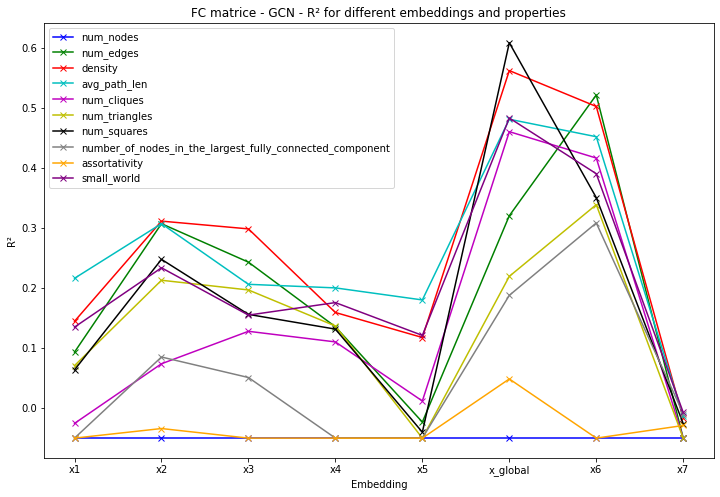

<Figure size 432x288 with 0 Axes>

In [21]:
import matplotlib.pyplot as plt

# Assuming results, embeddings, and other necessary variables are defined as in your context
property_names = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'num_cliques', 'num_triangles', 'num_squares', 'number_of_nodes_in_the_largest_fully_connected_component','assortativity', 'small_world']
embeddings_names = ['x1', 'x2', 'x3', 'x4', 'x5', 'x_global', 'x6', 'x7']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'grey', 'orange', 'purple']

plt.figure(figsize=(12, 8))

for i, property_name in enumerate(property_names):
    x_points = []
    y_points = []
    for j, embedding in enumerate(embeddings):
        name_of_embedding = embeddings_names[j]
        test_r2 = results[(name_of_embedding, property_name)][3]
        if test_r2 < -0.05:  # Handle negative R² values
            test_r2 = -0.05
        x_points.append(j)
        y_points.append(test_r2)
    
    # Plotting the line for the current property
    plt.plot(x_points, y_points, label=property_name, color=colors[i], marker='x')

plt.xticks(range(len(embeddings)), embeddings_names)
plt.xlabel('Embedding')
plt.ylabel('R²')
plt.legend()
plt.title('FC matrice - GCN - R² for different embeddings and properties')
plt.show()

#save the plot
plt.savefig('results/'+DATASET+'_'+MODEL+'_test_R2_plot.png', dpi=300, bbox_inches='tight')

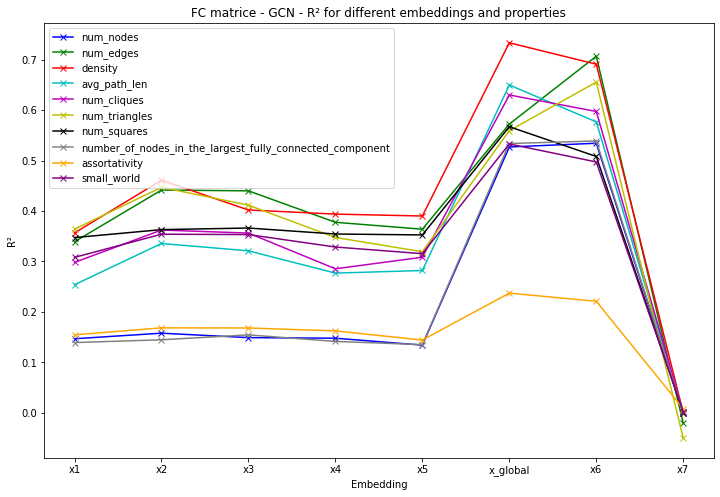

<Figure size 432x288 with 0 Axes>

In [23]:
import matplotlib.pyplot as plt

# Assuming results, embeddings, and other necessary variables are defined as in your context
property_names = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'num_cliques', 'num_triangles', 'num_squares', 'number_of_nodes_in_the_largest_fully_connected_component','assortativity', 'small_world']
embeddings_names = ['x1', 'x2', 'x3', 'x4', 'x5', 'x_global', 'x6', 'x7']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'grey', 'orange', 'purple']

plt.figure(figsize=(12, 8))

for i, property_name in enumerate(property_names):
    x_points = []
    y_points = []
    for j, embedding in enumerate(embeddings):
        name_of_embedding = embeddings_names[j]
        train_r2 = results[(name_of_embedding, property_name)][2]
        if train_r2 < -0.05:  # Handle negative R² values
            train_r2 = -0.05
        x_points.append(j)
        y_points.append(train_r2)
    
    # Plotting the line for the current property
    plt.plot(x_points, y_points, label=property_name, color=colors[i], marker='x')

plt.xticks(range(len(embeddings)), embeddings_names)
plt.xlabel('Embedding')
plt.ylabel('R²')
plt.legend()
plt.title('FC matrice - GCN - R² for different embeddings and properties')
plt.show()

#save the plot
plt.savefig('results/'+DATASET+'_'+MODEL+'_train_R2_plot.png', dpi=300, bbox_inches='tight')


# Test with new function that has limited convergence to see if it impacts the test R2

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, r2_score

#create a dictionary where we will store the results for each embeddings, each property
results = {}

ii = 0

for train_embedding, test_embedding in embeddings:
    input_size = train_embedding.shape[1]

    for i, property_name in enumerate(property_names):
        model = LinearModel(input_size, output_size)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        num_epochs = 800000  # Maximum number of epochs
        min_epochs = 1000  # Minimum number of epochs
        patience = 3000  # Number of epochs to wait for improvement
        tolerance = 1e-6  # Tolerance for considering the loss as stable

        best_loss = float('inf')
        no_improve_count = 0
        
        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()

            outputs = model(train_embedding).squeeze()
            target = train_y[:, i].squeeze()

            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            if (epoch+1) % 1000 == 0:  # Print every 1000 epochs
                print(f'Epoch [{epoch+1}/{num_epochs}], Property: {property_name}, Loss: {loss.item():.4f}')

            # Check for early stopping, but only after minimum epochs
            if epoch >= min_epochs:
                if loss.item() < best_loss - tolerance:
                    best_loss = loss.item()
                    no_improve_count = 0
                else:
                    no_improve_count += 1

                if no_improve_count >= patience:
                    print(f'Early stopping at epoch {epoch+1}')
                    break

        # Evaluate the model
        model.eval()
        with torch.no_grad():
            train_pred = model(train_embedding).squeeze().cpu().numpy()
            test_pred = model(test_embedding).squeeze().cpu().numpy()

            train_target = train_y[:, i].cpu().numpy()
            test_target = test_y[:, i].cpu().numpy()

            train_mse = mean_squared_error(train_target, train_pred)
            test_mse = mean_squared_error(test_target, test_pred)

            train_r2 = r2_score(train_target, train_pred)
            test_r2 = r2_score(test_target, test_pred)

            print(f'Embedding: {train_embedding.shape}')
            print(f'Property: {property_name}')
            print(f'  Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}')
            print(f'  Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}')

            #add the results to the dictionary
            name_of_embedding = embeddings_names[ii]
            results[(name_of_embedding, property_name)] = (train_mse, test_mse, train_r2, test_r2)

    ii += 1

#save results
with open("results/"+DATASET+"_"+MODEL+"_results_limited_cv.pkl", "wb") as f:
    pkl.dump(results, f)

In [18]:
#load results
with open("results/"+DATASET+"_"+MODEL+"_results_limited_cv.pkl", "rb") as f:
    results = pkl.load(f)

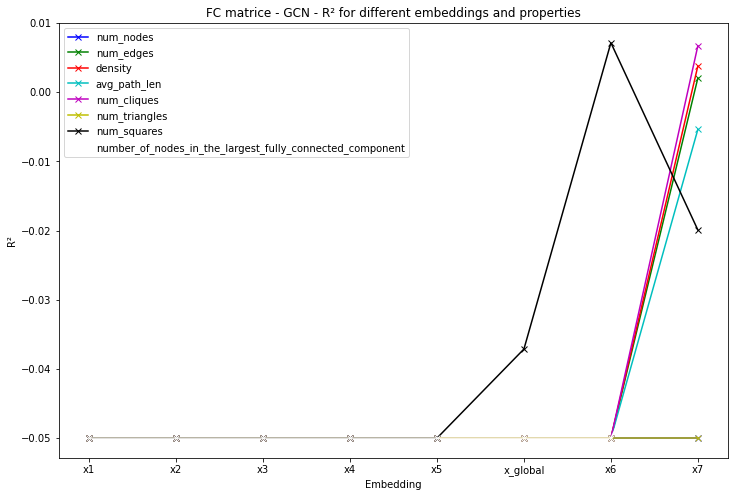

<Figure size 432x288 with 0 Axes>

In [19]:
import matplotlib.pyplot as plt

# Assuming results, embeddings, and other necessary variables are defined as in your context
property_names = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'num_cliques', 'num_triangles', 'num_squares', 'number_of_nodes_in_the_largest_fully_connected_component']
embeddings_names = ['x1', 'x2', 'x3', 'x4', 'x5', 'x_global', 'x6', 'x7']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

plt.figure(figsize=(12, 8))

for i, property_name in enumerate(property_names):
    x_points = []
    y_points = []
    for j, embedding in enumerate(embeddings):
        name_of_embedding = embeddings_names[j]
        test_r2 = results[(name_of_embedding, property_name)][3]
        if test_r2 < -0.05:  # Handle negative R² values
            test_r2 = -0.05
        x_points.append(j)
        y_points.append(test_r2)
    
    # Plotting the line for the current property
    plt.plot(x_points, y_points, label=property_name, color=colors[i], marker='x')

plt.xticks(range(len(embeddings)), embeddings_names)
plt.xlabel('Embedding')
plt.ylabel('R²')
plt.legend()
plt.title('FC matrice - GCN - R² for different embeddings and properties')
plt.show()

#save the plot
plt.savefig('results/'+DATASET+"_"+MODEL+'_test_R2_plot_limited_cv.png', dpi=300, bbox_inches='tight')

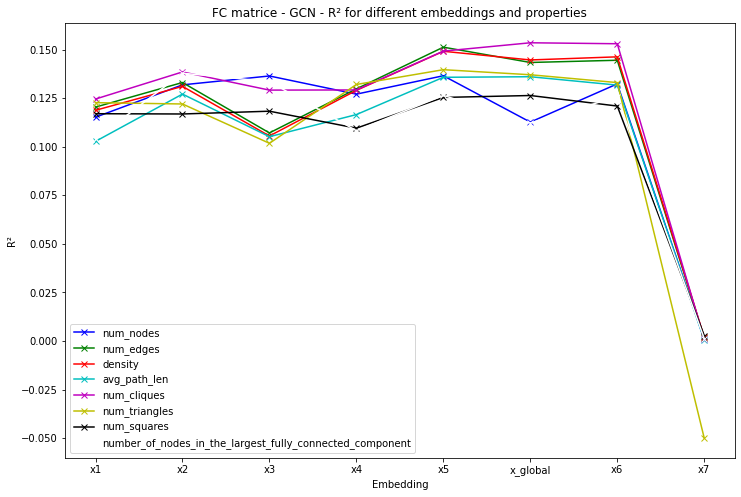

<Figure size 432x288 with 0 Axes>

In [20]:
# Assuming results, embeddings, and other necessary variables are defined as in your context
property_names = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'num_cliques', 'num_triangles', 'num_squares', 'number_of_nodes_in_the_largest_fully_connected_component']
embeddings_names = ['x1', 'x2', 'x3', 'x4', 'x5', 'x_global', 'x6', 'x7']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

plt.figure(figsize=(12, 8))

for i, property_name in enumerate(property_names):
    x_points = []
    y_points = []
    for j, embedding in enumerate(embeddings):
        name_of_embedding = embeddings_names[j]
        train_r2 = results[(name_of_embedding, property_name)][2]
        if train_r2 < -0.05:  # Handle negative R² values
            train_r2 = -0.05
        x_points.append(j)
        y_points.append(train_r2)
    
    # Plotting the line for the current property
    plt.plot(x_points, y_points, label=property_name, color=colors[i], marker='x')

plt.xticks(range(len(embeddings)), embeddings_names)
plt.xlabel('Embedding')
plt.ylabel('R²')
plt.legend()
plt.title('FC matrice - GCN - R² for different embeddings and properties')
plt.show()

#save the plot
plt.savefig('results/'+DATASET+"_"+MODEL+'_train_R2_plot_limited_cv.png', dpi=300, bbox_inches='tight')

#### Test with more properties

In [7]:
import networkx as nx
import numpy as np

def calculate_avg_path_length(G):
    if nx.is_connected(G):
        return nx.average_shortest_path_length(G)
    else:
        # Use the average path length of the largest connected component for disconnected graphs
        components = [G.subgraph(c).copy() for c in nx.connected_components(G)]
        largest_component = max(components, key=len)
        return nx.average_shortest_path_length(largest_component)
    
   
def compute_swi(graph):
    # Calculate clustering coefficient and average path length for the given graph
    clustering_coeff = nx.average_clustering(graph)
    avg_path_len = calculate_avg_path_length(graph)
    
    # Generate a random graph with the same number of nodes and edges
    num_nodes = graph.number_of_nodes()
    num_edges = graph.number_of_edges()
    random_graph = nx.gnm_random_graph(num_nodes, num_edges)
    
    # Generate a lattice graph with the same number of nodes and edges
    lattice_graph = nx.watts_strogatz_graph(num_nodes, k=4, p=0)  # Adjust k as needed
    
    # Calculate clustering coefficient and average path length for the random graph
    random_clustering_coeff = nx.average_clustering(random_graph)
    random_avg_path_len = calculate_avg_path_length(random_graph)
    
    # Calculate clustering coefficient and average path length for the lattice graph
    lattice_clustering_coeff = nx.average_clustering(lattice_graph)
    lattice_avg_path_len = calculate_avg_path_length(lattice_graph)
    
    # Compute the Small-World Index (SWI)
    swi = ((avg_path_len - lattice_avg_path_len) / (random_avg_path_len - lattice_avg_path_len)) * \
          ((clustering_coeff - random_clustering_coeff) / (lattice_clustering_coeff - random_clustering_coeff))
    
    return swi


def betweenness_centralization(G):
    n = len(G)
    betweenness = nx.betweenness_centrality(G)
    max_betweenness = max(betweenness.values())
    centralization = sum(max_betweenness - bet for bet in betweenness.values())
    if n > 2:
        centralization /= (n - 1) * (n - 2) / 2
    return centralization

def pagerank_centralization(G, alpha=0.85):
    n = len(G)
    pagerank = nx.pagerank(G, alpha=alpha)
    max_pagerank = max(pagerank.values())
    centralization = sum(max_pagerank - pr for pr in pagerank.values())
    if n > 1:
        centralization /= (n - 1)
    return centralization

def clustering_properties(G):
    average_clustering = nx.average_clustering(G)
    transitivity = nx.transitivity(G)
    return average_clustering, transitivity

def compute_graph_properties(data):
    properties = []
    for graph_data in data:
        G = nx.from_edgelist(graph_data.edge_index.t().tolist())
        
        # Number of nodes
        num_nodes = G.number_of_nodes()
        
        # Number of edges
        num_edges = G.number_of_edges()
        
        # Density
        density = nx.density(G)
        
        # Average Path Length
        avg_path_len = calculate_avg_path_length(G)
        
        # Diameter
        if nx.is_connected(G):
            diameter = nx.diameter(G)
        else:
            # Use the diameter of the largest connected component for disconnected graphs
            components = [G.subgraph(c).copy() for c in nx.connected_components(G)]
            largest_component = max(components, key=len)
            diameter = nx.diameter(largest_component)
        
        # Radius
        if nx.is_connected(G):
            radius = nx.radius(G)
        else:
            radius = nx.radius(largest_component)
        
        # Clustering Coefficient
        clustering_coeff = nx.average_clustering(G)
        
        # Transitivity
        transitivity = nx.transitivity(G)
        
        # Assortativity
        assortativity = nx.degree_assortativity_coefficient(G)
        
        # Number of Cliques
        num_cliques = len(list(nx.find_cliques(G)))
        
        # Number of Triangles
        num_triangles = sum(nx.triangles(G).values()) / 3
        
        # Number of Squares (4-cycles)
        num_squares = sum(nx.square_clustering(G).values()) / 4
        
        # Size of the Largest Connected Component
        largest_component_size = len(max(nx.connected_components(G), key=len))
        
        # Average Degree
        degrees = [d for n, d in G.degree()]
        avg_degree = np.mean(degrees)
        
        # Betweenness Centrality
        betweenness_centrality = nx.betweenness_centrality(G)
        avg_betweenness_centrality = np.mean(list(betweenness_centrality.values()))
        
        # Eigenvalues of the Adjacency Matrix (for spectral properties)
        eigenvalues = np.linalg.eigvals(nx.adjacency_matrix(G).todense())
        spectral_radius = max(eigenvalues)
        algebraic_connectivity = sorted(eigenvalues)[1]  # second smallest eigenvalue
        
        # Graph Laplacian Eigenvalues
        laplacian_eigenvalues = np.linalg.eigvals(nx.laplacian_matrix(G).todense())
        graph_energy = sum(abs(laplacian_eigenvalues))
        
        # Small-World-ness
        # Compare clustering coefficient and average path length with those of a random graph
        random_graph = nx.gnm_random_graph(num_nodes, num_edges)
        random_clustering_coeff = nx.average_clustering(random_graph)
        random_avg_path_len = calculate_avg_path_length(random_graph)
        small_world_coefficient = (clustering_coeff / random_clustering_coeff) / (avg_path_len / random_avg_path_len)

        small_world_index = compute_swi(G)

        # Calculate Betweenness Centralization
        betweenness_cent = betweenness_centralization(G)
        print(f"Betweenness Centralization: {betweenness_cent}")

        # Calculate PageRank Centralization
        pagerank_cent = pagerank_centralization(G)
        print(f"PageRank Centralization: {pagerank_cent}")

        # Calculate Clustering properties
        avg_clustering, transitivity = clustering_properties(G)
        print(f"Average Clustering Coefficient: {avg_clustering}")
        print(f"Transitivity: {transitivity}")
        
        properties.append((
            num_nodes,
            num_edges,
            density,
            avg_path_len,
            diameter,
            radius,
            clustering_coeff,
            transitivity,
            assortativity,
            num_cliques,
            num_triangles,
            num_squares,
            largest_component_size,
            avg_degree,
            avg_betweenness_centrality,
            spectral_radius,
            algebraic_connectivity,
            graph_energy,
            small_world_coefficient, 
            betweenness_cent,
            pagerank_cent,
            avg_clustering,
            small_world_index           

        ))
    return properties





In [ ]:

train_idx_list = gnn.train_idx.tolist()
selected_dataset = [gnn.dataset[i] for i in train_idx_list]
train_properties_long = compute_graph_properties(selected_dataset)
test_idx_list = gnn.test_idx.tolist()
selected_dataset = [gnn.dataset[i] for i in test_idx_list]
test_properties_long = compute_graph_properties(selected_dataset)

#save the properties in a file
with open("results/"+DATASET+"_"+MODEL+"_train_properties_long.pkl", "wb") as f:
    pkl.dump(train_properties_long, f)

with open("results/"+DATASET+"_"+MODEL+"_test_properties_long.pkl", "wb") as f:
    pkl.dump(test_properties_long, f)

In [ ]:
#load the properties
with open("results/"+DATASET+"_"+MODEL+"_train_properties_long.pkl", "rb") as f:
    train_properties_long = pkl.load(f)

with open("results/"+DATASET+"_"+MODEL+"_test_properties_long.pkl", "rb") as f:
    test_properties_long = pkl.load(f)

In [ ]:
#print the names of the properties
# print(train_properties_long[0].keys())

#print the first element of the properties
# print(train_properties_long[0])

#copare train_properties and train_properties_long
print(train_properties[0])
print(train_properties_long[0])
print(len(train_properties_long))

In [ ]:
property_names_long = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'diameter', 'radius', 'clustering_coeff', 'transitivity', 'assortativity', 'num_cliques', 'num_triangles', 'num_squares', 'largest_component_size', 'avg_degree', 'avg_betweenness_centrality', 'spectral_radius', 'algebraic_connectivity', 'graph_energy', 'small_world_coefficient', 'betweenness_cent', 'pagerank_cent', 'avg_clustering', 'small_world_index']
train_y_long = torch.tensor(train_properties_long, dtype=torch.float32)
test_y_long = torch.tensor(test_properties_long, dtype=torch.float32)
#create a dictionary where we will store the results for each embeddings, each property
results = {}

ii = 0

for train_embedding, test_embedding in embeddings:
    input_size = train_embedding.shape[1]

    for i, property_name in enumerate(property_names_long):
        model = LinearModel(input_size, output_size)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        num_epochs = 800000  # Maximum number of epochs
        min_epochs = 1000  # Minimum number of epochs
        patience = 3000  # Number of epochs to wait for improvement
        tolerance = 1e-6  # Tolerance for considering the loss as stable

        best_loss = float('inf')
        no_improve_count = 0
        
        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()

            outputs = model(train_embedding).squeeze()
            target = train_y_long[:, i].squeeze()

            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            if (epoch+1) % 1000 == 0:  # Print every 1000 epochs
                print(f'Epoch [{epoch+1}/{num_epochs}], Property: {property_name}, Loss: {loss.item():.4f}')

            # Check for early stopping, but only after minimum epochs
            if epoch >= min_epochs:
                if loss.item() < best_loss - tolerance:
                    best_loss = loss.item()
                    no_improve_count = 0
                else:
                    no_improve_count += 1

                if no_improve_count >= patience:
                    print(f'Early stopping at epoch {epoch+1}')
                    break

        # Evaluate the model
        model.eval()
        with torch.no_grad():
            train_pred = model(train_embedding).squeeze().cpu().numpy()
            test_pred = model(test_embedding).squeeze().cpu().numpy()

            train_target = train_y_long[:, i].cpu().numpy()
            test_target = test_y_long[:, i].cpu().numpy()

            train_mse = mean_squared_error(train_target, train_pred)
            test_mse = mean_squared_error(test_target, test_pred)

            train_r2 = r2_score(train_target, train_pred)
            test_r2 = r2_score(test_target, test_pred)

            print(f'Embedding: {train_embedding.shape}')
            print(f'Property: {property_name}')
            print(f'  Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}')
            print(f'  Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}')

            #add the results to the dictionary
            name_of_embedding = embeddings_names[ii]
            results[(name_of_embedding, property_name)] = (train_mse, test_mse, train_r2, test_r2)

    ii += 1

#save results
with open("results/"+DATASET+"_"+MODEL+"_results_limited_cv_long.pkl", "wb") as f:
    pkl.dump(results, f)

In [ ]:
#load results
with open("results/"+DATASET+"_"+MODEL+"_results_limited_cv_long.pkl", "rb") as f:
    results = pkl.load(f)

In [ ]:
#import plt
import matplotlib.pyplot as plt
property_names_long = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'diameter', 'radius', 'clustering_coeff', 'transitivity', 'assortativity', 'num_cliques', 'num_triangles', 'num_squares', 'largest_component_size', 'avg_degree', 'avg_betweenness_centrality', 'spectral_radius', 'algebraic_connectivity', 'graph_energy', 'small_world_coefficient', 'betweenness_cent', 'pagerank_cent', 'avg_clustering', 'small_world_index']
embeddings_names = ['x1', 'x2', 'x3', 'x4', 'x5', 'x_global', 'x6', 'x7']
#make a color list for the properties names but with different colors
colors_long = [
    (0.0, 0.45, 0.70),  # Blue
    (0.85, 0.37, 0.01),  # Orange
    (0.8, 0.47, 0.74),   # Magenta
    (0.0, 0.62, 0.45),   # Green
    (0.95, 0.90, 0.25),  # Yellow
    (0.9, 0.6, 0.0),     # Brown
    (0.35, 0.7, 0.9),    # Sky Blue
    (0.8, 0.6, 0.7),     # Light Pink
    (0.3, 0.3, 0.3),     # Dark Gray
    (0.5, 0.5, 0.0),     # Olive
    (0.0, 0.75, 0.75),   # Cyan
    (0.6, 0.6, 0.6),     # Light Gray
    (0.7, 0.3, 0.1),     # Dark Orange
    (0.6, 0.2, 0.5),     # Purple
    (0.9, 0.4, 0.3),     # Salmon
    (0.4, 0.4, 0.8),     # Light Blue
    (0.2, 0.8, 0.2),     # Light Green
    (0.6, 0.6, 0.3),     # Mustard
    (0.3, 0.55, 0.55)    # Teal
    (0.8, 0.5, 0.2),     # Dark Salmon
    (0.5, 0.5, 0.5),     # Gray
    (0.2, 0.2, 0.2)      # Black-Gray
    (0.0, 0.0, 0.0)      # Black
]
plt.figure(figsize=(12, 8))

for i, property_names_long in enumerate(property_names_long):
    x_points = []
    y_points = []
    for j, embedding in enumerate(embeddings):
        name_of_embedding = embeddings_names[j]
        test_r2 = results[(name_of_embedding, property_names_long)][3]
        if test_r2 < -0.05:  # Handle negative R² values
            test_r2 = -0.05
        x_points.append(j)
        y_points.append(test_r2)
    
    # Plotting the line for the current property
    plt.plot(x_points, y_points, label=property_names_long, color=colors_long[i], marker='x')

plt.xticks(range(len(embeddings)), embeddings_names)
plt.xlabel('Embedding')
plt.ylabel('R²')
plt.legend()
plt.title('FC matrice - GCN - R² for different embeddings and properties')
plt.show()

#save the plot
plt.savefig('results/'+DATASET+"_"+MODEL+'_test_R2_plot_limited_cv_long.png', dpi=300, bbox_inches='tight')

In [ ]:
plt.figure(figsize=(12, 8))

for i, property_names_long in enumerate(property_names_long):
    x_points = []
    y_points = []
    for j, embedding in enumerate(embeddings):
        name_of_embedding = embeddings_names[j]
        train_r2 = results[(name_of_embedding, property_names_long)][2]
        if train_r2 < -0.05:  # Handle negative R² values
            train_r2 = -0.05
        x_points.append(j)
        y_points.append(train_r2)

    # Plotting the line for the current property
    plt.plot(x_points, y_points, label=property_names_long, color=colors_long[i], marker='x')

plt.xticks(range(len(embeddings)), embeddings_names)
plt.xlabel('Embedding')
plt.ylabel('R²')
plt.legend()
plt.title('FC matrice - GCN - R² for different embeddings and properties')
plt.show()

#save the plot
plt.savefig('results/'+DATASET+"_"+MODEL+'_train_R2_plot_limited_cv_long.png', dpi=300, bbox_inches='tight')
    

### comparison with a gnn train on random (the y are shuffled)

In [1]:
from Datasets.FC.create_dataset import read_dataset
dataset = read_dataset()
MODEL = "GCN_w_edge_weight"
DATASET = "FC_suffled"

from models.models_FC import GCN_framework_wo_edge_weight as framework # import the model

gnn = framework(dataset)

print(gnn.model)
print(gnn.train_idx)

Net(
  (conv_layers): ModuleList(
    (0): GCNConv(116, 128)
    (1): GCNConv(128, 128)
    (2): GCNConv(128, 128)
    (3): GCNConv(128, 128)
    (4): GCNConv(128, 128)
  )
  (batch_norms): ModuleList(
    (0): BatchNorm(128)
    (1): BatchNorm(128)
    (2): BatchNorm(128)
    (3): BatchNorm(128)
    (4): BatchNorm(128)
  )
  (lin1): Linear(128, 128, bias=True)
  (lin2): Linear(128, 2, bias=True)
  (bn1): BatchNorm(128)
  (bn2): BatchNorm(2)
)
tensor([217, 137, 426,  ..., 643, 205, 434])


/home/tpelletreaudur/.local/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [2]:
#shuffle the y values of the dataset
# import numpy as np
# import torch

# y = np.array([data.y for data in dataset])
# y = np.array(y, dtype=np.int64)  # Ensure y is a numeric array of type int64

# np.random.shuffle(y)

# #make y torch.int64, tensor([0]) instead of [0]
# y = torch.tensor(y, dtype=torch.int64)

# for i in range(len(dataset)):
#     dataset[i].y = y[i]

/scratch-local/tpelletreaudur.7490421/ipykernel_2436077/1638111602.py:5: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  y = np.array([data.y for data in dataset])
/scratch-local/tpelletreaudur.7490421/ipykernel_2436077/1638111602.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y = np.array([data.y for data in dataset])


In [2]:
#save the dataset
# import pickle as pkl
# with open("Datasets/FC/"+DATASET+"_"+MODEL+".pkl", "wb") as f:
#     pkl.dump(dataset, f)

#load the dataset
import pickle as pkl
with open("Datasets/FC/"+DATASET+"_"+MODEL+".pkl", "rb") as f:
    dataset = pkl.load(f)

In [4]:
# gnn.iterate()

/home/tpelletreaudur/.local/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 020, Loss: 0.124, Test Loss: 0.834, Train Acc: 0.999 Test Acc: 0.436
Epoch: 040, Loss: 0.112, Test Loss: 0.848, Train Acc: 0.999 Test Acc: 0.473
Epoch: 060, Loss: 0.105, Test Loss: 0.856, Train Acc: 0.999 Test Acc: 0.455
Epoch: 080, Loss: 0.100, Test Loss: 0.860, Train Acc: 0.999 Test Acc: 0.455
Epoch: 100, Loss: 0.096, Test Loss: 0.865, Train Acc: 0.999 Test Acc: 0.455
Epoch: 120, Loss: 0.094, Test Loss: 0.868, Train Acc: 0.999 Test Acc: 0.473
Epoch: 140, Loss: 0.092, Test Loss: 0.870, Train Acc: 0.999 Test Acc: 0.473
Epoch: 160, Loss: 0.091, Test Loss: 0.872, Train Acc: 0.999 Test Acc: 0.473
Epoch: 180, Loss: 0.090, Test Loss: 0.874, Train Acc: 0.999 Test Acc: 0.473
Epoch: 200, Loss: 0.089, Test Loss: 0.875, Train Acc: 0.999 Test Acc: 0.473
Epoch: 220, Loss: 0.089, Test Loss: 0.875, Train Acc: 0.999 Test Acc: 0.473
Epoch: 240, Loss: 0.088, Test Loss: 0.876, Train Acc: 0.999 Test Acc: 0.473
Epoch: 260, Loss: 0.088, Test Loss: 0.876, Train Acc: 0.999 Test Acc: 0.473
Epoch: 280, 

In [8]:
#save the model 
# gnn.save_model(path="models/"+DATASET+"_"+MODEL+".pt")

Model saved in: models/FC_suffled_GCN_w_edge_weight.pt


In [3]:
#load the model
gnn.load_model(path="models/"+DATASET+"_"+MODEL+".pt")

In [4]:
gnn.evaluate()

Test Loss: 1.085, Train Acc: 0.533 Test Acc: 0.455


In [5]:
train_features, test_features = gnn.evaluate_with_features2()

In [8]:
train_idx_list = gnn.train_idx.tolist()
selected_dataset = [gnn.dataset[i] for i in train_idx_list]
train_properties_long = compute_graph_properties(selected_dataset)
test_idx_list = gnn.test_idx.tolist()
selected_dataset = [gnn.dataset[i] for i in test_idx_list]
test_properties_long = compute_graph_properties(selected_dataset)

#save the properties in a file
with open("results/"+DATASET+"_"+MODEL+"_train_properties_long.pkl", "wb") as f:
    pkl.dump(train_properties_long, f)

with open("results/"+DATASET+"_"+MODEL+"_test_properties_long.pkl", "wb") as f:
    pkl.dump(test_properties_long, f)

Betweenness Centralization: 0.001086061741981193
PageRank Centralization: 0.009889108225082894
Average Clustering Coefficient: 0.5179222969842621
Transitivity: 0.5032389055399787
Betweenness Centralization: 0.0018289913557221417
PageRank Centralization: 0.006459017297712483
Average Clustering Coefficient: 0.5087813738549032
Transitivity: 0.5213549337260678
Betweenness Centralization: 0.00045402843483595716
PageRank Centralization: 0.005046367337979484
Average Clustering Coefficient: 0.5414121000696618
Transitivity: 0.5641200188511285
Betweenness Centralization: 0.0010550665108438862
PageRank Centralization: 0.006308393987013973
Average Clustering Coefficient: 0.6576803843183981
Transitivity: 0.6348624992240363
Betweenness Centralization: 0.001264968108251676
PageRank Centralization: 0.007700201326596413
Average Clustering Coefficient: 0.4949392448885353
Transitivity: 0.5178428227746592
Betweenness Centralization: 0.0018431551231994504
PageRank Centralization: 0.009662184686628855
Avera

Betweenness Centralization: 0.004258771004745923
PageRank Centralization: 0.009026828039776977
Average Clustering Coefficient: 0.5324696244214352
Transitivity: 0.5881116781747223
Betweenness Centralization: 0.002249934020676841
PageRank Centralization: 0.006958093193469958
Average Clustering Coefficient: 0.5176604904495603
Transitivity: 0.5891551584077985
Betweenness Centralization: 0.0038523338856805292
PageRank Centralization: 0.009673819947146852
Average Clustering Coefficient: 0.39826718735809646
Transitivity: 0.5340035481963336
Betweenness Centralization: 0.0009415571619398711
PageRank Centralization: 0.006841847000195802
Average Clustering Coefficient: 0.441488221549468
Transitivity: 0.4850266397207422
Betweenness Centralization: 0.001708176235729968
PageRank Centralization: 0.006499278216215807
Average Clustering Coefficient: 0.5792587107642506
Transitivity: 0.6022845275181724
Betweenness Centralization: 0.0013510997350773552
PageRank Centralization: 0.008786855049144855
Average

Betweenness Centralization: 0.0019646400406334924
PageRank Centralization: 0.009815187832223564
Average Clustering Coefficient: 0.44459521282175735
Transitivity: 0.4245038826574633
Betweenness Centralization: 0.0022671691216563806
PageRank Centralization: 0.007768459025854732
Average Clustering Coefficient: 0.577849554876937
Transitivity: 0.5667556742323098
Betweenness Centralization: 0.001454267042670509
PageRank Centralization: 0.006001335474472275
Average Clustering Coefficient: 0.5460483818540083
Transitivity: 0.5746121297602257
Betweenness Centralization: 0.0014496068652510448
PageRank Centralization: 0.008681186183223458
Average Clustering Coefficient: 0.5584861537502397
Transitivity: 0.5778382053025153
Betweenness Centralization: 0.002007966387081847
PageRank Centralization: 0.006671939099817724
Average Clustering Coefficient: 0.48545362139991277
Transitivity: 0.5018324607329843
Betweenness Centralization: 0.0017584473673798293
PageRank Centralization: 0.0073635679264833975
Aver

PageRank Centralization: 0.011004399543414627
Average Clustering Coefficient: 0.4854814340218046
Transitivity: 0.4893560404470463
Betweenness Centralization: 0.0027119481097196917
PageRank Centralization: 0.007852615374744727
Average Clustering Coefficient: 0.5428112510914471
Transitivity: 0.5493345571363011
Betweenness Centralization: 0.0009129282512773135
PageRank Centralization: 0.006697696068120426
Average Clustering Coefficient: 0.5043614512796099
Transitivity: 0.5077755240027045
Betweenness Centralization: 0.0017956453412381632
PageRank Centralization: 0.009108386013990149
Average Clustering Coefficient: 0.5332475819111081
Transitivity: 0.5324466865397844
Betweenness Centralization: 0.0014673091251938282
PageRank Centralization: 0.010418666312293743
Average Clustering Coefficient: 0.45601639118218884
Transitivity: 0.4508833922261484
Betweenness Centralization: 0.001344188359494869
PageRank Centralization: 0.009310369122357299
Average Clustering Coefficient: 0.5394155159259717
Tra

Betweenness Centralization: 0.0015358865503090416
PageRank Centralization: 0.008083734996704912
Average Clustering Coefficient: 0.49142522439197645
Transitivity: 0.4912559618441971
Betweenness Centralization: 0.0014614971031362304
PageRank Centralization: 0.006832784683340629
Average Clustering Coefficient: 0.5006335554710165
Transitivity: 0.4737650371128743
Betweenness Centralization: 0.0030607172896678944
PageRank Centralization: 0.00747488219880637
Average Clustering Coefficient: 0.551372570399119
Transitivity: 0.6035196687370601
Betweenness Centralization: 0.0018904785148743163
PageRank Centralization: 0.008244167735453955
Average Clustering Coefficient: 0.4937877510139175
Transitivity: 0.47336531178995206
Betweenness Centralization: 0.0005971837392109634
PageRank Centralization: 0.006703150237079214
Average Clustering Coefficient: 0.4771392380310655
Transitivity: 0.5351647396331392
Betweenness Centralization: 0.002080298906700507
PageRank Centralization: 0.008982191184123335
Avera

Betweenness Centralization: 0.0015200004379776683
PageRank Centralization: 0.006470081241039484
Average Clustering Coefficient: 0.6031669755427123
Transitivity: 0.6513464526152253
Betweenness Centralization: 0.0018130422210154533
PageRank Centralization: 0.005157848707737996
Average Clustering Coefficient: 0.5149069321483113
Transitivity: 0.5604558969276512
Betweenness Centralization: 0.0006455590906807535
PageRank Centralization: 0.00616522977321775
Average Clustering Coefficient: 0.4781515197997262
Transitivity: 0.5141950273320403
Betweenness Centralization: 0.0018203673654359255
PageRank Centralization: 0.007147031697340111
Average Clustering Coefficient: 0.4969713912411682
Transitivity: 0.4693569270608546
Betweenness Centralization: 0.0016494146200354827
PageRank Centralization: 0.007833006151079805
Average Clustering Coefficient: 0.5417520622019766
Transitivity: 0.5177895533686601
Betweenness Centralization: 0.0016024607162301034
PageRank Centralization: 0.008011892746391053
Avera

Betweenness Centralization: 0.0016727926006398239
PageRank Centralization: 0.007130051843017557
Average Clustering Coefficient: 0.5039580283314299
Transitivity: 0.46647074539139727
Betweenness Centralization: 0.001592633041423766
PageRank Centralization: 0.009374280747694832
Average Clustering Coefficient: 0.49013791250823097
Transitivity: 0.5039941902687001
Betweenness Centralization: 0.0019990607092797534
PageRank Centralization: 0.009086038752596925
Average Clustering Coefficient: 0.4834517458282435
Transitivity: 0.553635474404956
Betweenness Centralization: 0.0012574010986898252
PageRank Centralization: 0.0070333742764222065
Average Clustering Coefficient: 0.44748232018052975
Transitivity: 0.45867768595041325
Betweenness Centralization: 0.0019304196654361069
PageRank Centralization: 0.008855875161050865
Average Clustering Coefficient: 0.49138375288223146
Transitivity: 0.4895833333333333
Betweenness Centralization: 0.0017669554093425939
PageRank Centralization: 0.007219000002810857


Betweenness Centralization: 0.0018495345019569982
PageRank Centralization: 0.007231102554179702
Average Clustering Coefficient: 0.4830656598303658
Transitivity: 0.5034535686876439
Betweenness Centralization: 0.0015748727935459752
PageRank Centralization: 0.007981320925282734
Average Clustering Coefficient: 0.5212184008091936
Transitivity: 0.5882352941176471
Betweenness Centralization: 0.0016211757148801684
PageRank Centralization: 0.011867452767276
Average Clustering Coefficient: 0.41886804835721253
Transitivity: 0.46268163804491413
Betweenness Centralization: 0.0017726197089032534
PageRank Centralization: 0.0057720408657632935
Average Clustering Coefficient: 0.5476128676119623
Transitivity: 0.5542057308860425
Betweenness Centralization: 0.0017956013103569701
PageRank Centralization: 0.00992834227923277
Average Clustering Coefficient: 0.4978453976737729
Transitivity: 0.5060670949321913
Betweenness Centralization: 0.0029431207085140907
PageRank Centralization: 0.007500776793950888
Avera

Betweenness Centralization: 0.0015345612953758237
PageRank Centralization: 0.00640345146968126
Average Clustering Coefficient: 0.5095312733243768
Transitivity: 0.4897482481183493
Betweenness Centralization: 0.001936943554753576
PageRank Centralization: 0.008054075640284503
Average Clustering Coefficient: 0.5168454423505751
Transitivity: 0.555079559363525
Betweenness Centralization: 0.00103623867046775
PageRank Centralization: 0.00796726535299168
Average Clustering Coefficient: 0.4711529801467881
Transitivity: 0.5036107943747624
Betweenness Centralization: 0.0006421228714372103
PageRank Centralization: 0.006547220929718533
Average Clustering Coefficient: 0.5210329653446675
Transitivity: 0.5526440410418311
Betweenness Centralization: 0.0022303841592928694
PageRank Centralization: 0.009727279175440692
Average Clustering Coefficient: 0.6153324922737486
Transitivity: 0.6393103448275862
Betweenness Centralization: 0.0012331573811127647
PageRank Centralization: 0.009096088071027015
Average Cl

Betweenness Centralization: 0.0020047217453140484
PageRank Centralization: 0.006941542022416571
Average Clustering Coefficient: 0.5519625677734799
Transitivity: 0.5649628783552256
Betweenness Centralization: 0.0016618427655790786
PageRank Centralization: 0.011658944035218088
Average Clustering Coefficient: 0.46323255288772514
Transitivity: 0.4585430463576159
Betweenness Centralization: 0.0013568976497225782
PageRank Centralization: 0.007852949061876299
Average Clustering Coefficient: 0.5269722322740896
Transitivity: 0.48033946251768034
Betweenness Centralization: 0.0018043381772499792
PageRank Centralization: 0.006687627140011902
Average Clustering Coefficient: 0.6005786255445925
Transitivity: 0.6189836579359749
Betweenness Centralization: 0.0016874067762550347
PageRank Centralization: 0.00756481856398947
Average Clustering Coefficient: 0.4601165850151652
Transitivity: 0.5204013377926422
Betweenness Centralization: 0.0015758687388136778
PageRank Centralization: 0.008527095347658034
Ave

Betweenness Centralization: 0.002166448466977857
PageRank Centralization: 0.012363938786993142
Average Clustering Coefficient: 0.4499598841704104
Transitivity: 0.5199034981905911
Betweenness Centralization: 0.001476779209203863
PageRank Centralization: 0.009662409178433053
Average Clustering Coefficient: 0.5139705497320518
Transitivity: 0.5343243243243243
Betweenness Centralization: 0.0009467499795467532
PageRank Centralization: 0.007364803466579613
Average Clustering Coefficient: 0.4963897469415515
Transitivity: 0.490768094534712
Betweenness Centralization: 0.0035709011754109427
PageRank Centralization: 0.00891081020811883
Average Clustering Coefficient: 0.4804955622293085
Transitivity: 0.5050970075633016
Betweenness Centralization: 0.0018024012079577015
PageRank Centralization: 0.006656257847392205
Average Clustering Coefficient: 0.464207821164343
Transitivity: 0.5469924812030075
Betweenness Centralization: 0.002915486164353885
PageRank Centralization: 0.008879591382603058
Average Cl

Betweenness Centralization: 0.002188966892401363
PageRank Centralization: 0.00802733408806463
Average Clustering Coefficient: 0.656045504344068
Transitivity: 0.7279994133176885
Betweenness Centralization: 0.0010670810856481037
PageRank Centralization: 0.005905916061330542
Average Clustering Coefficient: 0.5033906376738927
Transitivity: 0.5243520721171905
Betweenness Centralization: 0.0018235079791928334
PageRank Centralization: 0.005867179288039859
Average Clustering Coefficient: 0.5370765869244573
Transitivity: 0.6867549668874172
Betweenness Centralization: 0.0017345548870816641
PageRank Centralization: 0.008204686451480954
Average Clustering Coefficient: 0.47970082655681023
Transitivity: 0.4447646493756004
Betweenness Centralization: 0.00250580808197654
PageRank Centralization: 0.007212686835546926
Average Clustering Coefficient: 0.5678326547917583
Transitivity: 0.6132723112128147
Betweenness Centralization: 0.0008269175533117747
PageRank Centralization: 0.0068132030591250186
Average

Betweenness Centralization: 0.0006602760967636381
PageRank Centralization: 0.006693242762558686
Average Clustering Coefficient: 0.48387928838860894
Transitivity: 0.47266187050359715
Betweenness Centralization: 0.0010782291100841493
PageRank Centralization: 0.005682465079451831
Average Clustering Coefficient: 0.464354553828238
Transitivity: 0.45079212674027846
Betweenness Centralization: 0.0012766992639819798
PageRank Centralization: 0.006087697078168115
Average Clustering Coefficient: 0.5834889804710776
Transitivity: 0.5533357117374242
Betweenness Centralization: 0.005368328038112794
PageRank Centralization: 0.00905071818722414
Average Clustering Coefficient: 0.46943647915870124
Transitivity: 0.5007407407407407
Betweenness Centralization: 0.0016796192371994472
PageRank Centralization: 0.008132492231621349
Average Clustering Coefficient: 0.529164389813477
Transitivity: 0.49911691981631934
Betweenness Centralization: 0.0018505558982255148
PageRank Centralization: 0.008386420393863553
Ave

Betweenness Centralization: 0.0009683602352623171
PageRank Centralization: 0.007370280011349335
Average Clustering Coefficient: 0.5537317091534062
Transitivity: 0.5552259776754351
Betweenness Centralization: 0.001535782080175506
PageRank Centralization: 0.007192898491409675
Average Clustering Coefficient: 0.4778548080272217
Transitivity: 0.49097938144329895
Betweenness Centralization: 0.0022431309544469875
PageRank Centralization: 0.006179704601955734
Average Clustering Coefficient: 0.45040954782642767
Transitivity: 0.5249758298420883
Betweenness Centralization: 0.0014274215640062023
PageRank Centralization: 0.007139357880555097
Average Clustering Coefficient: 0.5462399240918535
Transitivity: 0.5782921610581598
Betweenness Centralization: 0.0016129218128364741
PageRank Centralization: 0.005492282003335041
Average Clustering Coefficient: 0.5642525817094781
Transitivity: 0.5815024805102764
Betweenness Centralization: 0.0026928102128250704
PageRank Centralization: 0.010681684835313166
Ave

Betweenness Centralization: 0.001303938696969281
PageRank Centralization: 0.009908694404709444
Average Clustering Coefficient: 0.5500077757679607
Transitivity: 0.5341294612566155
Betweenness Centralization: 0.0009136370130163846
PageRank Centralization: 0.00611774754127568
Average Clustering Coefficient: 0.4800014879015627
Transitivity: 0.44190871369294604
Betweenness Centralization: 0.0015030258061776403
PageRank Centralization: 0.007073253624292686
Average Clustering Coefficient: 0.5709282159345568
Transitivity: 0.5690107419435424
Betweenness Centralization: 0.0015750738938637061
PageRank Centralization: 0.007427084239773628
Average Clustering Coefficient: 0.4646922567120441
Transitivity: 0.4879182156133829
Betweenness Centralization: 0.0012033971813378128
PageRank Centralization: 0.0059348948190293405
Average Clustering Coefficient: 0.5084880396639765
Transitivity: 0.5445321307779031
Betweenness Centralization: 0.0016484739029092386
PageRank Centralization: 0.009148611984206462
Aver

Betweenness Centralization: 0.0017329313552089665
PageRank Centralization: 0.0076175490600685885
Average Clustering Coefficient: 0.5564679425587247
Transitivity: 0.5620879120879121
Betweenness Centralization: 0.0010140272116990153
PageRank Centralization: 0.0077963161632797874
Average Clustering Coefficient: 0.4481297213041633
Transitivity: 0.4511023176936122
Betweenness Centralization: 0.001517288134850202
PageRank Centralization: 0.007182109183010908
Average Clustering Coefficient: 0.49532595953742004
Transitivity: 0.5301724137931034
Betweenness Centralization: 0.001179786648461483
PageRank Centralization: 0.00924624445310264
Average Clustering Coefficient: 0.47670273243903616
Transitivity: 0.5226229508196721
Betweenness Centralization: 0.002184119259521994
PageRank Centralization: 0.006629867243140498
Average Clustering Coefficient: 0.4143278460669765
Transitivity: 0.4796650717703349
Betweenness Centralization: 0.002605643202483183
PageRank Centralization: 0.008537183819772344
Avera

Betweenness Centralization: 0.0025345060416363664
PageRank Centralization: 0.008565939945849413
Average Clustering Coefficient: 0.5536799761035307
Transitivity: 0.5409591897527555
Betweenness Centralization: 0.0015939182136400058
PageRank Centralization: 0.006434630666299032
Average Clustering Coefficient: 0.5121558919366863
Transitivity: 0.5201176313327095
Betweenness Centralization: 0.002117035054150758
PageRank Centralization: 0.007880180592535903
Average Clustering Coefficient: 0.5242397169927328
Transitivity: 0.5095647708306587
Betweenness Centralization: 0.0024555874603294945
PageRank Centralization: 0.008788503396979798
Average Clustering Coefficient: 0.4827920147485363
Transitivity: 0.5101342458541721
Betweenness Centralization: 0.0008740635230066906
PageRank Centralization: 0.006237101811494439
Average Clustering Coefficient: 0.539177416999715
Transitivity: 0.5696276751685723
Betweenness Centralization: 0.004390691191276613
PageRank Centralization: 0.00888217500036754
Average 

Betweenness Centralization: 0.0029526085050685554
PageRank Centralization: 0.007843636044936125
Average Clustering Coefficient: 0.4617532708837058
Transitivity: 0.4855555555555556
Betweenness Centralization: 0.0009769843605539534
PageRank Centralization: 0.008182056482163979
Average Clustering Coefficient: 0.5563079302965765
Transitivity: 0.5505062978513213
Betweenness Centralization: 0.0009910484466696867
PageRank Centralization: 0.007755677286721366
Average Clustering Coefficient: 0.47503387617151377
Transitivity: 0.4823232323232323
Betweenness Centralization: 0.0015186181872339469
PageRank Centralization: 0.008957104164054487
Average Clustering Coefficient: 0.4111342934351784
Transitivity: 0.4396436525612472
Betweenness Centralization: 0.000946904100364308
PageRank Centralization: 0.005965014541061421
Average Clustering Coefficient: 0.5436630490201664
Transitivity: 0.5596886803250544
Betweenness Centralization: 0.002115424238880284
PageRank Centralization: 0.009981934017454716
Avera

Betweenness Centralization: 0.0009325307002592923
PageRank Centralization: 0.006712453568058718
Average Clustering Coefficient: 0.45526297076932565
Transitivity: 0.47695075331684283
Betweenness Centralization: 0.0024375034041026014
PageRank Centralization: 0.009986899313524077
Average Clustering Coefficient: 0.4999390540719143
Transitivity: 0.5071368597816961
Betweenness Centralization: 0.0017549663565480335
PageRank Centralization: 0.0073925039206302915
Average Clustering Coefficient: 0.523273777879041
Transitivity: 0.49780775716694775
Betweenness Centralization: 0.0007539887640119349
PageRank Centralization: 0.007503926147592013
Average Clustering Coefficient: 0.48482714499715657
Transitivity: 0.4911732541790345
Betweenness Centralization: 0.0008680242720428117
PageRank Centralization: 0.008025651765772275
Average Clustering Coefficient: 0.4645239217341789
Transitivity: 0.48102643856920685
Betweenness Centralization: 0.0015210866819177985
PageRank Centralization: 0.007171731470552725

Betweenness Centralization: 0.001167216676452378
PageRank Centralization: 0.008095152673285878
Average Clustering Coefficient: 0.5044882033636496
Transitivity: 0.549078947368421
Betweenness Centralization: 0.0007104806259602472
PageRank Centralization: 0.0065801044901698
Average Clustering Coefficient: 0.5179017175446766
Transitivity: 0.539419484624964
Betweenness Centralization: 0.0014667879290022657
PageRank Centralization: 0.00733369343176361
Average Clustering Coefficient: 0.4231840284471864
Transitivity: 0.4444444444444444
Betweenness Centralization: 0.0010563725268017924
PageRank Centralization: 0.005972016159085246
Average Clustering Coefficient: 0.39276554363510885
Transitivity: 0.4111066719936077
Betweenness Centralization: 0.001344379660673526
PageRank Centralization: 0.006430121618631281
Average Clustering Coefficient: 0.532396333277665
Transitivity: 0.6209009009009009
Betweenness Centralization: 0.0014063380167544308
PageRank Centralization: 0.007603666119484385
Average Clu

Betweenness Centralization: 0.0019827908448264596
PageRank Centralization: 0.00787793940419568
Average Clustering Coefficient: 0.5213484780277082
Transitivity: 0.5637853201805718
Betweenness Centralization: 0.0027637278098189264
PageRank Centralization: 0.008855345662956872
Average Clustering Coefficient: 0.5817621190299209
Transitivity: 0.6480901690670007
Betweenness Centralization: 0.002733060160500094
PageRank Centralization: 0.008170649537504883
Average Clustering Coefficient: 0.482852123587087
Transitivity: 0.5427423981640849
Betweenness Centralization: 0.0013959119193162341
PageRank Centralization: 0.005395707412499384
Average Clustering Coefficient: 0.504624688473573
Transitivity: 0.5092336103416436
Betweenness Centralization: 0.0026711976152805775
PageRank Centralization: 0.008107131712314844
Average Clustering Coefficient: 0.5103907194871484
Transitivity: 0.5218670327515199
Betweenness Centralization: 0.0019979433026104253
PageRank Centralization: 0.006515322950923503
Average 

Betweenness Centralization: 0.002039805687773911
PageRank Centralization: 0.009752356536237633
Average Clustering Coefficient: 0.5900031517552133
Transitivity: 0.6484804977267289
Betweenness Centralization: 0.0021213743229619242
PageRank Centralization: 0.007179925832024679
Average Clustering Coefficient: 0.5051052547709696
Transitivity: 0.6038543897216274
Betweenness Centralization: 0.0022190007242275504
PageRank Centralization: 0.006726658823897593
Average Clustering Coefficient: 0.5517742381072421
Transitivity: 0.6525180681427096
Betweenness Centralization: 0.002688597541798648
PageRank Centralization: 0.00942105812219985
Average Clustering Coefficient: 0.4659134447927553
Transitivity: 0.44532409698169223
Betweenness Centralization: 0.0008405565655393671
PageRank Centralization: 0.005618805458223556
Average Clustering Coefficient: 0.5091641303917225
Transitivity: 0.496783039763738
Betweenness Centralization: 0.0022042406006814387
PageRank Centralization: 0.0068138978147756326
Averag

Betweenness Centralization: 0.0043869326505629564
PageRank Centralization: 0.010001204782289113
Average Clustering Coefficient: 0.5832852071127747
Transitivity: 0.6353080102342059
Betweenness Centralization: 0.0011765906220133967
PageRank Centralization: 0.010977766138834798
Average Clustering Coefficient: 0.42001319271207554
Transitivity: 0.47163695299837927
Betweenness Centralization: 0.0005063694783259407
PageRank Centralization: 0.005676306330661271
Average Clustering Coefficient: 0.5310075845409725
Transitivity: 0.5486468351599195
Betweenness Centralization: 0.002022639899138072
PageRank Centralization: 0.006536693489958508
Average Clustering Coefficient: 0.5938452588412995
Transitivity: 0.6086800830767027
Betweenness Centralization: 0.0014380404454004349
PageRank Centralization: 0.006873260934648456
Average Clustering Coefficient: 0.43978027939664766
Transitivity: 0.5332518337408313
Betweenness Centralization: 0.0016356601709099923
PageRank Centralization: 0.008897534207293754
Av

Betweenness Centralization: 0.0012793608560862518
PageRank Centralization: 0.007388528275369631
Average Clustering Coefficient: 0.5004140392571854
Transitivity: 0.5232488525244462
Betweenness Centralization: 0.0015305239263019483
PageRank Centralization: 0.008856395193842024
Average Clustering Coefficient: 0.46981861417922804
Transitivity: 0.4643510054844607
Betweenness Centralization: 0.0012252567342990277
PageRank Centralization: 0.0067757939997324925
Average Clustering Coefficient: 0.4360655669990709
Transitivity: 0.471326552694222
Betweenness Centralization: 0.0015329826559174562
PageRank Centralization: 0.007640800295271964
Average Clustering Coefficient: 0.5185033574452543
Transitivity: 0.5070185289163391
Betweenness Centralization: 0.0018789686766659374
PageRank Centralization: 0.006120061804078178
Average Clustering Coefficient: 0.5355409907204286
Transitivity: 0.5905868680999419
Betweenness Centralization: 0.0022958861888146315
PageRank Centralization: 0.007041441613069971
Ave

In [10]:
import pickle as pkl
#save the properties in a file
with open("results/"+DATASET+"_"+MODEL+"_train_properties_long.pkl", "wb") as f:
    pkl.dump(train_properties_long, f)

with open("results/"+DATASET+"_"+MODEL+"_test_properties_long.pkl", "wb") as f:
    pkl.dump(test_properties_long, f)

#load the properties
with open("results/"+DATASET+"_"+MODEL+"_train_properties_long.pkl", "rb") as f:
    train_properties_long = pkl.load(f)

with open("results/"+DATASET+"_"+MODEL+"_test_properties_long.pkl", "rb") as f:
    test_properties_long = pkl.load(f)

In [12]:
"""
The embeddings of GCN are like this:
return F.log_softmax(x7, dim=-1), (x1, x2, x3, x4, x5, x_global, x6, x7)
"""


import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
output_size = 1  # Predicting one property at a time
# Define the linear model
class LinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

# Assume we have already evaluated to get features
#train_features, test_features = gnn.evaluate_with_features2()

# Extract x embeddings
train_x = np.array([feat[0] for feat in train_features])
test_x = np.array([feat[0] for feat in test_features])

# Extract 2, 3, 4, global, 5, 6, 7 embeddings
train_x2 = np.array([feat[1] for feat in train_features])
test_x2 = np.array([feat[1] for feat in test_features])

train_x3 = np.array([feat[2] for feat in train_features])
test_x3 = np.array([feat[2] for feat in test_features])

train_x4 = np.array([feat[3] for feat in train_features])
test_x4 = np.array([feat[3] for feat in test_features])

train_x5 = np.array([feat[4] for feat in train_features])
test_x5 = np.array([feat[4] for feat in test_features])

train_x_global = np.array([feat[5] for feat in train_features])
test_x_global = np.array([feat[5] for feat in test_features])

train_x6 = np.array([feat[6] for feat in train_features])
test_x6 = np.array([feat[6] for feat in test_features])

train_x7 = np.array([feat[7] for feat in train_features])
test_x7 = np.array([feat[7] for feat in test_features])

# Compute graph properties
# train_properties = compute_graph_properties(gnn.dataset[gnn.train_idx])
# test_properties = compute_graph_properties(gnn.dataset[gnn.test_idx])

# Convert to PyTorch tensors
train_x = torch.tensor(train_x, dtype=torch.float32)
train_x2 = torch.tensor(train_x2, dtype=torch.float32)
train_x3 = torch.tensor(train_x3, dtype=torch.float32)
train_x4 = torch.tensor(train_x4, dtype=torch.float32)
train_x5 = torch.tensor(train_x5, dtype=torch.float32)
train_x_global = torch.tensor(train_x_global, dtype=torch.float32)
train_x6 = torch.tensor(train_x6, dtype=torch.float32)
train_x7 = torch.tensor(train_x7, dtype=torch.float32)

test_x = torch.tensor(test_x, dtype=torch.float32)
test_x2 = torch.tensor(test_x2, dtype=torch.float32)
test_x3 = torch.tensor(test_x3, dtype=torch.float32)
test_x4 = torch.tensor(test_x4, dtype=torch.float32)
test_x5 = torch.tensor(test_x5, dtype=torch.float32)
test_x_global = torch.tensor(test_x_global, dtype=torch.float32)
test_x6 = torch.tensor(test_x6, dtype=torch.float32)
test_x7 = torch.tensor(test_x7, dtype=torch.float32)

# train_y = torch.tensor(train_properties, dtype=torch.float32)
# test_y = torch.tensor(test_properties, dtype=torch.float32)

# Train and evaluate a model for each graph property and each embedding
property_names_long = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'diameter', 'radius', 'clustering_coeff', 'transitivity', 'assortativity', 'num_cliques', 'num_triangles', 'num_squares', 'largest_component_size', 'avg_degree', 'avg_betweenness_centrality', 'spectral_radius', 'algebraic_connectivity', 'graph_energy', 'small_world_coefficient', 'betweenness_cent', 'pagerank_cent', 'avg_clustering', 'small_world_index']
embeddings = [(train_x, test_x), (train_x2, test_x2), (train_x3, test_x3), (train_x4, test_x4), (train_x5, test_x5), (train_x_global, test_x_global), (train_x6, test_x6), (train_x7, test_x7)]
embeddings_names = ['x1', 'x2', 'x3', 'x4', 'x5', 'x_global', 'x6', 'x7']

In [13]:
property_names_long = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'diameter', 'radius', 'clustering_coeff', 'transitivity', 'assortativity', 'num_cliques', 'num_triangles', 'num_squares', 'largest_component_size', 'avg_degree', 'avg_betweenness_centrality', 'spectral_radius', 'algebraic_connectivity', 'graph_energy', 'small_world_coefficient', 'betweenness_cent', 'pagerank_cent', 'avg_clustering', 'small_world_index']
train_y_long = torch.tensor(train_properties_long, dtype=torch.float32)
test_y_long = torch.tensor(test_properties_long, dtype=torch.float32)
#create a dictionary where we will store the results for each embeddings, each property
results = {}

ii = 0

for train_embedding, test_embedding in embeddings:
    input_size = train_embedding.shape[1]

    for i, property_name in enumerate(property_names_long):
        model = LinearModel(input_size, output_size)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        num_epochs = 800000  # Maximum number of epochs
        min_epochs = 1000  # Minimum number of epochs
        patience = 3000  # Number of epochs to wait for improvement
        tolerance = 1e-6  # Tolerance for considering the loss as stable

        best_loss = float('inf')
        no_improve_count = 0
        
        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()

            outputs = model(train_embedding).squeeze()
            target = train_y_long[:, i].squeeze()

            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            if (epoch+1) % 1000 == 0:  # Print every 1000 epochs
                print(f'Epoch [{epoch+1}/{num_epochs}], Property: {property_name}, Loss: {loss.item():.4f}')

            # Check for early stopping, but only after minimum epochs
            if epoch >= min_epochs:
                if loss.item() < best_loss - tolerance:
                    best_loss = loss.item()
                    no_improve_count = 0
                else:
                    no_improve_count += 1

                if no_improve_count >= patience:
                    print(f'Early stopping at epoch {epoch+1}')
                    break

        # Evaluate the model
        model.eval()
        with torch.no_grad():
            train_pred = model(train_embedding).squeeze().cpu().numpy()
            test_pred = model(test_embedding).squeeze().cpu().numpy()

            train_target = train_y_long[:, i].cpu().numpy()
            test_target = test_y_long[:, i].cpu().numpy()

            train_mse = mean_squared_error(train_target, train_pred)
            test_mse = mean_squared_error(test_target, test_pred)

            train_r2 = r2_score(train_target, train_pred)
            test_r2 = r2_score(test_target, test_pred)

            print(f'Embedding: {train_embedding.shape}')
            print(f'Property: {property_name}')
            print(f'  Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}')
            print(f'  Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}')

            #add the results to the dictionary
            name_of_embedding = embeddings_names[ii]
            results[(name_of_embedding, property_name)] = (train_mse, test_mse, train_r2, test_r2)

    ii += 1

#save results
with open("results/"+DATASET+"_"+MODEL+"_results_limited_cv_long.pkl", "wb") as f:
    pkl.dump(results, f)

/scratch-local/tpelletreaudur.7490421/ipykernel_2439235/3296541069.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  train_y_long = torch.tensor(train_properties_long, dtype=torch.float32)
/scratch-local/tpelletreaudur.7490421/ipykernel_2439235/3296541069.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  test_y_long = torch.tensor(test_properties_long, dtype=torch.float32)


Epoch [1000/800000], Property: num_nodes, Loss: 5439.2021
Epoch [2000/800000], Property: num_nodes, Loss: 2266.6987
Epoch [3000/800000], Property: num_nodes, Loss: 1213.7217
Epoch [4000/800000], Property: num_nodes, Loss: 889.7350
Epoch [5000/800000], Property: num_nodes, Loss: 741.2742
Epoch [6000/800000], Property: num_nodes, Loss: 632.9366
Epoch [7000/800000], Property: num_nodes, Loss: 540.3767
Epoch [8000/800000], Property: num_nodes, Loss: 459.4288
Epoch [9000/800000], Property: num_nodes, Loss: 389.8695
Epoch [10000/800000], Property: num_nodes, Loss: 332.2926
Epoch [11000/800000], Property: num_nodes, Loss: 285.9372
Epoch [12000/800000], Property: num_nodes, Loss: 249.0509
Epoch [13000/800000], Property: num_nodes, Loss: 219.9159
Epoch [14000/800000], Property: num_nodes, Loss: 197.0790
Epoch [15000/800000], Property: num_nodes, Loss: 179.4631
Epoch [16000/800000], Property: num_nodes, Loss: 165.9777
Epoch [17000/800000], Property: num_nodes, Loss: 155.3382
Epoch [18000/800000]

Epoch [11000/800000], Property: num_edges, Loss: 47818.1445
Epoch [12000/800000], Property: num_edges, Loss: 44491.5938
Epoch [13000/800000], Property: num_edges, Loss: 42077.2930
Epoch [14000/800000], Property: num_edges, Loss: 40146.5859
Epoch [15000/800000], Property: num_edges, Loss: 38494.2969
Epoch [16000/800000], Property: num_edges, Loss: 37032.5977
Epoch [17000/800000], Property: num_edges, Loss: 35719.1523
Epoch [18000/800000], Property: num_edges, Loss: 34524.8984
Epoch [19000/800000], Property: num_edges, Loss: 33424.6602
Epoch [20000/800000], Property: num_edges, Loss: 32398.9648
Epoch [21000/800000], Property: num_edges, Loss: 31437.8047
Epoch [22000/800000], Property: num_edges, Loss: 30536.6758
Epoch [23000/800000], Property: num_edges, Loss: 29693.3066
Epoch [24000/800000], Property: num_edges, Loss: 28906.3145
Epoch [25000/800000], Property: num_edges, Loss: 28174.1152
Epoch [26000/800000], Property: num_edges, Loss: 27493.8027
Epoch [27000/800000], Property: num_edge

Epoch [147000/800000], Property: num_edges, Loss: 15483.0781
Epoch [148000/800000], Property: num_edges, Loss: 15463.8252
Epoch [149000/800000], Property: num_edges, Loss: 15444.6592
Epoch [150000/800000], Property: num_edges, Loss: 15425.5811
Epoch [151000/800000], Property: num_edges, Loss: 15406.5898
Epoch [152000/800000], Property: num_edges, Loss: 15387.6846
Epoch [153000/800000], Property: num_edges, Loss: 15368.8701
Epoch [154000/800000], Property: num_edges, Loss: 15350.1396
Epoch [155000/800000], Property: num_edges, Loss: 15331.4980
Epoch [156000/800000], Property: num_edges, Loss: 15312.9424
Epoch [157000/800000], Property: num_edges, Loss: 15294.4746
Epoch [158000/800000], Property: num_edges, Loss: 15276.0957
Epoch [159000/800000], Property: num_edges, Loss: 15257.8037
Epoch [160000/800000], Property: num_edges, Loss: 15239.5967
Epoch [161000/800000], Property: num_edges, Loss: 15221.4785
Epoch [162000/800000], Property: num_edges, Loss: 15203.4482
Epoch [163000/800000], P

Epoch [282000/800000], Property: num_edges, Loss: 13672.4766
Epoch [283000/800000], Property: num_edges, Loss: 13665.1104
Epoch [284000/800000], Property: num_edges, Loss: 13657.8408
Epoch [285000/800000], Property: num_edges, Loss: 13650.6621
Epoch [286000/800000], Property: num_edges, Loss: 13643.5664
Epoch [287000/800000], Property: num_edges, Loss: 13636.5557
Epoch [288000/800000], Property: num_edges, Loss: 13629.6289
Epoch [289000/800000], Property: num_edges, Loss: 13622.7871
Epoch [290000/800000], Property: num_edges, Loss: 13616.0303
Epoch [291000/800000], Property: num_edges, Loss: 13609.3594
Epoch [292000/800000], Property: num_edges, Loss: 13602.7725
Epoch [293000/800000], Property: num_edges, Loss: 13596.2686
Epoch [294000/800000], Property: num_edges, Loss: 13589.8486
Epoch [295000/800000], Property: num_edges, Loss: 13583.5166
Epoch [296000/800000], Property: num_edges, Loss: 13577.2676
Epoch [297000/800000], Property: num_edges, Loss: 13571.1035
Epoch [298000/800000], P

Epoch [417000/800000], Property: num_edges, Loss: 13138.7207
Epoch [418000/800000], Property: num_edges, Loss: 13136.0938
Epoch [419000/800000], Property: num_edges, Loss: 13133.4814
Epoch [420000/800000], Property: num_edges, Loss: 13130.8789
Epoch [421000/800000], Property: num_edges, Loss: 13128.2910
Epoch [422000/800000], Property: num_edges, Loss: 13125.7158
Epoch [423000/800000], Property: num_edges, Loss: 13123.1514
Epoch [424000/800000], Property: num_edges, Loss: 13120.5996
Epoch [425000/800000], Property: num_edges, Loss: 13118.0625
Epoch [426000/800000], Property: num_edges, Loss: 13115.5342
Epoch [427000/800000], Property: num_edges, Loss: 13113.0205
Epoch [428000/800000], Property: num_edges, Loss: 13110.5186
Epoch [429000/800000], Property: num_edges, Loss: 13108.0293
Epoch [430000/800000], Property: num_edges, Loss: 13105.5518
Epoch [431000/800000], Property: num_edges, Loss: 13103.0869
Epoch [432000/800000], Property: num_edges, Loss: 13100.6348
Epoch [433000/800000], P

Epoch [552000/800000], Property: num_edges, Loss: 12897.4570
Epoch [553000/800000], Property: num_edges, Loss: 12896.5156
Epoch [554000/800000], Property: num_edges, Loss: 12895.5879
Epoch [555000/800000], Property: num_edges, Loss: 12894.6709
Epoch [556000/800000], Property: num_edges, Loss: 12893.7646
Epoch [557000/800000], Property: num_edges, Loss: 12892.8711
Epoch [558000/800000], Property: num_edges, Loss: 12891.9893
Epoch [559000/800000], Property: num_edges, Loss: 12891.1182
Epoch [560000/800000], Property: num_edges, Loss: 12890.2578
Epoch [561000/800000], Property: num_edges, Loss: 12889.4111
Epoch [562000/800000], Property: num_edges, Loss: 12888.5752
Epoch [563000/800000], Property: num_edges, Loss: 12887.7500
Epoch [564000/800000], Property: num_edges, Loss: 12886.9375
Epoch [565000/800000], Property: num_edges, Loss: 12886.1357
Epoch [566000/800000], Property: num_edges, Loss: 12885.3467
Epoch [567000/800000], Property: num_edges, Loss: 12884.5693
Epoch [568000/800000], P

Epoch [21000/800000], Property: diameter, Loss: 2.3653
Early stopping at epoch 21891
Embedding: torch.Size([1044, 128])
Property: diameter
  Train MSE: 2.3653, Test MSE: 4.1568
  Train R²: 0.2549, Test R²: -0.0881
Epoch [1000/800000], Property: radius, Loss: 1.0628
Epoch [2000/800000], Property: radius, Loss: 0.8135
Epoch [3000/800000], Property: radius, Loss: 0.7144
Epoch [4000/800000], Property: radius, Loss: 0.6613
Epoch [5000/800000], Property: radius, Loss: 0.6238
Epoch [6000/800000], Property: radius, Loss: 0.5922
Epoch [7000/800000], Property: radius, Loss: 0.5665
Epoch [8000/800000], Property: radius, Loss: 0.5490
Epoch [9000/800000], Property: radius, Loss: 0.5386
Epoch [10000/800000], Property: radius, Loss: 0.5311
Epoch [11000/800000], Property: radius, Loss: 0.5253
Epoch [12000/800000], Property: radius, Loss: 0.5217
Epoch [13000/800000], Property: radius, Loss: 0.5203
Epoch [14000/800000], Property: radius, Loss: 0.5201
Epoch [15000/800000], Property: radius, Loss: 0.5200


Epoch [80000/800000], Property: num_cliques, Loss: 775.6873
Epoch [81000/800000], Property: num_cliques, Loss: 773.1770
Epoch [82000/800000], Property: num_cliques, Loss: 770.7491
Epoch [83000/800000], Property: num_cliques, Loss: 768.4080
Epoch [84000/800000], Property: num_cliques, Loss: 766.1486
Epoch [85000/800000], Property: num_cliques, Loss: 763.9756
Epoch [86000/800000], Property: num_cliques, Loss: 761.8965
Epoch [87000/800000], Property: num_cliques, Loss: 759.9001
Epoch [88000/800000], Property: num_cliques, Loss: 757.9865
Epoch [89000/800000], Property: num_cliques, Loss: 756.1547
Epoch [90000/800000], Property: num_cliques, Loss: 754.4047
Epoch [91000/800000], Property: num_cliques, Loss: 752.7359
Epoch [92000/800000], Property: num_cliques, Loss: 751.1478
Epoch [93000/800000], Property: num_cliques, Loss: 749.6398
Epoch [94000/800000], Property: num_cliques, Loss: 748.2109
Epoch [95000/800000], Property: num_cliques, Loss: 746.8675
Epoch [96000/800000], Property: num_cliq

Epoch [17000/800000], Property: num_triangles, Loss: 726277.4375
Epoch [18000/800000], Property: num_triangles, Loss: 705263.9375
Epoch [19000/800000], Property: num_triangles, Loss: 686972.9375
Epoch [20000/800000], Property: num_triangles, Loss: 671029.1875
Epoch [21000/800000], Property: num_triangles, Loss: 657111.0000
Epoch [22000/800000], Property: num_triangles, Loss: 644980.3750
Epoch [23000/800000], Property: num_triangles, Loss: 634298.0000
Epoch [24000/800000], Property: num_triangles, Loss: 624688.1875
Epoch [25000/800000], Property: num_triangles, Loss: 615920.5625
Epoch [26000/800000], Property: num_triangles, Loss: 607871.3750
Epoch [27000/800000], Property: num_triangles, Loss: 600431.6875
Epoch [28000/800000], Property: num_triangles, Loss: 593496.1250
Epoch [29000/800000], Property: num_triangles, Loss: 586985.5625
Epoch [30000/800000], Property: num_triangles, Loss: 580851.5000
Epoch [31000/800000], Property: num_triangles, Loss: 575053.2500
Epoch [32000/800000], Pro

Epoch [143000/800000], Property: num_triangles, Loss: 389848.0938
Epoch [144000/800000], Property: num_triangles, Loss: 389362.1562
Epoch [145000/800000], Property: num_triangles, Loss: 388881.8125
Epoch [146000/800000], Property: num_triangles, Loss: 388407.0625
Epoch [147000/800000], Property: num_triangles, Loss: 387937.6562
Epoch [148000/800000], Property: num_triangles, Loss: 387473.7188
Epoch [149000/800000], Property: num_triangles, Loss: 387015.1875
Epoch [150000/800000], Property: num_triangles, Loss: 386562.0000
Epoch [151000/800000], Property: num_triangles, Loss: 386113.8750
Epoch [152000/800000], Property: num_triangles, Loss: 385670.8750
Epoch [153000/800000], Property: num_triangles, Loss: 385232.9688
Epoch [154000/800000], Property: num_triangles, Loss: 384799.9688
Epoch [155000/800000], Property: num_triangles, Loss: 384371.8125
Epoch [156000/800000], Property: num_triangles, Loss: 383948.3750
Epoch [157000/800000], Property: num_triangles, Loss: 383529.4375
Epoch [158

Epoch [268000/800000], Property: num_triangles, Loss: 357608.3750
Epoch [269000/800000], Property: num_triangles, Loss: 357497.1562
Epoch [270000/800000], Property: num_triangles, Loss: 357387.0938
Epoch [271000/800000], Property: num_triangles, Loss: 357278.0938
Epoch [272000/800000], Property: num_triangles, Loss: 357170.2188
Epoch [273000/800000], Property: num_triangles, Loss: 357063.4375
Epoch [274000/800000], Property: num_triangles, Loss: 356957.7188
Epoch [275000/800000], Property: num_triangles, Loss: 356853.1562
Epoch [276000/800000], Property: num_triangles, Loss: 356749.5625
Epoch [277000/800000], Property: num_triangles, Loss: 356647.0938
Epoch [278000/800000], Property: num_triangles, Loss: 356545.5625
Epoch [279000/800000], Property: num_triangles, Loss: 356445.0625
Epoch [280000/800000], Property: num_triangles, Loss: 356345.3750
Epoch [281000/800000], Property: num_triangles, Loss: 356246.5312
Epoch [282000/800000], Property: num_triangles, Loss: 356148.5312
Epoch [283

Epoch [393000/800000], Property: num_triangles, Loss: 348758.9688
Epoch [394000/800000], Property: num_triangles, Loss: 348709.0938
Epoch [395000/800000], Property: num_triangles, Loss: 348659.2500
Epoch [396000/800000], Property: num_triangles, Loss: 348609.5938
Epoch [397000/800000], Property: num_triangles, Loss: 348559.9375
Epoch [398000/800000], Property: num_triangles, Loss: 348510.4062
Epoch [399000/800000], Property: num_triangles, Loss: 348460.9375
Epoch [400000/800000], Property: num_triangles, Loss: 348411.5938
Epoch [401000/800000], Property: num_triangles, Loss: 348362.3438
Epoch [402000/800000], Property: num_triangles, Loss: 348313.1250
Epoch [403000/800000], Property: num_triangles, Loss: 348264.0312
Epoch [404000/800000], Property: num_triangles, Loss: 348215.0625
Epoch [405000/800000], Property: num_triangles, Loss: 348166.1250
Epoch [406000/800000], Property: num_triangles, Loss: 348117.2812
Epoch [407000/800000], Property: num_triangles, Loss: 348068.5938
Epoch [408

Epoch [518000/800000], Property: num_triangles, Loss: 343223.0625
Epoch [519000/800000], Property: num_triangles, Loss: 343185.5938
Epoch [520000/800000], Property: num_triangles, Loss: 343148.1875
Epoch [521000/800000], Property: num_triangles, Loss: 343110.8750
Epoch [522000/800000], Property: num_triangles, Loss: 343073.6250
Epoch [523000/800000], Property: num_triangles, Loss: 343036.4688
Epoch [524000/800000], Property: num_triangles, Loss: 342999.3750
Epoch [525000/800000], Property: num_triangles, Loss: 342962.4062
Epoch [526000/800000], Property: num_triangles, Loss: 342925.5312
Epoch [527000/800000], Property: num_triangles, Loss: 342888.7188
Epoch [528000/800000], Property: num_triangles, Loss: 342852.0000
Epoch [529000/800000], Property: num_triangles, Loss: 342815.3750
Epoch [530000/800000], Property: num_triangles, Loss: 342778.8125
Epoch [531000/800000], Property: num_triangles, Loss: 342742.3125
Epoch [532000/800000], Property: num_triangles, Loss: 342705.9375
Epoch [533

Epoch [643000/800000], Property: num_triangles, Loss: 339193.2188
Epoch [644000/800000], Property: num_triangles, Loss: 339166.3125
Epoch [645000/800000], Property: num_triangles, Loss: 339139.5000
Epoch [646000/800000], Property: num_triangles, Loss: 339112.7500
Epoch [647000/800000], Property: num_triangles, Loss: 339086.0938
Epoch [648000/800000], Property: num_triangles, Loss: 339059.5625
Epoch [649000/800000], Property: num_triangles, Loss: 339033.0312
Epoch [650000/800000], Property: num_triangles, Loss: 339006.6562
Epoch [651000/800000], Property: num_triangles, Loss: 338980.3125
Epoch [652000/800000], Property: num_triangles, Loss: 338954.1250
Epoch [653000/800000], Property: num_triangles, Loss: 338927.9688
Epoch [654000/800000], Property: num_triangles, Loss: 338901.8750
Epoch [655000/800000], Property: num_triangles, Loss: 338875.9688
Epoch [656000/800000], Property: num_triangles, Loss: 338850.0625
Epoch [657000/800000], Property: num_triangles, Loss: 338824.2188
Epoch [658

Epoch [768000/800000], Property: num_triangles, Loss: 336486.0000
Epoch [769000/800000], Property: num_triangles, Loss: 336469.6562
Epoch [770000/800000], Property: num_triangles, Loss: 336453.4688
Epoch [771000/800000], Property: num_triangles, Loss: 336437.2812
Epoch [772000/800000], Property: num_triangles, Loss: 336421.1875
Epoch [773000/800000], Property: num_triangles, Loss: 336405.2188
Epoch [774000/800000], Property: num_triangles, Loss: 336389.3125
Epoch [775000/800000], Property: num_triangles, Loss: 336373.5000
Epoch [776000/800000], Property: num_triangles, Loss: 336357.7188
Epoch [777000/800000], Property: num_triangles, Loss: 336342.1250
Epoch [778000/800000], Property: num_triangles, Loss: 336326.5625
Epoch [779000/800000], Property: num_triangles, Loss: 336311.0938
Epoch [780000/800000], Property: num_triangles, Loss: 336295.6875
Epoch [781000/800000], Property: num_triangles, Loss: 336280.3750
Epoch [782000/800000], Property: num_triangles, Loss: 336265.1562
Epoch [783

Epoch [66000/800000], Property: largest_component_size, Loss: 24.2540
Epoch [67000/800000], Property: largest_component_size, Loss: 23.6098
Epoch [68000/800000], Property: largest_component_size, Loss: 22.9734
Epoch [69000/800000], Property: largest_component_size, Loss: 22.3476
Epoch [70000/800000], Property: largest_component_size, Loss: 21.7335
Epoch [71000/800000], Property: largest_component_size, Loss: 21.1300
Epoch [72000/800000], Property: largest_component_size, Loss: 20.5374
Epoch [73000/800000], Property: largest_component_size, Loss: 19.9578
Epoch [74000/800000], Property: largest_component_size, Loss: 19.3927
Epoch [75000/800000], Property: largest_component_size, Loss: 18.8395
Epoch [76000/800000], Property: largest_component_size, Loss: 18.2981
Epoch [77000/800000], Property: largest_component_size, Loss: 17.7684
Epoch [78000/800000], Property: largest_component_size, Loss: 17.2503
Epoch [79000/800000], Property: largest_component_size, Loss: 16.7439
Epoch [80000/800000]

Epoch [23000/800000], Property: spectral_radius, Loss: 7.6885
Epoch [24000/800000], Property: spectral_radius, Loss: 7.6796
Epoch [25000/800000], Property: spectral_radius, Loss: 7.6755
Epoch [26000/800000], Property: spectral_radius, Loss: 7.6743
Epoch [27000/800000], Property: spectral_radius, Loss: 7.6741
Epoch [28000/800000], Property: spectral_radius, Loss: 7.6741
Epoch [29000/800000], Property: spectral_radius, Loss: 7.6741
Epoch [30000/800000], Property: spectral_radius, Loss: 7.6741
Epoch [31000/800000], Property: spectral_radius, Loss: 7.6741
Early stopping at epoch 31029
Embedding: torch.Size([1044, 128])
Property: spectral_radius
  Train MSE: 7.6741, Test MSE: 9.0219
  Train R²: 0.3725, Test R²: 0.1365
Epoch [1000/800000], Property: algebraic_connectivity, Loss: 0.6028
Epoch [2000/800000], Property: algebraic_connectivity, Loss: 0.3784
Epoch [3000/800000], Property: algebraic_connectivity, Loss: 0.2908
Epoch [4000/800000], Property: algebraic_connectivity, Loss: 0.2419
Epoch

Epoch [98000/800000], Property: graph_energy, Loss: 78558.6328
Epoch [99000/800000], Property: graph_energy, Loss: 78279.0156
Epoch [100000/800000], Property: graph_energy, Loss: 78004.9688
Epoch [101000/800000], Property: graph_energy, Loss: 77736.0703
Epoch [102000/800000], Property: graph_energy, Loss: 77472.1172
Epoch [103000/800000], Property: graph_energy, Loss: 77213.0703
Epoch [104000/800000], Property: graph_energy, Loss: 76958.7891
Epoch [105000/800000], Property: graph_energy, Loss: 76709.1875
Epoch [106000/800000], Property: graph_energy, Loss: 76464.1719
Epoch [107000/800000], Property: graph_energy, Loss: 76223.6953
Epoch [108000/800000], Property: graph_energy, Loss: 75987.5078
Epoch [109000/800000], Property: graph_energy, Loss: 75755.4922
Epoch [110000/800000], Property: graph_energy, Loss: 75527.6797
Epoch [111000/800000], Property: graph_energy, Loss: 75304.1562
Epoch [112000/800000], Property: graph_energy, Loss: 75084.7891
Epoch [113000/800000], Property: graph_ene

Epoch [227000/800000], Property: graph_energy, Loss: 64522.3516
Epoch [228000/800000], Property: graph_energy, Loss: 64478.3359
Epoch [229000/800000], Property: graph_energy, Loss: 64434.4062
Epoch [230000/800000], Property: graph_energy, Loss: 64390.5586
Epoch [231000/800000], Property: graph_energy, Loss: 64346.8047
Epoch [232000/800000], Property: graph_energy, Loss: 64303.1328
Epoch [233000/800000], Property: graph_energy, Loss: 64259.5586
Epoch [234000/800000], Property: graph_energy, Loss: 64216.0703
Epoch [235000/800000], Property: graph_energy, Loss: 64172.6641
Epoch [236000/800000], Property: graph_energy, Loss: 64129.3477
Epoch [237000/800000], Property: graph_energy, Loss: 64086.1055
Epoch [238000/800000], Property: graph_energy, Loss: 64042.9648
Epoch [239000/800000], Property: graph_energy, Loss: 63999.9141
Epoch [240000/800000], Property: graph_energy, Loss: 63956.9375
Epoch [241000/800000], Property: graph_energy, Loss: 63914.0547
Epoch [242000/800000], Property: graph_e

Epoch [356000/800000], Property: graph_energy, Loss: 59517.1523
Epoch [357000/800000], Property: graph_energy, Loss: 59484.0312
Epoch [358000/800000], Property: graph_energy, Loss: 59450.9922
Epoch [359000/800000], Property: graph_energy, Loss: 59418.0469
Epoch [360000/800000], Property: graph_energy, Loss: 59385.1875
Epoch [361000/800000], Property: graph_energy, Loss: 59352.4219
Epoch [362000/800000], Property: graph_energy, Loss: 59319.7422
Epoch [363000/800000], Property: graph_energy, Loss: 59287.1562
Epoch [364000/800000], Property: graph_energy, Loss: 59254.6602
Epoch [365000/800000], Property: graph_energy, Loss: 59222.2461
Epoch [366000/800000], Property: graph_energy, Loss: 59189.9336
Epoch [367000/800000], Property: graph_energy, Loss: 59157.7031
Epoch [368000/800000], Property: graph_energy, Loss: 59125.5703
Epoch [369000/800000], Property: graph_energy, Loss: 59093.5234
Epoch [370000/800000], Property: graph_energy, Loss: 59061.5664
Epoch [371000/800000], Property: graph_e

Epoch [485000/800000], Property: graph_energy, Loss: 55986.9219
Epoch [486000/800000], Property: graph_energy, Loss: 55965.4141
Epoch [487000/800000], Property: graph_energy, Loss: 55943.9883
Epoch [488000/800000], Property: graph_energy, Loss: 55922.6523
Epoch [489000/800000], Property: graph_energy, Loss: 55901.4102
Epoch [490000/800000], Property: graph_energy, Loss: 55880.2539
Epoch [491000/800000], Property: graph_energy, Loss: 55859.1875
Epoch [492000/800000], Property: graph_energy, Loss: 55838.2148
Epoch [493000/800000], Property: graph_energy, Loss: 55817.3320
Epoch [494000/800000], Property: graph_energy, Loss: 55796.5352
Epoch [495000/800000], Property: graph_energy, Loss: 55775.8320
Epoch [496000/800000], Property: graph_energy, Loss: 55755.2148
Epoch [497000/800000], Property: graph_energy, Loss: 55734.6914
Epoch [498000/800000], Property: graph_energy, Loss: 55714.2617
Epoch [499000/800000], Property: graph_energy, Loss: 55693.9141
Epoch [500000/800000], Property: graph_e

Epoch [614000/800000], Property: graph_energy, Loss: 53984.9297
Epoch [615000/800000], Property: graph_energy, Loss: 53975.0664
Epoch [616000/800000], Property: graph_energy, Loss: 53965.2852
Epoch [617000/800000], Property: graph_energy, Loss: 53955.5898
Epoch [618000/800000], Property: graph_energy, Loss: 53945.9844
Epoch [619000/800000], Property: graph_energy, Loss: 53936.4531
Epoch [620000/800000], Property: graph_energy, Loss: 53927.0195
Epoch [621000/800000], Property: graph_energy, Loss: 53917.6641
Epoch [622000/800000], Property: graph_energy, Loss: 53908.3828
Epoch [623000/800000], Property: graph_energy, Loss: 53899.2031
Epoch [624000/800000], Property: graph_energy, Loss: 53890.0938
Epoch [625000/800000], Property: graph_energy, Loss: 53881.0820
Epoch [626000/800000], Property: graph_energy, Loss: 53872.1445
Epoch [627000/800000], Property: graph_energy, Loss: 53863.2969
Epoch [628000/800000], Property: graph_energy, Loss: 53854.5703
Epoch [629000/800000], Property: graph_e

Epoch [743000/800000], Property: graph_energy, Loss: 53059.9766
Epoch [744000/800000], Property: graph_energy, Loss: 53053.8398
Epoch [745000/800000], Property: graph_energy, Loss: 53047.6992
Epoch [746000/800000], Property: graph_energy, Loss: 53041.5859
Epoch [747000/800000], Property: graph_energy, Loss: 53035.4805
Epoch [748000/800000], Property: graph_energy, Loss: 53029.3789
Epoch [749000/800000], Property: graph_energy, Loss: 53023.3008
Epoch [750000/800000], Property: graph_energy, Loss: 53017.2266
Epoch [751000/800000], Property: graph_energy, Loss: 53011.1562
Epoch [752000/800000], Property: graph_energy, Loss: 53005.1094
Epoch [753000/800000], Property: graph_energy, Loss: 52999.0742
Epoch [754000/800000], Property: graph_energy, Loss: 52993.0508
Epoch [755000/800000], Property: graph_energy, Loss: 52987.0352
Epoch [756000/800000], Property: graph_energy, Loss: 52981.0234
Epoch [757000/800000], Property: graph_energy, Loss: 52975.0430
Epoch [758000/800000], Property: graph_e

Epoch [13000/800000], Property: num_nodes, Loss: 402.8342
Epoch [14000/800000], Property: num_nodes, Loss: 373.2756
Epoch [15000/800000], Property: num_nodes, Loss: 348.4276
Epoch [16000/800000], Property: num_nodes, Loss: 327.5350
Epoch [17000/800000], Property: num_nodes, Loss: 309.8551
Epoch [18000/800000], Property: num_nodes, Loss: 294.6513
Epoch [19000/800000], Property: num_nodes, Loss: 281.2854
Epoch [20000/800000], Property: num_nodes, Loss: 269.1855
Epoch [21000/800000], Property: num_nodes, Loss: 258.0096
Epoch [22000/800000], Property: num_nodes, Loss: 247.6260
Epoch [23000/800000], Property: num_nodes, Loss: 237.9600
Epoch [24000/800000], Property: num_nodes, Loss: 228.9177
Epoch [25000/800000], Property: num_nodes, Loss: 220.3915
Epoch [26000/800000], Property: num_nodes, Loss: 212.3138
Epoch [27000/800000], Property: num_nodes, Loss: 204.6643
Epoch [28000/800000], Property: num_nodes, Loss: 197.4286
Epoch [29000/800000], Property: num_nodes, Loss: 190.5659
Epoch [30000/8

Epoch [23000/800000], Property: num_edges, Loss: 35926.7734
Epoch [24000/800000], Property: num_edges, Loss: 34752.2344
Epoch [25000/800000], Property: num_edges, Loss: 33670.1641
Epoch [26000/800000], Property: num_edges, Loss: 32672.7891
Epoch [27000/800000], Property: num_edges, Loss: 31751.8125
Epoch [28000/800000], Property: num_edges, Loss: 30898.6250
Epoch [29000/800000], Property: num_edges, Loss: 30105.7207
Epoch [30000/800000], Property: num_edges, Loss: 29367.2988
Epoch [31000/800000], Property: num_edges, Loss: 28678.2500
Epoch [32000/800000], Property: num_edges, Loss: 28034.6211
Epoch [33000/800000], Property: num_edges, Loss: 27434.0000
Epoch [34000/800000], Property: num_edges, Loss: 26874.0527
Epoch [35000/800000], Property: num_edges, Loss: 26351.9746
Epoch [36000/800000], Property: num_edges, Loss: 25865.2461
Epoch [37000/800000], Property: num_edges, Loss: 25411.6895
Epoch [38000/800000], Property: num_edges, Loss: 24989.0352
Epoch [39000/800000], Property: num_edge

Epoch [159000/800000], Property: num_edges, Loss: 15125.0098
Epoch [160000/800000], Property: num_edges, Loss: 15098.0439
Epoch [161000/800000], Property: num_edges, Loss: 15071.2432
Epoch [162000/800000], Property: num_edges, Loss: 15044.6074
Epoch [163000/800000], Property: num_edges, Loss: 15018.1338
Epoch [164000/800000], Property: num_edges, Loss: 14991.8252
Epoch [165000/800000], Property: num_edges, Loss: 14965.6816
Epoch [166000/800000], Property: num_edges, Loss: 14939.6992
Epoch [167000/800000], Property: num_edges, Loss: 14913.8828
Epoch [168000/800000], Property: num_edges, Loss: 14888.2295
Epoch [169000/800000], Property: num_edges, Loss: 14862.7402
Epoch [170000/800000], Property: num_edges, Loss: 14837.4160
Epoch [171000/800000], Property: num_edges, Loss: 14812.2559
Epoch [172000/800000], Property: num_edges, Loss: 14787.2578
Epoch [173000/800000], Property: num_edges, Loss: 14762.4248
Epoch [174000/800000], Property: num_edges, Loss: 14737.7549
Epoch [175000/800000], P

Epoch [294000/800000], Property: num_edges, Loss: 12873.8027
Epoch [295000/800000], Property: num_edges, Loss: 12863.9648
Epoch [296000/800000], Property: num_edges, Loss: 12854.1592
Epoch [297000/800000], Property: num_edges, Loss: 12844.3887
Epoch [298000/800000], Property: num_edges, Loss: 12834.6553
Epoch [299000/800000], Property: num_edges, Loss: 12824.9561
Epoch [300000/800000], Property: num_edges, Loss: 12815.2910
Epoch [301000/800000], Property: num_edges, Loss: 12805.6611
Epoch [302000/800000], Property: num_edges, Loss: 12796.0664
Epoch [303000/800000], Property: num_edges, Loss: 12786.5059
Epoch [304000/800000], Property: num_edges, Loss: 12776.9805
Epoch [305000/800000], Property: num_edges, Loss: 12767.4883
Epoch [306000/800000], Property: num_edges, Loss: 12758.0322
Epoch [307000/800000], Property: num_edges, Loss: 12748.6143
Epoch [308000/800000], Property: num_edges, Loss: 12739.2256
Epoch [309000/800000], Property: num_edges, Loss: 12729.8750
Epoch [310000/800000], P

Epoch [429000/800000], Property: num_edges, Loss: 11860.7061
Epoch [430000/800000], Property: num_edges, Loss: 11855.5723
Epoch [431000/800000], Property: num_edges, Loss: 11850.4717
Epoch [432000/800000], Property: num_edges, Loss: 11845.4062
Epoch [433000/800000], Property: num_edges, Loss: 11840.3750
Epoch [434000/800000], Property: num_edges, Loss: 11835.3789
Epoch [435000/800000], Property: num_edges, Loss: 11830.4199
Epoch [436000/800000], Property: num_edges, Loss: 11825.4922
Epoch [437000/800000], Property: num_edges, Loss: 11820.6025
Epoch [438000/800000], Property: num_edges, Loss: 11815.7461
Epoch [439000/800000], Property: num_edges, Loss: 11810.9248
Epoch [440000/800000], Property: num_edges, Loss: 11806.1377
Epoch [441000/800000], Property: num_edges, Loss: 11801.3857
Epoch [442000/800000], Property: num_edges, Loss: 11796.6709
Epoch [443000/800000], Property: num_edges, Loss: 11791.9863
Epoch [444000/800000], Property: num_edges, Loss: 11787.3398
Epoch [445000/800000], P

Epoch [564000/800000], Property: num_edges, Loss: 11484.3369
Epoch [565000/800000], Property: num_edges, Loss: 11483.8398
Epoch [566000/800000], Property: num_edges, Loss: 11483.3711
Epoch [567000/800000], Property: num_edges, Loss: 11482.9307
Epoch [568000/800000], Property: num_edges, Loss: 11482.5205
Epoch [569000/800000], Property: num_edges, Loss: 11482.1357
Epoch [570000/800000], Property: num_edges, Loss: 11481.7842
Epoch [571000/800000], Property: num_edges, Loss: 11481.4590
Epoch [572000/800000], Property: num_edges, Loss: 11481.1631
Epoch [573000/800000], Property: num_edges, Loss: 11480.8945
Epoch [574000/800000], Property: num_edges, Loss: 11480.6611
Epoch [575000/800000], Property: num_edges, Loss: 11480.4639
Epoch [576000/800000], Property: num_edges, Loss: 11480.2920
Epoch [577000/800000], Property: num_edges, Loss: 11480.1455
Epoch [578000/800000], Property: num_edges, Loss: 11480.0283
Epoch [579000/800000], Property: num_edges, Loss: 11479.9375
Epoch [580000/800000], P

Epoch [26000/800000], Property: num_cliques, Loss: 1283.8077
Epoch [27000/800000], Property: num_cliques, Loss: 1266.2771
Epoch [28000/800000], Property: num_cliques, Loss: 1249.6332
Epoch [29000/800000], Property: num_cliques, Loss: 1233.7676
Epoch [30000/800000], Property: num_cliques, Loss: 1218.6344
Epoch [31000/800000], Property: num_cliques, Loss: 1204.1656
Epoch [32000/800000], Property: num_cliques, Loss: 1190.3231
Epoch [33000/800000], Property: num_cliques, Loss: 1177.0493
Epoch [34000/800000], Property: num_cliques, Loss: 1164.2555
Epoch [35000/800000], Property: num_cliques, Loss: 1151.9082
Epoch [36000/800000], Property: num_cliques, Loss: 1139.9836
Epoch [37000/800000], Property: num_cliques, Loss: 1128.4392
Epoch [38000/800000], Property: num_cliques, Loss: 1117.2328
Epoch [39000/800000], Property: num_cliques, Loss: 1106.3180
Epoch [40000/800000], Property: num_cliques, Loss: 1095.7271
Epoch [41000/800000], Property: num_cliques, Loss: 1085.4590
Epoch [42000/800000], Pr

Epoch [162000/800000], Property: num_cliques, Loss: 677.2489
Epoch [163000/800000], Property: num_cliques, Loss: 676.6497
Epoch [164000/800000], Property: num_cliques, Loss: 676.0812
Epoch [165000/800000], Property: num_cliques, Loss: 675.5435
Epoch [166000/800000], Property: num_cliques, Loss: 675.0365
Epoch [167000/800000], Property: num_cliques, Loss: 674.5647
Epoch [168000/800000], Property: num_cliques, Loss: 674.1259
Epoch [169000/800000], Property: num_cliques, Loss: 673.7168
Epoch [170000/800000], Property: num_cliques, Loss: 673.3384
Epoch [171000/800000], Property: num_cliques, Loss: 672.9943
Epoch [172000/800000], Property: num_cliques, Loss: 672.6789
Epoch [173000/800000], Property: num_cliques, Loss: 672.3959
Epoch [174000/800000], Property: num_cliques, Loss: 672.1423
Epoch [175000/800000], Property: num_cliques, Loss: 671.9197
Epoch [176000/800000], Property: num_cliques, Loss: 671.7266
Epoch [177000/800000], Property: num_cliques, Loss: 671.5621
Epoch [178000/800000], P

Epoch [100000/800000], Property: num_triangles, Loss: 400876.3750
Epoch [101000/800000], Property: num_triangles, Loss: 399675.4062
Epoch [102000/800000], Property: num_triangles, Loss: 398500.0625
Epoch [103000/800000], Property: num_triangles, Loss: 397348.6875
Epoch [104000/800000], Property: num_triangles, Loss: 396220.0312
Epoch [105000/800000], Property: num_triangles, Loss: 395113.4375
Epoch [106000/800000], Property: num_triangles, Loss: 394027.7500
Epoch [107000/800000], Property: num_triangles, Loss: 392962.1250
Epoch [108000/800000], Property: num_triangles, Loss: 391915.4062
Epoch [109000/800000], Property: num_triangles, Loss: 390887.3438
Epoch [110000/800000], Property: num_triangles, Loss: 389878.2500
Epoch [111000/800000], Property: num_triangles, Loss: 388887.7812
Epoch [112000/800000], Property: num_triangles, Loss: 387915.2812
Epoch [113000/800000], Property: num_triangles, Loss: 386960.5938
Epoch [114000/800000], Property: num_triangles, Loss: 386023.4375
Epoch [115

Epoch [225000/800000], Property: num_triangles, Loss: 342448.9062
Epoch [226000/800000], Property: num_triangles, Loss: 342281.5000
Epoch [227000/800000], Property: num_triangles, Loss: 342115.6875
Epoch [228000/800000], Property: num_triangles, Loss: 341951.4375
Epoch [229000/800000], Property: num_triangles, Loss: 341788.6875
Epoch [230000/800000], Property: num_triangles, Loss: 341627.8438
Epoch [231000/800000], Property: num_triangles, Loss: 341468.5625
Epoch [232000/800000], Property: num_triangles, Loss: 341310.7812
Epoch [233000/800000], Property: num_triangles, Loss: 341154.5938
Epoch [234000/800000], Property: num_triangles, Loss: 340999.9062
Epoch [235000/800000], Property: num_triangles, Loss: 340846.8125
Epoch [236000/800000], Property: num_triangles, Loss: 340695.2188
Epoch [237000/800000], Property: num_triangles, Loss: 340545.1875
Epoch [238000/800000], Property: num_triangles, Loss: 340396.6875
Epoch [239000/800000], Property: num_triangles, Loss: 340249.6875
Epoch [240

Epoch [350000/800000], Property: num_triangles, Loss: 328929.5000
Epoch [351000/800000], Property: num_triangles, Loss: 328853.1250
Epoch [352000/800000], Property: num_triangles, Loss: 328777.0625
Epoch [353000/800000], Property: num_triangles, Loss: 328701.3438
Epoch [354000/800000], Property: num_triangles, Loss: 328626.0625
Epoch [355000/800000], Property: num_triangles, Loss: 328551.1875
Epoch [356000/800000], Property: num_triangles, Loss: 328476.5625
Epoch [357000/800000], Property: num_triangles, Loss: 328402.3438
Epoch [358000/800000], Property: num_triangles, Loss: 328328.3438
Epoch [359000/800000], Property: num_triangles, Loss: 328254.8125
Epoch [360000/800000], Property: num_triangles, Loss: 328181.5312
Epoch [361000/800000], Property: num_triangles, Loss: 328108.6250
Epoch [362000/800000], Property: num_triangles, Loss: 328036.0000
Epoch [363000/800000], Property: num_triangles, Loss: 327963.7812
Epoch [364000/800000], Property: num_triangles, Loss: 327891.8750
Epoch [365

Epoch [475000/800000], Property: num_triangles, Loss: 321223.9062
Epoch [476000/800000], Property: num_triangles, Loss: 321173.4688
Epoch [477000/800000], Property: num_triangles, Loss: 321123.1875
Epoch [478000/800000], Property: num_triangles, Loss: 321073.0312
Epoch [479000/800000], Property: num_triangles, Loss: 321023.1250
Epoch [480000/800000], Property: num_triangles, Loss: 320973.3750
Epoch [481000/800000], Property: num_triangles, Loss: 320923.7500
Epoch [482000/800000], Property: num_triangles, Loss: 320874.3438
Epoch [483000/800000], Property: num_triangles, Loss: 320825.0625
Epoch [484000/800000], Property: num_triangles, Loss: 320775.9688
Epoch [485000/800000], Property: num_triangles, Loss: 320727.0625
Epoch [486000/800000], Property: num_triangles, Loss: 320678.3125
Epoch [487000/800000], Property: num_triangles, Loss: 320629.7188
Epoch [488000/800000], Property: num_triangles, Loss: 320581.3125
Epoch [489000/800000], Property: num_triangles, Loss: 320533.0938
Epoch [490

Epoch [600000/800000], Property: num_triangles, Loss: 316305.3750
Epoch [601000/800000], Property: num_triangles, Loss: 316276.5000
Epoch [602000/800000], Property: num_triangles, Loss: 316247.8125
Epoch [603000/800000], Property: num_triangles, Loss: 316219.2812
Epoch [604000/800000], Property: num_triangles, Loss: 316190.9375
Epoch [605000/800000], Property: num_triangles, Loss: 316162.6875
Epoch [606000/800000], Property: num_triangles, Loss: 316134.5625
Epoch [607000/800000], Property: num_triangles, Loss: 316106.6875
Epoch [608000/800000], Property: num_triangles, Loss: 316078.9688
Epoch [609000/800000], Property: num_triangles, Loss: 316051.3438
Epoch [610000/800000], Property: num_triangles, Loss: 316023.9375
Epoch [611000/800000], Property: num_triangles, Loss: 315996.6562
Epoch [612000/800000], Property: num_triangles, Loss: 315969.5312
Epoch [613000/800000], Property: num_triangles, Loss: 315942.5938
Epoch [614000/800000], Property: num_triangles, Loss: 315915.8438
Epoch [615

Epoch [725000/800000], Property: num_triangles, Loss: 313438.9062
Epoch [726000/800000], Property: num_triangles, Loss: 313418.7500
Epoch [727000/800000], Property: num_triangles, Loss: 313398.6250
Epoch [728000/800000], Property: num_triangles, Loss: 313378.5000
Epoch [729000/800000], Property: num_triangles, Loss: 313358.4062
Epoch [730000/800000], Property: num_triangles, Loss: 313338.3438
Epoch [731000/800000], Property: num_triangles, Loss: 313318.3438
Epoch [732000/800000], Property: num_triangles, Loss: 313298.3438
Epoch [733000/800000], Property: num_triangles, Loss: 313278.4062
Epoch [734000/800000], Property: num_triangles, Loss: 313258.4688
Epoch [735000/800000], Property: num_triangles, Loss: 313238.5625
Epoch [736000/800000], Property: num_triangles, Loss: 313218.6875
Epoch [737000/800000], Property: num_triangles, Loss: 313198.9062
Epoch [738000/800000], Property: num_triangles, Loss: 313179.0938
Epoch [739000/800000], Property: num_triangles, Loss: 313159.3438
Epoch [740

Epoch [27000/800000], Property: largest_component_size, Loss: 205.1908
Epoch [28000/800000], Property: largest_component_size, Loss: 198.0677
Epoch [29000/800000], Property: largest_component_size, Loss: 191.3101
Epoch [30000/800000], Property: largest_component_size, Loss: 184.8530
Epoch [31000/800000], Property: largest_component_size, Loss: 178.6510
Epoch [32000/800000], Property: largest_component_size, Loss: 172.6661
Epoch [33000/800000], Property: largest_component_size, Loss: 166.8582
Epoch [34000/800000], Property: largest_component_size, Loss: 161.2004
Epoch [35000/800000], Property: largest_component_size, Loss: 155.6937
Epoch [36000/800000], Property: largest_component_size, Loss: 150.3458
Epoch [37000/800000], Property: largest_component_size, Loss: 145.1625
Epoch [38000/800000], Property: largest_component_size, Loss: 140.1399
Epoch [39000/800000], Property: largest_component_size, Loss: 135.2754
Epoch [40000/800000], Property: largest_component_size, Loss: 130.5697
Epoch 

Epoch [14000/800000], Property: avg_degree, Loss: 3.3742
Epoch [15000/800000], Property: avg_degree, Loss: 3.3479
Epoch [16000/800000], Property: avg_degree, Loss: 3.3360
Epoch [17000/800000], Property: avg_degree, Loss: 3.3325
Epoch [18000/800000], Property: avg_degree, Loss: 3.3321
Epoch [19000/800000], Property: avg_degree, Loss: 3.3321
Epoch [20000/800000], Property: avg_degree, Loss: 3.3321
Epoch [21000/800000], Property: avg_degree, Loss: 3.3321
Early stopping at epoch 21847
Embedding: torch.Size([1044, 128])
Property: avg_degree
  Train MSE: 3.3321, Test MSE: 4.0224
  Train R²: 0.4612, Test R²: 0.2421
Epoch [1000/800000], Property: avg_betweenness_centrality, Loss: 0.0000
Epoch [2000/800000], Property: avg_betweenness_centrality, Loss: 0.0000
Epoch [3000/800000], Property: avg_betweenness_centrality, Loss: 0.0000
Epoch [4000/800000], Property: avg_betweenness_centrality, Loss: 0.0000
Early stopping at epoch 4629
Embedding: torch.Size([1044, 128])
Property: avg_betweenness_centra

Epoch [67000/800000], Property: graph_energy, Loss: 105252.6875
Epoch [68000/800000], Property: graph_energy, Loss: 104252.1172
Epoch [69000/800000], Property: graph_energy, Loss: 103287.6641
Epoch [70000/800000], Property: graph_energy, Loss: 102357.8516
Epoch [71000/800000], Property: graph_energy, Loss: 101460.9297
Epoch [72000/800000], Property: graph_energy, Loss: 100596.0938
Epoch [73000/800000], Property: graph_energy, Loss: 99761.6562
Epoch [74000/800000], Property: graph_energy, Loss: 98955.8438
Epoch [75000/800000], Property: graph_energy, Loss: 98177.3984
Epoch [76000/800000], Property: graph_energy, Loss: 97425.7969
Epoch [77000/800000], Property: graph_energy, Loss: 96700.5938
Epoch [78000/800000], Property: graph_energy, Loss: 95999.8438
Epoch [79000/800000], Property: graph_energy, Loss: 95321.6094
Epoch [80000/800000], Property: graph_energy, Loss: 94663.0781
Epoch [81000/800000], Property: graph_energy, Loss: 94022.9531
Epoch [82000/800000], Property: graph_energy, Los

Epoch [196000/800000], Property: graph_energy, Loss: 68802.2500
Epoch [197000/800000], Property: graph_energy, Loss: 68712.2578
Epoch [198000/800000], Property: graph_energy, Loss: 68622.6172
Epoch [199000/800000], Property: graph_energy, Loss: 68533.3750
Epoch [200000/800000], Property: graph_energy, Loss: 68444.5078
Epoch [201000/800000], Property: graph_energy, Loss: 68356.0000
Epoch [202000/800000], Property: graph_energy, Loss: 68267.8750
Epoch [203000/800000], Property: graph_energy, Loss: 68180.1250
Epoch [204000/800000], Property: graph_energy, Loss: 68092.7500
Epoch [205000/800000], Property: graph_energy, Loss: 68005.7422
Epoch [206000/800000], Property: graph_energy, Loss: 67919.0938
Epoch [207000/800000], Property: graph_energy, Loss: 67832.8203
Epoch [208000/800000], Property: graph_energy, Loss: 67746.8906
Epoch [209000/800000], Property: graph_energy, Loss: 67661.3047
Epoch [210000/800000], Property: graph_energy, Loss: 67576.0938
Epoch [211000/800000], Property: graph_e

Epoch [325000/800000], Property: graph_energy, Loss: 59876.5586
Epoch [326000/800000], Property: graph_energy, Loss: 59823.6797
Epoch [327000/800000], Property: graph_energy, Loss: 59770.9727
Epoch [328000/800000], Property: graph_energy, Loss: 59718.4297
Epoch [329000/800000], Property: graph_energy, Loss: 59666.0547
Epoch [330000/800000], Property: graph_energy, Loss: 59613.8516
Epoch [331000/800000], Property: graph_energy, Loss: 59561.8125
Epoch [332000/800000], Property: graph_energy, Loss: 59509.9492
Epoch [333000/800000], Property: graph_energy, Loss: 59458.2500
Epoch [334000/800000], Property: graph_energy, Loss: 59406.7227
Epoch [335000/800000], Property: graph_energy, Loss: 59355.3672
Epoch [336000/800000], Property: graph_energy, Loss: 59304.1680
Epoch [337000/800000], Property: graph_energy, Loss: 59253.1445
Epoch [338000/800000], Property: graph_energy, Loss: 59202.3008
Epoch [339000/800000], Property: graph_energy, Loss: 59151.6172
Epoch [340000/800000], Property: graph_e

Epoch [454000/800000], Property: graph_energy, Loss: 54458.4727
Epoch [455000/800000], Property: graph_energy, Loss: 54427.3555
Epoch [456000/800000], Property: graph_energy, Loss: 54396.4062
Epoch [457000/800000], Property: graph_energy, Loss: 54365.6250
Epoch [458000/800000], Property: graph_energy, Loss: 54335.0039
Epoch [459000/800000], Property: graph_energy, Loss: 54304.5508
Epoch [460000/800000], Property: graph_energy, Loss: 54274.2656
Epoch [461000/800000], Property: graph_energy, Loss: 54244.1367
Epoch [462000/800000], Property: graph_energy, Loss: 54214.1797
Epoch [463000/800000], Property: graph_energy, Loss: 54184.3867
Epoch [464000/800000], Property: graph_energy, Loss: 54154.7500
Epoch [465000/800000], Property: graph_energy, Loss: 54125.2891
Epoch [466000/800000], Property: graph_energy, Loss: 54095.9805
Epoch [467000/800000], Property: graph_energy, Loss: 54066.8477
Epoch [468000/800000], Property: graph_energy, Loss: 54037.8750
Epoch [469000/800000], Property: graph_e

Epoch [583000/800000], Property: graph_energy, Loss: 51484.8398
Epoch [584000/800000], Property: graph_energy, Loss: 51465.7578
Epoch [585000/800000], Property: graph_energy, Loss: 51446.7070
Epoch [586000/800000], Property: graph_energy, Loss: 51427.6953
Epoch [587000/800000], Property: graph_energy, Loss: 51408.7070
Epoch [588000/800000], Property: graph_energy, Loss: 51389.7578
Epoch [589000/800000], Property: graph_energy, Loss: 51370.8438
Epoch [590000/800000], Property: graph_energy, Loss: 51351.9570
Epoch [591000/800000], Property: graph_energy, Loss: 51333.1094
Epoch [592000/800000], Property: graph_energy, Loss: 51314.2930
Epoch [593000/800000], Property: graph_energy, Loss: 51295.5000
Epoch [594000/800000], Property: graph_energy, Loss: 51276.7461
Epoch [595000/800000], Property: graph_energy, Loss: 51258.0312
Epoch [596000/800000], Property: graph_energy, Loss: 51239.3320
Epoch [597000/800000], Property: graph_energy, Loss: 51220.6875
Epoch [598000/800000], Property: graph_e

Epoch [712000/800000], Property: graph_energy, Loss: 49293.8477
Epoch [713000/800000], Property: graph_energy, Loss: 49278.9922
Epoch [714000/800000], Property: graph_energy, Loss: 49264.1680
Epoch [715000/800000], Property: graph_energy, Loss: 49249.3789
Epoch [716000/800000], Property: graph_energy, Loss: 49234.6250
Epoch [717000/800000], Property: graph_energy, Loss: 49219.8984
Epoch [718000/800000], Property: graph_energy, Loss: 49205.2148
Epoch [719000/800000], Property: graph_energy, Loss: 49190.5508
Epoch [720000/800000], Property: graph_energy, Loss: 49175.9258
Epoch [721000/800000], Property: graph_energy, Loss: 49161.3281
Epoch [722000/800000], Property: graph_energy, Loss: 49146.7734
Epoch [723000/800000], Property: graph_energy, Loss: 49132.2422
Epoch [724000/800000], Property: graph_energy, Loss: 49117.7461
Epoch [725000/800000], Property: graph_energy, Loss: 49103.2930
Epoch [726000/800000], Property: graph_energy, Loss: 49088.8672
Epoch [727000/800000], Property: graph_e

Epoch [7000/800000], Property: avg_clustering, Loss: 0.0017
Epoch [8000/800000], Property: avg_clustering, Loss: 0.0017
Early stopping at epoch 8725
Embedding: torch.Size([1044, 128])
Property: avg_clustering
  Train MSE: 0.0017, Test MSE: 0.0018
  Train R²: 0.3340, Test R²: 0.2689
Epoch [1000/800000], Property: small_world_index, Loss: 0.0198
Epoch [2000/800000], Property: small_world_index, Loss: 0.0122
Epoch [3000/800000], Property: small_world_index, Loss: 0.0101
Epoch [4000/800000], Property: small_world_index, Loss: 0.0093
Epoch [5000/800000], Property: small_world_index, Loss: 0.0090
Epoch [6000/800000], Property: small_world_index, Loss: 0.0089
Epoch [7000/800000], Property: small_world_index, Loss: 0.0089
Epoch [8000/800000], Property: small_world_index, Loss: 0.0089
Epoch [9000/800000], Property: small_world_index, Loss: 0.0089
Epoch [10000/800000], Property: small_world_index, Loss: 0.0089
Early stopping at epoch 10172
Embedding: torch.Size([1044, 128])
Property: small_world

Epoch [125000/800000], Property: num_nodes, Loss: 1.6769
Epoch [126000/800000], Property: num_nodes, Loss: 1.6767
Epoch [127000/800000], Property: num_nodes, Loss: 1.6767
Epoch [128000/800000], Property: num_nodes, Loss: 1.6767
Epoch [129000/800000], Property: num_nodes, Loss: 1.6767
Early stopping at epoch 129496
Embedding: torch.Size([1044, 128])
Property: num_nodes
  Train MSE: 1.6767, Test MSE: 1.0359
  Train R²: 0.1303, Test R²: -0.1763
Epoch [1000/800000], Property: num_edges, Loss: 258398.8594
Epoch [2000/800000], Property: num_edges, Loss: 229458.0156
Epoch [3000/800000], Property: num_edges, Loss: 203454.0156
Epoch [4000/800000], Property: num_edges, Loss: 180075.5625
Epoch [5000/800000], Property: num_edges, Loss: 159125.0000
Epoch [6000/800000], Property: num_edges, Loss: 140484.0938
Epoch [7000/800000], Property: num_edges, Loss: 124072.7422
Epoch [8000/800000], Property: num_edges, Loss: 109813.1328
Epoch [9000/800000], Property: num_edges, Loss: 97602.7578
Epoch [10000/80

Epoch [130000/800000], Property: num_edges, Loss: 19535.8848
Epoch [131000/800000], Property: num_edges, Loss: 19491.4863
Epoch [132000/800000], Property: num_edges, Loss: 19447.5371
Epoch [133000/800000], Property: num_edges, Loss: 19403.8770
Epoch [134000/800000], Property: num_edges, Loss: 19360.4570
Epoch [135000/800000], Property: num_edges, Loss: 19317.2500
Epoch [136000/800000], Property: num_edges, Loss: 19274.2559
Epoch [137000/800000], Property: num_edges, Loss: 19231.4727
Epoch [138000/800000], Property: num_edges, Loss: 19188.9023
Epoch [139000/800000], Property: num_edges, Loss: 19146.5469
Epoch [140000/800000], Property: num_edges, Loss: 19104.3984
Epoch [141000/800000], Property: num_edges, Loss: 19062.4648
Epoch [142000/800000], Property: num_edges, Loss: 19020.7461
Epoch [143000/800000], Property: num_edges, Loss: 18979.2363
Epoch [144000/800000], Property: num_edges, Loss: 18937.9375
Epoch [145000/800000], Property: num_edges, Loss: 18896.8516
Epoch [146000/800000], P

Epoch [265000/800000], Property: num_edges, Loss: 15180.1260
Epoch [266000/800000], Property: num_edges, Loss: 15154.9941
Epoch [267000/800000], Property: num_edges, Loss: 15129.9434
Epoch [268000/800000], Property: num_edges, Loss: 15104.9727
Epoch [269000/800000], Property: num_edges, Loss: 15080.0850
Epoch [270000/800000], Property: num_edges, Loss: 15055.2812
Epoch [271000/800000], Property: num_edges, Loss: 15030.5586
Epoch [272000/800000], Property: num_edges, Loss: 15005.9170
Epoch [273000/800000], Property: num_edges, Loss: 14981.3604
Epoch [274000/800000], Property: num_edges, Loss: 14956.8838
Epoch [275000/800000], Property: num_edges, Loss: 14932.4902
Epoch [276000/800000], Property: num_edges, Loss: 14908.1797
Epoch [277000/800000], Property: num_edges, Loss: 14883.9492
Epoch [278000/800000], Property: num_edges, Loss: 14859.8037
Epoch [279000/800000], Property: num_edges, Loss: 14835.7383
Epoch [280000/800000], Property: num_edges, Loss: 14811.7549
Epoch [281000/800000], P

Epoch [400000/800000], Property: num_edges, Loss: 12530.9521
Epoch [401000/800000], Property: num_edges, Loss: 12516.9209
Epoch [402000/800000], Property: num_edges, Loss: 12502.9717
Epoch [403000/800000], Property: num_edges, Loss: 12489.1045
Epoch [404000/800000], Property: num_edges, Loss: 12475.3223
Epoch [405000/800000], Property: num_edges, Loss: 12461.6191
Epoch [406000/800000], Property: num_edges, Loss: 12448.0000
Epoch [407000/800000], Property: num_edges, Loss: 12434.4619
Epoch [408000/800000], Property: num_edges, Loss: 12421.0068
Epoch [409000/800000], Property: num_edges, Loss: 12407.6338
Epoch [410000/800000], Property: num_edges, Loss: 12394.3418
Epoch [411000/800000], Property: num_edges, Loss: 12381.1338
Epoch [412000/800000], Property: num_edges, Loss: 12368.0068
Epoch [413000/800000], Property: num_edges, Loss: 12354.9629
Epoch [414000/800000], Property: num_edges, Loss: 12342.0020
Epoch [415000/800000], Property: num_edges, Loss: 12329.1221
Epoch [416000/800000], P

Epoch [535000/800000], Property: num_edges, Loss: 11388.4180
Epoch [536000/800000], Property: num_edges, Loss: 11385.3750
Epoch [537000/800000], Property: num_edges, Loss: 11382.4102
Epoch [538000/800000], Property: num_edges, Loss: 11379.5234
Epoch [539000/800000], Property: num_edges, Loss: 11376.7109
Epoch [540000/800000], Property: num_edges, Loss: 11373.9785
Epoch [541000/800000], Property: num_edges, Loss: 11371.3232
Epoch [542000/800000], Property: num_edges, Loss: 11368.7441
Epoch [543000/800000], Property: num_edges, Loss: 11366.2432
Epoch [544000/800000], Property: num_edges, Loss: 11363.8193
Epoch [545000/800000], Property: num_edges, Loss: 11361.4727
Epoch [546000/800000], Property: num_edges, Loss: 11359.2031
Epoch [547000/800000], Property: num_edges, Loss: 11357.0117
Epoch [548000/800000], Property: num_edges, Loss: 11354.8965
Epoch [549000/800000], Property: num_edges, Loss: 11352.8604
Epoch [550000/800000], Property: num_edges, Loss: 11350.8994
Epoch [551000/800000], P

Epoch [7000/800000], Property: num_cliques, Loss: 3484.7244
Epoch [8000/800000], Property: num_cliques, Loss: 3152.4583
Epoch [9000/800000], Property: num_cliques, Loss: 2892.5771
Epoch [10000/800000], Property: num_cliques, Loss: 2686.3789
Epoch [11000/800000], Property: num_cliques, Loss: 2518.5500
Epoch [12000/800000], Property: num_cliques, Loss: 2376.3604
Epoch [13000/800000], Property: num_cliques, Loss: 2253.2073
Epoch [14000/800000], Property: num_cliques, Loss: 2146.7305
Epoch [15000/800000], Property: num_cliques, Loss: 2055.8503
Epoch [16000/800000], Property: num_cliques, Loss: 1978.8647
Epoch [17000/800000], Property: num_cliques, Loss: 1913.3380
Epoch [18000/800000], Property: num_cliques, Loss: 1857.1471
Epoch [19000/800000], Property: num_cliques, Loss: 1808.9769
Epoch [20000/800000], Property: num_cliques, Loss: 1767.6798
Epoch [21000/800000], Property: num_cliques, Loss: 1732.0002
Epoch [22000/800000], Property: num_cliques, Loss: 1700.9006
Epoch [23000/800000], Prope

Epoch [142000/800000], Property: num_cliques, Loss: 726.4882
Epoch [143000/800000], Property: num_cliques, Loss: 724.1494
Epoch [144000/800000], Property: num_cliques, Loss: 721.8855
Epoch [145000/800000], Property: num_cliques, Loss: 719.6965
Epoch [146000/800000], Property: num_cliques, Loss: 717.5826
Epoch [147000/800000], Property: num_cliques, Loss: 715.5435
Epoch [148000/800000], Property: num_cliques, Loss: 713.5795
Epoch [149000/800000], Property: num_cliques, Loss: 711.6903
Epoch [150000/800000], Property: num_cliques, Loss: 709.8761
Epoch [151000/800000], Property: num_cliques, Loss: 708.1367
Epoch [152000/800000], Property: num_cliques, Loss: 706.4724
Epoch [153000/800000], Property: num_cliques, Loss: 704.8862
Epoch [154000/800000], Property: num_cliques, Loss: 703.3950
Epoch [155000/800000], Property: num_cliques, Loss: 701.9764
Epoch [156000/800000], Property: num_cliques, Loss: 700.6303
Epoch [157000/800000], Property: num_cliques, Loss: 699.3569
Epoch [158000/800000], P

Epoch [87000/800000], Property: num_triangles, Loss: 426456.2188
Epoch [88000/800000], Property: num_triangles, Loss: 425071.9375
Epoch [89000/800000], Property: num_triangles, Loss: 423720.0312
Epoch [90000/800000], Property: num_triangles, Loss: 422399.7188
Epoch [91000/800000], Property: num_triangles, Loss: 421110.1875
Epoch [92000/800000], Property: num_triangles, Loss: 419850.3125
Epoch [93000/800000], Property: num_triangles, Loss: 418618.9375
Epoch [94000/800000], Property: num_triangles, Loss: 417415.8438
Epoch [95000/800000], Property: num_triangles, Loss: 416240.0000
Epoch [96000/800000], Property: num_triangles, Loss: 415091.1562
Epoch [97000/800000], Property: num_triangles, Loss: 413968.8125
Epoch [98000/800000], Property: num_triangles, Loss: 412872.3125
Epoch [99000/800000], Property: num_triangles, Loss: 411801.0938
Epoch [100000/800000], Property: num_triangles, Loss: 410755.1875
Epoch [101000/800000], Property: num_triangles, Loss: 409734.1250
Epoch [102000/800000], 

Epoch [212000/800000], Property: num_triangles, Loss: 367351.6250
Epoch [213000/800000], Property: num_triangles, Loss: 367214.7812
Epoch [214000/800000], Property: num_triangles, Loss: 367078.9375
Epoch [215000/800000], Property: num_triangles, Loss: 366943.8750
Epoch [216000/800000], Property: num_triangles, Loss: 366809.6875
Epoch [217000/800000], Property: num_triangles, Loss: 366676.3125
Epoch [218000/800000], Property: num_triangles, Loss: 366543.6250
Epoch [219000/800000], Property: num_triangles, Loss: 366411.6250
Epoch [220000/800000], Property: num_triangles, Loss: 366280.3438
Epoch [221000/800000], Property: num_triangles, Loss: 366149.6250
Epoch [222000/800000], Property: num_triangles, Loss: 366019.4688
Epoch [223000/800000], Property: num_triangles, Loss: 365889.7188
Epoch [224000/800000], Property: num_triangles, Loss: 365760.3125
Epoch [225000/800000], Property: num_triangles, Loss: 365631.3125
Epoch [226000/800000], Property: num_triangles, Loss: 365502.6875
Epoch [227

Epoch [337000/800000], Property: num_triangles, Loss: 352527.2500
Epoch [338000/800000], Property: num_triangles, Loss: 352422.2188
Epoch [339000/800000], Property: num_triangles, Loss: 352317.3750
Epoch [340000/800000], Property: num_triangles, Loss: 352212.7812
Epoch [341000/800000], Property: num_triangles, Loss: 352108.4062
Epoch [342000/800000], Property: num_triangles, Loss: 352004.2812
Epoch [343000/800000], Property: num_triangles, Loss: 351900.2500
Epoch [344000/800000], Property: num_triangles, Loss: 351796.5625
Epoch [345000/800000], Property: num_triangles, Loss: 351693.0938
Epoch [346000/800000], Property: num_triangles, Loss: 351589.7500
Epoch [347000/800000], Property: num_triangles, Loss: 351486.7812
Epoch [348000/800000], Property: num_triangles, Loss: 351383.9062
Epoch [349000/800000], Property: num_triangles, Loss: 351281.2812
Epoch [350000/800000], Property: num_triangles, Loss: 351178.9375
Epoch [351000/800000], Property: num_triangles, Loss: 351076.7500
Epoch [352

Epoch [462000/800000], Property: num_triangles, Loss: 341127.1562
Epoch [463000/800000], Property: num_triangles, Loss: 341049.8750
Epoch [464000/800000], Property: num_triangles, Loss: 340972.7500
Epoch [465000/800000], Property: num_triangles, Loss: 340895.9062
Epoch [466000/800000], Property: num_triangles, Loss: 340819.2500
Epoch [467000/800000], Property: num_triangles, Loss: 340742.8125
Epoch [468000/800000], Property: num_triangles, Loss: 340666.5938
Epoch [469000/800000], Property: num_triangles, Loss: 340590.5938
Epoch [470000/800000], Property: num_triangles, Loss: 340514.7812
Epoch [471000/800000], Property: num_triangles, Loss: 340439.2188
Epoch [472000/800000], Property: num_triangles, Loss: 340363.9062
Epoch [473000/800000], Property: num_triangles, Loss: 340288.7500
Epoch [474000/800000], Property: num_triangles, Loss: 340213.8125
Epoch [475000/800000], Property: num_triangles, Loss: 340139.1250
Epoch [476000/800000], Property: num_triangles, Loss: 340064.6250
Epoch [477

Epoch [587000/800000], Property: num_triangles, Loss: 333019.9062
Epoch [588000/800000], Property: num_triangles, Loss: 332962.9375
Epoch [589000/800000], Property: num_triangles, Loss: 332906.1250
Epoch [590000/800000], Property: num_triangles, Loss: 332849.3438
Epoch [591000/800000], Property: num_triangles, Loss: 332792.6562
Epoch [592000/800000], Property: num_triangles, Loss: 332736.0625
Epoch [593000/800000], Property: num_triangles, Loss: 332679.5312
Epoch [594000/800000], Property: num_triangles, Loss: 332623.0625
Epoch [595000/800000], Property: num_triangles, Loss: 332566.6875
Epoch [596000/800000], Property: num_triangles, Loss: 332510.3438
Epoch [597000/800000], Property: num_triangles, Loss: 332454.0938
Epoch [598000/800000], Property: num_triangles, Loss: 332398.0312
Epoch [599000/800000], Property: num_triangles, Loss: 332341.9062
Epoch [600000/800000], Property: num_triangles, Loss: 332285.9062
Epoch [601000/800000], Property: num_triangles, Loss: 332230.0000
Epoch [602

Epoch [712000/800000], Property: num_triangles, Loss: 326503.9062
Epoch [713000/800000], Property: num_triangles, Loss: 326456.6562
Epoch [714000/800000], Property: num_triangles, Loss: 326409.4688
Epoch [715000/800000], Property: num_triangles, Loss: 326362.3750
Epoch [716000/800000], Property: num_triangles, Loss: 326315.3438
Epoch [717000/800000], Property: num_triangles, Loss: 326268.3750
Epoch [718000/800000], Property: num_triangles, Loss: 326221.5625
Epoch [719000/800000], Property: num_triangles, Loss: 326174.7500
Epoch [720000/800000], Property: num_triangles, Loss: 326128.0000
Epoch [721000/800000], Property: num_triangles, Loss: 326081.3750
Epoch [722000/800000], Property: num_triangles, Loss: 326034.8438
Epoch [723000/800000], Property: num_triangles, Loss: 325988.3125
Epoch [724000/800000], Property: num_triangles, Loss: 325941.9375
Epoch [725000/800000], Property: num_triangles, Loss: 325895.5938
Epoch [726000/800000], Property: num_triangles, Loss: 325849.3438
Epoch [727

Epoch [16000/800000], Property: largest_component_size, Loss: 484.9336
Epoch [17000/800000], Property: largest_component_size, Loss: 466.1263
Epoch [18000/800000], Property: largest_component_size, Loss: 449.8191
Epoch [19000/800000], Property: largest_component_size, Loss: 435.4883
Epoch [20000/800000], Property: largest_component_size, Loss: 422.7176
Epoch [21000/800000], Property: largest_component_size, Loss: 411.0901
Epoch [22000/800000], Property: largest_component_size, Loss: 400.2717
Epoch [23000/800000], Property: largest_component_size, Loss: 390.0215
Epoch [24000/800000], Property: largest_component_size, Loss: 380.2044
Epoch [25000/800000], Property: largest_component_size, Loss: 370.7971
Epoch [26000/800000], Property: largest_component_size, Loss: 361.7744
Epoch [27000/800000], Property: largest_component_size, Loss: 353.0483
Epoch [28000/800000], Property: largest_component_size, Loss: 344.5459
Epoch [29000/800000], Property: largest_component_size, Loss: 336.2337
Epoch 

Epoch [1000/800000], Property: avg_degree, Loss: 10.7199
Epoch [2000/800000], Property: avg_degree, Loss: 8.2729
Epoch [3000/800000], Property: avg_degree, Loss: 7.0225
Epoch [4000/800000], Property: avg_degree, Loss: 6.2499
Epoch [5000/800000], Property: avg_degree, Loss: 5.6750
Epoch [6000/800000], Property: avg_degree, Loss: 5.1734
Epoch [7000/800000], Property: avg_degree, Loss: 4.7285
Epoch [8000/800000], Property: avg_degree, Loss: 4.3517
Epoch [9000/800000], Property: avg_degree, Loss: 4.0408
Epoch [10000/800000], Property: avg_degree, Loss: 3.7869
Epoch [11000/800000], Property: avg_degree, Loss: 3.5885
Epoch [12000/800000], Property: avg_degree, Loss: 3.4452
Epoch [13000/800000], Property: avg_degree, Loss: 3.3528
Epoch [14000/800000], Property: avg_degree, Loss: 3.3026
Epoch [15000/800000], Property: avg_degree, Loss: 3.2823
Epoch [16000/800000], Property: avg_degree, Loss: 3.2776
Epoch [17000/800000], Property: avg_degree, Loss: 3.2772
Epoch [18000/800000], Property: avg_deg

Epoch [58000/800000], Property: graph_energy, Loss: 130827.7891
Epoch [59000/800000], Property: graph_energy, Loss: 129531.3750
Epoch [60000/800000], Property: graph_energy, Loss: 128281.0703
Epoch [61000/800000], Property: graph_energy, Loss: 127074.1172
Epoch [62000/800000], Property: graph_energy, Loss: 125908.3438
Epoch [63000/800000], Property: graph_energy, Loss: 124782.1641
Epoch [64000/800000], Property: graph_energy, Loss: 123693.2812
Epoch [65000/800000], Property: graph_energy, Loss: 122639.9531
Epoch [66000/800000], Property: graph_energy, Loss: 121620.2969
Epoch [67000/800000], Property: graph_energy, Loss: 120632.2891
Epoch [68000/800000], Property: graph_energy, Loss: 119673.8828
Epoch [69000/800000], Property: graph_energy, Loss: 118744.0312
Epoch [70000/800000], Property: graph_energy, Loss: 117841.6016
Epoch [71000/800000], Property: graph_energy, Loss: 116966.5469
Epoch [72000/800000], Property: graph_energy, Loss: 116118.0938
Epoch [73000/800000], Property: graph_en

Epoch [186000/800000], Property: graph_energy, Loss: 85085.8281
Epoch [187000/800000], Property: graph_energy, Loss: 84977.2266
Epoch [188000/800000], Property: graph_energy, Loss: 84869.0000
Epoch [189000/800000], Property: graph_energy, Loss: 84761.1719
Epoch [190000/800000], Property: graph_energy, Loss: 84653.7344
Epoch [191000/800000], Property: graph_energy, Loss: 84546.6875
Epoch [192000/800000], Property: graph_energy, Loss: 84440.0156
Epoch [193000/800000], Property: graph_energy, Loss: 84333.7578
Epoch [194000/800000], Property: graph_energy, Loss: 84227.8594
Epoch [195000/800000], Property: graph_energy, Loss: 84122.4219
Epoch [196000/800000], Property: graph_energy, Loss: 84017.3594
Epoch [197000/800000], Property: graph_energy, Loss: 83912.6797
Epoch [198000/800000], Property: graph_energy, Loss: 83808.3828
Epoch [199000/800000], Property: graph_energy, Loss: 83704.4766
Epoch [200000/800000], Property: graph_energy, Loss: 83600.9766
Epoch [201000/800000], Property: graph_e

Epoch [315000/800000], Property: graph_energy, Loss: 73365.0000
Epoch [316000/800000], Property: graph_energy, Loss: 73288.1719
Epoch [317000/800000], Property: graph_energy, Loss: 73211.5625
Epoch [318000/800000], Property: graph_energy, Loss: 73135.1641
Epoch [319000/800000], Property: graph_energy, Loss: 73058.9844
Epoch [320000/800000], Property: graph_energy, Loss: 72983.0156
Epoch [321000/800000], Property: graph_energy, Loss: 72907.2734
Epoch [322000/800000], Property: graph_energy, Loss: 72831.7344
Epoch [323000/800000], Property: graph_energy, Loss: 72756.4297
Epoch [324000/800000], Property: graph_energy, Loss: 72681.3281
Epoch [325000/800000], Property: graph_energy, Loss: 72606.4375
Epoch [326000/800000], Property: graph_energy, Loss: 72531.7734
Epoch [327000/800000], Property: graph_energy, Loss: 72457.3203
Epoch [328000/800000], Property: graph_energy, Loss: 72383.0781
Epoch [329000/800000], Property: graph_energy, Loss: 72309.0625
Epoch [330000/800000], Property: graph_e

Epoch [444000/800000], Property: graph_energy, Loss: 65007.0039
Epoch [445000/800000], Property: graph_energy, Loss: 64950.1211
Epoch [446000/800000], Property: graph_energy, Loss: 64893.3164
Epoch [447000/800000], Property: graph_energy, Loss: 64836.6133
Epoch [448000/800000], Property: graph_energy, Loss: 64779.9766
Epoch [449000/800000], Property: graph_energy, Loss: 64723.4258
Epoch [450000/800000], Property: graph_energy, Loss: 64666.9570
Epoch [451000/800000], Property: graph_energy, Loss: 64610.5586
Epoch [452000/800000], Property: graph_energy, Loss: 64554.2539
Epoch [453000/800000], Property: graph_energy, Loss: 64498.0391
Epoch [454000/800000], Property: graph_energy, Loss: 64441.8945
Epoch [455000/800000], Property: graph_energy, Loss: 64385.8398
Epoch [456000/800000], Property: graph_energy, Loss: 64329.8633
Epoch [457000/800000], Property: graph_energy, Loss: 64273.9609
Epoch [458000/800000], Property: graph_energy, Loss: 64218.1562
Epoch [459000/800000], Property: graph_e

Epoch [573000/800000], Property: graph_energy, Loss: 58430.6484
Epoch [574000/800000], Property: graph_energy, Loss: 58385.6250
Epoch [575000/800000], Property: graph_energy, Loss: 58340.6953
Epoch [576000/800000], Property: graph_energy, Loss: 58295.8438
Epoch [577000/800000], Property: graph_energy, Loss: 58251.0625
Epoch [578000/800000], Property: graph_energy, Loss: 58206.3516
Epoch [579000/800000], Property: graph_energy, Loss: 58161.7227
Epoch [580000/800000], Property: graph_energy, Loss: 58117.1758
Epoch [581000/800000], Property: graph_energy, Loss: 58072.7031
Epoch [582000/800000], Property: graph_energy, Loss: 58028.3125
Epoch [583000/800000], Property: graph_energy, Loss: 57983.9922
Epoch [584000/800000], Property: graph_energy, Loss: 57939.7578
Epoch [585000/800000], Property: graph_energy, Loss: 57895.5977
Epoch [586000/800000], Property: graph_energy, Loss: 57851.5039
Epoch [587000/800000], Property: graph_energy, Loss: 57807.5000
Epoch [588000/800000], Property: graph_e

Epoch [702000/800000], Property: graph_energy, Loss: 53262.4805
Epoch [703000/800000], Property: graph_energy, Loss: 53227.4414
Epoch [704000/800000], Property: graph_energy, Loss: 53192.4922
Epoch [705000/800000], Property: graph_energy, Loss: 53157.6016
Epoch [706000/800000], Property: graph_energy, Loss: 53122.7969
Epoch [707000/800000], Property: graph_energy, Loss: 53088.0664
Epoch [708000/800000], Property: graph_energy, Loss: 53053.4180
Epoch [709000/800000], Property: graph_energy, Loss: 53018.8477
Epoch [710000/800000], Property: graph_energy, Loss: 52984.3477
Epoch [711000/800000], Property: graph_energy, Loss: 52949.9297
Epoch [712000/800000], Property: graph_energy, Loss: 52915.5938
Epoch [713000/800000], Property: graph_energy, Loss: 52881.3320
Epoch [714000/800000], Property: graph_energy, Loss: 52847.1484
Epoch [715000/800000], Property: graph_energy, Loss: 52813.0391
Epoch [716000/800000], Property: graph_energy, Loss: 52779.0078
Epoch [717000/800000], Property: graph_e

Epoch [4000/800000], Property: pagerank_cent, Loss: 0.0000
Early stopping at epoch 4153
Embedding: torch.Size([1044, 128])
Property: pagerank_cent
  Train MSE: 0.0000, Test MSE: 0.0000
  Train R²: 0.1494, Test R²: -0.0476
Epoch [1000/800000], Property: avg_clustering, Loss: 0.0049
Epoch [2000/800000], Property: avg_clustering, Loss: 0.0022
Epoch [3000/800000], Property: avg_clustering, Loss: 0.0018
Epoch [4000/800000], Property: avg_clustering, Loss: 0.0018
Epoch [5000/800000], Property: avg_clustering, Loss: 0.0018
Epoch [6000/800000], Property: avg_clustering, Loss: 0.0018
Early stopping at epoch 6632
Embedding: torch.Size([1044, 128])
Property: avg_clustering
  Train MSE: 0.0018, Test MSE: 0.0022
  Train R²: 0.3153, Test R²: 0.0992
Epoch [1000/800000], Property: small_world_index, Loss: 0.0289
Epoch [2000/800000], Property: small_world_index, Loss: 0.0147
Epoch [3000/800000], Property: small_world_index, Loss: 0.0100
Epoch [4000/800000], Property: small_world_index, Loss: 0.0091
Epo

Epoch [120000/800000], Property: num_nodes, Loss: 1.9410
Epoch [121000/800000], Property: num_nodes, Loss: 1.7796
Epoch [122000/800000], Property: num_nodes, Loss: 1.6890
Epoch [123000/800000], Property: num_nodes, Loss: 1.6501
Epoch [124000/800000], Property: num_nodes, Loss: 1.6399
Epoch [125000/800000], Property: num_nodes, Loss: 1.6388
Epoch [126000/800000], Property: num_nodes, Loss: 1.6387
Epoch [127000/800000], Property: num_nodes, Loss: 1.6387
Epoch [128000/800000], Property: num_nodes, Loss: 1.6387
Early stopping at epoch 128712
Embedding: torch.Size([1044, 128])
Property: num_nodes
  Train MSE: 1.6387, Test MSE: 1.0629
  Train R²: 0.1500, Test R²: -0.2069
Epoch [1000/800000], Property: num_edges, Loss: 263261.5625
Epoch [2000/800000], Property: num_edges, Loss: 238352.1875
Epoch [3000/800000], Property: num_edges, Loss: 215955.6562
Epoch [4000/800000], Property: num_edges, Loss: 195809.6094
Epoch [5000/800000], Property: num_edges, Loss: 177720.6250
Epoch [6000/800000], Prope

Epoch [126000/800000], Property: num_edges, Loss: 25634.2324
Epoch [127000/800000], Property: num_edges, Loss: 25567.8125
Epoch [128000/800000], Property: num_edges, Loss: 25501.7266
Epoch [129000/800000], Property: num_edges, Loss: 25435.9824
Epoch [130000/800000], Property: num_edges, Loss: 25370.5781
Epoch [131000/800000], Property: num_edges, Loss: 25305.6016
Epoch [132000/800000], Property: num_edges, Loss: 25241.3652
Epoch [133000/800000], Property: num_edges, Loss: 25177.4590
Epoch [134000/800000], Property: num_edges, Loss: 25113.9102
Epoch [135000/800000], Property: num_edges, Loss: 25050.6934
Epoch [136000/800000], Property: num_edges, Loss: 24987.8066
Epoch [137000/800000], Property: num_edges, Loss: 24925.2520
Epoch [138000/800000], Property: num_edges, Loss: 24863.0508
Epoch [139000/800000], Property: num_edges, Loss: 24801.1875
Epoch [140000/800000], Property: num_edges, Loss: 24739.6504
Epoch [141000/800000], Property: num_edges, Loss: 24678.4492
Epoch [142000/800000], P

Epoch [261000/800000], Property: num_edges, Loss: 18560.4316
Epoch [262000/800000], Property: num_edges, Loss: 18516.7715
Epoch [263000/800000], Property: num_edges, Loss: 18473.2520
Epoch [264000/800000], Property: num_edges, Loss: 18429.8633
Epoch [265000/800000], Property: num_edges, Loss: 18386.6074
Epoch [266000/800000], Property: num_edges, Loss: 18343.4863
Epoch [267000/800000], Property: num_edges, Loss: 18300.5000
Epoch [268000/800000], Property: num_edges, Loss: 18257.6465
Epoch [269000/800000], Property: num_edges, Loss: 18214.9277
Epoch [270000/800000], Property: num_edges, Loss: 18172.3438
Epoch [271000/800000], Property: num_edges, Loss: 18129.8887
Epoch [272000/800000], Property: num_edges, Loss: 18087.5723
Epoch [273000/800000], Property: num_edges, Loss: 18045.3887
Epoch [274000/800000], Property: num_edges, Loss: 18003.3398
Epoch [275000/800000], Property: num_edges, Loss: 17961.4238
Epoch [276000/800000], Property: num_edges, Loss: 17919.6426
Epoch [277000/800000], P

Epoch [396000/800000], Property: num_edges, Loss: 13877.9502
Epoch [397000/800000], Property: num_edges, Loss: 13852.3721
Epoch [398000/800000], Property: num_edges, Loss: 13826.9258
Epoch [399000/800000], Property: num_edges, Loss: 13801.6143
Epoch [400000/800000], Property: num_edges, Loss: 13776.4365
Epoch [401000/800000], Property: num_edges, Loss: 13751.3926
Epoch [402000/800000], Property: num_edges, Loss: 13726.4824
Epoch [403000/800000], Property: num_edges, Loss: 13701.7061
Epoch [404000/800000], Property: num_edges, Loss: 13677.0645
Epoch [405000/800000], Property: num_edges, Loss: 13652.5557
Epoch [406000/800000], Property: num_edges, Loss: 13628.1797
Epoch [407000/800000], Property: num_edges, Loss: 13603.9404
Epoch [408000/800000], Property: num_edges, Loss: 13579.8340
Epoch [409000/800000], Property: num_edges, Loss: 13555.8613
Epoch [410000/800000], Property: num_edges, Loss: 13532.0205
Epoch [411000/800000], Property: num_edges, Loss: 13508.3174
Epoch [412000/800000], P

Epoch [531000/800000], Property: num_edges, Loss: 11650.5684
Epoch [532000/800000], Property: num_edges, Loss: 11643.0420
Epoch [533000/800000], Property: num_edges, Loss: 11635.6426
Epoch [534000/800000], Property: num_edges, Loss: 11628.3701
Epoch [535000/800000], Property: num_edges, Loss: 11621.2207
Epoch [536000/800000], Property: num_edges, Loss: 11614.2002
Epoch [537000/800000], Property: num_edges, Loss: 11607.3037
Epoch [538000/800000], Property: num_edges, Loss: 11600.5342
Epoch [539000/800000], Property: num_edges, Loss: 11593.8877
Epoch [540000/800000], Property: num_edges, Loss: 11587.3711
Epoch [541000/800000], Property: num_edges, Loss: 11580.9775
Epoch [542000/800000], Property: num_edges, Loss: 11574.7129
Epoch [543000/800000], Property: num_edges, Loss: 11568.5713
Epoch [544000/800000], Property: num_edges, Loss: 11562.5576
Epoch [545000/800000], Property: num_edges, Loss: 11556.6689
Epoch [546000/800000], Property: num_edges, Loss: 11550.9062
Epoch [547000/800000], P

Epoch [1000/800000], Property: assortativity, Loss: 0.0103
Epoch [2000/800000], Property: assortativity, Loss: 0.0100
Epoch [3000/800000], Property: assortativity, Loss: 0.0100
Epoch [4000/800000], Property: assortativity, Loss: 0.0100
Early stopping at epoch 4987
Embedding: torch.Size([1044, 128])
Property: assortativity
  Train MSE: 0.0100, Test MSE: 0.0120
  Train R²: 0.1898, Test R²: -0.1833
Epoch [1000/800000], Property: num_cliques, Loss: 17828.8145
Epoch [2000/800000], Property: num_cliques, Loss: 12902.0430
Epoch [3000/800000], Property: num_cliques, Loss: 9673.0049
Epoch [4000/800000], Property: num_cliques, Loss: 7592.6958
Epoch [5000/800000], Property: num_cliques, Loss: 6254.8687
Epoch [6000/800000], Property: num_cliques, Loss: 5357.2959
Epoch [7000/800000], Property: num_cliques, Loss: 4719.7817
Epoch [8000/800000], Property: num_cliques, Loss: 4248.5513
Epoch [9000/800000], Property: num_cliques, Loss: 3884.2092
Epoch [10000/800000], Property: num_cliques, Loss: 3591.600

Epoch [232000/800000], Property: num_triangles, Loss: 405193.9688
Epoch [233000/800000], Property: num_triangles, Loss: 404996.9062
Epoch [234000/800000], Property: num_triangles, Loss: 404801.2500
Epoch [235000/800000], Property: num_triangles, Loss: 404607.0000
Epoch [236000/800000], Property: num_triangles, Loss: 404414.0938
Epoch [237000/800000], Property: num_triangles, Loss: 404222.4375
Epoch [238000/800000], Property: num_triangles, Loss: 404032.1250
Epoch [239000/800000], Property: num_triangles, Loss: 403843.1562
Epoch [240000/800000], Property: num_triangles, Loss: 403655.5000
Epoch [241000/800000], Property: num_triangles, Loss: 403469.0938
Epoch [242000/800000], Property: num_triangles, Loss: 403283.9375
Epoch [243000/800000], Property: num_triangles, Loss: 403100.0000
Epoch [244000/800000], Property: num_triangles, Loss: 402917.3438
Epoch [245000/800000], Property: num_triangles, Loss: 402735.7812
Epoch [246000/800000], Property: num_triangles, Loss: 402555.3438
Epoch [247

Epoch [357000/800000], Property: num_triangles, Loss: 385570.0000
Epoch [358000/800000], Property: num_triangles, Loss: 385431.5938
Epoch [359000/800000], Property: num_triangles, Loss: 385293.3750
Epoch [360000/800000], Property: num_triangles, Loss: 385155.2500
Epoch [361000/800000], Property: num_triangles, Loss: 385017.2500
Epoch [362000/800000], Property: num_triangles, Loss: 384879.4062
Epoch [363000/800000], Property: num_triangles, Loss: 384741.7500
Epoch [364000/800000], Property: num_triangles, Loss: 384604.1562
Epoch [365000/800000], Property: num_triangles, Loss: 384466.7500
Epoch [366000/800000], Property: num_triangles, Loss: 384329.4375
Epoch [367000/800000], Property: num_triangles, Loss: 384192.2812
Epoch [368000/800000], Property: num_triangles, Loss: 384055.2188
Epoch [369000/800000], Property: num_triangles, Loss: 383918.3438
Epoch [370000/800000], Property: num_triangles, Loss: 383781.5938
Epoch [371000/800000], Property: num_triangles, Loss: 383644.9375
Epoch [372

Epoch [482000/800000], Property: num_triangles, Loss: 369311.3125
Epoch [483000/800000], Property: num_triangles, Loss: 369189.6250
Epoch [484000/800000], Property: num_triangles, Loss: 369068.1562
Epoch [485000/800000], Property: num_triangles, Loss: 368946.8125
Epoch [486000/800000], Property: num_triangles, Loss: 368825.5938
Epoch [487000/800000], Property: num_triangles, Loss: 368704.5000
Epoch [488000/800000], Property: num_triangles, Loss: 368583.5312
Epoch [489000/800000], Property: num_triangles, Loss: 368462.6875
Epoch [490000/800000], Property: num_triangles, Loss: 368342.0000
Epoch [491000/800000], Property: num_triangles, Loss: 368221.4688
Epoch [492000/800000], Property: num_triangles, Loss: 368101.0312
Epoch [493000/800000], Property: num_triangles, Loss: 367980.7188
Epoch [494000/800000], Property: num_triangles, Loss: 367860.5625
Epoch [495000/800000], Property: num_triangles, Loss: 367740.5000
Epoch [496000/800000], Property: num_triangles, Loss: 367620.6250
Epoch [497

Epoch [607000/800000], Property: num_triangles, Loss: 355442.7500
Epoch [608000/800000], Property: num_triangles, Loss: 355340.6875
Epoch [609000/800000], Property: num_triangles, Loss: 355238.7500
Epoch [610000/800000], Property: num_triangles, Loss: 355136.8438
Epoch [611000/800000], Property: num_triangles, Loss: 355035.1562
Epoch [612000/800000], Property: num_triangles, Loss: 354933.5938
Epoch [613000/800000], Property: num_triangles, Loss: 354832.1250
Epoch [614000/800000], Property: num_triangles, Loss: 354730.7812
Epoch [615000/800000], Property: num_triangles, Loss: 354629.5625
Epoch [616000/800000], Property: num_triangles, Loss: 354528.5000
Epoch [617000/800000], Property: num_triangles, Loss: 354427.5625
Epoch [618000/800000], Property: num_triangles, Loss: 354326.7500
Epoch [619000/800000], Property: num_triangles, Loss: 354226.0312
Epoch [620000/800000], Property: num_triangles, Loss: 354125.4688
Epoch [621000/800000], Property: num_triangles, Loss: 354025.0000
Epoch [622

Epoch [732000/800000], Property: num_triangles, Loss: 343657.7500
Epoch [733000/800000], Property: num_triangles, Loss: 343571.3750
Epoch [734000/800000], Property: num_triangles, Loss: 343485.1875
Epoch [735000/800000], Property: num_triangles, Loss: 343399.1250
Epoch [736000/800000], Property: num_triangles, Loss: 343313.0938
Epoch [737000/800000], Property: num_triangles, Loss: 343227.3125
Epoch [738000/800000], Property: num_triangles, Loss: 343141.5625
Epoch [739000/800000], Property: num_triangles, Loss: 343055.9375
Epoch [740000/800000], Property: num_triangles, Loss: 342970.4688
Epoch [741000/800000], Property: num_triangles, Loss: 342885.1562
Epoch [742000/800000], Property: num_triangles, Loss: 342799.9375
Epoch [743000/800000], Property: num_triangles, Loss: 342714.8438
Epoch [744000/800000], Property: num_triangles, Loss: 342629.9375
Epoch [745000/800000], Property: num_triangles, Loss: 342545.0312
Epoch [746000/800000], Property: num_triangles, Loss: 342460.3750
Epoch [747

Epoch [36000/800000], Property: largest_component_size, Loss: 450.0741
Epoch [37000/800000], Property: largest_component_size, Loss: 439.4361
Epoch [38000/800000], Property: largest_component_size, Loss: 428.9682
Epoch [39000/800000], Property: largest_component_size, Loss: 418.5970
Epoch [40000/800000], Property: largest_component_size, Loss: 408.3467
Epoch [41000/800000], Property: largest_component_size, Loss: 398.2258
Epoch [42000/800000], Property: largest_component_size, Loss: 388.2341
Epoch [43000/800000], Property: largest_component_size, Loss: 378.3714
Epoch [44000/800000], Property: largest_component_size, Loss: 368.6378
Epoch [45000/800000], Property: largest_component_size, Loss: 359.0330
Epoch [46000/800000], Property: largest_component_size, Loss: 349.5571
Epoch [47000/800000], Property: largest_component_size, Loss: 340.2101
Epoch [48000/800000], Property: largest_component_size, Loss: 330.9919
Epoch [49000/800000], Property: largest_component_size, Loss: 321.9259
Epoch 

Epoch [1000/800000], Property: spectral_radius, Loss: 35.2562
Epoch [2000/800000], Property: spectral_radius, Loss: 26.4013
Epoch [3000/800000], Property: spectral_radius, Loss: 22.3690
Epoch [4000/800000], Property: spectral_radius, Loss: 19.7249
Epoch [5000/800000], Property: spectral_radius, Loss: 17.6884
Epoch [6000/800000], Property: spectral_radius, Loss: 16.0389
Epoch [7000/800000], Property: spectral_radius, Loss: 14.6609
Epoch [8000/800000], Property: spectral_radius, Loss: 13.4528
Epoch [9000/800000], Property: spectral_radius, Loss: 12.3586
Epoch [10000/800000], Property: spectral_radius, Loss: 11.3649
Epoch [11000/800000], Property: spectral_radius, Loss: 10.4735
Epoch [12000/800000], Property: spectral_radius, Loss: 9.6917
Epoch [13000/800000], Property: spectral_radius, Loss: 9.0218
Epoch [14000/800000], Property: spectral_radius, Loss: 8.4622
Epoch [15000/800000], Property: spectral_radius, Loss: 8.0093
Epoch [16000/800000], Property: spectral_radius, Loss: 7.6581
Epoch 

Epoch [86000/800000], Property: graph_energy, Loss: 141301.0625
Epoch [87000/800000], Property: graph_energy, Loss: 140622.7500
Epoch [88000/800000], Property: graph_energy, Loss: 139970.1094
Epoch [89000/800000], Property: graph_energy, Loss: 139341.9688
Epoch [90000/800000], Property: graph_energy, Loss: 138737.2188
Epoch [91000/800000], Property: graph_energy, Loss: 138154.2969
Epoch [92000/800000], Property: graph_energy, Loss: 137591.3906
Epoch [93000/800000], Property: graph_energy, Loss: 137046.5938
Epoch [94000/800000], Property: graph_energy, Loss: 136518.4219
Epoch [95000/800000], Property: graph_energy, Loss: 136005.5312
Epoch [96000/800000], Property: graph_energy, Loss: 135506.6562
Epoch [97000/800000], Property: graph_energy, Loss: 135021.1875
Epoch [98000/800000], Property: graph_energy, Loss: 134548.9531
Epoch [99000/800000], Property: graph_energy, Loss: 134089.0781
Epoch [100000/800000], Property: graph_energy, Loss: 133640.9531
Epoch [101000/800000], Property: graph_

Epoch [213000/800000], Property: graph_energy, Loss: 107598.7266
Epoch [214000/800000], Property: graph_energy, Loss: 107454.1953
Epoch [215000/800000], Property: graph_energy, Loss: 107310.0078
Epoch [216000/800000], Property: graph_energy, Loss: 107166.1719
Epoch [217000/800000], Property: graph_energy, Loss: 107022.6641
Epoch [218000/800000], Property: graph_energy, Loss: 106879.5000
Epoch [219000/800000], Property: graph_energy, Loss: 106736.7031
Epoch [220000/800000], Property: graph_energy, Loss: 106594.2344
Epoch [221000/800000], Property: graph_energy, Loss: 106452.1328
Epoch [222000/800000], Property: graph_energy, Loss: 106310.3516
Epoch [223000/800000], Property: graph_energy, Loss: 106168.9297
Epoch [224000/800000], Property: graph_energy, Loss: 106027.8438
Epoch [225000/800000], Property: graph_energy, Loss: 105887.1094
Epoch [226000/800000], Property: graph_energy, Loss: 105746.7109
Epoch [227000/800000], Property: graph_energy, Loss: 105606.6719
Epoch [228000/800000], Pr

Epoch [341000/800000], Property: graph_energy, Loss: 91586.6406
Epoch [342000/800000], Property: graph_energy, Loss: 91475.8359
Epoch [343000/800000], Property: graph_energy, Loss: 91365.1797
Epoch [344000/800000], Property: graph_energy, Loss: 91254.6406
Epoch [345000/800000], Property: graph_energy, Loss: 91144.2422
Epoch [346000/800000], Property: graph_energy, Loss: 91033.9766
Epoch [347000/800000], Property: graph_energy, Loss: 90923.8281
Epoch [348000/800000], Property: graph_energy, Loss: 90813.8359
Epoch [349000/800000], Property: graph_energy, Loss: 90703.9688
Epoch [350000/800000], Property: graph_energy, Loss: 90594.2344
Epoch [351000/800000], Property: graph_energy, Loss: 90484.6406
Epoch [352000/800000], Property: graph_energy, Loss: 90375.1875
Epoch [353000/800000], Property: graph_energy, Loss: 90265.8516
Epoch [354000/800000], Property: graph_energy, Loss: 90156.6562
Epoch [355000/800000], Property: graph_energy, Loss: 90047.5938
Epoch [356000/800000], Property: graph_e

Epoch [470000/800000], Property: graph_energy, Loss: 78398.6250
Epoch [471000/800000], Property: graph_energy, Loss: 78305.0859
Epoch [472000/800000], Property: graph_energy, Loss: 78211.6953
Epoch [473000/800000], Property: graph_energy, Loss: 78118.4375
Epoch [474000/800000], Property: graph_energy, Loss: 78025.3125
Epoch [475000/800000], Property: graph_energy, Loss: 77932.3047
Epoch [476000/800000], Property: graph_energy, Loss: 77839.4609
Epoch [477000/800000], Property: graph_energy, Loss: 77746.7266
Epoch [478000/800000], Property: graph_energy, Loss: 77654.1406
Epoch [479000/800000], Property: graph_energy, Loss: 77561.6797
Epoch [480000/800000], Property: graph_energy, Loss: 77469.3594
Epoch [481000/800000], Property: graph_energy, Loss: 77377.1641
Epoch [482000/800000], Property: graph_energy, Loss: 77285.1094
Epoch [483000/800000], Property: graph_energy, Loss: 77193.1953
Epoch [484000/800000], Property: graph_energy, Loss: 77101.3984
Epoch [485000/800000], Property: graph_e

Epoch [599000/800000], Property: graph_energy, Loss: 67636.4688
Epoch [600000/800000], Property: graph_energy, Loss: 67562.1875
Epoch [601000/800000], Property: graph_energy, Loss: 67488.0312
Epoch [602000/800000], Property: graph_energy, Loss: 67413.9922
Epoch [603000/800000], Property: graph_energy, Loss: 67340.0938
Epoch [604000/800000], Property: graph_energy, Loss: 67266.3125
Epoch [605000/800000], Property: graph_energy, Loss: 67192.6562
Epoch [606000/800000], Property: graph_energy, Loss: 67119.1328
Epoch [607000/800000], Property: graph_energy, Loss: 67045.7422
Epoch [608000/800000], Property: graph_energy, Loss: 66972.4609
Epoch [609000/800000], Property: graph_energy, Loss: 66899.3125
Epoch [610000/800000], Property: graph_energy, Loss: 66826.2812
Epoch [611000/800000], Property: graph_energy, Loss: 66753.3906
Epoch [612000/800000], Property: graph_energy, Loss: 66680.6172
Epoch [613000/800000], Property: graph_energy, Loss: 66607.9688
Epoch [614000/800000], Property: graph_e

Epoch [728000/800000], Property: graph_energy, Loss: 59093.5859
Epoch [729000/800000], Property: graph_energy, Loss: 59035.5469
Epoch [730000/800000], Property: graph_energy, Loss: 58977.6328
Epoch [731000/800000], Property: graph_energy, Loss: 58919.8477
Epoch [732000/800000], Property: graph_energy, Loss: 58862.1836
Epoch [733000/800000], Property: graph_energy, Loss: 58804.6445
Epoch [734000/800000], Property: graph_energy, Loss: 58747.2344
Epoch [735000/800000], Property: graph_energy, Loss: 58689.9492
Epoch [736000/800000], Property: graph_energy, Loss: 58632.7969
Epoch [737000/800000], Property: graph_energy, Loss: 58575.7617
Epoch [738000/800000], Property: graph_energy, Loss: 58518.8594
Epoch [739000/800000], Property: graph_energy, Loss: 58462.0742
Epoch [740000/800000], Property: graph_energy, Loss: 58405.4219
Epoch [741000/800000], Property: graph_energy, Loss: 58348.8984
Epoch [742000/800000], Property: graph_energy, Loss: 58292.4922
Epoch [743000/800000], Property: graph_e

Epoch [9000/800000], Property: num_nodes, Loss: 1760.4547
Epoch [10000/800000], Property: num_nodes, Loss: 1645.7457
Epoch [11000/800000], Property: num_nodes, Loss: 1550.6842
Epoch [12000/800000], Property: num_nodes, Loss: 1470.5465
Epoch [13000/800000], Property: num_nodes, Loss: 1402.7192
Epoch [14000/800000], Property: num_nodes, Loss: 1345.5565
Epoch [15000/800000], Property: num_nodes, Loss: 1297.4584
Epoch [16000/800000], Property: num_nodes, Loss: 1256.6520
Epoch [17000/800000], Property: num_nodes, Loss: 1221.4141
Epoch [18000/800000], Property: num_nodes, Loss: 1190.2686
Epoch [19000/800000], Property: num_nodes, Loss: 1162.0588
Epoch [20000/800000], Property: num_nodes, Loss: 1135.9535
Epoch [21000/800000], Property: num_nodes, Loss: 1111.3604
Epoch [22000/800000], Property: num_nodes, Loss: 1087.8867
Epoch [23000/800000], Property: num_nodes, Loss: 1065.2549
Epoch [24000/800000], Property: num_nodes, Loss: 1043.1589
Epoch [25000/800000], Property: num_nodes, Loss: 1021.343

Epoch [19000/800000], Property: num_edges, Loss: 81553.8047
Epoch [20000/800000], Property: num_edges, Loss: 78383.9062
Epoch [21000/800000], Property: num_edges, Loss: 75530.4531
Epoch [22000/800000], Property: num_edges, Loss: 72968.2422
Epoch [23000/800000], Property: num_edges, Loss: 70669.3984
Epoch [24000/800000], Property: num_edges, Loss: 68601.1016
Epoch [25000/800000], Property: num_edges, Loss: 66733.0625
Epoch [26000/800000], Property: num_edges, Loss: 65036.6914
Epoch [27000/800000], Property: num_edges, Loss: 63490.1992
Epoch [28000/800000], Property: num_edges, Loss: 62078.0000
Epoch [29000/800000], Property: num_edges, Loss: 60787.4688
Epoch [30000/800000], Property: num_edges, Loss: 59604.8984
Epoch [31000/800000], Property: num_edges, Loss: 58517.1250
Epoch [32000/800000], Property: num_edges, Loss: 57510.2969
Epoch [33000/800000], Property: num_edges, Loss: 56573.6719
Epoch [34000/800000], Property: num_edges, Loss: 55701.5703
Epoch [35000/800000], Property: num_edge

Epoch [155000/800000], Property: num_edges, Loss: 33007.0273
Epoch [156000/800000], Property: num_edges, Loss: 32908.7656
Epoch [157000/800000], Property: num_edges, Loss: 32810.7461
Epoch [158000/800000], Property: num_edges, Loss: 32712.9531
Epoch [159000/800000], Property: num_edges, Loss: 32615.3945
Epoch [160000/800000], Property: num_edges, Loss: 32518.0684
Epoch [161000/800000], Property: num_edges, Loss: 32420.9766
Epoch [162000/800000], Property: num_edges, Loss: 32324.1191
Epoch [163000/800000], Property: num_edges, Loss: 32227.4980
Epoch [164000/800000], Property: num_edges, Loss: 32131.1035
Epoch [165000/800000], Property: num_edges, Loss: 32034.9434
Epoch [166000/800000], Property: num_edges, Loss: 31939.0195
Epoch [167000/800000], Property: num_edges, Loss: 31843.3262
Epoch [168000/800000], Property: num_edges, Loss: 31747.8672
Epoch [169000/800000], Property: num_edges, Loss: 31652.6406
Epoch [170000/800000], Property: num_edges, Loss: 31557.6504
Epoch [171000/800000], P

Epoch [290000/800000], Property: num_edges, Loss: 21820.0879
Epoch [291000/800000], Property: num_edges, Loss: 21752.3984
Epoch [292000/800000], Property: num_edges, Loss: 21684.9492
Epoch [293000/800000], Property: num_edges, Loss: 21617.7422
Epoch [294000/800000], Property: num_edges, Loss: 21550.7734
Epoch [295000/800000], Property: num_edges, Loss: 21484.0469
Epoch [296000/800000], Property: num_edges, Loss: 21417.5605
Epoch [297000/800000], Property: num_edges, Loss: 21351.3145
Epoch [298000/800000], Property: num_edges, Loss: 21285.3066
Epoch [299000/800000], Property: num_edges, Loss: 21219.5449
Epoch [300000/800000], Property: num_edges, Loss: 21154.0176
Epoch [301000/800000], Property: num_edges, Loss: 21088.7324
Epoch [302000/800000], Property: num_edges, Loss: 21023.6855
Epoch [303000/800000], Property: num_edges, Loss: 20958.8848
Epoch [304000/800000], Property: num_edges, Loss: 20894.3223
Epoch [305000/800000], Property: num_edges, Loss: 20830.0000
Epoch [306000/800000], P

Epoch [425000/800000], Property: num_edges, Loss: 14856.8125
Epoch [426000/800000], Property: num_edges, Loss: 14821.5811
Epoch [427000/800000], Property: num_edges, Loss: 14786.5918
Epoch [428000/800000], Property: num_edges, Loss: 14751.8418
Epoch [429000/800000], Property: num_edges, Loss: 14717.3330
Epoch [430000/800000], Property: num_edges, Loss: 14683.0645
Epoch [431000/800000], Property: num_edges, Loss: 14649.0371
Epoch [432000/800000], Property: num_edges, Loss: 14615.2490
Epoch [433000/800000], Property: num_edges, Loss: 14581.7021
Epoch [434000/800000], Property: num_edges, Loss: 14548.3965
Epoch [435000/800000], Property: num_edges, Loss: 14515.3291
Epoch [436000/800000], Property: num_edges, Loss: 14482.5039
Epoch [437000/800000], Property: num_edges, Loss: 14449.9189
Epoch [438000/800000], Property: num_edges, Loss: 14417.5732
Epoch [439000/800000], Property: num_edges, Loss: 14385.4678
Epoch [440000/800000], Property: num_edges, Loss: 14353.6035
Epoch [441000/800000], P

Epoch [560000/800000], Property: num_edges, Loss: 12286.6250
Epoch [561000/800000], Property: num_edges, Loss: 12283.3545
Epoch [562000/800000], Property: num_edges, Loss: 12280.2842
Epoch [563000/800000], Property: num_edges, Loss: 12277.4131
Epoch [564000/800000], Property: num_edges, Loss: 12274.7393
Epoch [565000/800000], Property: num_edges, Loss: 12272.2656
Epoch [566000/800000], Property: num_edges, Loss: 12269.9893
Epoch [567000/800000], Property: num_edges, Loss: 12267.9121
Epoch [568000/800000], Property: num_edges, Loss: 12266.0332
Epoch [569000/800000], Property: num_edges, Loss: 12264.3623
Epoch [570000/800000], Property: num_edges, Loss: 12262.9727
Epoch [571000/800000], Property: num_edges, Loss: 12261.7568
Epoch [572000/800000], Property: num_edges, Loss: 12260.7139
Epoch [573000/800000], Property: num_edges, Loss: 12259.8711
Epoch [574000/800000], Property: num_edges, Loss: 12259.2119
Epoch [575000/800000], Property: num_edges, Loss: 12258.7256
Epoch [576000/800000], P

Epoch [38000/800000], Property: num_cliques, Loss: 2751.3782
Epoch [39000/800000], Property: num_cliques, Loss: 2720.9014
Epoch [40000/800000], Property: num_cliques, Loss: 2690.6572
Epoch [41000/800000], Property: num_cliques, Loss: 2660.6470
Epoch [42000/800000], Property: num_cliques, Loss: 2630.8696
Epoch [43000/800000], Property: num_cliques, Loss: 2601.3252
Epoch [44000/800000], Property: num_cliques, Loss: 2572.0144
Epoch [45000/800000], Property: num_cliques, Loss: 2542.9368
Epoch [46000/800000], Property: num_cliques, Loss: 2514.0923
Epoch [47000/800000], Property: num_cliques, Loss: 2485.4810
Epoch [48000/800000], Property: num_cliques, Loss: 2457.1030
Epoch [49000/800000], Property: num_cliques, Loss: 2428.9575
Epoch [50000/800000], Property: num_cliques, Loss: 2401.0459
Epoch [51000/800000], Property: num_cliques, Loss: 2373.3679
Epoch [52000/800000], Property: num_cliques, Loss: 2345.9224
Epoch [53000/800000], Property: num_cliques, Loss: 2318.7102
Epoch [54000/800000], Pr

Epoch [172000/800000], Property: num_cliques, Loss: 744.6987
Epoch [173000/800000], Property: num_cliques, Loss: 744.6395
Epoch [174000/800000], Property: num_cliques, Loss: 744.6254
Epoch [175000/800000], Property: num_cliques, Loss: 744.6241
Epoch [176000/800000], Property: num_cliques, Loss: 744.6241
Epoch [177000/800000], Property: num_cliques, Loss: 744.6241
Epoch [178000/800000], Property: num_cliques, Loss: 744.6241
Early stopping at epoch 178791
Embedding: torch.Size([1044, 128])
Property: num_cliques
  Train MSE: 744.6241, Test MSE: 730.2154
  Train R²: 0.3041, Test R²: 0.0483
Epoch [1000/800000], Property: num_triangles, Loss: 1649742.5000
Epoch [2000/800000], Property: num_triangles, Loss: 1607413.0000
Epoch [3000/800000], Property: num_triangles, Loss: 1566530.5000
Epoch [4000/800000], Property: num_triangles, Loss: 1526970.2500
Epoch [5000/800000], Property: num_triangles, Loss: 1488648.8750
Epoch [6000/800000], Property: num_triangles, Loss: 1451513.8750
Epoch [7000/80000

Epoch [118000/800000], Property: num_triangles, Loss: 521606.8750
Epoch [119000/800000], Property: num_triangles, Loss: 520769.7188
Epoch [120000/800000], Property: num_triangles, Loss: 519950.5938
Epoch [121000/800000], Property: num_triangles, Loss: 519148.6250
Epoch [122000/800000], Property: num_triangles, Loss: 518362.8438
Epoch [123000/800000], Property: num_triangles, Loss: 517592.1562
Epoch [124000/800000], Property: num_triangles, Loss: 516835.7500
Epoch [125000/800000], Property: num_triangles, Loss: 516092.8125
Epoch [126000/800000], Property: num_triangles, Loss: 515362.6875
Epoch [127000/800000], Property: num_triangles, Loss: 514644.6562
Epoch [128000/800000], Property: num_triangles, Loss: 513938.7188
Epoch [129000/800000], Property: num_triangles, Loss: 513244.4688
Epoch [130000/800000], Property: num_triangles, Loss: 512561.6250
Epoch [131000/800000], Property: num_triangles, Loss: 511891.9688
Epoch [132000/800000], Property: num_triangles, Loss: 511233.1562
Epoch [133

Epoch [243000/800000], Property: num_triangles, Loss: 469127.5312
Epoch [244000/800000], Property: num_triangles, Loss: 468867.3438
Epoch [245000/800000], Property: num_triangles, Loss: 468607.8750
Epoch [246000/800000], Property: num_triangles, Loss: 468349.1250
Epoch [247000/800000], Property: num_triangles, Loss: 468091.0312
Epoch [248000/800000], Property: num_triangles, Loss: 467833.4375
Epoch [249000/800000], Property: num_triangles, Loss: 467576.4062
Epoch [250000/800000], Property: num_triangles, Loss: 467319.7500
Epoch [251000/800000], Property: num_triangles, Loss: 467063.5312
Epoch [252000/800000], Property: num_triangles, Loss: 466807.7188
Epoch [253000/800000], Property: num_triangles, Loss: 466552.3438
Epoch [254000/800000], Property: num_triangles, Loss: 466297.2812
Epoch [255000/800000], Property: num_triangles, Loss: 466042.5938
Epoch [256000/800000], Property: num_triangles, Loss: 465788.1250
Epoch [257000/800000], Property: num_triangles, Loss: 465534.0000
Epoch [258

Epoch [368000/800000], Property: num_triangles, Loss: 438389.5938
Epoch [369000/800000], Property: num_triangles, Loss: 438158.4688
Epoch [370000/800000], Property: num_triangles, Loss: 437927.5312
Epoch [371000/800000], Property: num_triangles, Loss: 437696.8438
Epoch [372000/800000], Property: num_triangles, Loss: 437466.4062
Epoch [373000/800000], Property: num_triangles, Loss: 437236.2188
Epoch [374000/800000], Property: num_triangles, Loss: 437006.2812
Epoch [375000/800000], Property: num_triangles, Loss: 436776.5938
Epoch [376000/800000], Property: num_triangles, Loss: 436547.1250
Epoch [377000/800000], Property: num_triangles, Loss: 436317.9062
Epoch [378000/800000], Property: num_triangles, Loss: 436088.8750
Epoch [379000/800000], Property: num_triangles, Loss: 435860.1250
Epoch [380000/800000], Property: num_triangles, Loss: 435631.6875
Epoch [381000/800000], Property: num_triangles, Loss: 435403.4062
Epoch [382000/800000], Property: num_triangles, Loss: 435175.3750
Epoch [383

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch [378000/800000], Property: graph_energy, Loss: 55619.0078
Epoch [379000/800000], Property: graph_energy, Loss: 55568.5586
Epoch [380000/800000], Property: graph_energy, Loss: 55518.1406
Epoch [381000/800000], Property: graph_energy, Loss: 55467.7539
Epoch [382000/800000], Property: graph_energy, Loss: 55417.4062
Epoch [383000/800000], Property: graph_energy, Loss: 55367.0820
Epoch [384000/800000], Property: graph_energy, Loss: 55316.8008
Epoch [385000/800000], Property: graph_energy, Loss: 55266.5430
Epoch [386000/800000], Property: graph_energy, Loss: 55216.3242
Epoch [387000/800000], Property: graph_energy, Loss: 55166.1367
Epoch [388000/800000], Property: graph_energy, Loss: 55115.9883
Epoch [389000/800000], Property: graph_energy, Loss: 55065.8633
Epoch [390000/800000], Property: graph_energy, Loss: 55015.7773
Epoch [391000/800000], Property: graph_energy, Loss: 54965.7148
Epoch [392000/800000], Property: graph_energy, Loss: 54915.7031
Epoch [393000/800000], Property: graph_e

Epoch [507000/800000], Property: graph_energy, Loss: 49383.1797
Epoch [508000/800000], Property: graph_energy, Loss: 49336.9883
Epoch [509000/800000], Property: graph_energy, Loss: 49290.8242
Epoch [510000/800000], Property: graph_energy, Loss: 49244.6914
Epoch [511000/800000], Property: graph_energy, Loss: 49198.5977
Epoch [512000/800000], Property: graph_energy, Loss: 49152.5352
Epoch [513000/800000], Property: graph_energy, Loss: 49106.5000
Epoch [514000/800000], Property: graph_energy, Loss: 49060.5039
Epoch [515000/800000], Property: graph_energy, Loss: 49014.5391
Epoch [516000/800000], Property: graph_energy, Loss: 48969.6367
Epoch [517000/800000], Property: graph_energy, Loss: 48925.1250
Epoch [518000/800000], Property: graph_energy, Loss: 48880.6484
Epoch [519000/800000], Property: graph_energy, Loss: 48836.2070
Epoch [520000/800000], Property: graph_energy, Loss: 48791.7891
Epoch [521000/800000], Property: graph_energy, Loss: 48747.4023
Epoch [522000/800000], Property: graph_e

Epoch [636000/800000], Property: graph_energy, Loss: 43849.9883
Epoch [637000/800000], Property: graph_energy, Loss: 43809.2031
Epoch [638000/800000], Property: graph_energy, Loss: 43768.4453
Epoch [639000/800000], Property: graph_energy, Loss: 43727.7188
Epoch [640000/800000], Property: graph_energy, Loss: 43687.0273
Epoch [641000/800000], Property: graph_energy, Loss: 43646.3633
Epoch [642000/800000], Property: graph_energy, Loss: 43605.7305
Epoch [643000/800000], Property: graph_energy, Loss: 43565.1328
Epoch [644000/800000], Property: graph_energy, Loss: 43524.5586
Epoch [645000/800000], Property: graph_energy, Loss: 43484.0234
Epoch [646000/800000], Property: graph_energy, Loss: 43443.5078
Epoch [647000/800000], Property: graph_energy, Loss: 43403.0352
Epoch [648000/800000], Property: graph_energy, Loss: 43362.5859
Epoch [649000/800000], Property: graph_energy, Loss: 43322.1758
Epoch [650000/800000], Property: graph_energy, Loss: 43281.7891
Epoch [651000/800000], Property: graph_e

Epoch [765000/800000], Property: graph_energy, Loss: 38844.5000
Epoch [766000/800000], Property: graph_energy, Loss: 38807.7109
Epoch [767000/800000], Property: graph_energy, Loss: 38770.9570
Epoch [768000/800000], Property: graph_energy, Loss: 38734.2344
Epoch [769000/800000], Property: graph_energy, Loss: 38697.5430
Epoch [770000/800000], Property: graph_energy, Loss: 38660.8789
Epoch [771000/800000], Property: graph_energy, Loss: 38624.2461
Epoch [772000/800000], Property: graph_energy, Loss: 38587.6484
Epoch [773000/800000], Property: graph_energy, Loss: 38551.0859
Epoch [774000/800000], Property: graph_energy, Loss: 38514.5391
Epoch [775000/800000], Property: graph_energy, Loss: 38478.0352
Epoch [776000/800000], Property: graph_energy, Loss: 38441.5547
Epoch [777000/800000], Property: graph_energy, Loss: 38405.1094
Epoch [778000/800000], Property: graph_energy, Loss: 38368.6992
Epoch [779000/800000], Property: graph_energy, Loss: 38332.3125
Epoch [780000/800000], Property: graph_e

Epoch [46000/800000], Property: num_nodes, Loss: 76.4412
Epoch [47000/800000], Property: num_nodes, Loss: 74.4613
Epoch [48000/800000], Property: num_nodes, Loss: 72.5078
Epoch [49000/800000], Property: num_nodes, Loss: 70.5806
Epoch [50000/800000], Property: num_nodes, Loss: 68.6797
Epoch [51000/800000], Property: num_nodes, Loss: 66.8057
Epoch [52000/800000], Property: num_nodes, Loss: 64.9639
Epoch [53000/800000], Property: num_nodes, Loss: 63.1488
Epoch [54000/800000], Property: num_nodes, Loss: 61.3598
Epoch [55000/800000], Property: num_nodes, Loss: 59.5970
Epoch [56000/800000], Property: num_nodes, Loss: 57.8602
Epoch [57000/800000], Property: num_nodes, Loss: 56.1496
Epoch [58000/800000], Property: num_nodes, Loss: 54.4651
Epoch [59000/800000], Property: num_nodes, Loss: 52.8067
Epoch [60000/800000], Property: num_nodes, Loss: 51.1744
Epoch [61000/800000], Property: num_nodes, Loss: 49.5682
Epoch [62000/800000], Property: num_nodes, Loss: 47.9882
Epoch [63000/800000], Property:

Epoch [55000/800000], Property: num_edges, Loss: 6538.9600
Epoch [56000/800000], Property: num_edges, Loss: 6522.6562
Epoch [57000/800000], Property: num_edges, Loss: 6507.5562
Epoch [58000/800000], Property: num_edges, Loss: 6493.5576
Epoch [59000/800000], Property: num_edges, Loss: 6480.5986
Epoch [60000/800000], Property: num_edges, Loss: 6468.6060
Epoch [61000/800000], Property: num_edges, Loss: 6457.5049
Epoch [62000/800000], Property: num_edges, Loss: 6447.2119
Epoch [63000/800000], Property: num_edges, Loss: 6437.6270
Epoch [64000/800000], Property: num_edges, Loss: 6428.6157
Epoch [65000/800000], Property: num_edges, Loss: 6420.0410
Epoch [66000/800000], Property: num_edges, Loss: 6411.8096
Epoch [67000/800000], Property: num_edges, Loss: 6403.8584
Epoch [68000/800000], Property: num_edges, Loss: 6396.1138
Epoch [69000/800000], Property: num_edges, Loss: 6388.5039
Epoch [70000/800000], Property: num_edges, Loss: 6380.9805
Epoch [71000/800000], Property: num_edges, Loss: 6373.45

Epoch [193000/800000], Property: num_edges, Loss: 5658.1445
Epoch [194000/800000], Property: num_edges, Loss: 5653.9375
Epoch [195000/800000], Property: num_edges, Loss: 5649.7568
Epoch [196000/800000], Property: num_edges, Loss: 5645.6025
Epoch [197000/800000], Property: num_edges, Loss: 5641.4751
Epoch [198000/800000], Property: num_edges, Loss: 5637.3740
Epoch [199000/800000], Property: num_edges, Loss: 5633.2993
Epoch [200000/800000], Property: num_edges, Loss: 5629.2515
Epoch [201000/800000], Property: num_edges, Loss: 5625.2300
Epoch [202000/800000], Property: num_edges, Loss: 5621.2349
Epoch [203000/800000], Property: num_edges, Loss: 5617.2661
Epoch [204000/800000], Property: num_edges, Loss: 5613.3242
Epoch [205000/800000], Property: num_edges, Loss: 5609.4087
Epoch [206000/800000], Property: num_edges, Loss: 5605.5200
Epoch [207000/800000], Property: num_edges, Loss: 5601.6582
Epoch [208000/800000], Property: num_edges, Loss: 5597.8223
Epoch [209000/800000], Property: num_edg

Epoch [330000/800000], Property: num_edges, Loss: 5329.4819
Epoch [331000/800000], Property: num_edges, Loss: 5328.9062
Epoch [332000/800000], Property: num_edges, Loss: 5328.3550
Epoch [333000/800000], Property: num_edges, Loss: 5327.8276
Epoch [334000/800000], Property: num_edges, Loss: 5327.3252
Epoch [335000/800000], Property: num_edges, Loss: 5326.8467
Epoch [336000/800000], Property: num_edges, Loss: 5326.3906
Epoch [337000/800000], Property: num_edges, Loss: 5325.9614
Epoch [338000/800000], Property: num_edges, Loss: 5325.5547
Epoch [339000/800000], Property: num_edges, Loss: 5325.1724
Epoch [340000/800000], Property: num_edges, Loss: 5324.8145
Epoch [341000/800000], Property: num_edges, Loss: 5324.4854
Epoch [342000/800000], Property: num_edges, Loss: 5324.1841
Epoch [343000/800000], Property: num_edges, Loss: 5323.9058
Epoch [344000/800000], Property: num_edges, Loss: 5323.6504
Epoch [345000/800000], Property: num_edges, Loss: 5323.4180
Epoch [346000/800000], Property: num_edg

Epoch [16000/800000], Property: num_cliques, Loss: 592.9881
Epoch [17000/800000], Property: num_cliques, Loss: 582.2462
Epoch [18000/800000], Property: num_cliques, Loss: 572.5261
Epoch [19000/800000], Property: num_cliques, Loss: 563.9526
Epoch [20000/800000], Property: num_cliques, Loss: 556.6506
Epoch [21000/800000], Property: num_cliques, Loss: 550.5606
Epoch [22000/800000], Property: num_cliques, Loss: 545.5210
Epoch [23000/800000], Property: num_cliques, Loss: 541.3495
Epoch [24000/800000], Property: num_cliques, Loss: 537.8662
Epoch [25000/800000], Property: num_cliques, Loss: 534.8917
Epoch [26000/800000], Property: num_cliques, Loss: 532.2404
Epoch [27000/800000], Property: num_cliques, Loss: 529.7444
Epoch [28000/800000], Property: num_cliques, Loss: 527.2971
Epoch [29000/800000], Property: num_cliques, Loss: 524.8676
Epoch [30000/800000], Property: num_cliques, Loss: 522.4611
Epoch [31000/800000], Property: num_cliques, Loss: 520.0800
Epoch [32000/800000], Property: num_cliq

Epoch [19000/800000], Property: num_triangles, Loss: 543283.8750
Epoch [20000/800000], Property: num_triangles, Loss: 524295.2500
Epoch [21000/800000], Property: num_triangles, Loss: 507522.4062
Epoch [22000/800000], Property: num_triangles, Loss: 492548.7500
Epoch [23000/800000], Property: num_triangles, Loss: 478926.1562
Epoch [24000/800000], Property: num_triangles, Loss: 466258.3125
Epoch [25000/800000], Property: num_triangles, Loss: 454297.8125
Epoch [26000/800000], Property: num_triangles, Loss: 442952.0625
Epoch [27000/800000], Property: num_triangles, Loss: 432169.9375
Epoch [28000/800000], Property: num_triangles, Loss: 421878.0625
Epoch [29000/800000], Property: num_triangles, Loss: 412008.8125
Epoch [30000/800000], Property: num_triangles, Loss: 402527.5625
Epoch [31000/800000], Property: num_triangles, Loss: 393400.9375
Epoch [32000/800000], Property: num_triangles, Loss: 384605.6250
Epoch [33000/800000], Property: num_triangles, Loss: 376122.4688
Epoch [34000/800000], Pro

Epoch [145000/800000], Property: num_triangles, Loss: 174661.3125
Epoch [146000/800000], Property: num_triangles, Loss: 174512.8281
Epoch [147000/800000], Property: num_triangles, Loss: 174368.7344
Epoch [148000/800000], Property: num_triangles, Loss: 174229.0156
Epoch [149000/800000], Property: num_triangles, Loss: 174093.4688
Epoch [150000/800000], Property: num_triangles, Loss: 173961.8594
Epoch [151000/800000], Property: num_triangles, Loss: 173834.0625
Epoch [152000/800000], Property: num_triangles, Loss: 173709.9688
Epoch [153000/800000], Property: num_triangles, Loss: 173589.3281
Epoch [154000/800000], Property: num_triangles, Loss: 173471.9844
Epoch [155000/800000], Property: num_triangles, Loss: 173358.2812
Epoch [156000/800000], Property: num_triangles, Loss: 173248.1719
Epoch [157000/800000], Property: num_triangles, Loss: 173141.2969
Epoch [158000/800000], Property: num_triangles, Loss: 173037.6719
Epoch [159000/800000], Property: num_triangles, Loss: 172937.0781
Epoch [160

Epoch [2000/800000], Property: largest_component_size, Loss: 1631.5072
Epoch [3000/800000], Property: largest_component_size, Loss: 638.9225
Epoch [4000/800000], Property: largest_component_size, Loss: 459.9689
Epoch [5000/800000], Property: largest_component_size, Loss: 394.4279
Epoch [6000/800000], Property: largest_component_size, Loss: 339.5598
Epoch [7000/800000], Property: largest_component_size, Loss: 298.8159
Epoch [8000/800000], Property: largest_component_size, Loss: 270.2416
Epoch [9000/800000], Property: largest_component_size, Loss: 248.5044
Epoch [10000/800000], Property: largest_component_size, Loss: 230.7223
Epoch [11000/800000], Property: largest_component_size, Loss: 215.7417
Epoch [12000/800000], Property: largest_component_size, Loss: 202.9342
Epoch [13000/800000], Property: largest_component_size, Loss: 191.7090
Epoch [14000/800000], Property: largest_component_size, Loss: 181.5046
Epoch [15000/800000], Property: largest_component_size, Loss: 172.0213
Epoch [16000/

Epoch [119000/800000], Property: largest_component_size, Loss: 3.4248
Epoch [120000/800000], Property: largest_component_size, Loss: 3.3618
Epoch [121000/800000], Property: largest_component_size, Loss: 3.3173
Epoch [122000/800000], Property: largest_component_size, Loss: 3.2893
Epoch [123000/800000], Property: largest_component_size, Loss: 3.2746
Epoch [124000/800000], Property: largest_component_size, Loss: 3.2690
Epoch [125000/800000], Property: largest_component_size, Loss: 3.2678
Epoch [126000/800000], Property: largest_component_size, Loss: 3.2677
Epoch [127000/800000], Property: largest_component_size, Loss: 3.2677
Epoch [128000/800000], Property: largest_component_size, Loss: 3.2677
Epoch [129000/800000], Property: largest_component_size, Loss: 3.2677
Early stopping at epoch 129373
Embedding: torch.Size([1044, 128])
Property: largest_component_size
  Train MSE: 3.2677, Test MSE: 3.3578
  Train R²: 0.5327, Test R²: -0.1145
Epoch [1000/800000], Property: avg_degree, Loss: 3.1926


Epoch [47000/800000], Property: graph_energy, Loss: 33875.3398
Epoch [48000/800000], Property: graph_energy, Loss: 33445.0430
Epoch [49000/800000], Property: graph_energy, Loss: 33050.1055
Epoch [50000/800000], Property: graph_energy, Loss: 32685.8164
Epoch [51000/800000], Property: graph_energy, Loss: 32348.3945
Epoch [52000/800000], Property: graph_energy, Loss: 32034.6719
Epoch [53000/800000], Property: graph_energy, Loss: 31741.8477
Epoch [54000/800000], Property: graph_energy, Loss: 31467.2559
Epoch [55000/800000], Property: graph_energy, Loss: 31208.7051
Epoch [56000/800000], Property: graph_energy, Loss: 30964.5840
Epoch [57000/800000], Property: graph_energy, Loss: 30733.4512
Epoch [58000/800000], Property: graph_energy, Loss: 30514.0996
Epoch [59000/800000], Property: graph_energy, Loss: 30305.4453
Epoch [60000/800000], Property: graph_energy, Loss: 30106.6992
Epoch [61000/800000], Property: graph_energy, Loss: 29917.0801
Epoch [62000/800000], Property: graph_energy, Loss: 297

Epoch [176000/800000], Property: graph_energy, Loss: 24923.0430
Epoch [177000/800000], Property: graph_energy, Loss: 24909.1758
Epoch [178000/800000], Property: graph_energy, Loss: 24895.3320
Epoch [179000/800000], Property: graph_energy, Loss: 24881.5156
Epoch [180000/800000], Property: graph_energy, Loss: 24867.7246
Epoch [181000/800000], Property: graph_energy, Loss: 24853.9609
Epoch [182000/800000], Property: graph_energy, Loss: 24840.2246
Epoch [183000/800000], Property: graph_energy, Loss: 24826.5156
Epoch [184000/800000], Property: graph_energy, Loss: 24812.8281
Epoch [185000/800000], Property: graph_energy, Loss: 24799.1699
Epoch [186000/800000], Property: graph_energy, Loss: 24785.5410
Epoch [187000/800000], Property: graph_energy, Loss: 24771.9375
Epoch [188000/800000], Property: graph_energy, Loss: 24758.3555
Epoch [189000/800000], Property: graph_energy, Loss: 24744.8066
Epoch [190000/800000], Property: graph_energy, Loss: 24731.2812
Epoch [191000/800000], Property: graph_e

Epoch [305000/800000], Property: graph_energy, Loss: 23345.9238
Epoch [306000/800000], Property: graph_energy, Loss: 23335.3340
Epoch [307000/800000], Property: graph_energy, Loss: 23324.7676
Epoch [308000/800000], Property: graph_energy, Loss: 23314.2344
Epoch [309000/800000], Property: graph_energy, Loss: 23303.7227
Epoch [310000/800000], Property: graph_energy, Loss: 23293.2422
Epoch [311000/800000], Property: graph_energy, Loss: 23282.7871
Epoch [312000/800000], Property: graph_energy, Loss: 23272.3613
Epoch [313000/800000], Property: graph_energy, Loss: 23261.9590
Epoch [314000/800000], Property: graph_energy, Loss: 23251.5879
Epoch [315000/800000], Property: graph_energy, Loss: 23241.2422
Epoch [316000/800000], Property: graph_energy, Loss: 23230.9238
Epoch [317000/800000], Property: graph_energy, Loss: 23220.6348
Epoch [318000/800000], Property: graph_energy, Loss: 23210.3711
Epoch [319000/800000], Property: graph_energy, Loss: 23200.1348
Epoch [320000/800000], Property: graph_e

Epoch [434000/800000], Property: graph_energy, Loss: 22205.3809
Epoch [435000/800000], Property: graph_energy, Loss: 22198.3184
Epoch [436000/800000], Property: graph_energy, Loss: 22191.2793
Epoch [437000/800000], Property: graph_energy, Loss: 22184.2715
Epoch [438000/800000], Property: graph_energy, Loss: 22177.2910
Epoch [439000/800000], Property: graph_energy, Loss: 22170.3379
Epoch [440000/800000], Property: graph_energy, Loss: 22163.4102
Epoch [441000/800000], Property: graph_energy, Loss: 22156.5078
Epoch [442000/800000], Property: graph_energy, Loss: 22149.6367
Epoch [443000/800000], Property: graph_energy, Loss: 22142.7891
Epoch [444000/800000], Property: graph_energy, Loss: 22135.9688
Epoch [445000/800000], Property: graph_energy, Loss: 22129.1797
Epoch [446000/800000], Property: graph_energy, Loss: 22122.4160
Epoch [447000/800000], Property: graph_energy, Loss: 22115.6816
Epoch [448000/800000], Property: graph_energy, Loss: 22108.9688
Epoch [449000/800000], Property: graph_e

Epoch [563000/800000], Property: graph_energy, Loss: 21524.8926
Epoch [564000/800000], Property: graph_energy, Loss: 21521.4219
Epoch [565000/800000], Property: graph_energy, Loss: 21517.9805
Epoch [566000/800000], Property: graph_energy, Loss: 21514.5645
Epoch [567000/800000], Property: graph_energy, Loss: 21511.1758
Epoch [568000/800000], Property: graph_energy, Loss: 21507.8105
Epoch [569000/800000], Property: graph_energy, Loss: 21504.4688
Epoch [570000/800000], Property: graph_energy, Loss: 21501.1582
Epoch [571000/800000], Property: graph_energy, Loss: 21497.8730
Epoch [572000/800000], Property: graph_energy, Loss: 21494.6094
Epoch [573000/800000], Property: graph_energy, Loss: 21491.3730
Epoch [574000/800000], Property: graph_energy, Loss: 21488.1621
Epoch [575000/800000], Property: graph_energy, Loss: 21484.9785
Epoch [576000/800000], Property: graph_energy, Loss: 21481.8203
Epoch [577000/800000], Property: graph_energy, Loss: 21478.6875
Epoch [578000/800000], Property: graph_e

Epoch [692000/800000], Property: graph_energy, Loss: 21289.9805
Epoch [693000/800000], Property: graph_energy, Loss: 21289.8301
Epoch [694000/800000], Property: graph_energy, Loss: 21289.6992
Epoch [695000/800000], Property: graph_energy, Loss: 21289.5879
Epoch [696000/800000], Property: graph_energy, Loss: 21289.5020
Epoch [697000/800000], Property: graph_energy, Loss: 21289.4375
Epoch [698000/800000], Property: graph_energy, Loss: 21289.3867
Epoch [699000/800000], Property: graph_energy, Loss: 21289.3555
Epoch [700000/800000], Property: graph_energy, Loss: 21289.3418
Epoch [701000/800000], Property: graph_energy, Loss: 21289.3301
Epoch [702000/800000], Property: graph_energy, Loss: 21289.3320
Epoch [703000/800000], Property: graph_energy, Loss: 21289.3320
Epoch [704000/800000], Property: graph_energy, Loss: 21289.3301
Epoch [705000/800000], Property: graph_energy, Loss: 21289.3320
Early stopping at epoch 705099
Embedding: torch.Size([1044, 128])
Property: graph_energy
  Train MSE: 21

Epoch [64000/800000], Property: num_nodes, Loss: 2719.6677
Epoch [65000/800000], Property: num_nodes, Loss: 2619.1548
Epoch [66000/800000], Property: num_nodes, Loss: 2520.3250
Epoch [67000/800000], Property: num_nodes, Loss: 2423.2312
Epoch [68000/800000], Property: num_nodes, Loss: 2328.4558
Epoch [69000/800000], Property: num_nodes, Loss: 2235.8867
Epoch [70000/800000], Property: num_nodes, Loss: 2145.1968
Epoch [71000/800000], Property: num_nodes, Loss: 2056.3862
Epoch [72000/800000], Property: num_nodes, Loss: 1969.4547
Epoch [73000/800000], Property: num_nodes, Loss: 1884.4025
Epoch [74000/800000], Property: num_nodes, Loss: 1801.2290
Epoch [75000/800000], Property: num_nodes, Loss: 1719.9353
Epoch [76000/800000], Property: num_nodes, Loss: 1640.5203
Epoch [77000/800000], Property: num_nodes, Loss: 1562.9845
Epoch [78000/800000], Property: num_nodes, Loss: 1487.3280
Epoch [79000/800000], Property: num_nodes, Loss: 1413.5505
Epoch [80000/800000], Property: num_nodes, Loss: 1341.65

Epoch [73000/800000], Property: num_edges, Loss: 218798.6406
Epoch [74000/800000], Property: num_edges, Loss: 217898.2969
Epoch [75000/800000], Property: num_edges, Loss: 217000.0938
Epoch [76000/800000], Property: num_edges, Loss: 216104.0312
Epoch [77000/800000], Property: num_edges, Loss: 215210.0781
Epoch [78000/800000], Property: num_edges, Loss: 214318.3125
Epoch [79000/800000], Property: num_edges, Loss: 213428.6562
Epoch [80000/800000], Property: num_edges, Loss: 212541.1406
Epoch [81000/800000], Property: num_edges, Loss: 211655.7344
Epoch [82000/800000], Property: num_edges, Loss: 210772.4844
Epoch [83000/800000], Property: num_edges, Loss: 209891.3906
Epoch [84000/800000], Property: num_edges, Loss: 209012.4062
Epoch [85000/800000], Property: num_edges, Loss: 208135.5781
Epoch [86000/800000], Property: num_edges, Loss: 207260.8594
Epoch [87000/800000], Property: num_edges, Loss: 206388.3125
Epoch [88000/800000], Property: num_edges, Loss: 205517.8594
Epoch [89000/800000], Pr

Epoch [206000/800000], Property: num_edges, Loss: 118169.3047
Epoch [207000/800000], Property: num_edges, Loss: 117556.3750
Epoch [208000/800000], Property: num_edges, Loss: 116945.5312
Epoch [209000/800000], Property: num_edges, Loss: 116336.7891
Epoch [210000/800000], Property: num_edges, Loss: 115730.1094
Epoch [211000/800000], Property: num_edges, Loss: 115125.4844
Epoch [212000/800000], Property: num_edges, Loss: 114522.9453
Epoch [213000/800000], Property: num_edges, Loss: 113922.4141
Epoch [214000/800000], Property: num_edges, Loss: 113323.8750
Epoch [215000/800000], Property: num_edges, Loss: 112727.2812
Epoch [216000/800000], Property: num_edges, Loss: 112132.6172
Epoch [217000/800000], Property: num_edges, Loss: 111539.8984
Epoch [218000/800000], Property: num_edges, Loss: 110949.1172
Epoch [219000/800000], Property: num_edges, Loss: 110360.2734
Epoch [220000/800000], Property: num_edges, Loss: 109773.3828
Epoch [221000/800000], Property: num_edges, Loss: 109188.4141
Epoch [2

Epoch [340000/800000], Property: num_edges, Loss: 52969.2461
Epoch [341000/800000], Property: num_edges, Loss: 52613.9766
Epoch [342000/800000], Property: num_edges, Loss: 52260.7070
Epoch [343000/800000], Property: num_edges, Loss: 51909.4336
Epoch [344000/800000], Property: num_edges, Loss: 51560.1641
Epoch [345000/800000], Property: num_edges, Loss: 51212.8906
Epoch [346000/800000], Property: num_edges, Loss: 50867.6133
Epoch [347000/800000], Property: num_edges, Loss: 50524.3359
Epoch [348000/800000], Property: num_edges, Loss: 50183.0586
Epoch [349000/800000], Property: num_edges, Loss: 49843.7773
Epoch [350000/800000], Property: num_edges, Loss: 49506.5000
Epoch [351000/800000], Property: num_edges, Loss: 49171.2109
Epoch [352000/800000], Property: num_edges, Loss: 48837.9258
Epoch [353000/800000], Property: num_edges, Loss: 48506.6445
Epoch [354000/800000], Property: num_edges, Loss: 48177.3555
Epoch [355000/800000], Property: num_edges, Loss: 47850.0625
Epoch [356000/800000], P

Epoch [475000/800000], Property: num_edges, Loss: 23289.5508
Epoch [476000/800000], Property: num_edges, Loss: 23202.1465
Epoch [477000/800000], Property: num_edges, Loss: 23116.6230
Epoch [478000/800000], Property: num_edges, Loss: 23032.9766
Epoch [479000/800000], Property: num_edges, Loss: 22951.2109
Epoch [480000/800000], Property: num_edges, Loss: 22871.3223
Epoch [481000/800000], Property: num_edges, Loss: 22793.3164
Epoch [482000/800000], Property: num_edges, Loss: 22717.1875
Epoch [483000/800000], Property: num_edges, Loss: 22642.9395
Epoch [484000/800000], Property: num_edges, Loss: 22570.5684
Epoch [485000/800000], Property: num_edges, Loss: 22500.0781
Epoch [486000/800000], Property: num_edges, Loss: 22431.4648
Epoch [487000/800000], Property: num_edges, Loss: 22364.7344
Epoch [488000/800000], Property: num_edges, Loss: 22299.8809
Epoch [489000/800000], Property: num_edges, Loss: 22236.9082
Epoch [490000/800000], Property: num_edges, Loss: 22175.8125
Epoch [491000/800000], P

Epoch [1000/800000], Property: assortativity, Loss: 0.0166
Epoch [2000/800000], Property: assortativity, Loss: 0.0153
Epoch [3000/800000], Property: assortativity, Loss: 0.0138
Epoch [4000/800000], Property: assortativity, Loss: 0.0128
Epoch [5000/800000], Property: assortativity, Loss: 0.0124
Epoch [6000/800000], Property: assortativity, Loss: 0.0123
Epoch [7000/800000], Property: assortativity, Loss: 0.0123
Epoch [8000/800000], Property: assortativity, Loss: 0.0123
Epoch [9000/800000], Property: assortativity, Loss: 0.0123
Early stopping at epoch 9652
Embedding: torch.Size([1044, 2])
Property: assortativity
  Train MSE: 0.0123, Test MSE: 0.0103
  Train R²: 0.0001, Test R²: -0.0123
Epoch [1000/800000], Property: num_cliques, Loss: 24810.0957
Epoch [2000/800000], Property: num_cliques, Loss: 24485.3594
Epoch [3000/800000], Property: num_cliques, Loss: 24168.9863
Epoch [4000/800000], Property: num_cliques, Loss: 23859.4395
Epoch [5000/800000], Property: num_cliques, Loss: 23555.2012
Epo

Epoch [123000/800000], Property: num_cliques, Loss: 2182.4688
Epoch [124000/800000], Property: num_cliques, Loss: 2119.2014
Epoch [125000/800000], Property: num_cliques, Loss: 2057.7837
Epoch [126000/800000], Property: num_cliques, Loss: 1998.2157
Epoch [127000/800000], Property: num_cliques, Loss: 1940.4978
Epoch [128000/800000], Property: num_cliques, Loss: 1884.6300
Epoch [129000/800000], Property: num_cliques, Loss: 1830.6119
Epoch [130000/800000], Property: num_cliques, Loss: 1778.6250
Epoch [131000/800000], Property: num_cliques, Loss: 1728.6893
Epoch [132000/800000], Property: num_cliques, Loss: 1680.5742
Epoch [133000/800000], Property: num_cliques, Loss: 1634.2803
Epoch [134000/800000], Property: num_cliques, Loss: 1589.8075
Epoch [135000/800000], Property: num_cliques, Loss: 1547.1554
Epoch [136000/800000], Property: num_cliques, Loss: 1506.3239
Epoch [137000/800000], Property: num_cliques, Loss: 1467.3136
Epoch [138000/800000], Property: num_cliques, Loss: 1430.6547
Epoch [1

Epoch [83000/800000], Property: num_triangles, Loss: 1516423.5000
Epoch [84000/800000], Property: num_triangles, Loss: 1514460.6250
Epoch [85000/800000], Property: num_triangles, Loss: 1512499.6250
Epoch [86000/800000], Property: num_triangles, Loss: 1510540.8750
Epoch [87000/800000], Property: num_triangles, Loss: 1508584.2500
Epoch [88000/800000], Property: num_triangles, Loss: 1506629.6250
Epoch [89000/800000], Property: num_triangles, Loss: 1504677.5000
Epoch [90000/800000], Property: num_triangles, Loss: 1502727.3750
Epoch [91000/800000], Property: num_triangles, Loss: 1500779.1250
Epoch [92000/800000], Property: num_triangles, Loss: 1498833.1250
Epoch [93000/800000], Property: num_triangles, Loss: 1496889.3750
Epoch [94000/800000], Property: num_triangles, Loss: 1494947.7500
Epoch [95000/800000], Property: num_triangles, Loss: 1493008.1250
Epoch [96000/800000], Property: num_triangles, Loss: 1491070.8750
Epoch [97000/800000], Property: num_triangles, Loss: 1489135.6250
Epoch [980

Epoch [206000/800000], Property: num_triangles, Loss: 1292022.1250
Epoch [207000/800000], Property: num_triangles, Loss: 1290333.6250
Epoch [208000/800000], Property: num_triangles, Loss: 1288647.3750
Epoch [209000/800000], Property: num_triangles, Loss: 1286963.1250
Epoch [210000/800000], Property: num_triangles, Loss: 1285281.0000
Epoch [211000/800000], Property: num_triangles, Loss: 1283601.0000
Epoch [212000/800000], Property: num_triangles, Loss: 1281923.1250
Epoch [213000/800000], Property: num_triangles, Loss: 1280247.2500
Epoch [214000/800000], Property: num_triangles, Loss: 1278573.6250
Epoch [215000/800000], Property: num_triangles, Loss: 1276902.0000
Epoch [216000/800000], Property: num_triangles, Loss: 1275232.6250
Epoch [217000/800000], Property: num_triangles, Loss: 1273565.1250
Epoch [218000/800000], Property: num_triangles, Loss: 1271899.8750
Epoch [219000/800000], Property: num_triangles, Loss: 1270236.7500
Epoch [220000/800000], Property: num_triangles, Loss: 1268575.

Epoch [329000/800000], Property: num_triangles, Loss: 1098564.3750
Epoch [330000/800000], Property: num_triangles, Loss: 1097115.2500
Epoch [331000/800000], Property: num_triangles, Loss: 1095668.2500
Epoch [332000/800000], Property: num_triangles, Loss: 1094223.3750
Epoch [333000/800000], Property: num_triangles, Loss: 1092780.7500
Epoch [334000/800000], Property: num_triangles, Loss: 1091340.2500
Epoch [335000/800000], Property: num_triangles, Loss: 1089902.0000
Epoch [336000/800000], Property: num_triangles, Loss: 1088465.6250
Epoch [337000/800000], Property: num_triangles, Loss: 1087031.6250
Epoch [338000/800000], Property: num_triangles, Loss: 1085599.8750
Epoch [339000/800000], Property: num_triangles, Loss: 1084170.0000
Epoch [340000/800000], Property: num_triangles, Loss: 1082742.6250
Epoch [341000/800000], Property: num_triangles, Loss: 1081317.2500
Epoch [342000/800000], Property: num_triangles, Loss: 1079894.0000
Epoch [343000/800000], Property: num_triangles, Loss: 1078473.

Epoch [453000/800000], Property: num_triangles, Loss: 935027.5000
Epoch [454000/800000], Property: num_triangles, Loss: 933835.8125
Epoch [455000/800000], Property: num_triangles, Loss: 932646.3125
Epoch [456000/800000], Property: num_triangles, Loss: 931458.6875
Epoch [457000/800000], Property: num_triangles, Loss: 930273.1875
Epoch [458000/800000], Property: num_triangles, Loss: 929089.6250
Epoch [459000/800000], Property: num_triangles, Loss: 927908.0625
Epoch [460000/800000], Property: num_triangles, Loss: 926728.5000
Epoch [461000/800000], Property: num_triangles, Loss: 925550.8750
Epoch [462000/800000], Property: num_triangles, Loss: 924375.3750
Epoch [463000/800000], Property: num_triangles, Loss: 923201.7500
Epoch [464000/800000], Property: num_triangles, Loss: 922030.2500
Epoch [465000/800000], Property: num_triangles, Loss: 920860.5625
Epoch [466000/800000], Property: num_triangles, Loss: 919693.0000
Epoch [467000/800000], Property: num_triangles, Loss: 918527.5000
Epoch [468

Epoch [578000/800000], Property: num_triangles, Loss: 803485.8750
Epoch [579000/800000], Property: num_triangles, Loss: 802568.6250
Epoch [580000/800000], Property: num_triangles, Loss: 801653.3125
Epoch [581000/800000], Property: num_triangles, Loss: 800739.9375
Epoch [582000/800000], Property: num_triangles, Loss: 799828.5000
Epoch [583000/800000], Property: num_triangles, Loss: 798918.7500
Epoch [584000/800000], Property: num_triangles, Loss: 798011.0000
Epoch [585000/800000], Property: num_triangles, Loss: 797105.0625
Epoch [586000/800000], Property: num_triangles, Loss: 796201.0000
Epoch [587000/800000], Property: num_triangles, Loss: 795298.9375
Epoch [588000/800000], Property: num_triangles, Loss: 794398.5625
Epoch [589000/800000], Property: num_triangles, Loss: 793500.2500
Epoch [590000/800000], Property: num_triangles, Loss: 792603.7500
Epoch [591000/800000], Property: num_triangles, Loss: 791709.1875
Epoch [592000/800000], Property: num_triangles, Loss: 790816.3750
Epoch [593

Epoch [703000/800000], Property: num_triangles, Loss: 703402.6250
Epoch [704000/800000], Property: num_triangles, Loss: 702720.2500
Epoch [705000/800000], Property: num_triangles, Loss: 702039.9375
Epoch [706000/800000], Property: num_triangles, Loss: 701361.3125
Epoch [707000/800000], Property: num_triangles, Loss: 700684.6875
Epoch [708000/800000], Property: num_triangles, Loss: 700009.9375
Epoch [709000/800000], Property: num_triangles, Loss: 699337.0000
Epoch [710000/800000], Property: num_triangles, Loss: 698666.0625
Epoch [711000/800000], Property: num_triangles, Loss: 697996.8750
Epoch [712000/800000], Property: num_triangles, Loss: 697329.6250
Epoch [713000/800000], Property: num_triangles, Loss: 696664.3750
Epoch [714000/800000], Property: num_triangles, Loss: 696000.8750
Epoch [715000/800000], Property: num_triangles, Loss: 695339.1875
Epoch [716000/800000], Property: num_triangles, Loss: 694679.5000
Epoch [717000/800000], Property: num_triangles, Loss: 694021.6250
Epoch [718

Epoch [10000/800000], Property: largest_component_size, Loss: 10725.4121
Epoch [11000/800000], Property: largest_component_size, Loss: 10518.2646
Epoch [12000/800000], Property: largest_component_size, Loss: 10313.2119
Epoch [13000/800000], Property: largest_component_size, Loss: 10110.2461
Epoch [14000/800000], Property: largest_component_size, Loss: 9909.3750
Epoch [15000/800000], Property: largest_component_size, Loss: 9710.5977
Epoch [16000/800000], Property: largest_component_size, Loss: 9513.9150
Epoch [17000/800000], Property: largest_component_size, Loss: 9319.3262
Epoch [18000/800000], Property: largest_component_size, Loss: 9126.8340
Epoch [19000/800000], Property: largest_component_size, Loss: 8936.4365
Epoch [20000/800000], Property: largest_component_size, Loss: 8748.1318
Epoch [21000/800000], Property: largest_component_size, Loss: 8561.9238
Epoch [22000/800000], Property: largest_component_size, Loss: 8377.8076
Epoch [23000/800000], Property: largest_component_size, Loss

Early stopping at epoch 124994
Embedding: torch.Size([1044, 2])
Property: largest_component_size
  Train MSE: 6.9898, Test MSE: 3.0329
  Train R²: 0.0005, Test R²: -0.0066
Epoch [1000/800000], Property: avg_degree, Loss: 79.9858
Epoch [2000/800000], Property: avg_degree, Loss: 64.6356
Epoch [3000/800000], Property: avg_degree, Loss: 51.4993
Epoch [4000/800000], Property: avg_degree, Loss: 40.3641
Epoch [5000/800000], Property: avg_degree, Loss: 31.0691
Epoch [6000/800000], Property: avg_degree, Loss: 23.4774
Epoch [7000/800000], Property: avg_degree, Loss: 17.4596
Epoch [8000/800000], Property: avg_degree, Loss: 12.9051
Epoch [9000/800000], Property: avg_degree, Loss: 9.7023
Epoch [10000/800000], Property: avg_degree, Loss: 7.6939
Epoch [11000/800000], Property: avg_degree, Loss: 6.6515
Epoch [12000/800000], Property: avg_degree, Loss: 6.2638
Epoch [13000/800000], Property: avg_degree, Loss: 6.1851
Epoch [14000/800000], Property: avg_degree, Loss: 6.1797
Epoch [15000/800000], Property:

Epoch [59000/800000], Property: graph_energy, Loss: 1038506.4375
Epoch [60000/800000], Property: graph_energy, Loss: 1036520.4375
Epoch [61000/800000], Property: graph_energy, Loss: 1034536.6875
Epoch [62000/800000], Property: graph_energy, Loss: 1032555.0625
Epoch [63000/800000], Property: graph_energy, Loss: 1030575.5625
Epoch [64000/800000], Property: graph_energy, Loss: 1028598.1875
Epoch [65000/800000], Property: graph_energy, Loss: 1026622.9375
Epoch [66000/800000], Property: graph_energy, Loss: 1024649.8750
Epoch [67000/800000], Property: graph_energy, Loss: 1022678.7500
Epoch [68000/800000], Property: graph_energy, Loss: 1020709.7500
Epoch [69000/800000], Property: graph_energy, Loss: 1018742.9375
Epoch [70000/800000], Property: graph_energy, Loss: 1016778.3125
Epoch [71000/800000], Property: graph_energy, Loss: 1014815.7500
Epoch [72000/800000], Property: graph_energy, Loss: 1012855.3750
Epoch [73000/800000], Property: graph_energy, Loss: 1010897.1875
Epoch [74000/800000], Pro

Epoch [186000/800000], Property: graph_energy, Loss: 804145.0625
Epoch [187000/800000], Property: graph_energy, Loss: 802442.6250
Epoch [188000/800000], Property: graph_energy, Loss: 800742.2500
Epoch [189000/800000], Property: graph_energy, Loss: 799043.9375
Epoch [190000/800000], Property: graph_energy, Loss: 797347.8125
Epoch [191000/800000], Property: graph_energy, Loss: 795653.8125
Epoch [192000/800000], Property: graph_energy, Loss: 793961.8750
Epoch [193000/800000], Property: graph_energy, Loss: 792272.0000
Epoch [194000/800000], Property: graph_energy, Loss: 790584.2500
Epoch [195000/800000], Property: graph_energy, Loss: 788898.6250
Epoch [196000/800000], Property: graph_energy, Loss: 787215.1250
Epoch [197000/800000], Property: graph_energy, Loss: 785533.7500
Epoch [198000/800000], Property: graph_energy, Loss: 783854.4375
Epoch [199000/800000], Property: graph_energy, Loss: 782177.2500
Epoch [200000/800000], Property: graph_energy, Loss: 780502.1250
Epoch [201000/800000], Pr

Epoch [313000/800000], Property: graph_energy, Loss: 603537.4375
Epoch [314000/800000], Property: graph_energy, Loss: 602082.2500
Epoch [315000/800000], Property: graph_energy, Loss: 600629.3125
Epoch [316000/800000], Property: graph_energy, Loss: 599178.6875
Epoch [317000/800000], Property: graph_energy, Loss: 597730.0000
Epoch [318000/800000], Property: graph_energy, Loss: 596283.5000
Epoch [319000/800000], Property: graph_energy, Loss: 594839.3125
Epoch [320000/800000], Property: graph_energy, Loss: 593397.1250
Epoch [321000/800000], Property: graph_energy, Loss: 591957.2500
Epoch [322000/800000], Property: graph_energy, Loss: 590519.5000
Epoch [323000/800000], Property: graph_energy, Loss: 589083.8125
Epoch [324000/800000], Property: graph_energy, Loss: 587650.3750
Epoch [325000/800000], Property: graph_energy, Loss: 586219.1875
Epoch [326000/800000], Property: graph_energy, Loss: 584789.8750
Epoch [327000/800000], Property: graph_energy, Loss: 583363.0000
Epoch [328000/800000], Pr

Epoch [440000/800000], Property: graph_energy, Loss: 436018.6562
Epoch [441000/800000], Property: graph_energy, Loss: 434834.9375
Epoch [442000/800000], Property: graph_energy, Loss: 433653.2188
Epoch [443000/800000], Property: graph_energy, Loss: 432473.5000
Epoch [444000/800000], Property: graph_energy, Loss: 431295.7812
Epoch [445000/800000], Property: graph_energy, Loss: 430120.0312
Epoch [446000/800000], Property: graph_energy, Loss: 428946.3125
Epoch [447000/800000], Property: graph_energy, Loss: 427774.5625
Epoch [448000/800000], Property: graph_energy, Loss: 426604.8125
Epoch [449000/800000], Property: graph_energy, Loss: 425437.0625
Epoch [450000/800000], Property: graph_energy, Loss: 424271.3438
Epoch [451000/800000], Property: graph_energy, Loss: 423107.5625
Epoch [452000/800000], Property: graph_energy, Loss: 421945.8750
Epoch [453000/800000], Property: graph_energy, Loss: 420786.1562
Epoch [454000/800000], Property: graph_energy, Loss: 419628.3750
Epoch [455000/800000], Pr

Epoch [567000/800000], Property: graph_energy, Loss: 303260.3125
Epoch [568000/800000], Property: graph_energy, Loss: 302355.2500
Epoch [569000/800000], Property: graph_energy, Loss: 301452.0625
Epoch [570000/800000], Property: graph_energy, Loss: 300550.7812
Epoch [571000/800000], Property: graph_energy, Loss: 299651.3125
Epoch [572000/800000], Property: graph_energy, Loss: 298753.7812
Epoch [573000/800000], Property: graph_energy, Loss: 297858.0938
Epoch [574000/800000], Property: graph_energy, Loss: 296964.2812
Epoch [575000/800000], Property: graph_energy, Loss: 296072.4062
Epoch [576000/800000], Property: graph_energy, Loss: 295182.3438
Epoch [577000/800000], Property: graph_energy, Loss: 294294.2188
Epoch [578000/800000], Property: graph_energy, Loss: 293407.9375
Epoch [579000/800000], Property: graph_energy, Loss: 292523.5625
Epoch [580000/800000], Property: graph_energy, Loss: 291641.0000
Epoch [581000/800000], Property: graph_energy, Loss: 290760.4062
Epoch [582000/800000], Pr

Epoch [694000/800000], Property: graph_energy, Loss: 203351.9219
Epoch [695000/800000], Property: graph_energy, Loss: 202685.5156
Epoch [696000/800000], Property: graph_energy, Loss: 202021.0000
Epoch [697000/800000], Property: graph_energy, Loss: 201358.3281
Epoch [698000/800000], Property: graph_energy, Loss: 200697.5312
Epoch [699000/800000], Property: graph_energy, Loss: 200038.6562
Epoch [700000/800000], Property: graph_energy, Loss: 199381.6406
Epoch [701000/800000], Property: graph_energy, Loss: 198726.5000
Epoch [702000/800000], Property: graph_energy, Loss: 198073.2188
Epoch [703000/800000], Property: graph_energy, Loss: 197421.8594
Epoch [704000/800000], Property: graph_energy, Loss: 196772.3594
Epoch [705000/800000], Property: graph_energy, Loss: 196124.7188
Epoch [706000/800000], Property: graph_energy, Loss: 195478.9844
Epoch [707000/800000], Property: graph_energy, Loss: 194835.1094
Epoch [708000/800000], Property: graph_energy, Loss: 194193.1406
Epoch [709000/800000], Pr

Epoch [3000/800000], Property: betweenness_cent, Loss: 0.0002
Epoch [4000/800000], Property: betweenness_cent, Loss: 0.0000
Epoch [5000/800000], Property: betweenness_cent, Loss: 0.0000
Epoch [6000/800000], Property: betweenness_cent, Loss: 0.0000
Epoch [7000/800000], Property: betweenness_cent, Loss: 0.0000
Epoch [8000/800000], Property: betweenness_cent, Loss: 0.0000
Early stopping at epoch 8296
Embedding: torch.Size([1044, 2])
Property: betweenness_cent
  Train MSE: 0.0000, Test MSE: 0.0000
  Train R²: 0.0006, Test R²: 0.0065
Epoch [1000/800000], Property: pagerank_cent, Loss: 0.0014
Epoch [2000/800000], Property: pagerank_cent, Loss: 0.0007
Epoch [3000/800000], Property: pagerank_cent, Loss: 0.0005
Epoch [4000/800000], Property: pagerank_cent, Loss: 0.0003
Epoch [5000/800000], Property: pagerank_cent, Loss: 0.0001
Epoch [6000/800000], Property: pagerank_cent, Loss: 0.0000
Epoch [7000/800000], Property: pagerank_cent, Loss: 0.0000
Epoch [8000/800000], Property: pagerank_cent, Loss: 

In [ ]:
#load results 
with open("results/"+DATASET+"_"+MODEL+"_results_limited_cv_long.pkl", "rb") as f:
    results = pkl.load(f)

In [14]:
import matplotlib.pyplot as plt
colors_long = [
    (0.0, 0.45, 0.70),  # Blue
    (0.85, 0.37, 0.01),  # Orange
    (0.8, 0.47, 0.74),   # Magenta
    (0.0, 0.62, 0.45),   # Green
    (0.95, 0.90, 0.25),  # Yellow
    (0.9, 0.6, 0.0),     # Brown
    (0.35, 0.7, 0.9),    # Sky Blue
    (0.8, 0.6, 0.7),     # Light Pink
    (0.3, 0.3, 0.3),     # Dark Gray
    (0.5, 0.5, 0.0),     # Olive
    (0.0, 0.75, 0.75),   # Cyan
    (0.6, 0.6, 0.6),     # Light Gray
    (0.7, 0.3, 0.1),     # Dark Orange
    (0.6, 0.2, 0.5),     # Purple
    (0.9, 0.4, 0.3),     # Salmon
    (0.4, 0.4, 0.8),     # Light Blue
    (0.2, 0.8, 0.2),     # Light Green
    (0.6, 0.6, 0.3),     # Mustard
    (0.3, 0.55, 0.55)    # Teal
    (0.8, 0.5, 0.2),     # Dark Salmon
    (0.5, 0.5, 0.5),     # Gray
    (0.2, 0.2, 0.2)      # Black-Gray
    (0.0, 0.0, 0.0)      # Black
]

property_names_long = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'diameter', 'radius', 'clustering_coeff', 'transitivity', 'assortativity', 'num_cliques', 'num_triangles', 'num_squares', 'largest_component_size', 'avg_degree', 'avg_betweenness_centrality', 'spectral_radius', 'algebraic_connectivity', 'graph_energy', 'small_world_coefficient', 'betweenness_cent', 'pagerank_cent', 'avg_clustering', 'small_world_index']
embeddings_names = ['x1', 'x2', 'x3', 'x4', 'x5', 'x_global', 'x6', 'x7']

plt.figure(figsize=(12, 8))

for i, property_names_long in enumerate(property_names_long):
    x_points = []
    y_points = []
    for j, embedding in enumerate(embeddings):
        name_of_embedding = embeddings_names[j]
        test_r2 = results[(name_of_embedding, property_names_long)][3]
        if test_r2 < -0.05:  # Handle negative R² values
            test_r2 = -0.05
        x_points.append(j)
        y_points.append(test_r2)
    
    # Plotting the line for the current property
    plt.plot(x_points, y_points, label=property_names_long, color=colors_long[i], marker='x')

plt.xticks(range(len(embeddings)), embeddings_names)
plt.xlabel('Embedding')
plt.ylabel('R²')
plt.legend()
plt.title('FC matrice - GCN - R² for different embeddings and properties')
plt.show()

#save the plot
plt.savefig('results/'+DATASET+'_'+MODEL+'test_R2_plot_long_random.png')

<>:21: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?
<>:24: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?
<>:21: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?
<>:24: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?
/scratch-local/tpelletreaudur.7490421/ipykernel_2439235/2885163567.py:21: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?
  (0.3, 0.55, 0.55)    # Teal
/scratch-local/tpelletreaudur.7490421/ipykernel_2439235/2885163567.py:24: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?
  (0.2, 0.2, 0.2)      # Black-Gray
/scratch-local/tpelletreaudur.7490421/ipykernel_2439235/2885163567.py:21: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?
  (0.3, 0.55, 0.55)    # Teal
/scratch-local/tpelletreaudur.7490421/ipykernel_2439235/2885163567.py:24: SyntaxWarning: 'tuple' object is not callable; perhaps 

TypeError: 'tuple' object is not callable

### Node embedding probing

/!\ Try to not forget that we need to change the batch_size to 1 if we want to probe for node properties as we need the forward pass to be made 1 graph by 1 graph at a time. 

##### Node properties

In [6]:
import networkx as nx
# Define function to compute node-level properties
def compute_node_properties(data):
    properties = []
    for graph_data in data:
        G = nx.from_edgelist(graph_data.edge_index.t().tolist())
        node_degrees = list(dict(G.degree()).values())
        clustering_coeffs = list(nx.clustering(G).values())
        betweenness_centralities = list(nx.betweenness_centrality(G).values())
        eigenvector_centralities = list(nx.eigenvector_centrality(G, max_iter=10000).values())
        Local_clustering_coefficients = list(nx.clustering(G).values())

        properties.append((node_degrees, clustering_coeffs, betweenness_centralities, eigenvector_centralities, Local_clustering_coefficients))
    return properties

# Compute node-level properties for train and test sets
# Ensure gnn.train_idx and gnn.test_idx are lists of integers
train_idx = gnn.train_idx.tolist() if isinstance(gnn.train_idx, torch.Tensor) else gnn.train_idx
test_idx = gnn.test_idx.tolist() if isinstance(gnn.test_idx, torch.Tensor) else gnn.test_idx

# Compute node-level properties for train and test sets
train_node_properties = compute_node_properties([gnn.dataset[i] for i in train_idx])
test_node_properties = compute_node_properties([gnn.dataset[i] for i in test_idx])

#train_node_properties is a list of tuples, where each tuple contains 5 lists, each list contains the node-level property for each node in the graph

In [7]:
train_idx[0]

217

In [8]:
len(train_node_properties), len(test_node_properties)

(1044, 55)

In [9]:
# Check the length of the first three betweenness centralities of the three first graphs in the train set
[len(train_node_properties[i][2]) for i in range(15)]

[116, 116, 116, 116, 116, 116, 115, 113, 116, 116, 114, 115, 112, 115, 116]

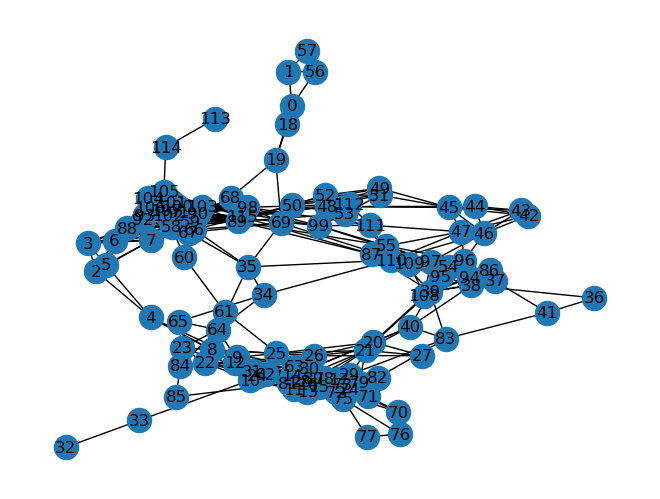

In [10]:
import networkx as nx
# Ensure gnn.test_idx is a list of integers
test_idx = gnn.test_idx.tolist() if isinstance(gnn.test_idx, torch.Tensor) else gnn.test_idx

# Visualize the first graph of the test set to see if the properties are correct
G = nx.from_edgelist(gnn.dataset[test_idx[0]].edge_index.t().tolist())
nx.draw(G, with_labels=True)


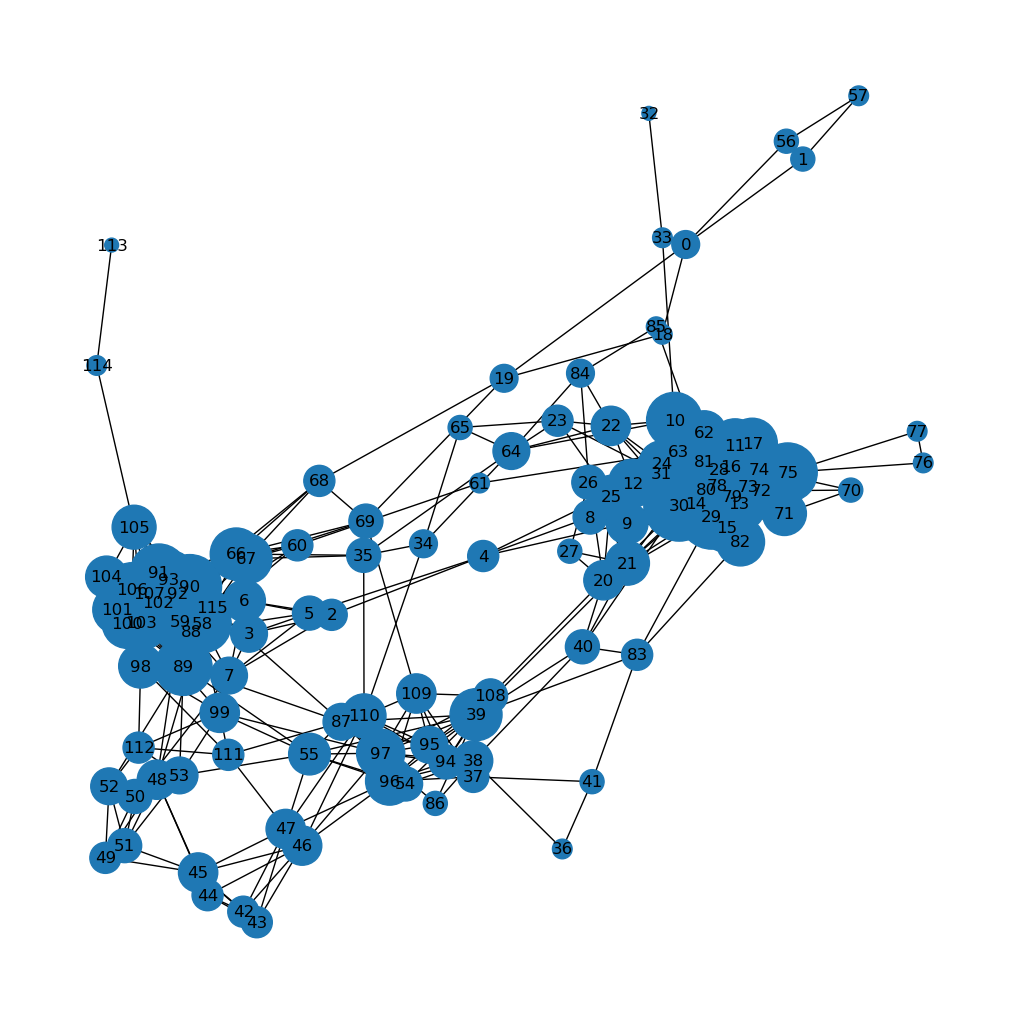

In [11]:
import matplotlib.pyplot as plt
#represent the node degrees of the first graph in the test set
node_degrees = test_node_properties[0][0]

plt.figure(figsize=(10, 10))
nx.draw(G, with_labels=True, node_size=[v * 100 for v in node_degrees], cmap='viridis')
plt.show()

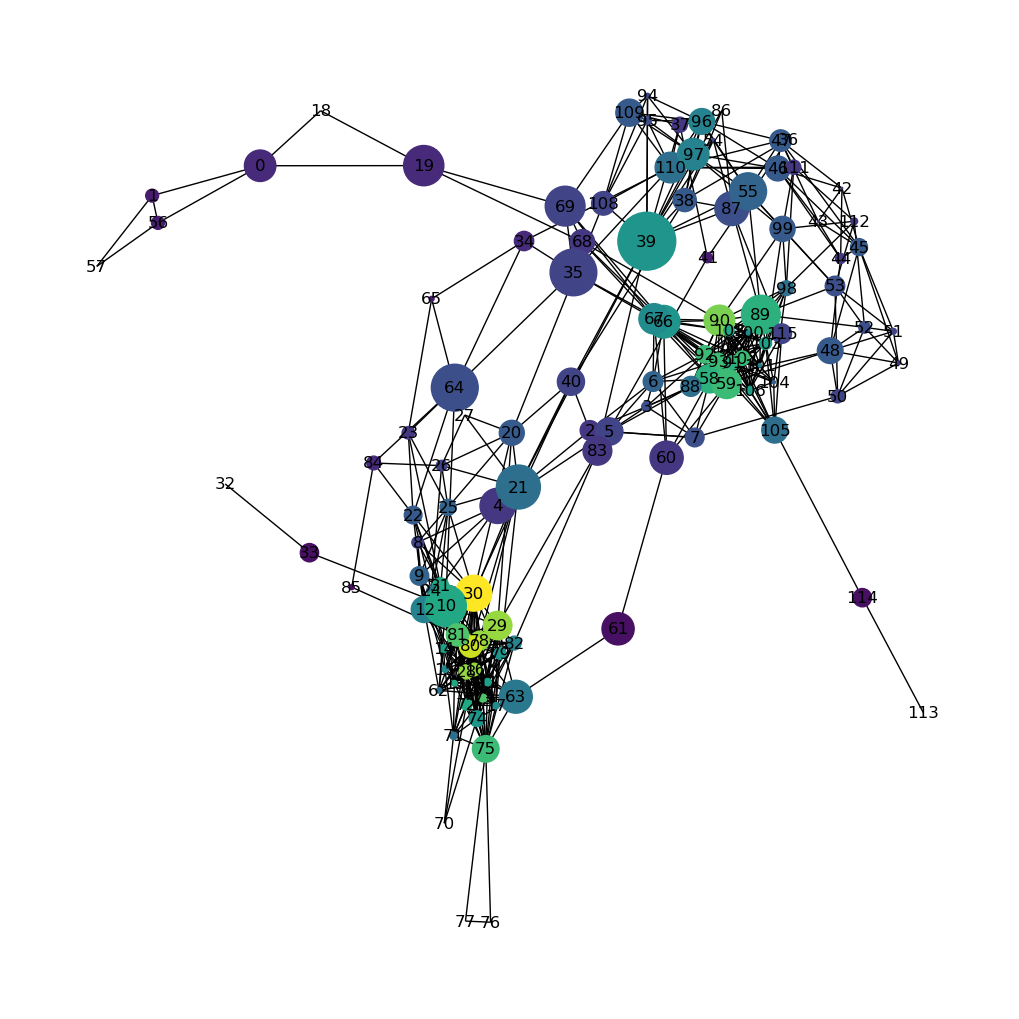

In [12]:
#represent the properties of betweenness centrality on the graph by chaging the size of the nodes
betweenness_centrality = test_node_properties[0][2]
node_degrees = test_node_properties[0][0]

plt.figure(figsize=(10, 10))
nx.draw(G, with_labels=True, node_size=[v * 10000 for v in betweenness_centrality], node_color=node_degrees, cmap='viridis')
plt.show()


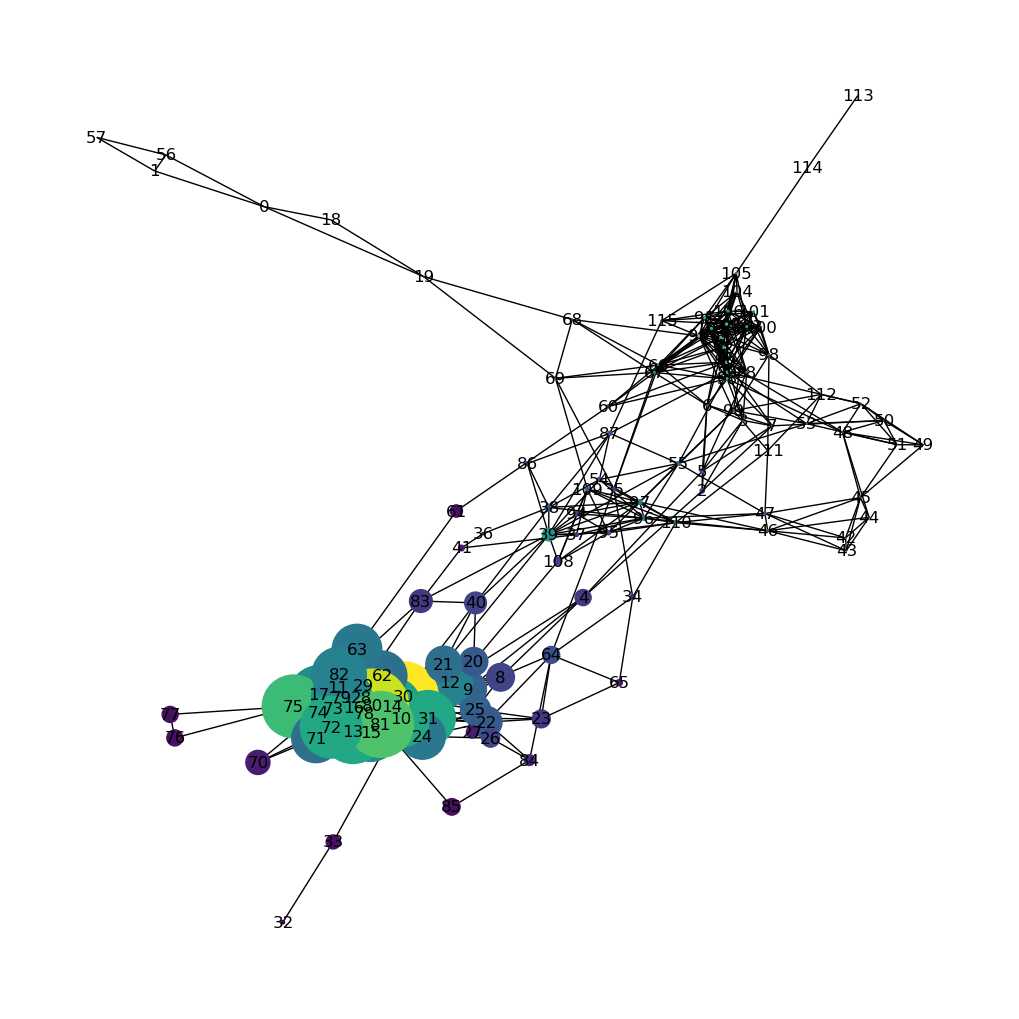

In [13]:
#same for eigenvector centrality
eigenvector_centralities = test_node_properties[0][3]

plt.figure(figsize=(10, 10))
nx.draw(G, with_labels=True, node_size=[v * 10000 for v in eigenvector_centralities], node_color=node_degrees, cmap='viridis')
plt.show()

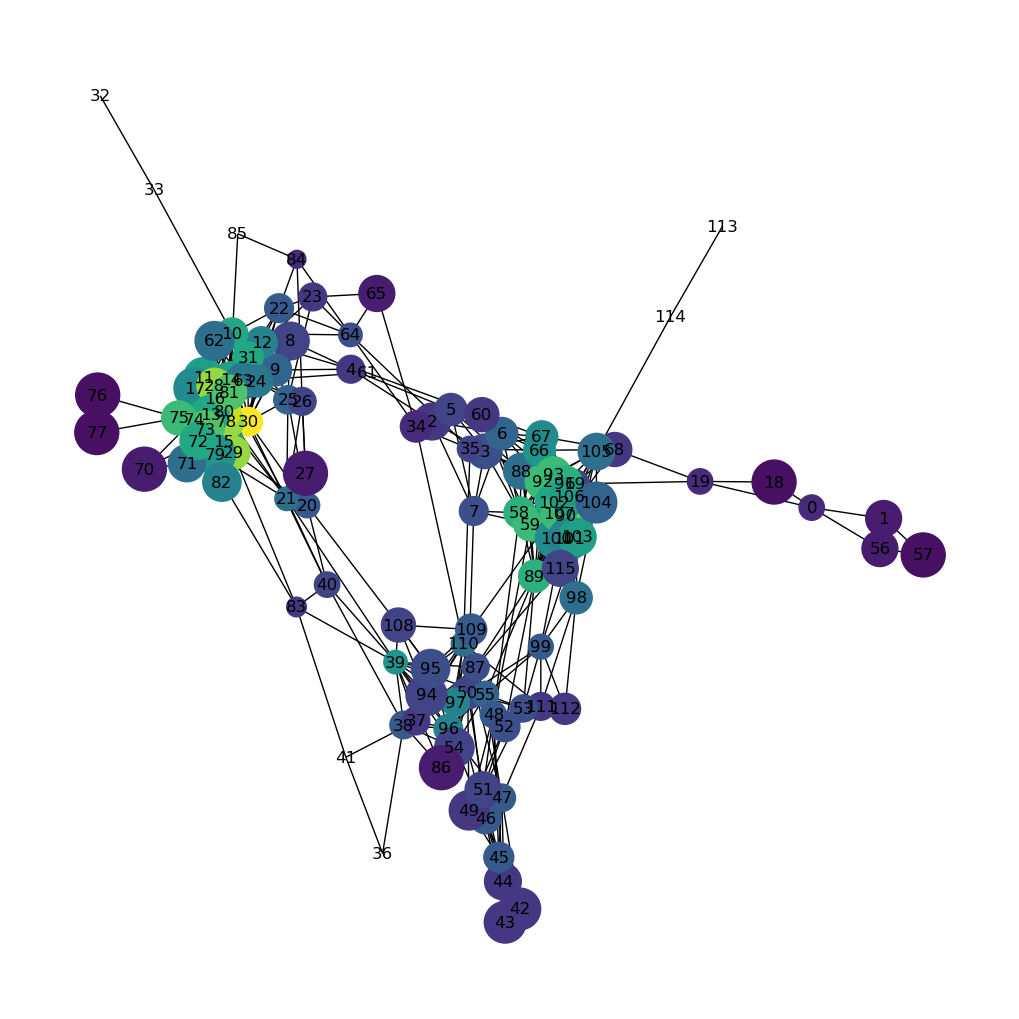

In [14]:
#same for local clustering coefficients
Local_clustering_coefficients = test_node_properties[0][4]

plt.figure(figsize=(10, 10))
nx.draw(G, with_labels=True, node_size=[v * 1000 for v in Local_clustering_coefficients], node_color=node_degrees, cmap='viridis')
plt.show()

We see that for each graph, the length of the betweenness centralities, and in general the length of properties, are equal to the number of nodes in the graph and thus
is equal to the length of the x matrix in the features. 

##### Node embeddings

In [15]:
train_features, test_features = gnn.evaluate_with_features2(return_node_embeddings=True)

len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.Size([116, 128])
features[4].shape:  torch.Size([116, 128])
train_features[0][0].shape:  (116, 128)
len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.Size([116, 128])
features[4].shape:  torch.Size([116, 128])
train_features[0][0].shape:  (116, 128)
len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.Size([116, 128])
features[4].shape:  torch.Size([116, 128])
train_features[0][0].shape:  (116, 128)
len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.

In [18]:
len(train_features), len(test_features)

(1044, 55)

In [19]:
# Check the shape of the first graph's features
first_graph_features = train_features[1]
for i, feature in enumerate(first_graph_features):
    print(f"Feature {i+1} shape:", feature.shape)

Feature 1 shape: (116, 128)
Feature 2 shape: (116, 128)
Feature 3 shape: (116, 128)
Feature 4 shape: (116, 128)
Feature 5 shape: (116, 128)


In [30]:
train_features[1][0][115]

array([-0.37685975,  1.6929058 ,  1.7549721 , -0.5988426 , -0.70699286,
       -0.6436017 , -0.5976539 , -0.58719116, -0.6589397 , -0.58917546,
       -0.6371779 ,  0.7570742 , -0.67844796, -0.5799983 ,  0.99585336,
        0.7851752 , -0.72770834,  2.5991597 , -0.6501186 , -0.67277133,
        0.8801811 ,  3.412127  , -0.62779766, -0.63370866, -0.6870711 ,
        0.9279621 ,  1.7032547 , -0.6746877 , -0.17400467, -0.6686538 ,
       -0.65484655, -0.6692904 , -0.6735106 , -0.6526415 ,  0.69125366,
        0.07277119, -0.6910381 , -0.6376403 , -0.5185264 , -0.6976487 ,
       -0.6681054 , -0.71855813, -0.71772814,  0.52832973, -0.73103005,
        0.28918487, -0.66227067, -0.6802141 , -0.6193607 , -0.67815524,
       -0.6069186 ,  1.8839588 , -0.59435576, -0.02621281, -0.7132852 ,
       -0.68886244, -0.6890108 , -0.6547946 ,  0.6078467 , -0.701213  ,
        1.2887506 ,  2.127263  , -0.58606315,  2.8298755 , -0.18379873,
       -0.5403075 , -0.7609473 , -0.32233348,  0.40016913, -0.10

#### Embedding probing

##### Probing for the top 3 nodes on train_features only and averaging the results of the different diagnostif classifiers

In [31]:
import torch
import torch.nn as nn

class LinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

# Function to get the top 3 nodes based on a specific property
def get_top_nodes(property_list, top_n=10):
    sorted_indices = sorted(range(len(property_list)), key=lambda k: property_list[k], reverse=True)
    return sorted_indices[:top_n]

In [33]:

# Get the top 3 nodes for local clustering coefficient and eigenvector centrality
top_nodes_degrees = [get_top_nodes(graph_props[0], 10) for graph_props in train_node_properties]  # Assuming 0th index is for node degrees
top_nodes_clustering = [get_top_nodes(graph_props[1], 10) for graph_props in train_node_properties]  # Assuming 1st index is for clustering coefficient
top_nodes_betweenness = [get_top_nodes(graph_props[2], 10) for graph_props in train_node_properties]  # Assuming 2nd index is for betweenness centrality
top_nodes_local_clustering = [get_top_nodes(graph_props[3], 10) for graph_props in train_node_properties]  # Assuming 3rd index is for local clustering coefficient
top_nodes_eigenvector = [get_top_nodes(graph_props[4], 10) for graph_props in train_node_properties]  # Assuming 4th index is for eigenvector centrality


In [34]:
# Prepare the data for linear regression model training
def prepare_regression_data(features, properties, top_nodes_indices):
    X = []
    y = []
    for i, graph_features in enumerate(features):
        for layer in range(len(graph_features)):
            for node_index in top_nodes_indices[i]:
                X.append(graph_features[layer][node_index])
                y.append(properties[i][node_index])
    return torch.tensor(X), torch.tensor(y)

# Training and evaluating linear regression models
def train_and_evaluate_regression(X, y):
    model = LinearModel(X.shape[1], 1)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    
    # Train the model
    model.train()
    for epoch in range(5000):
        optimizer.zero_grad()
        outputs = model(X.float())
        loss = criterion(outputs, y.float().view(-1, 1))
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')
    
    # Evaluate the model
    model.eval()
    with torch.no_grad():
        predictions = model(X.float()).view(-1)
        r2 = r2_score(y.float(), predictions)
    return r2

In [35]:
import torch.optim as optim
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Prepare data for node degree regression
X_node_degree, y_node_degree = prepare_regression_data(train_features, [props[0] for props in train_node_properties], top_nodes_degrees)

# Train and evaluate model for node degree
r2_node_degree = train_and_evaluate_regression(X_node_degree, y_node_degree)
print(f'R² for node degree prediction: {r2_node_degree}')

# Prepare data for betweenness centrality regression
X_betweenness, y_betweenness = prepare_regression_data(train_features, [props[2] for props in train_node_properties], top_nodes_betweenness)

# Train and evaluate model for betweenness centrality
r2_betweenness = train_and_evaluate_regression(X_betweenness, y_betweenness)
print(f'R² for betweenness centrality prediction: {r2_betweenness}')

# Prepare data for local clustering coefficient regression
X_local_clustering, y_local_clustering = prepare_regression_data(train_features, [props[3] for props in train_node_properties], top_nodes_local_clustering)

# Train and evaluate model for local clustering coefficient
r2_local_clustering = train_and_evaluate_regression(X_local_clustering, y_local_clustering)
print(f'R² for local clustering coefficient prediction: {r2_local_clustering}')

# Prepare data for eigenvector centrality regression
X_eigenvector, y_eigenvector = prepare_regression_data(train_features, [props[4] for props in train_node_properties], top_nodes_eigenvector)

# Train and evaluate model for eigenvector centrality
r2_eigenvector = train_and_evaluate_regression(X_eigenvector, y_eigenvector)
print(f'R² for eigenvector centrality prediction: {r2_eigenvector}')

C:\Users\tomdu\AppData\Local\Temp\ipykernel_15848\2885731528.py:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  return torch.tensor(X), torch.tensor(y)


Epoch 0, Loss: 337.63140869140625
Epoch 10, Loss: 325.15325927734375
Epoch 20, Loss: 317.4220275878906
Epoch 30, Loss: 311.8927307128906
Epoch 40, Loss: 307.3858337402344
Epoch 50, Loss: 303.4187316894531
Epoch 60, Loss: 299.7639465332031
Epoch 70, Loss: 296.2999267578125
Epoch 80, Loss: 292.96038818359375
Epoch 90, Loss: 289.7093200683594
Epoch 100, Loss: 286.5265808105469
Epoch 110, Loss: 283.3989562988281
Epoch 120, Loss: 280.3171691894531
Epoch 130, Loss: 277.27484130859375
Epoch 140, Loss: 274.2673645019531
Epoch 150, Loss: 271.29156494140625
Epoch 160, Loss: 268.34521484375
Epoch 170, Loss: 265.42669677734375
Epoch 180, Loss: 262.5349426269531
Epoch 190, Loss: 259.6691589355469
Epoch 200, Loss: 256.8288269042969
Epoch 210, Loss: 254.01341247558594
Epoch 220, Loss: 251.22276306152344
Epoch 230, Loss: 248.4565887451172
Epoch 240, Loss: 245.7146759033203
Epoch 250, Loss: 242.9969024658203
Epoch 260, Loss: 240.3031463623047
Epoch 270, Loss: 237.63323974609375
Epoch 280, Loss: 234.987

##### Probing for the top 1 nodes with diagnostic classifier trained on the train set and test on the test set

Processing property: Node Degrees
Processing property: Clustering Coefficients
Processing property: Betweenness Centralities
Processing property: Eigenvector Centralities
Processing property: Local Clustering Coefficients


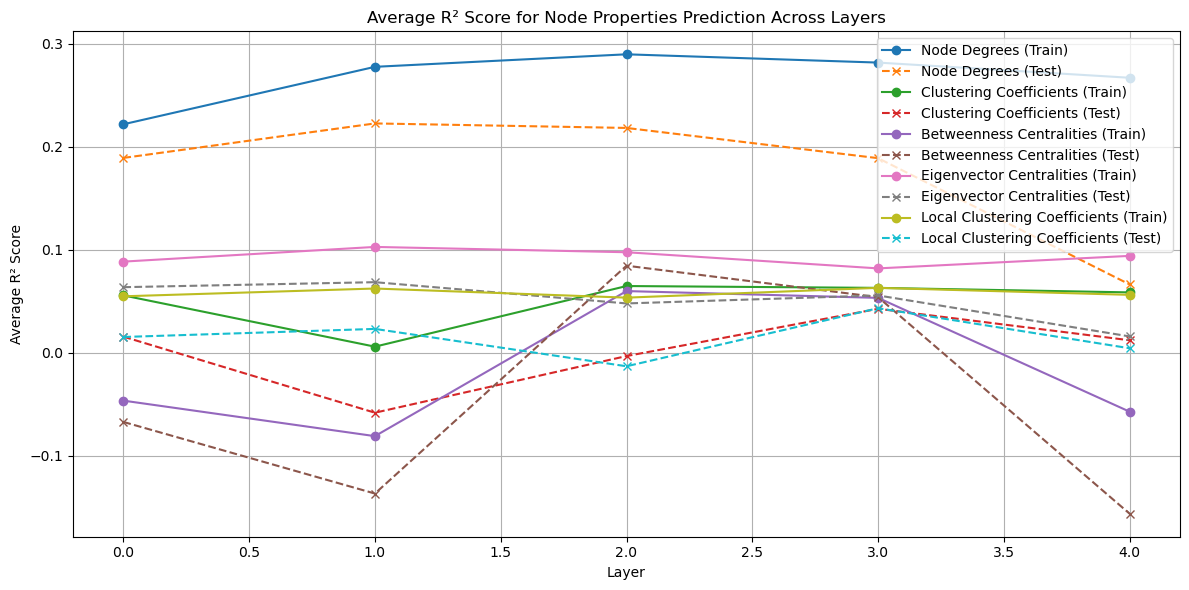

In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np

# Define Linear Model for probing (diagnostic classifier)
class LinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

# Prepare the data for probing classifier
def prepare_regression_data(features, properties, property_index, top_n_nodes=10):
    X_layers = [[] for _ in range(len(features[0]))]
    y_layers = [[] for _ in range(len(features[0]))]

    for i, graph_features in enumerate(features):
        top_nodes_indices = get_top_nodes(properties[i][property_index], top_n=top_n_nodes)
        for layer in range(len(graph_features)):
            for node_index in top_nodes_indices:
                X_layers[layer].append(graph_features[layer][node_index])
                y_layers[layer].append(properties[i][property_index][node_index])

    X_layers = [torch.tensor(X) for X in X_layers]
    y_layers = [torch.tensor(y) for y in y_layers]
    
    return X_layers, y_layers

# Train and evaluate the probing classifier for each layer
def train_and_evaluate_regression(X_train_layers, y_train_layers, X_test_layers, y_test_layers):
    r2_scores_train = []
    r2_scores_test = []
    
    for layer in range(len(X_train_layers)):
        X_train = X_train_layers[layer]
        y_train = y_train_layers[layer]
        X_test = X_test_layers[layer]
        y_test = y_test_layers[layer]
        
        model = LinearModel(X_train.shape[1], 1)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.01)
        
        # Train the model
        model.train()
        for epoch in range(10000):
            optimizer.zero_grad()
            outputs = model(X_train.float())
            loss = criterion(outputs, y_train.float().view(-1, 1))
            loss.backward()
            optimizer.step()
        
        # Evaluate the model
        model.eval()
        with torch.no_grad():
            predictions_train = model(X_train.float()).view(-1)
            predictions_test = model(X_test.float()).view(-1)
            r2_train = r2_score(y_train.float(), predictions_train)
            r2_test = r2_score(y_test.float(), predictions_test)
        r2_scores_train.append(r2_train)
        r2_scores_test.append(r2_test)
    
    return r2_scores_train, r2_scores_test

# Aggregate R² scores across all graphs
def aggregate_r2_scores(features_train, properties_train, features_test, properties_test, property_index):
    X_train_layers, y_train_layers = prepare_regression_data(features_train, properties_train, property_index)
    X_test_layers, y_test_layers = prepare_regression_data(features_test, properties_test, property_index)
    
    r2_scores_train, r2_scores_test = train_and_evaluate_regression(X_train_layers, y_train_layers, X_test_layers, y_test_layers)
    
    return r2_scores_train, r2_scores_test

# Properties indices: 0 - node_degrees, 1 - clustering_coeffs, 2 - betweenness_centralities, 3 - eigenvector_centralities, 4 - Local_clustering_coefficients
properties_indices = [0, 1, 2, 3, 4]
property_names = ['Node Degrees', 'Clustering Coefficients', 'Betweenness Centralities', 'Eigenvector Centralities', 'Local Clustering Coefficients']

# Initialize dictionaries to store average R² scores across all layers
avg_r2_train_dict = {name: [] for name in property_names}
avg_r2_test_dict = {name: [] for name in property_names}

# Train and evaluate the probing classifier for each property
for prop_idx, prop_name in zip(properties_indices, property_names):
    print(f"Processing property: {prop_name}")
    avg_r2_train_dict[prop_name], avg_r2_test_dict[prop_name] = aggregate_r2_scores(train_features, train_node_properties, test_features, test_node_properties, prop_idx)

# Plotting the average R² scores across layers for each property
layers = np.arange(len(avg_r2_train_dict[property_names[0]]))

plt.figure(figsize=(12, 6))

# Plot for average R² scores
for prop_name in property_names:
    plt.plot(layers, avg_r2_train_dict[prop_name], label=f'{prop_name} (Train)', marker='o')
    plt.plot(layers, avg_r2_test_dict[prop_name], label=f'{prop_name} (Test)', linestyle='--', marker='x')

plt.xlabel('Layer')
plt.ylabel('Average R² Score')
plt.title('Average R² Score for Node Properties Prediction Across Layers')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

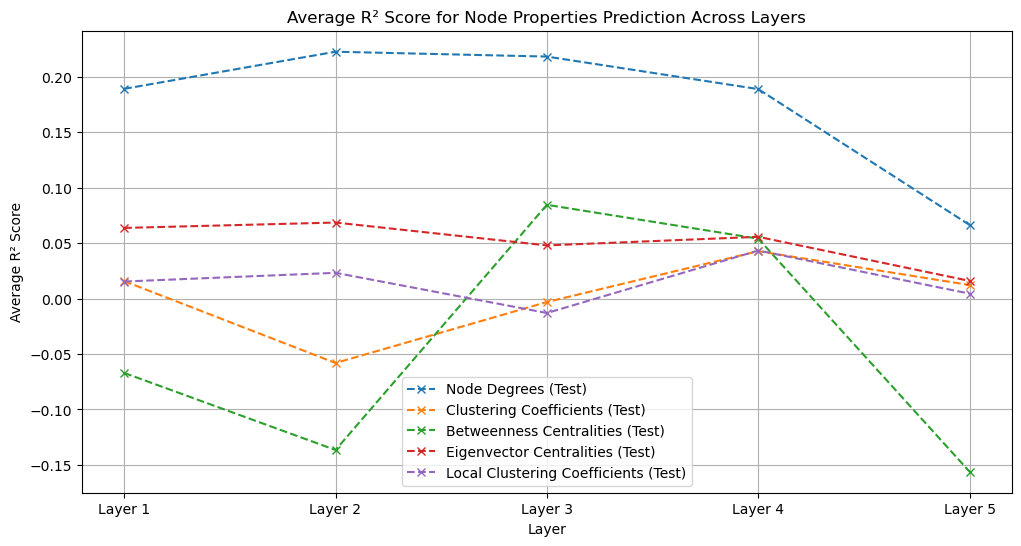

In [37]:
#plot only test results
plt.figure(figsize=(12, 6))

# Plot for average R² scores
for prop_name in property_names:
    plt.plot(layers, avg_r2_test_dict[prop_name], label=f'{prop_name} (Test)', linestyle='--', marker='x')

plt.xlabel('Layer')
plt.ylabel('Average R² Score')
plt.title('Average R² Score for Node Properties Prediction Across Layers')
plt.legend()
#x axis called layer 1, layer 2, etc
plt.xticks(range(len(layers)), [f'Layer {i+1}' for i in layers])           
plt.grid(True)

y=1 and y=0 as two different plots

Processing property for y=0: Node Degrees
Processing property for y=0: Clustering Coefficients
Processing property for y=0: Betweenness Centralities
Processing property for y=0: Eigenvector Centralities
Processing property for y=0: Local Clustering Coefficients
Processing property for y=1: Node Degrees
Processing property for y=1: Clustering Coefficients
Processing property for y=1: Betweenness Centralities
Processing property for y=1: Eigenvector Centralities
Processing property for y=1: Local Clustering Coefficients


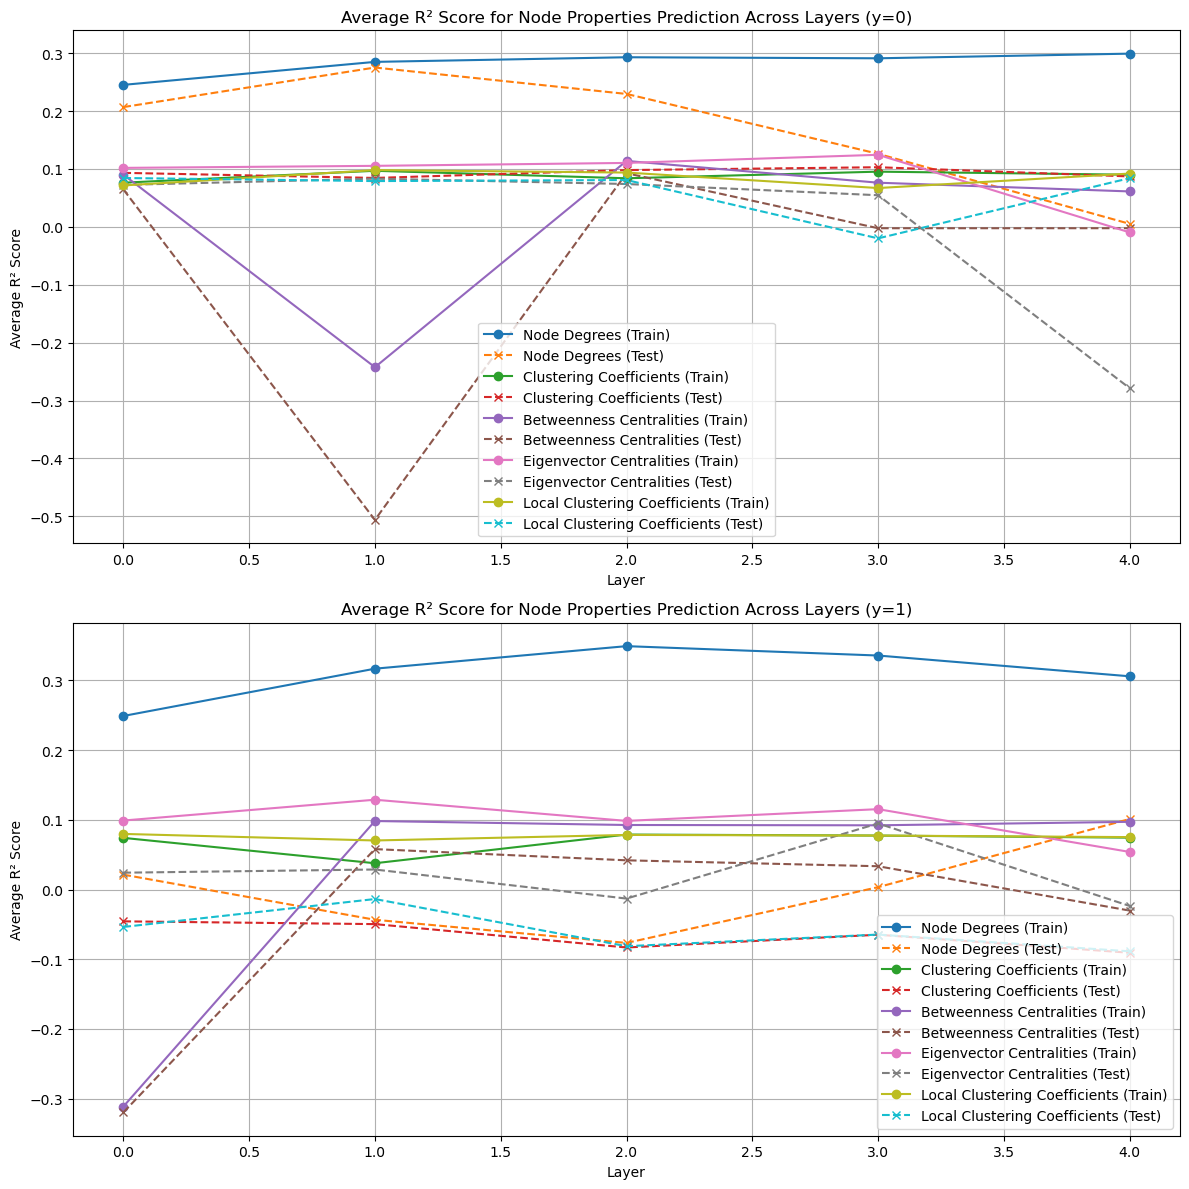

In [63]:
# Extract labels from the dataset using train_idx_list and test_idx_list
train_idx_list = gnn.train_idx.tolist()
test_idx_list = gnn.test_idx.tolist()

train_labels = [gnn.dataset[i].y.item() for i in train_idx_list]
test_labels = [gnn.dataset[i].y.item() for i in test_idx_list]

# Split the dataset by label y=0 and y=1
def split_by_label(features, properties, labels):
    features_0, properties_0, features_1, properties_1 = [], [], [], []
    
    for i, label in enumerate(labels):
        if label == 0:
            features_0.append(features[i])
            properties_0.append(properties[i])
        else:
            features_1.append(features[i])
            properties_1.append(properties[i])
    
    return features_0, properties_0, features_1, properties_1

# Assuming you have train_features, train_node_properties, test_features, test_node_properties from your GNN
train_features_0, train_node_properties_0, train_features_1, train_node_properties_1 = split_by_label(train_features, train_node_properties, train_labels)
test_features_0, test_node_properties_0, test_features_1, test_node_properties_1 = split_by_label(test_features, test_node_properties, test_labels)

# Properties indices: 0 - node_degrees, 1 - clustering_coeffs, 2 - betweenness_centralities, 3 - eigenvector_centralities, 4 - Local_clustering_coefficients
properties_indices = [0, 1, 2, 3, 4]
property_names = ['Node Degrees', 'Clustering Coefficients', 'Betweenness Centralities', 'Eigenvector Centralities', 'Local Clustering Coefficients']

# Initialize dictionaries to store average R² scores across all layers for y=0 and y=1
avg_r2_train_dict_0 = {name: [] for name in property_names}
avg_r2_test_dict_0 = {name: [] for name in property_names}
avg_r2_train_dict_1 = {name: [] for name in property_names}
avg_r2_test_dict_1 = {name: [] for name in property_names}

# Train and evaluate the probing classifier for each property for y=0
for prop_idx, prop_name in zip(properties_indices, property_names):
    print(f"Processing property for y=0: {prop_name}")
    avg_r2_train_dict_0[prop_name], avg_r2_test_dict_0[prop_name] = aggregate_r2_scores(train_features_0, train_node_properties_0, test_features_0, test_node_properties_0, prop_idx)

# Train and evaluate the probing classifier for each property for y=1
for prop_idx, prop_name in zip(properties_indices, property_names):
    print(f"Processing property for y=1: {prop_name}")
    avg_r2_train_dict_1[prop_name], avg_r2_test_dict_1[prop_name] = aggregate_r2_scores(train_features_1, train_node_properties_1, test_features_1, test_node_properties_1, prop_idx)

# Plotting the average R² scores across layers for each property, separately for y=0 and y=1
layers = np.arange(len(avg_r2_train_dict_0[property_names[0]]))

plt.figure(figsize=(12, 12))

# Plot for y=0
plt.subplot(2, 1, 1)
for prop_name in property_names:
    plt.plot(layers, avg_r2_train_dict_0[prop_name], label=f'{prop_name} (Train)', marker='o')
    plt.plot(layers, avg_r2_test_dict_0[prop_name], label=f'{prop_name} (Test)', linestyle='--', marker='x')
plt.xlabel('Layer')
plt.ylabel('Average R² Score')
plt.title('Average R² Score for Node Properties Prediction Across Layers (y=0)')
plt.legend()
plt.grid(True)

# Plot for y=1
plt.subplot(2, 1, 2)
for prop_name in property_names:
    plt.plot(layers, avg_r2_train_dict_1[prop_name], label=f'{prop_name} (Train)', marker='o')
    plt.plot(layers, avg_r2_test_dict_1[prop_name], label=f'{prop_name} (Test)', linestyle='--', marker='x')
plt.xlabel('Layer')
plt.ylabel('Average R² Score')
plt.title('Average R² Score for Node Properties Prediction Across Layers (y=1)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
